# 训练数据

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
# ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
from mrcnn import utils
from PIL import Image
import yaml

%matplotlib inline

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file训练权重文件的本地路径
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    print("Drop***********************")
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
class DropConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    玩具形状数据集的训练配置。
    从基本 Config 类派生并覆盖特定于玩具形状数据集的值。
    """
    # Give the configuration a recognizable name
    NAME = "shapes"
    
    BACKBONE = "resnet101"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    # 在 1 个 GPU 上训练，每个 GPU 上训练 8 个图像。 我们可以在每个 GPU 上放置多个图像，因为图像很小。 批量大小为 8（GPU * 图像/GPU）。
    GPU_COUNT = 1
#     IMAGES_PER_GPU过大，显存会溢出，可以设置小一点
# IMAGES_PER_GPU = 2
# 这个是对GPU的设置，如果显存不够，建议把2调成1（虽然batch_size为1并不利于收敛)
    IMAGES_PER_GPU = 1
    # Effective batch size
#     self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

    # Number of classes (including background)
#     数据集的类别数，第一类为bg，3（比如三角，圆，矩形）类，所以1+3
    NUM_CLASSES = 1 + 1  # background + 3 shapes
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    # 使用小图像进行更快的训练。 设置小边和大边的界限，这决定了图像的形状。
#     实际训练中修改为自己图片的尺寸，如：1280*800应改为：IMAGE_MIN_DIM = 800;IMAGE_MAX_DIM = 1280
    # 设置训练时的图像大小，最终以IMAGE_MAX_DIM为准，如果电脑性能不是太好，建议调小
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    # 使用较小的锚点，因为我们的图像和对象很小
#     根据自己情况设置anchor大小，如RPN_ANCHOR_SCALES = (8*6, 16*6, 32*6, 64*6, 128*6)
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)
#     RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)  # anchor side in pixels
#     RPN_ANCHOR_SCALES = (8 * 6, 16 * 6, 32 * 6, 64 * 6, 128 * 6)

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    # 减少每张图像的训练 ROI，因为图像很小且对象很少。 旨在让 ROI 采样能够选择 33% 的正 ROI。
#     TRAIN_ROIS_PER_IMAGE = 32
    TRAIN_ROIS_PER_IMAGE = 512
#     TRAIN_ROIS_PER_IMAGE = 200;可根据自己数据集的真实情况来设定

    # Use a small epoch since the data is simple
#     STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
#     VALIDATION_STEPS = 5
#     VALIDATION_STEPS = 5
    
#     设置图像中最多可检测出来的物体数量
    MAX_GT_INSTANCES = 100
    
    DETECTION_NMS_THRESHOLD = 0.95

'''
数据集按照上述格式建立，然后配置好路径即可训练，在windows训练的时候有个问题，就是会出现训练时一直卡在epoch1，这个问题是因为keras在低版本中不支持多线程（在windows上），推荐keras2.1.6，这个亲测可以~

训练的模型会保存在logs文件夹下，.h5格式，训练好后直接调用即可
'''
    
config = DropConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.95
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE            

In [4]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    
    返回要在笔记本中的所有可视化中使用的 Matplotlib Axes 数组。 提供一个中心点来控制图形大小。

    更改默认大小属性以控制渲染图像的大小
    """
    _, ax = plt.subplots(rows, cols, figsize=(size * cols, size * rows))
    return ax

In [5]:
# 全局变量
iter_num=0

In [6]:
class DropDataset(utils.Dataset):
    # 得到该图中有多少个实例（液滴？）
    def get_obj_index(self, image):
        n = np.max(image)
        return n
    
    # 解析labelme中得到的yaml文件，从而得到mask每一层对应的实例标签
    def from_yaml_get_class(self, image_id):
        info=self.image_info[image_id]
        with open(info['yaml_path'])as f:
#             temp=yaml.load(f.read())
#             temp=yaml.load(f.read(), Loader==yaml.FullLoader)
            temp = yaml.safe_load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels
    
    # 重新写draw_mask
    def draw_mask(self, num_obj, mask, image, image_id):
        # print("draw_mask-->",image_id)
        # print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        # print("info-->",info)
        # print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
#                     print("image_id-->",image_id,"-i--->",i,"-j--->",j)
#                     print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j,i,index] = 1
        return mask

    # 重新写load_shapes,里面包含自己的自己的类别（我的是box、column、package、fruitg四类)
    # 并在self.image_info信息中添加了path、mask_path、yaml_path
    # yaml_pathdataset_root_path = "/tongue_dateset/"
    # img_floder = dataset_root_path + "rgb"
    # mask_floder = dataset_root_path + "mask"
    # dataset_root_path = "/tongue_dateset/"
#     def load_shapes(self,count,height,width,img_floder,mask_floder,imglist,dataset_root_path):
    def load_shapes(self,count, img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count:number of images to generate.
        height,width:the size of the generated images.
        """
        # Add classes,可通过这种方式扩展多个物体
        self.add_class("shapes", 1, "drop")
#         self.add_class("shapes",2,"column")
#         self.add_class("shapes",3,"package")
#         self.add_class("shapes",4,"fruit")
        for i in range(count):
            # 获取图片宽和高
            filestr=imglist[i].split(".")[0]
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
#             filestr=filestr.split("")[1]
            mask_path = mask_floder + "/" + filestr +".png"
#             yaml_path=dataset_root_path+"total/rgb_"+filestr+"_json/info.yaml"
            yaml_path = dataset_root_path + "labelme_json/" + filestr + "_json/info.yaml"
#             self.add_image("drop",image_id=i,path=img_floder + "/"+imglist[i],
#                            width=width,height=height,mask_path=mask_path,yaml_path=yaml_path)
            print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            cv_img = cv2.imread(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
                           width=cv_img.shape[1], height=cv_img.shape[0], mask_path=mask_path, yaml_path=yaml_path)
    
    # 重写load_mask
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        print("image_id: ", image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask=np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
#         mask=self.draw_mask(num_obj, mask, img)
        mask=self.draw_mask(num_obj, mask, img, image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i]=mask[:, :, i] * occlusion
            occlusion=np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels=[]
        labels=self.from_yaml_get_class(image_id)
        labels_form=[]
        for i in range(len(labels)):
            if labels[i].find("drop")!=-1:
                print("drop")
                labels_form.append("drop")
#             elif labels[i].find("column")!=-1:
#                 # print "column"
#                 labels_form.append("column")
#             elif labels[i].find("package")!=-1:
#                 # print "package"
#                 labels_form.append("package")
#             elif labels[i].find("fruit")!=-1:
#                 # print "fruit"
#                 labels_form.append("fruit")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask,class_ids.astype(np.int32)

In [7]:
# 基础设置
dataset_root_path="train_data11/"
img_floder = dataset_root_path + "pic"
mask_floder = dataset_root_path + "cv2_mask"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
count = len(imglist)

# width = 1600/25
# height = 1200/25

# train与val数据集准备
# Training dataset
dataset_train = DropDataset()
# dataset_train.load_shapes(count, width, height, img_floder, mask_floder, imglist, dataset_root_path)
dataset_train.load_shapes(count, img_floder, mask_floder, imglist, dataset_root_path)
dataset_train.prepare()

print("dataset_train-->", dataset_train._image_ids)

# Validation dataset
dataset_val = DropDataset()
# dataset_val.load_shapes(7, width, height, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val.load_shapes(7, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val.prepare()

print("dataset_val-->",dataset_val._image_ids)

# Load and display random samples
#image_ids = np.random.choice(dataset_train.image_ids, 4)
#for image_id in image_ids:
#    image = dataset_train.load_image(image_id)
#    mask, class_ids = dataset_train.load_mask(image_id)
#    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last
# init_with = "last"

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    checkpoint_file = model.find_last()
    # Load the last model you trained and continue training
#     model.load_weights(model.find_last()[1], by_name=True)
    model.load_weights(checkpoint_file, by_name=True)

# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=20,
            layers='heads')

'''
model.train(…, layers=‘heads’, …) # Train heads branches (least memory)
model.train(…, layers=‘3+’, …) # Train resnet stage 3 and up
model.train(…, layers=‘4+’, …) # Train resnet stage 4 and up
model.train(…, layers=‘all’, …) # Train all layers (most memory)#这里是选择训练的层数，根据自己的要求选择
'''

# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=20,
            layers="all")

print("end-----------------")

train_data11/labelme_json/1_json/img.png
train_data11/labelme_json/10_json/img.png
train_data11/labelme_json/11_json/img.png
train_data11/labelme_json/12_json/img.png
train_data11/labelme_json/13_json/img.png
train_data11/labelme_json/14_json/img.png
train_data11/labelme_json/15_json/img.png
train_data11/labelme_json/16_json/img.png
train_data11/labelme_json/17_json/img.png
train_data11/labelme_json/18_json/img.png
train_data11/labelme_json/19_json/img.png
train_data11/labelme_json/2_json/img.png
train_data11/labelme_json/20_json/img.png
train_data11/labelme_json/3_json/img.png
train_data11/labelme_json/4_json/img.png
train_data11/labelme_json/5_json/img.png
train_data11/labelme_json/6_json/img.png
train_data11/labelme_json/7_json/img.png
train_data11/labelme_json/8_json/img.png
train_data11/labelme_json/9_json/img.png
dataset_train--> [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
train_data11/labelme_json/1_json/img.png
train_data11/labelme_json/10_json/img.png
train_d

E:\XMJ\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
image_id:  8
drop
   1/1000 [..............................] - ETA: 2:28:12 - loss: 4.2729 - rpn_class_loss: 0.0764 - rpn_bbox_loss: 2.2495 - mrcnn_class_loss: 0.9675 - mrcnn_bbox_loss: 0.8245 - mrcnn_mask_loss: 0.1550image_id:  6
drop
   2/1000 [..............................] - ETA: 1:21:16 - loss: 5.4229 - rpn_class_loss: 0.0495 - rpn_bbox_loss: 3.5341 - mrcnn_class_loss: 0.7619 - mrcnn_bbox_loss: 0.7511 - mrcnn_mask_loss: 0.3263image_id:  15
drop
   3/1000 [..............................] - ETA: 1:01:54 - loss: 6.7962 - rpn_class_loss: 0.0863 - rpn_bbox_loss: 4.2715 - mrcnn_class_loss: 0.5581 - mrcnn_bbox_loss: 1.0490 - mrcnn_mask_loss: 0.8313image_id:  5
drop
   4/1000 [..............................] - ETA: 50:03 - loss: 6.5933 - rpn_class_loss: 0.0745 - rpn_bbox_loss: 4.2839 - mrcnn_class_loss: 0.4349 - mrcnn_bbox_loss: 1.0633 - mrcnn_mask_loss: 0.7367  image_id:  0
drop
   5/1000 [..............................] - ETA: 44:44 - loss: 7.0066 - rpn_class_loss: 0.0940 - 

  38/1000 [>.............................] - ETA: 21:52 - loss: 4.9685 - rpn_class_loss: 0.1002 - rpn_bbox_loss: 3.6341 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.6939 - mrcnn_mask_loss: 0.4820image_id:  4
drop
  39/1000 [>.............................] - ETA: 21:40 - loss: 4.9120 - rpn_class_loss: 0.0986 - rpn_bbox_loss: 3.5978 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.6846 - mrcnn_mask_loss: 0.4741image_id:  15
drop
  40/1000 [>.............................] - ETA: 21:40 - loss: 4.8889 - rpn_class_loss: 0.0996 - rpn_bbox_loss: 3.5838 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.6738 - mrcnn_mask_loss: 0.4762image_id:  12
drop
  41/1000 [>.............................] - ETA: 21:29 - loss: 4.8530 - rpn_class_loss: 0.0980 - rpn_bbox_loss: 3.5650 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.6667 - mrcnn_mask_loss: 0.4690image_id:  13
drop
  42/1000 [>.............................] - ETA: 21:31 - loss: 4.8316 - rpn_class_loss: 0.0988 - rpn_bbox_loss: 3.5495 - mrcnn_class

  75/1000 [=>............................] - ETA: 20:01 - loss: 3.5687 - rpn_class_loss: 0.0815 - rpn_bbox_loss: 2.5859 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.4154image_id:  15
drop
  76/1000 [=>............................] - ETA: 20:02 - loss: 3.5419 - rpn_class_loss: 0.0811 - rpn_bbox_loss: 2.5633 - mrcnn_class_loss: 0.0307 - mrcnn_bbox_loss: 0.4497 - mrcnn_mask_loss: 0.4171image_id:  3
drop
  77/1000 [=>............................] - ETA: 19:57 - loss: 3.4995 - rpn_class_loss: 0.0801 - rpn_bbox_loss: 2.5314 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.4448 - mrcnn_mask_loss: 0.4128image_id:  10
drop
  78/1000 [=>............................] - ETA: 19:53 - loss: 3.4834 - rpn_class_loss: 0.0794 - rpn_bbox_loss: 2.5227 - mrcnn_class_loss: 0.0300 - mrcnn_bbox_loss: 0.4425 - mrcnn_mask_loss: 0.4088image_id:  16
drop
  79/1000 [=>............................] - ETA: 19:54 - loss: 3.4572 - rpn_class_loss: 0.0788 - rpn_bbox_loss: 2.5002 - mrcnn_class

 112/1000 [==>...........................] - ETA: 18:57 - loss: 2.7585 - rpn_class_loss: 0.0602 - rpn_bbox_loss: 1.9558 - mrcnn_class_loss: 0.0217 - mrcnn_bbox_loss: 0.3332 - mrcnn_mask_loss: 0.3875image_id:  16
drop
 113/1000 [==>...........................] - ETA: 18:57 - loss: 2.7435 - rpn_class_loss: 0.0599 - rpn_bbox_loss: 1.9423 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.3894image_id:  5
drop
 114/1000 [==>...........................] - ETA: 18:54 - loss: 2.7260 - rpn_class_loss: 0.0594 - rpn_bbox_loss: 1.9300 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.3281 - mrcnn_mask_loss: 0.3871image_id:  7
drop
 115/1000 [==>...........................] - ETA: 18:50 - loss: 2.7115 - rpn_class_loss: 0.0590 - rpn_bbox_loss: 1.9209 - mrcnn_class_loss: 0.0213 - mrcnn_bbox_loss: 0.3257 - mrcnn_mask_loss: 0.3847image_id:  18
drop
 116/1000 [==>...........................] - ETA: 18:51 - loss: 2.6956 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 1.9068 - mrcnn_class_

 149/1000 [===>..........................] - ETA: 18:06 - loss: 2.2887 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 1.5853 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2623 - mrcnn_mask_loss: 0.3760image_id:  1
drop
 150/1000 [===>..........................] - ETA: 18:06 - loss: 2.2788 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 1.5760 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2609 - mrcnn_mask_loss: 0.3773image_id:  2
drop
 151/1000 [===>..........................] - ETA: 18:03 - loss: 2.2671 - rpn_class_loss: 0.0476 - rpn_bbox_loss: 1.5680 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.3752image_id:  14
drop
 152/1000 [===>..........................] - ETA: 18:06 - loss: 2.2575 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 1.5591 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2579 - mrcnn_mask_loss: 0.3765image_id:  6
drop
 153/1000 [===>..........................] - ETA: 18:04 - loss: 2.2470 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 1.5520 - mrcnn_class_l

 186/1000 [====>.........................] - ETA: 17:39 - loss: 1.9826 - rpn_class_loss: 0.0404 - rpn_bbox_loss: 1.3472 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2197 - mrcnn_mask_loss: 0.3613image_id:  14
drop
 187/1000 [====>.........................] - ETA: 17:39 - loss: 1.9771 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.3417 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.2189 - mrcnn_mask_loss: 0.3623image_id:  16
drop
 188/1000 [====>.........................] - ETA: 17:40 - loss: 1.9717 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 1.3362 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2182 - mrcnn_mask_loss: 0.3634image_id:  4
drop
 189/1000 [====>.........................] - ETA: 17:38 - loss: 1.9631 - rpn_class_loss: 0.0401 - rpn_bbox_loss: 1.3298 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2176 - mrcnn_mask_loss: 0.3619image_id:  15
drop
 190/1000 [====>.........................] - ETA: 17:39 - loss: 1.9568 - rpn_class_loss: 0.0399 - rpn_bbox_loss: 1.3236 - mrcnn_class

 223/1000 [=====>........................] - ETA: 17:27 - loss: 1.7655 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 1.1693 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1889 - mrcnn_mask_loss: 0.3599image_id:  15
drop
 224/1000 [=====>........................] - ETA: 17:27 - loss: 1.7614 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 1.1653 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.3608image_id:  16
drop
 225/1000 [=====>........................] - ETA: 17:27 - loss: 1.7581 - rpn_class_loss: 0.0350 - rpn_bbox_loss: 1.1620 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1874 - mrcnn_mask_loss: 0.3618image_id:  0
drop
 226/1000 [=====>........................] - ETA: 17:27 - loss: 1.7544 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.1583 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1866 - mrcnn_mask_loss: 0.3627image_id:  5
drop
 227/1000 [=====>........................] - ETA: 17:25 - loss: 1.7498 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 1.1554 - mrcnn_class_

 260/1000 [======>.......................] - ETA: 17:10 - loss: 1.6429 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 1.0807 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1668 - mrcnn_mask_loss: 0.3532image_id:  10
drop
 261/1000 [======>.......................] - ETA: 17:08 - loss: 1.6378 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.0774 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.3521image_id:  5
drop
 262/1000 [======>.......................] - ETA: 17:07 - loss: 1.6365 - rpn_class_loss: 0.0315 - rpn_bbox_loss: 1.0777 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1658 - mrcnn_mask_loss: 0.3511image_id:  1
drop
 263/1000 [======>.......................] - ETA: 17:07 - loss: 1.6351 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 1.0762 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.3519image_id:  13
drop
 264/1000 [======>.......................] - ETA: 17:08 - loss: 1.6335 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 1.0745 - mrcnn_class_

 297/1000 [=======>......................] - ETA: 16:46 - loss: 1.5250 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9893 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1498 - mrcnn_mask_loss: 0.3481image_id:  15
drop
 298/1000 [=======>......................] - ETA: 16:46 - loss: 1.5236 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.9876 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1494 - mrcnn_mask_loss: 0.3488image_id:  17
drop
 299/1000 [=======>......................] - ETA: 16:45 - loss: 1.5219 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.9858 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.3494image_id:  2
drop
 300/1000 [========>.....................] - ETA: 16:44 - loss: 1.5184 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.9836 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1488 - mrcnn_mask_loss: 0.3484image_id:  8
drop
 301/1000 [========>.....................] - ETA: 16:43 - loss: 1.5140 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.9806 - mrcnn_class_

 334/1000 [=========>....................] - ETA: 16:19 - loss: 1.4362 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.9181 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1390 - mrcnn_mask_loss: 0.3446image_id:  9
drop
 335/1000 [=========>....................] - ETA: 16:17 - loss: 1.4333 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.9163 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1387 - mrcnn_mask_loss: 0.3438image_id:  13
drop
 336/1000 [=========>....................] - ETA: 16:16 - loss: 1.4310 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.9138 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.3445image_id:  11
drop
 337/1000 [=========>....................] - ETA: 16:19 - loss: 1.4287 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.9112 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1381 - mrcnn_mask_loss: 0.3451image_id:  17
drop
 338/1000 [=========>....................] - ETA: 16:17 - loss: 1.4263 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.9087 - mrcnn_class

 371/1000 [==========>...................] - ETA: 15:46 - loss: 1.3492 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8475 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.3416image_id:  9
drop
 372/1000 [==========>...................] - ETA: 15:44 - loss: 1.3469 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.8462 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1281 - mrcnn_mask_loss: 0.3409image_id:  1
drop
 373/1000 [==========>...................] - ETA: 15:43 - loss: 1.3454 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8445 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.3415image_id:  7
drop
 374/1000 [==========>...................] - ETA: 15:41 - loss: 1.3427 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.8428 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1275 - mrcnn_mask_loss: 0.3408image_id:  14
drop
 375/1000 [==========>...................] - ETA: 15:40 - loss: 1.3410 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.8410 - mrcnn_class_l

 408/1000 [===========>..................] - ETA: 15:11 - loss: 1.2815 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7918 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.3395image_id:  1
drop
 409/1000 [===========>..................] - ETA: 15:12 - loss: 1.2803 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7903 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.3400image_id:  8
drop
 410/1000 [===========>..................] - ETA: 15:12 - loss: 1.2778 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7887 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.3393image_id:  12
drop
 411/1000 [===========>..................] - ETA: 15:10 - loss: 1.2755 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.7873 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1201 - mrcnn_mask_loss: 0.3387image_id:  15
drop
 412/1000 [===========>..................] - ETA: 15:09 - loss: 1.2746 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.7862 - mrcnn_class_

 445/1000 [============>.................] - ETA: 14:27 - loss: 1.2169 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.7397 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.3350image_id:  0
drop
 446/1000 [============>.................] - ETA: 14:26 - loss: 1.2163 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.7385 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.3356image_id:  16
drop
 447/1000 [============>.................] - ETA: 14:26 - loss: 1.2152 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.7371 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1145 - mrcnn_mask_loss: 0.3361image_id:  12
drop
 448/1000 [============>.................] - ETA: 14:24 - loss: 1.2134 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.7362 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.3355image_id:  1
drop
 449/1000 [============>.................] - ETA: 14:24 - loss: 1.2125 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.7351 - mrcnn_class_

 482/1000 [=============>................] - ETA: 13:43 - loss: 1.1647 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6964 - mrcnn_class_loss: 0.0064 - mrcnn_bbox_loss: 0.1090 - mrcnn_mask_loss: 0.3334image_id:  0
drop
 483/1000 [=============>................] - ETA: 13:42 - loss: 1.1636 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6951 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.3339image_id:  15
drop
 484/1000 [=============>................] - ETA: 13:41 - loss: 1.1627 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.6939 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.3344image_id:  11
drop
 485/1000 [=============>................] - ETA: 13:39 - loss: 1.1617 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6927 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1085 - mrcnn_mask_loss: 0.3349image_id:  14
drop
 486/1000 [=============>................] - ETA: 13:38 - loss: 1.1605 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.6913 - mrcnn_class

 519/1000 [==============>...............] - ETA: 12:52 - loss: 1.1177 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.6585 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.1032 - mrcnn_mask_loss: 0.3317image_id:  4
drop
 520/1000 [==============>...............] - ETA: 12:50 - loss: 1.1161 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.6576 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.1030 - mrcnn_mask_loss: 0.3311image_id:  9
drop
 521/1000 [==============>...............] - ETA: 12:48 - loss: 1.1146 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.6568 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.1029 - mrcnn_mask_loss: 0.3306image_id:  6
drop
 522/1000 [==============>...............] - ETA: 12:46 - loss: 1.1127 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.6557 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.3301image_id:  1
drop
 523/1000 [==============>...............] - ETA: 12:45 - loss: 1.1120 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.6547 - mrcnn_class_lo

 556/1000 [===============>..............] - ETA: 12:02 - loss: 1.0746 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.6247 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.3292image_id:  13
drop
 557/1000 [===============>..............] - ETA: 12:00 - loss: 1.0738 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.6237 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0974 - mrcnn_mask_loss: 0.3296image_id:  16
drop
 558/1000 [===============>..............] - ETA: 11:59 - loss: 1.0730 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.6227 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0973 - mrcnn_mask_loss: 0.3300image_id:  12
drop
 559/1000 [===============>..............] - ETA: 11:57 - loss: 1.0713 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.6217 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0971 - mrcnn_mask_loss: 0.3295image_id:  6
drop
 560/1000 [===============>..............] - ETA: 11:55 - loss: 1.0697 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.6206 - mrcnn_class

 593/1000 [================>.............] - ETA: 11:09 - loss: 1.0360 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.5933 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.3281image_id:  3
drop
 594/1000 [================>.............] - ETA: 11:07 - loss: 1.0345 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5924 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.3276image_id:  1
drop
 595/1000 [================>.............] - ETA: 11:06 - loss: 1.0339 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5916 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0924 - mrcnn_mask_loss: 0.3280image_id:  6
drop
 596/1000 [================>.............] - ETA: 11:04 - loss: 1.0324 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5907 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0922 - mrcnn_mask_loss: 0.3276image_id:  12
drop
 597/1000 [================>.............] - ETA: 11:02 - loss: 1.0310 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.5899 - mrcnn_class_l

 630/1000 [=================>............] - ETA: 10:12 - loss: 1.0024 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5678 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.3254image_id:  3
drop
 631/1000 [=================>............] - ETA: 10:11 - loss: 1.0010 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5670 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.3249image_id:  18
drop
 632/1000 [=================>............] - ETA: 10:10 - loss: 1.0008 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.5666 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.3253image_id:  6
drop
 633/1000 [=================>............] - ETA: 10:09 - loss: 1.0000 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5663 - mrcnn_class_loss: 0.0052 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.3249image_id:  11
drop
 634/1000 [==================>...........] - ETA: 10:08 - loss: 0.9999 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.5660 - mrcnn_class_

drop
 668/1000 [===================>..........] - ETA: 9:14 - loss: 0.9774 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5474 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.3255image_id:  12
drop
 669/1000 [===================>..........] - ETA: 9:13 - loss: 0.9767 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.5472 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.3251image_id:  6
drop
 670/1000 [===================>..........] - ETA: 9:12 - loss: 0.9765 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5475 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.3247image_id:  13
drop
 671/1000 [===================>..........] - ETA: 9:11 - loss: 0.9774 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5482 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.3251image_id:  19
drop
 672/1000 [===================>..........] - ETA: 9:10 - loss: 0.9779 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.5486 - mrcnn_class

 706/1000 [====================>.........] - ETA: 8:16 - loss: 0.9616 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5384 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.3234image_id:  18
drop
 707/1000 [====================>.........] - ETA: 8:14 - loss: 0.9613 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.5379 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.3237image_id:  3
drop
 708/1000 [====================>.........] - ETA: 8:12 - loss: 0.9602 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5372 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.3233image_id:  8
drop
 709/1000 [====================>.........] - ETA: 8:11 - loss: 0.9589 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5365 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.3229image_id:  5
drop
 710/1000 [====================>.........] - ETA: 8:09 - loss: 0.9579 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.5359 - mrcnn_class_loss: 

 744/1000 [=====================>........] - ETA: 7:13 - loss: 0.9414 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5226 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.3227image_id:  17
drop
 745/1000 [=====================>........] - ETA: 7:11 - loss: 0.9412 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5222 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.3230image_id:  8
drop
 746/1000 [=====================>........] - ETA: 7:11 - loss: 0.9401 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5216 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.3226image_id:  16
drop
 747/1000 [=====================>........] - ETA: 7:09 - loss: 0.9399 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5212 - mrcnn_class_loss: 0.0046 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.3229image_id:  4
drop
 748/1000 [=====================>........] - ETA: 7:07 - loss: 0.9389 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.5206 - mrcnn_class_loss:

 782/1000 [======================>.......] - ETA: 6:11 - loss: 0.9184 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5047 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.3209image_id:  0
drop
 783/1000 [======================>.......] - ETA: 6:09 - loss: 0.9180 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5042 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.3212image_id:  10
drop
 784/1000 [======================>.......] - ETA: 6:08 - loss: 0.9173 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5039 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.3208image_id:  1
drop
 785/1000 [======================>.......] - ETA: 6:06 - loss: 0.9169 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5033 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.3211image_id:  7
drop
 786/1000 [======================>.......] - ETA: 6:04 - loss: 0.9161 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.5029 - mrcnn_class_loss: 

 820/1000 [=======================>......] - ETA: 5:08 - loss: 0.9020 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4925 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.3197image_id:  14
drop
 821/1000 [=======================>......] - ETA: 5:06 - loss: 0.9017 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4921 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.3199image_id:  4
drop
 822/1000 [=======================>......] - ETA: 5:04 - loss: 0.9018 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4926 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.3196image_id:  19
drop
 823/1000 [=======================>......] - ETA: 5:03 - loss: 0.9014 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4921 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.3198image_id:  3
drop
 824/1000 [=======================>......] - ETA: 5:01 - loss: 0.9006 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.4917 - mrcnn_class_loss:

 858/1000 [========================>.....] - ETA: 4:04 - loss: 0.8893 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4835 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.3191image_id:  5
drop
 859/1000 [========================>.....] - ETA: 4:02 - loss: 0.8885 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4830 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.3188image_id:  8
drop
 860/1000 [========================>.....] - ETA: 4:01 - loss: 0.8875 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4825 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.3185image_id:  13
drop
 861/1000 [========================>.....] - ETA: 3:59 - loss: 0.8873 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4821 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.3187image_id:  1
drop
 862/1000 [========================>.....] - ETA: 3:57 - loss: 0.8872 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.4818 - mrcnn_class_loss: 

 896/1000 [=========================>....] - ETA: 2:59 - loss: 0.8728 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4709 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.3181image_id:  18
drop
 897/1000 [=========================>....] - ETA: 2:58 - loss: 0.8726 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4705 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.3184image_id:  2
drop
 898/1000 [=========================>....] - ETA: 2:56 - loss: 0.8717 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4700 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.3181image_id:  7
drop
 899/1000 [=========================>....] - ETA: 2:54 - loss: 0.8709 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.4696 - mrcnn_class_loss: 0.0040 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.3178image_id:  3
drop
 900/1000 [==========================>...] - ETA: 2:52 - loss: 0.8701 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.4691 - mrcnn_class_loss: 

 934/1000 [===========================>..] - ETA: 1:54 - loss: 0.8542 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4568 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.3163image_id:  19
drop
 935/1000 [===========================>..] - ETA: 1:52 - loss: 0.8540 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4564 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.3165image_id:  14
drop
 936/1000 [===========================>..] - ETA: 1:51 - loss: 0.8538 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4561 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.3167image_id:  1
drop
 937/1000 [===========================>..] - ETA: 1:49 - loss: 0.8536 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4556 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.3170image_id:  10
drop
 938/1000 [===========================>..] - ETA: 1:47 - loss: 0.8532 - rpn_class_loss: 0.0117 - rpn_bbox_loss: 0.4556 - mrcnn_class_loss

 972/1000 [============================>.] - ETA: 48s - loss: 0.8415 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4471 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.3159image_id:  19
drop
 973/1000 [============================>.] - ETA: 47s - loss: 0.8413 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4468 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.3161image_id:  6
drop
 974/1000 [============================>.] - ETA: 45s - loss: 0.8406 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4464 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.3158image_id:  7
drop
 975/1000 [============================>.] - ETA: 43s - loss: 0.8399 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4460 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.3155image_id:  5
drop
 976/1000 [============================>.] - ETA: 41s - loss: 0.8392 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.4456 - mrcnn_class_loss: 0.003

   5/1000 [..............................] - ETA: 21:09 - loss: 0.4023 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 6.4341e-04 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.2346image_id:  17
drop
   6/1000 [..............................] - ETA: 21:50 - loss: 0.4650 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1567 - mrcnn_class_loss: 5.8040e-04 - mrcnn_bbox_loss: 0.0216 - mrcnn_mask_loss: 0.2833image_id:  13
drop
   7/1000 [..............................] - ETA: 22:19 - loss: 0.5173 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 5.3559e-04 - mrcnn_bbox_loss: 0.0232 - mrcnn_mask_loss: 0.3229image_id:  16
drop
   8/1000 [..............................] - ETA: 22:40 - loss: 0.5425 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 5.1711e-04 - mrcnn_bbox_loss: 0.0252 - mrcnn_mask_loss: 0.3507image_id:  0
drop
   9/1000 [..............................] - ETA: 22:56 - loss: 0.5575 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.15

  42/1000 [>.............................] - ETA: 24:07 - loss: 0.4871 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 9.3939e-04 - mrcnn_bbox_loss: 0.0258 - mrcnn_mask_loss: 0.2803image_id:  8
drop
  43/1000 [>.............................] - ETA: 24:03 - loss: 0.4782 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1743 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.2748    image_id:  15
drop
  44/1000 [>.............................] - ETA: 24:10 - loss: 0.4890 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1791 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0255 - mrcnn_mask_loss: 0.2810image_id:  10
drop
  45/1000 [>.............................] - ETA: 24:04 - loss: 0.4797 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0253 - mrcnn_mask_loss: 0.2755image_id:  18
drop
  46/1000 [>.............................] - ETA: 24:10 - loss: 0.4951 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1850 - mrc

  79/1000 [=>............................] - ETA: 25:19 - loss: 0.4905 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.2880image_id:  18
drop
  80/1000 [=>............................] - ETA: 25:21 - loss: 0.4939 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0219 - mrcnn_mask_loss: 0.2911image_id:  0
drop
  81/1000 [=>............................] - ETA: 25:23 - loss: 0.4971 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.2948image_id:  4
drop
  82/1000 [=>............................] - ETA: 25:19 - loss: 0.4928 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1757 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0218 - mrcnn_mask_loss: 0.2918image_id:  2
drop
  83/1000 [=>............................] - ETA: 25:16 - loss: 0.4882 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1742 - mrcnn_class_l

 116/1000 [==>...........................] - ETA: 25:36 - loss: 0.4893 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0194 - mrcnn_mask_loss: 0.2906image_id:  12
drop
 117/1000 [==>...........................] - ETA: 25:44 - loss: 0.4863 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0193 - mrcnn_mask_loss: 0.2884image_id:  0
drop
 118/1000 [==>...........................] - ETA: 25:53 - loss: 0.4879 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1742 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0192 - mrcnn_mask_loss: 0.2908image_id:  14
drop
 119/1000 [==>...........................] - ETA: 26:02 - loss: 0.4899 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1741 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0191 - mrcnn_mask_loss: 0.2929image_id:  7
drop
 120/1000 [==>...........................] - ETA: 26:08 - loss: 0.4868 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1731 - mrcnn_class_

 153/1000 [===>..........................] - ETA: 25:39 - loss: 0.4718 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.2891image_id:  1
drop
 154/1000 [===>..........................] - ETA: 25:37 - loss: 0.4727 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1610 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.2907image_id:  7
drop
 155/1000 [===>..........................] - ETA: 25:34 - loss: 0.4705 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1601 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.2892image_id:  4
drop
 156/1000 [===>..........................] - ETA: 25:31 - loss: 0.4680 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1592 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.2877image_id:  18
drop
 157/1000 [===>..........................] - ETA: 25:31 - loss: 0.4705 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1603 - mrcnn_class_l

 190/1000 [====>.........................] - ETA: 24:56 - loss: 0.4667 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2904image_id:  12
drop
 191/1000 [====>.........................] - ETA: 24:52 - loss: 0.4649 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2891image_id:  18
drop
 192/1000 [====>.........................] - ETA: 24:50 - loss: 0.4658 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0159 - mrcnn_mask_loss: 0.2904image_id:  7
drop
 193/1000 [====>.........................] - ETA: 24:47 - loss: 0.4640 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1547 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0160 - mrcnn_mask_loss: 0.2892image_id:  3
drop
 194/1000 [====>.........................] - ETA: 24:43 - loss: 0.4622 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1541 - mrcnn_class_

 227/1000 [=====>........................] - ETA: 23:52 - loss: 0.4521 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.2913image_id:  3
drop
 228/1000 [=====>........................] - ETA: 23:49 - loss: 0.4504 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.2901image_id:  14
drop
 229/1000 [=====>........................] - ETA: 23:47 - loss: 0.4519 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1400 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.2912image_id:  4
drop
 230/1000 [=====>........................] - ETA: 23:45 - loss: 0.4503 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1395 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0168 - mrcnn_mask_loss: 0.2900image_id:  9
drop
 231/1000 [=====>........................] - ETA: 23:42 - loss: 0.4489 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1392 - mrcnn_class_l

 264/1000 [======>.......................] - ETA: 22:47 - loss: 0.4390 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1301 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0172 - mrcnn_mask_loss: 0.2876image_id:  17
drop
 265/1000 [======>.......................] - ETA: 22:46 - loss: 0.4399 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1302 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.2884image_id:  1
drop
 266/1000 [======>.......................] - ETA: 22:44 - loss: 0.4407 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.2894image_id:  6
drop
 267/1000 [=======>......................] - ETA: 22:41 - loss: 0.4394 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.2885image_id:  0
drop
 268/1000 [=======>......................] - ETA: 22:40 - loss: 0.4402 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1294 - mrcnn_class_l

 301/1000 [========>.....................] - ETA: 21:35 - loss: 0.4375 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1261 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.2903image_id:  12
drop
 302/1000 [========>.....................] - ETA: 21:32 - loss: 0.4364 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.2895image_id:  16
drop
 303/1000 [========>.....................] - ETA: 21:31 - loss: 0.4369 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.2903image_id:  18
drop
 304/1000 [========>.....................] - ETA: 21:29 - loss: 0.4374 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0170 - mrcnn_mask_loss: 0.2911image_id:  0
drop
 305/1000 [========>.....................] - ETA: 21:28 - loss: 0.4380 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1251 - mrcnn_class

 338/1000 [=========>....................] - ETA: 20:27 - loss: 0.4318 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.2907image_id:  6
drop
 339/1000 [=========>....................] - ETA: 20:24 - loss: 0.4308 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1209 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0162 - mrcnn_mask_loss: 0.2899image_id:  8
drop
 340/1000 [=========>....................] - ETA: 20:22 - loss: 0.4299 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.2892image_id:  5
drop
 341/1000 [=========>....................] - ETA: 20:19 - loss: 0.4297 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.2885image_id:  10
drop
 342/1000 [=========>....................] - ETA: 20:17 - loss: 0.4287 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1211 - mrcnn_class_l

 375/1000 [==========>...................] - ETA: 19:08 - loss: 0.4248 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.2869image_id:  16
drop
 376/1000 [==========>...................] - ETA: 19:07 - loss: 0.4253 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.2876image_id:  10
drop
 377/1000 [==========>...................] - ETA: 19:04 - loss: 0.4244 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.2869image_id:  1
drop
 378/1000 [==========>...................] - ETA: 19:03 - loss: 0.4249 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1183 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0153 - mrcnn_mask_loss: 0.2876image_id:  13
drop
 379/1000 [==========>...................] - ETA: 19:01 - loss: 0.4253 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1181 - mrcnn_class

 412/1000 [===========>..................] - ETA: 18:01 - loss: 0.4223 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.2898image_id:  5
drop
 413/1000 [===========>..................] - ETA: 17:59 - loss: 0.4220 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.2892image_id:  7
drop
 414/1000 [===========>..................] - ETA: 17:57 - loss: 0.4216 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.2886image_id:  12
drop
 415/1000 [===========>..................] - ETA: 17:54 - loss: 0.4212 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0148 - mrcnn_mask_loss: 0.2880image_id:  18
drop
 416/1000 [===========>..................] - ETA: 17:53 - loss: 0.4223 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1150 - mrcnn_class_

 449/1000 [============>.................] - ETA: 16:53 - loss: 0.4232 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.2898image_id:  19
drop
 450/1000 [============>.................] - ETA: 16:52 - loss: 0.4236 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.2902image_id:  12
drop
 451/1000 [============>.................] - ETA: 16:50 - loss: 0.4229 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.2897image_id:  8
drop
 452/1000 [============>.................] - ETA: 16:49 - loss: 0.4222 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0149 - mrcnn_mask_loss: 0.2891image_id:  15
drop
 453/1000 [============>.................] - ETA: 16:47 - loss: 0.4227 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1145 - mrcnn_class

 486/1000 [=============>................] - ETA: 15:48 - loss: 0.4200 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1149 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.2868image_id:  11
drop
 487/1000 [=============>................] - ETA: 15:46 - loss: 0.4204 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0146 - mrcnn_mask_loss: 0.2874image_id:  3
drop
 488/1000 [=============>................] - ETA: 15:43 - loss: 0.4198 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.2869image_id:  15
drop
 489/1000 [=============>................] - ETA: 15:41 - loss: 0.4202 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0145 - mrcnn_mask_loss: 0.2873image_id:  0
drop
 490/1000 [=============>................] - ETA: 15:39 - loss: 0.4206 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1145 - mrcnn_class_

 523/1000 [==============>...............] - ETA: 14:36 - loss: 0.4165 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.2878image_id:  12
drop
 524/1000 [==============>...............] - ETA: 14:33 - loss: 0.4161 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.2873image_id:  9
drop
 525/1000 [==============>...............] - ETA: 14:31 - loss: 0.4154 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.2869image_id:  7
drop
 526/1000 [==============>...............] - ETA: 14:29 - loss: 0.4147 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1106 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0141 - mrcnn_mask_loss: 0.2864image_id:  17
drop
 527/1000 [==============>...............] - ETA: 14:28 - loss: 0.4151 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1106 - mrcnn_class_

 560/1000 [===============>..............] - ETA: 13:28 - loss: 0.4139 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1092 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.2872image_id:  19
drop
 561/1000 [===============>..............] - ETA: 13:27 - loss: 0.4141 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1091 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.2875image_id:  12
drop
 562/1000 [===============>..............] - ETA: 13:26 - loss: 0.4135 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.2871image_id:  0
drop
 563/1000 [===============>..............] - ETA: 13:24 - loss: 0.4138 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1088 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0138 - mrcnn_mask_loss: 0.2875image_id:  1
drop
 564/1000 [===============>..............] - ETA: 13:22 - loss: 0.4140 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1087 - mrcnn_class_

 597/1000 [================>.............] - ETA: 12:20 - loss: 0.4132 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.2881image_id:  7
drop
 598/1000 [================>.............] - ETA: 12:18 - loss: 0.4129 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.2877image_id:  5
drop
 599/1000 [================>.............] - ETA: 12:17 - loss: 0.4128 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.2873image_id:  12
drop
 600/1000 [=================>............] - ETA: 12:16 - loss: 0.4123 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0139 - mrcnn_mask_loss: 0.2869image_id:  1
drop
 601/1000 [=================>............] - ETA: 12:15 - loss: 0.4126 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1079 - mrcnn_class_l

 634/1000 [==================>...........] - ETA: 11:13 - loss: 0.4131 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.2872image_id:  7
drop
 635/1000 [==================>...........] - ETA: 11:11 - loss: 0.4127 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.2868image_id:  6
drop
 636/1000 [==================>...........] - ETA: 11:09 - loss: 0.4123 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.2864image_id:  5
drop
 637/1000 [==================>...........] - ETA: 11:07 - loss: 0.4118 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1086 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0136 - mrcnn_mask_loss: 0.2860image_id:  11
drop
 638/1000 [==================>...........] - ETA: 11:05 - loss: 0.4123 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.1087 - mrcnn_class_l

 671/1000 [===================>..........] - ETA: 10:06 - loss: 0.4101 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.2865image_id:  4
drop
 672/1000 [===================>..........] - ETA: 10:04 - loss: 0.4097 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.2861image_id:  6
drop
 673/1000 [===================>..........] - ETA: 10:02 - loss: 0.4093 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1065 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.2858image_id:  2
drop
 674/1000 [===================>..........] - ETA: 10:00 - loss: 0.4089 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1066 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.2854image_id:  18
drop
 675/1000 [===================>..........] - ETA: 9:58 - loss: 0.4093 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1065 - mrcnn_class_lo

 709/1000 [====================>.........] - ETA: 8:55 - loss: 0.4123 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0133 - mrcnn_mask_loss: 0.2868image_id:  3
drop
 710/1000 [====================>.........] - ETA: 8:53 - loss: 0.4118 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.2864image_id:  5
drop
 711/1000 [====================>.........] - ETA: 8:51 - loss: 0.4114 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.2861image_id:  1
drop
 712/1000 [====================>.........] - ETA: 8:50 - loss: 0.4116 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1085 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.2864image_id:  6
drop
 713/1000 [====================>.........] - ETA: 8:48 - loss: 0.4112 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1084 - mrcnn_class_loss: 0

 747/1000 [=====================>........] - ETA: 7:45 - loss: 0.4082 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.2857image_id:  9
drop
 748/1000 [=====================>........] - ETA: 7:43 - loss: 0.4078 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.2854image_id:  6
drop
 749/1000 [=====================>........] - ETA: 7:41 - loss: 0.4073 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.2850image_id:  11
drop
 750/1000 [=====================>........] - ETA: 7:39 - loss: 0.4076 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0129 - mrcnn_mask_loss: 0.2854image_id:  8
drop
 751/1000 [=====================>........] - ETA: 7:37 - loss: 0.4071 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 

 785/1000 [======================>.......] - ETA: 6:35 - loss: 0.4068 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.2847image_id:  4
drop
 786/1000 [======================>.......] - ETA: 6:33 - loss: 0.4067 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.2844image_id:  13
drop
 787/1000 [======================>.......] - ETA: 6:32 - loss: 0.4069 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.2847image_id:  1
drop
 788/1000 [======================>.......] - ETA: 6:30 - loss: 0.4071 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0128 - mrcnn_mask_loss: 0.2850image_id:  5
drop
 789/1000 [======================>.......] - ETA: 6:28 - loss: 0.4070 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1061 - mrcnn_class_loss: 

 823/1000 [=======================>......] - ETA: 5:24 - loss: 0.4062 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.2843image_id:  9
drop
 824/1000 [=======================>......] - ETA: 5:23 - loss: 0.4058 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0126 - mrcnn_mask_loss: 0.2840image_id:  11
drop
 825/1000 [=======================>......] - ETA: 5:21 - loss: 0.4060 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2843image_id:  12
drop
 826/1000 [=======================>......] - ETA: 5:19 - loss: 0.4059 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2840image_id:  14
drop
 827/1000 [=======================>......] - ETA: 5:17 - loss: 0.4060 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1059 - mrcnn_class_loss

 861/1000 [========================>.....] - ETA: 4:15 - loss: 0.4081 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2844image_id:  7
drop
 862/1000 [========================>.....] - ETA: 4:13 - loss: 0.4078 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2842image_id:  15
drop
 863/1000 [========================>.....] - ETA: 4:11 - loss: 0.4080 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1078 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0125 - mrcnn_mask_loss: 0.2844image_id:  12
drop
 864/1000 [========================>.....] - ETA: 4:09 - loss: 0.4080 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1081 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0124 - mrcnn_mask_loss: 0.2841image_id:  10
drop
 865/1000 [========================>.....] - ETA: 4:08 - loss: 0.4077 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss

 899/1000 [=========================>....] - ETA: 3:05 - loss: 0.4055 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.2841image_id:  6
drop
 900/1000 [==========================>...] - ETA: 3:03 - loss: 0.4052 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0123 - mrcnn_mask_loss: 0.2838image_id:  11
drop
 901/1000 [==========================>...] - ETA: 3:01 - loss: 0.4055 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.2841image_id:  3
drop
 902/1000 [==========================>...] - ETA: 2:59 - loss: 0.4051 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0122 - mrcnn_mask_loss: 0.2838image_id:  16
drop
 903/1000 [==========================>...] - ETA: 2:57 - loss: 0.4054 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss:

 937/1000 [===========================>..] - ETA: 1:55 - loss: 0.4033 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2836image_id:  5
drop
 938/1000 [===========================>..] - ETA: 1:53 - loss: 0.4030 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1043 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2833image_id:  4
drop
 939/1000 [===========================>..] - ETA: 1:51 - loss: 0.4026 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.2831image_id:  13
drop
 940/1000 [===========================>..] - ETA: 1:50 - loss: 0.4029 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0120 - mrcnn_mask_loss: 0.2833image_id:  1
drop
 941/1000 [===========================>..] - ETA: 1:48 - loss: 0.4032 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1042 - mrcnn_class_loss: 

 975/1000 [============================>.] - ETA: 45s - loss: 0.4035 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2840image_id:  9
drop
 976/1000 [============================>.] - ETA: 43s - loss: 0.4031 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2837image_id:  13
drop
 977/1000 [============================>.] - ETA: 42s - loss: 0.4035 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2840image_id:  6
drop
 978/1000 [============================>.] - ETA: 40s - loss: 0.4032 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1041 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0121 - mrcnn_mask_loss: 0.2837image_id:  12
drop
 979/1000 [============================>.] - ETA: 38s - loss: 0.4029 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.1040 - mrcnn_class_loss: 0.00

   8/1000 [..............................] - ETA: 26:06 - loss: 0.4005 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0497 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0150 - mrcnn_mask_loss: 0.3297image_id:  11
drop
   9/1000 [..............................] - ETA: 26:23 - loss: 0.4289 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0142 - mrcnn_mask_loss: 0.3569image_id:  9
drop
  10/1000 [..............................] - ETA: 27:14 - loss: 0.3959 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0047 - mrcnn_bbox_loss: 0.0135 - mrcnn_mask_loss: 0.3248image_id:  13
drop
  11/1000 [..............................] - ETA: 27:29 - loss: 0.4135 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0043 - mrcnn_bbox_loss: 0.0132 - mrcnn_mask_loss: 0.3433image_id:  1
drop
  12/1000 [..............................] - ETA: 27:32 - loss: 0.4268 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0508 - mrcnn_class_

  45/1000 [>.............................] - ETA: 26:22 - loss: 0.3435 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.2553image_id:  6
drop
  46/1000 [>.............................] - ETA: 26:37 - loss: 0.3372 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.2505image_id:  14
drop
  47/1000 [>.............................] - ETA: 27:03 - loss: 0.3435 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.2560image_id:  0
drop
  48/1000 [>.............................] - ETA: 27:27 - loss: 0.3498 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0731 - mrcnn_class_loss: 0.0041 - mrcnn_bbox_loss: 0.0092 - mrcnn_mask_loss: 0.2621image_id:  18
drop
  49/1000 [>.............................] - ETA: 27:21 - loss: 0.3541 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0725 - mrcnn_class_

  82/1000 [=>............................] - ETA: 26:29 - loss: 0.3876 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.2717image_id:  15
drop
  83/1000 [=>............................] - ETA: 26:23 - loss: 0.3901 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1012 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.2746image_id:  17
drop
  84/1000 [=>............................] - ETA: 26:20 - loss: 0.3917 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1003 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0092 - mrcnn_mask_loss: 0.2771image_id:  5
drop
  85/1000 [=>............................] - ETA: 26:12 - loss: 0.3909 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.2744image_id:  13
drop
  86/1000 [=>............................] - ETA: 26:09 - loss: 0.3931 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1013 - mrcnn_class

 119/1000 [==>...........................] - ETA: 25:50 - loss: 0.3676 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.2704image_id:  11
drop
 120/1000 [==>...........................] - ETA: 25:55 - loss: 0.3691 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2725image_id:  13
drop
 121/1000 [==>...........................] - ETA: 25:51 - loss: 0.3705 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2745image_id:  8
drop
 122/1000 [==>...........................] - ETA: 25:42 - loss: 0.3685 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2725image_id:  10
drop
 123/1000 [==>...........................] - ETA: 25:34 - loss: 0.3663 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0812 - mrcnn_class

 156/1000 [===>..........................] - ETA: 24:43 - loss: 0.3763 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.2749image_id:  2
drop
 157/1000 [===>..........................] - ETA: 24:43 - loss: 0.3749 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0104 - mrcnn_mask_loss: 0.2733image_id:  11
drop
 158/1000 [===>..........................] - ETA: 24:40 - loss: 0.3762 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.2749image_id:  12
drop
 159/1000 [===>..........................] - ETA: 24:33 - loss: 0.3744 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0103 - mrcnn_mask_loss: 0.2734image_id:  5
drop
 160/1000 [===>..........................] - ETA: 24:27 - loss: 0.3724 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0849 - mrcnn_class_

 193/1000 [====>.........................] - ETA: 23:59 - loss: 0.3687 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.2674image_id:  5
drop
 194/1000 [====>.........................] - ETA: 24:00 - loss: 0.3672 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.2661image_id:  16
drop
 195/1000 [====>.........................] - ETA: 23:56 - loss: 0.3686 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.2673image_id:  11
drop
 196/1000 [====>.........................] - ETA: 23:52 - loss: 0.3700 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.2687image_id:  8
drop
 197/1000 [====>.........................] - ETA: 23:46 - loss: 0.3685 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0858 - mrcnn_class_

 230/1000 [=====>........................] - ETA: 22:40 - loss: 0.3702 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.2665image_id:  14
drop
 231/1000 [=====>........................] - ETA: 22:38 - loss: 0.3711 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.2675image_id:  5
drop
 232/1000 [=====>........................] - ETA: 22:34 - loss: 0.3700 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.2665image_id:  18
drop
 233/1000 [=====>........................] - ETA: 22:35 - loss: 0.3707 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.2675image_id:  7
drop
 234/1000 [======>.......................] - ETA: 22:35 - loss: 0.3694 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0879 - mrcnn_class_

 267/1000 [=======>......................] - ETA: 21:50 - loss: 0.3638 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2670image_id:  16
drop
 268/1000 [=======>......................] - ETA: 21:48 - loss: 0.3644 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2679image_id:  12
drop
 269/1000 [=======>......................] - ETA: 21:48 - loss: 0.3635 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2670image_id:  6
drop
 270/1000 [=======>......................] - ETA: 21:44 - loss: 0.3624 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.0094 - mrcnn_mask_loss: 0.2661image_id:  0
drop
 271/1000 [=======>......................] - ETA: 21:45 - loss: 0.3632 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0812 - mrcnn_class_

 304/1000 [========>.....................] - ETA: 20:38 - loss: 0.3622 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.2677image_id:  3
drop
 305/1000 [========>.....................] - ETA: 20:35 - loss: 0.3612 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2669image_id:  11
drop
 306/1000 [========>.....................] - ETA: 20:33 - loss: 0.3619 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2677image_id:  4
drop
 307/1000 [========>.....................] - ETA: 20:30 - loss: 0.3609 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2670image_id:  6
drop
 308/1000 [========>.....................] - ETA: 20:32 - loss: 0.3599 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0793 - mrcnn_class_l

 341/1000 [=========>....................] - ETA: 19:32 - loss: 0.3586 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.2677image_id:  10
drop
 342/1000 [=========>....................] - ETA: 19:29 - loss: 0.3578 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.2670image_id:  4
drop
 343/1000 [=========>....................] - ETA: 19:28 - loss: 0.3570 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.2663image_id:  3
drop
 344/1000 [=========>....................] - ETA: 19:25 - loss: 0.3564 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0089 - mrcnn_mask_loss: 0.2656image_id:  14
drop
 345/1000 [=========>....................] - ETA: 19:23 - loss: 0.3574 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0767 - mrcnn_class_

 378/1000 [==========>...................] - ETA: 18:29 - loss: 0.3620 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2677image_id:  1
drop
 379/1000 [==========>...................] - ETA: 18:27 - loss: 0.3627 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2684image_id:  9
drop
 380/1000 [==========>...................] - ETA: 18:24 - loss: 0.3632 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.2678image_id:  7
drop
 381/1000 [==========>...................] - ETA: 18:27 - loss: 0.3638 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.2671image_id:  11
drop
 382/1000 [==========>...................] - ETA: 18:25 - loss: 0.3648 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0826 - mrcnn_class_l

 415/1000 [===========>..................] - ETA: 17:21 - loss: 0.3723 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.2681image_id:  7
drop
 416/1000 [===========>..................] - ETA: 17:19 - loss: 0.3716 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2675image_id:  8
drop
 417/1000 [===========>..................] - ETA: 17:17 - loss: 0.3709 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2669image_id:  4
drop
 418/1000 [===========>..................] - ETA: 17:16 - loss: 0.3703 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0090 - mrcnn_mask_loss: 0.2664image_id:  9
drop
 419/1000 [===========>..................] - ETA: 17:13 - loss: 0.3697 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0895 - mrcnn_class_lo

 452/1000 [============>.................] - ETA: 16:13 - loss: 0.3668 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.2656image_id:  18
drop
 453/1000 [============>.................] - ETA: 16:13 - loss: 0.3671 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.2660image_id:  13
drop
 454/1000 [============>.................] - ETA: 16:12 - loss: 0.3674 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.2664image_id:  9
drop
 455/1000 [============>.................] - ETA: 16:11 - loss: 0.3669 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0872 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0086 - mrcnn_mask_loss: 0.2659image_id:  14
drop
 456/1000 [============>.................] - ETA: 16:09 - loss: 0.3673 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0871 - mrcnn_class

 489/1000 [=============>................] - ETA: 15:09 - loss: 0.3636 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.2660image_id:  4
drop
 490/1000 [=============>................] - ETA: 15:06 - loss: 0.3631 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.2655image_id:  6
drop
 491/1000 [=============>................] - ETA: 15:04 - loss: 0.3625 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.2651image_id:  8
drop
 492/1000 [=============>................] - ETA: 15:04 - loss: 0.3620 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0082 - mrcnn_mask_loss: 0.2646image_id:  7
drop
 493/1000 [=============>................] - ETA: 15:03 - loss: 0.3616 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0841 - mrcnn_class_lo

 526/1000 [==============>...............] - ETA: 14:06 - loss: 0.3606 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.2632image_id:  2
drop
 527/1000 [==============>...............] - ETA: 14:03 - loss: 0.3601 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.2628image_id:  9
drop
 528/1000 [==============>...............] - ETA: 14:00 - loss: 0.3595 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.2624image_id:  4
drop
 529/1000 [==============>...............] - ETA: 13:58 - loss: 0.3590 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.2620image_id:  6
drop
 530/1000 [==============>...............] - ETA: 13:55 - loss: 0.3584 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0837 - mrcnn_class_lo

 563/1000 [===============>..............] - ETA: 12:58 - loss: 0.3582 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2644image_id:  17
drop
 564/1000 [===============>..............] - ETA: 12:56 - loss: 0.3585 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2648image_id:  9
drop
 565/1000 [===============>..............] - ETA: 12:54 - loss: 0.3580 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2644image_id:  7
drop
 566/1000 [===============>..............] - ETA: 12:52 - loss: 0.3575 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0036 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2640image_id:  14
drop
 567/1000 [================>.............] - ETA: 12:50 - loss: 0.3577 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0805 - mrcnn_class_

 600/1000 [=================>............] - ETA: 11:51 - loss: 0.3544 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2624image_id:  5
drop
 601/1000 [=================>............] - ETA: 11:48 - loss: 0.3540 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2620image_id:  7
drop
 602/1000 [=================>............] - ETA: 11:46 - loss: 0.3536 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0792 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2617image_id:  8
drop
 603/1000 [=================>............] - ETA: 11:44 - loss: 0.3531 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2613image_id:  11
drop
 604/1000 [=================>............] - ETA: 11:42 - loss: 0.3536 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0791 - mrcnn_class_l

 637/1000 [==================>...........] - ETA: 10:44 - loss: 0.3520 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2605image_id:  0
drop
 638/1000 [==================>...........] - ETA: 10:43 - loss: 0.3523 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0786 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2609image_id:  13
drop
 639/1000 [==================>...........] - ETA: 10:41 - loss: 0.3525 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2612image_id:  15
drop
 640/1000 [==================>...........] - ETA: 10:39 - loss: 0.3527 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2614image_id:  0
drop
 641/1000 [==================>...........] - ETA: 10:37 - loss: 0.3530 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0784 - mrcnn_class_

 674/1000 [===================>..........] - ETA: 9:38 - loss: 0.3519 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2606image_id:  14
drop
 675/1000 [===================>..........] - ETA: 9:36 - loss: 0.3521 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2609image_id:  18
drop
 676/1000 [===================>..........] - ETA: 9:35 - loss: 0.3523 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2612image_id:  8
drop
 677/1000 [===================>..........] - ETA: 9:34 - loss: 0.3522 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0079 - mrcnn_mask_loss: 0.2608image_id:  4
drop
 678/1000 [===================>..........] - ETA: 9:32 - loss: 0.3519 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss:

 712/1000 [====================>.........] - ETA: 8:32 - loss: 0.3505 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2596image_id:  16
drop
 713/1000 [====================>.........] - ETA: 8:30 - loss: 0.3507 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2599image_id:  2
drop
 714/1000 [====================>.........] - ETA: 8:28 - loss: 0.3505 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2596image_id:  10
drop
 715/1000 [====================>.........] - ETA: 8:26 - loss: 0.3505 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0034 - mrcnn_bbox_loss: 0.0078 - mrcnn_mask_loss: 0.2593image_id:  14
drop
 716/1000 [====================>.........] - ETA: 8:24 - loss: 0.3508 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss

 750/1000 [=====================>........] - ETA: 7:25 - loss: 0.3517 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2601image_id:  15
drop
 751/1000 [=====================>........] - ETA: 7:23 - loss: 0.3520 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2604image_id:  7
drop
 752/1000 [=====================>........] - ETA: 7:21 - loss: 0.3516 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2601image_id:  6
drop
 753/1000 [=====================>........] - ETA: 7:18 - loss: 0.3513 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0077 - mrcnn_mask_loss: 0.2599image_id:  19
drop
 754/1000 [=====================>........] - ETA: 7:17 - loss: 0.3515 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss:

 788/1000 [======================>.......] - ETA: 6:17 - loss: 0.3498 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0783 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2590image_id:  18
drop
 789/1000 [======================>.......] - ETA: 6:15 - loss: 0.3499 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2592image_id:  13
drop
 790/1000 [======================>.......] - ETA: 6:13 - loss: 0.3501 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2595image_id:  1
drop
 791/1000 [======================>.......] - ETA: 6:11 - loss: 0.3502 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2597image_id:  15
drop
 792/1000 [======================>.......] - ETA: 6:09 - loss: 0.3504 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss

 826/1000 [=======================>......] - ETA: 5:10 - loss: 0.3472 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2576image_id:  1
drop
 827/1000 [=======================>......] - ETA: 5:08 - loss: 0.3474 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2578image_id:  9
drop
 828/1000 [=======================>......] - ETA: 5:06 - loss: 0.3470 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2576image_id:  7
drop
 829/1000 [=======================>......] - ETA: 5:04 - loss: 0.3467 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2573image_id:  3
drop
 830/1000 [=======================>......] - ETA: 5:02 - loss: 0.3464 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0

 864/1000 [========================>.....] - ETA: 4:02 - loss: 0.3453 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2577image_id:  7
drop
 865/1000 [========================>.....] - ETA: 4:00 - loss: 0.3449 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2575image_id:  8
drop
 866/1000 [========================>.....] - ETA: 3:59 - loss: 0.3446 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2572image_id:  10
drop
 867/1000 [=========================>....] - ETA: 3:57 - loss: 0.3443 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2570image_id:  3
drop
 868/1000 [=========================>....] - ETA: 3:55 - loss: 0.3440 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0750 - mrcnn_class_loss: 

 902/1000 [==========================>...] - ETA: 2:54 - loss: 0.3429 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2568image_id:  10
drop
 903/1000 [==========================>...] - ETA: 2:53 - loss: 0.3426 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2565image_id:  15
drop
 904/1000 [==========================>...] - ETA: 2:51 - loss: 0.3428 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2567image_id:  9
drop
 905/1000 [==========================>...] - ETA: 2:49 - loss: 0.3425 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2565image_id:  16
drop
 906/1000 [==========================>...] - ETA: 2:47 - loss: 0.3427 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss

 940/1000 [===========================>..] - ETA: 1:46 - loss: 0.3405 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2558image_id:  11
drop
 941/1000 [===========================>..] - ETA: 1:45 - loss: 0.3407 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2561image_id:  6
drop
 942/1000 [===========================>..] - ETA: 1:43 - loss: 0.3405 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2558image_id:  16
drop
 943/1000 [===========================>..] - ETA: 1:41 - loss: 0.3406 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.2560image_id:  15
drop
 944/1000 [===========================>..] - ETA: 1:39 - loss: 0.3407 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss

 978/1000 [============================>.] - ETA: 39s - loss: 0.3405 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2553image_id:  8
drop
 979/1000 [============================>.] - ETA: 37s - loss: 0.3403 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2551image_id:  5
drop
 980/1000 [============================>.] - ETA: 35s - loss: 0.3400 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2548image_id:  13
drop
 981/1000 [============================>.] - ETA: 33s - loss: 0.3402 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0032 - mrcnn_bbox_loss: 0.0076 - mrcnn_mask_loss: 0.2550image_id:  12
drop
 982/1000 [============================>.] - ETA: 32s - loss: 0.3399 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.00

  11/1000 [..............................] - ETA: 34:31 - loss: 0.2983 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.2194image_id:  5
drop
  12/1000 [..............................] - ETA: 33:00 - loss: 0.2917 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.2047image_id:  17
drop
  13/1000 [..............................] - ETA: 32:27 - loss: 0.3049 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0022 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.2205image_id:  3
drop
  14/1000 [..............................] - ETA: 31:19 - loss: 0.2908 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0757 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2069image_id:  1
drop
  15/1000 [..............................] - ETA: 31:24 - loss: 0.3055 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0742 - mrcnn_class_l

  48/1000 [>.............................] - ETA: 30:12 - loss: 0.3094 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2387image_id:  3
drop
  49/1000 [>.............................] - ETA: 30:25 - loss: 0.3052 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2344image_id:  15
drop
  50/1000 [>.............................] - ETA: 30:45 - loss: 0.3095 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2376image_id:  0
drop
  51/1000 [>.............................] - ETA: 31:06 - loss: 0.3145 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2420image_id:  4
drop
  52/1000 [>.............................] - ETA: 31:03 - loss: 0.3092 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0636 - mrcnn_class_l

  85/1000 [=>............................] - ETA: 28:55 - loss: 0.3017 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2213image_id:  9
drop
  86/1000 [=>............................] - ETA: 28:57 - loss: 0.2991 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2191image_id:  4
drop
  87/1000 [=>............................] - ETA: 29:00 - loss: 0.2971 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2169image_id:  14
drop
  88/1000 [=>............................] - ETA: 28:55 - loss: 0.2990 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2191image_id:  5
drop
  89/1000 [=>............................] - ETA: 28:43 - loss: 0.2970 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0712 - mrcnn_class_l

 122/1000 [==>...........................] - ETA: 27:14 - loss: 0.2984 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0026 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2293image_id:  8
drop
 123/1000 [==>...........................] - ETA: 27:08 - loss: 0.2972 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2276image_id:  12
drop
 124/1000 [==>...........................] - ETA: 27:01 - loss: 0.2953 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2261image_id:  0
drop
 125/1000 [==>...........................] - ETA: 26:58 - loss: 0.2970 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2279image_id:  11
drop
 126/1000 [==>...........................] - ETA: 27:02 - loss: 0.2987 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0605 - mrcnn_class_

 159/1000 [===>..........................] - ETA: 25:36 - loss: 0.2947 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2264image_id:  5
drop
 160/1000 [===>..........................] - ETA: 25:38 - loss: 0.2937 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2253image_id:  17
drop
 161/1000 [===>..........................] - ETA: 25:43 - loss: 0.2947 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2265image_id:  12
drop
 162/1000 [===>..........................] - ETA: 25:48 - loss: 0.2933 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2253image_id:  9
drop
 163/1000 [===>..........................] - ETA: 25:51 - loss: 0.2919 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0591 - mrcnn_class_

 196/1000 [====>.........................] - ETA: 24:35 - loss: 0.2916 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2226image_id:  0
drop
 197/1000 [====>.........................] - ETA: 24:31 - loss: 0.2924 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2236image_id:  10
drop
 198/1000 [====>.........................] - ETA: 24:25 - loss: 0.2913 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2226image_id:  16
drop
 199/1000 [====>.........................] - ETA: 24:22 - loss: 0.2921 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2236image_id:  14
drop
 200/1000 [=====>........................] - ETA: 24:19 - loss: 0.2929 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0598 - mrcnn_class

 233/1000 [=====>........................] - ETA: 23:04 - loss: 0.2902 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2245image_id:  10
drop
 234/1000 [======>.......................] - ETA: 23:00 - loss: 0.2893 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2236image_id:  14
drop
 235/1000 [======>.......................] - ETA: 22:58 - loss: 0.2901 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2244image_id:  6
drop
 236/1000 [======>.......................] - ETA: 22:57 - loss: 0.2894 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2236image_id:  15
drop
 237/1000 [======>.......................] - ETA: 22:59 - loss: 0.2901 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0573 - mrcnn_class

 270/1000 [=======>......................] - ETA: 22:03 - loss: 0.2888 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2241image_id:  11
drop
 271/1000 [=======>......................] - ETA: 22:01 - loss: 0.2893 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2247image_id:  8
drop
 272/1000 [=======>......................] - ETA: 21:58 - loss: 0.2884 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2240image_id:  4
drop
 273/1000 [=======>......................] - ETA: 21:57 - loss: 0.2875 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2232image_id:  13
drop
 274/1000 [=======>......................] - ETA: 21:55 - loss: 0.2880 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0559 - mrcnn_class_

 307/1000 [========>.....................] - ETA: 21:00 - loss: 0.2852 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2221image_id:  17
drop
 308/1000 [========>.....................] - ETA: 20:57 - loss: 0.2861 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2227image_id:  2
drop
 309/1000 [========>.....................] - ETA: 20:53 - loss: 0.2858 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2221image_id:  3
drop
 310/1000 [========>.....................] - ETA: 20:49 - loss: 0.2853 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2215image_id:  11
drop
 311/1000 [========>.....................] - ETA: 20:52 - loss: 0.2858 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0552 - mrcnn_class_

 344/1000 [=========>....................] - ETA: 19:38 - loss: 0.2868 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2225image_id:  7
drop
 345/1000 [=========>....................] - ETA: 19:38 - loss: 0.2864 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2219image_id:  8
drop
 346/1000 [=========>....................] - ETA: 19:37 - loss: 0.2858 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2214image_id:  17
drop
 347/1000 [=========>....................] - ETA: 19:37 - loss: 0.2862 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2219image_id:  18
drop
 348/1000 [=========>....................] - ETA: 19:37 - loss: 0.2867 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0557 - mrcnn_class_

 381/1000 [==========>...................] - ETA: 18:39 - loss: 0.2825 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2200image_id:  3
drop
 382/1000 [==========>...................] - ETA: 18:38 - loss: 0.2819 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2195image_id:  1
drop
 383/1000 [==========>...................] - ETA: 18:36 - loss: 0.2822 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2199image_id:  9
drop
 384/1000 [==========>...................] - ETA: 18:32 - loss: 0.2816 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2194image_id:  0
drop
 385/1000 [==========>...................] - ETA: 18:31 - loss: 0.2819 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0534 - mrcnn_class_lo

 418/1000 [===========>..................] - ETA: 17:27 - loss: 0.2828 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2198image_id:  16
drop
 419/1000 [===========>..................] - ETA: 17:26 - loss: 0.2831 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2202image_id:  9
drop
 420/1000 [===========>..................] - ETA: 17:27 - loss: 0.2827 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2198image_id:  17
drop
 421/1000 [===========>..................] - ETA: 17:26 - loss: 0.2831 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0049 - mrcnn_mask_loss: 0.2201image_id:  0
drop
 422/1000 [===========>..................] - ETA: 17:24 - loss: 0.2835 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0543 - mrcnn_class_

 455/1000 [============>.................] - ETA: 16:25 - loss: 0.2832 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2190image_id:  1
drop
 456/1000 [============>.................] - ETA: 16:24 - loss: 0.2835 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2193image_id:  6
drop
 457/1000 [============>.................] - ETA: 16:21 - loss: 0.2837 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2189image_id:  13
drop
 458/1000 [============>.................] - ETA: 16:19 - loss: 0.2840 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2192image_id:  3
drop
 459/1000 [============>.................] - ETA: 16:17 - loss: 0.2840 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0566 - mrcnn_class_l

 492/1000 [=============>................] - ETA: 15:20 - loss: 0.2843 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2186image_id:  19
drop
 493/1000 [=============>................] - ETA: 15:18 - loss: 0.2845 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2189image_id:  9
drop
 494/1000 [=============>................] - ETA: 15:15 - loss: 0.2842 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2185image_id:  17
drop
 495/1000 [=============>................] - ETA: 15:13 - loss: 0.2845 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.2188image_id:  4
drop
 496/1000 [=============>................] - ETA: 15:10 - loss: 0.2841 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0571 - mrcnn_class_

 529/1000 [==============>...............] - ETA: 14:15 - loss: 0.2832 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2171image_id:  11
drop
 530/1000 [==============>...............] - ETA: 14:13 - loss: 0.2840 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2175image_id:  14
drop
 531/1000 [==============>...............] - ETA: 14:11 - loss: 0.2847 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2178image_id:  12
drop
 532/1000 [==============>...............] - ETA: 14:08 - loss: 0.2844 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0047 - mrcnn_mask_loss: 0.2175image_id:  17
drop
 533/1000 [==============>...............] - ETA: 14:06 - loss: 0.2849 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0586 - mrcnn_clas

 566/1000 [===============>..............] - ETA: 13:07 - loss: 0.2846 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2167image_id:  0
drop
 567/1000 [================>.............] - ETA: 13:05 - loss: 0.2849 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2170image_id:  19
drop
 568/1000 [================>.............] - ETA: 13:03 - loss: 0.2851 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2173image_id:  8
drop
 569/1000 [================>.............] - ETA: 13:01 - loss: 0.2847 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.2169image_id:  17
drop
 570/1000 [================>.............] - ETA: 13:00 - loss: 0.2849 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0593 - mrcnn_class_

 603/1000 [=================>............] - ETA: 12:03 - loss: 0.2822 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2148image_id:  10
drop
 604/1000 [=================>............] - ETA: 12:01 - loss: 0.2818 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2145image_id:  0
drop
 605/1000 [=================>............] - ETA: 11:59 - loss: 0.2822 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2148image_id:  3
drop
 606/1000 [=================>............] - ETA: 11:56 - loss: 0.2818 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2145image_id:  11
drop
 607/1000 [=================>............] - ETA: 11:54 - loss: 0.2821 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0590 - mrcnn_class_

 640/1000 [==================>...........] - ETA: 10:58 - loss: 0.2812 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2149image_id:  14
drop
 641/1000 [==================>...........] - ETA: 10:56 - loss: 0.2814 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2152image_id:  6
drop
 642/1000 [==================>...........] - ETA: 10:54 - loss: 0.2811 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2149image_id:  4
drop
 643/1000 [==================>...........] - ETA: 10:53 - loss: 0.2808 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0045 - mrcnn_mask_loss: 0.2146image_id:  11
drop
 644/1000 [==================>...........] - ETA: 10:51 - loss: 0.2809 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0579 - mrcnn_class_

 677/1000 [===================>..........] - ETA: 9:53 - loss: 0.2785 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2134image_id:  19
drop
 678/1000 [===================>..........] - ETA: 9:51 - loss: 0.2786 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2136image_id:  15
drop
 679/1000 [===================>..........] - ETA: 9:49 - loss: 0.2788 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2138image_id:  16
drop
 680/1000 [===================>..........] - ETA: 9:47 - loss: 0.2789 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.2140image_id:  7
drop
 681/1000 [===================>..........] - ETA: 9:45 - loss: 0.2786 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss

 715/1000 [====================>.........] - ETA: 8:43 - loss: 0.2768 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2129image_id:  9
drop
 716/1000 [====================>.........] - ETA: 8:42 - loss: 0.2764 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2126image_id:  13
drop
 717/1000 [====================>.........] - ETA: 8:40 - loss: 0.2768 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2130image_id:  19
drop
 718/1000 [====================>.........] - ETA: 8:38 - loss: 0.2770 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2132image_id:  10
drop
 719/1000 [====================>.........] - ETA: 8:36 - loss: 0.2767 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss

 753/1000 [=====================>........] - ETA: 7:34 - loss: 0.2774 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2123image_id:  19
drop
 754/1000 [=====================>........] - ETA: 7:33 - loss: 0.2777 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2125image_id:  15
drop
 755/1000 [=====================>........] - ETA: 7:31 - loss: 0.2780 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0043 - mrcnn_mask_loss: 0.2127image_id:  11
drop
 756/1000 [=====================>........] - ETA: 7:29 - loss: 0.2782 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.2130image_id:  10
drop
 757/1000 [=====================>........] - ETA: 7:28 - loss: 0.2780 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0574 - mrcnn_class_los

 791/1000 [======================>.......] - ETA: 6:25 - loss: 0.2788 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.2120image_id:  1
drop
 792/1000 [======================>.......] - ETA: 6:24 - loss: 0.2790 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.2123image_id:  5
drop
 793/1000 [======================>.......] - ETA: 6:22 - loss: 0.2788 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.2121image_id:  3
drop
 794/1000 [======================>.......] - ETA: 6:21 - loss: 0.2786 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.2118image_id:  16
drop
 795/1000 [======================>.......] - ETA: 6:19 - loss: 0.2787 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 

 829/1000 [=======================>......] - ETA: 5:16 - loss: 0.2773 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2113image_id:  2
drop
 830/1000 [=======================>......] - ETA: 5:14 - loss: 0.2771 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2111image_id:  15
drop
 831/1000 [=======================>......] - ETA: 5:12 - loss: 0.2775 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2113image_id:  16
drop
 832/1000 [=======================>......] - ETA: 5:11 - loss: 0.2777 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2116image_id:  3
drop
 833/1000 [=======================>......] - ETA: 5:09 - loss: 0.2775 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss:

 867/1000 [=========================>....] - ETA: 4:07 - loss: 0.2783 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2117image_id:  10
drop
 868/1000 [=========================>....] - ETA: 4:05 - loss: 0.2781 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2114image_id:  4
drop
 869/1000 [=========================>....] - ETA: 4:03 - loss: 0.2778 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2112image_id:  0
drop
 870/1000 [=========================>....] - ETA: 4:01 - loss: 0.2779 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.2114image_id:  16
drop
 871/1000 [=========================>....] - ETA: 3:59 - loss: 0.2780 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss:

 905/1000 [==========================>...] - ETA: 2:56 - loss: 0.2773 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2106image_id:  13
drop
 906/1000 [==========================>...] - ETA: 2:54 - loss: 0.2774 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2107image_id:  12
drop
 907/1000 [==========================>...] - ETA: 2:52 - loss: 0.2773 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2105image_id:  16
drop
 908/1000 [==========================>...] - ETA: 2:51 - loss: 0.2774 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2107image_id:  7
drop
 909/1000 [==========================>...] - ETA: 2:49 - loss: 0.2772 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss

 943/1000 [===========================>..] - ETA: 1:46 - loss: 0.2764 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2095image_id:  11
drop
 944/1000 [===========================>..] - ETA: 1:44 - loss: 0.2766 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2096image_id:  16
drop
 945/1000 [===========================>..] - ETA: 1:42 - loss: 0.2768 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2098image_id:  7
drop
 946/1000 [===========================>..] - ETA: 1:40 - loss: 0.2766 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2096image_id:  13
drop
 947/1000 [===========================>..] - ETA: 1:38 - loss: 0.2767 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss

 981/1000 [============================>.] - ETA: 35s - loss: 0.2763 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.2093image_id:  10
drop
 982/1000 [============================>.] - ETA: 33s - loss: 0.2761 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.2091image_id:  6
drop
 983/1000 [============================>.] - ETA: 31s - loss: 0.2759 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.2090image_id:  9
drop
 984/1000 [============================>.] - ETA: 29s - loss: 0.2760 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.2088image_id:  4
drop
 985/1000 [============================>.] - ETA: 28s - loss: 0.2758 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.002

  13/1000 [..............................] - ETA: 31:14 - loss: 0.2723 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1800    image_id:  5
drop
  14/1000 [..............................] - ETA: 31:46 - loss: 0.2651 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0030 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1691image_id:  11
drop
  15/1000 [..............................] - ETA: 32:36 - loss: 0.2809 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1816image_id:  3
drop
  16/1000 [..............................] - ETA: 32:52 - loss: 0.2735 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0942 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1720image_id:  12
drop
  17/1000 [..............................] - ETA: 33:07 - loss: 0.2603 - rpn_class_loss: 9.6541e-04 - rpn_bbox_loss: 0.0897 - mrcn

  50/1000 [>.............................] - ETA: 31:16 - loss: 0.2693 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1815image_id:  18
drop
  51/1000 [>.............................] - ETA: 31:06 - loss: 0.2711 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0787 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1845image_id:  5
drop
  52/1000 [>.............................] - ETA: 30:47 - loss: 0.2673 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0024 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1815image_id:  4
drop
  53/1000 [>.............................] - ETA: 30:28 - loss: 0.2631 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0025 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1787image_id:  16
drop
  54/1000 [>.............................] - ETA: 30:20 - loss: 0.2657 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0760 - mrcnn_class_

  87/1000 [=>............................] - ETA: 29:22 - loss: 0.2516 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1889image_id:  11
drop
  88/1000 [=>............................] - ETA: 29:31 - loss: 0.2530 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1908image_id:  6
drop
  89/1000 [=>............................] - ETA: 29:35 - loss: 0.2509 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1890image_id:  1
drop
  90/1000 [=>............................] - ETA: 29:46 - loss: 0.2524 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1908image_id:  8
drop
  91/1000 [=>............................] - ETA: 29:50 - loss: 0.2500 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0540 - mrcnn_class_l

 124/1000 [==>...........................] - ETA: 28:39 - loss: 0.2450 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1844image_id:  5
drop
 125/1000 [==>...........................] - ETA: 28:30 - loss: 0.2442 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1832image_id:  0
drop
 126/1000 [==>...........................] - ETA: 28:26 - loss: 0.2458 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1848image_id:  9
drop
 127/1000 [==>...........................] - ETA: 28:19 - loss: 0.2445 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1835image_id:  10
drop
 128/1000 [==>...........................] - ETA: 28:12 - loss: 0.2445 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0553 - mrcnn_class_l

 161/1000 [===>..........................] - ETA: 27:15 - loss: 0.2406 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1848image_id:  10
drop
 162/1000 [===>..........................] - ETA: 27:25 - loss: 0.2394 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1838image_id:  5
drop
 163/1000 [===>..........................] - ETA: 27:19 - loss: 0.2386 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1828image_id:  18
drop
 164/1000 [===>..........................] - ETA: 27:16 - loss: 0.2407 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1838image_id:  9
drop
 165/1000 [===>..........................] - ETA: 27:15 - loss: 0.2396 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0501 - mrcnn_class_

 198/1000 [====>.........................] - ETA: 26:09 - loss: 0.2445 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1856image_id:  19
drop
 199/1000 [====>.........................] - ETA: 26:11 - loss: 0.2456 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1865image_id:  3
drop
 200/1000 [=====>........................] - ETA: 26:11 - loss: 0.2447 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1856image_id:  11
drop
 201/1000 [=====>........................] - ETA: 26:13 - loss: 0.2456 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1865image_id:  12
drop
 202/1000 [=====>........................] - ETA: 26:12 - loss: 0.2447 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0525 - mrcnn_class

 235/1000 [======>.......................] - ETA: 25:04 - loss: 0.2428 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1859image_id:  4
drop
 236/1000 [======>.......................] - ETA: 24:59 - loss: 0.2419 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1852image_id:  10
drop
 237/1000 [======>.......................] - ETA: 24:58 - loss: 0.2415 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1846image_id:  2
drop
 238/1000 [======>.......................] - ETA: 24:59 - loss: 0.2407 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1839image_id:  14
drop
 239/1000 [======>.......................] - ETA: 25:01 - loss: 0.2416 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0507 - mrcnn_class_

 272/1000 [=======>......................] - ETA: 23:42 - loss: 0.2468 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1845image_id:  8
drop
 273/1000 [=======>......................] - ETA: 23:47 - loss: 0.2461 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1839image_id:  3
drop
 274/1000 [=======>......................] - ETA: 23:47 - loss: 0.2454 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1833image_id:  16
drop
 275/1000 [=======>......................] - ETA: 23:43 - loss: 0.2458 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1839image_id:  13
drop
 276/1000 [=======>......................] - ETA: 23:40 - loss: 0.2463 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0557 - mrcnn_class_

 309/1000 [========>.....................] - ETA: 22:36 - loss: 0.2442 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1841image_id:  3
drop
 310/1000 [========>.....................] - ETA: 22:32 - loss: 0.2440 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1836image_id:  0
drop
 311/1000 [========>.....................] - ETA: 22:29 - loss: 0.2445 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1842image_id:  8
drop
 312/1000 [========>.....................] - ETA: 22:26 - loss: 0.2446 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1838image_id:  2
drop
 313/1000 [========>.....................] - ETA: 22:22 - loss: 0.2439 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0545 - mrcnn_class_lo

 346/1000 [=========>....................] - ETA: 21:23 - loss: 0.2452 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1848    image_id:  4
drop
 347/1000 [=========>....................] - ETA: 21:22 - loss: 0.2450 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1843image_id:  2
drop
 348/1000 [=========>....................] - ETA: 21:21 - loss: 0.2444 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1839image_id:  6
drop
 349/1000 [=========>....................] - ETA: 21:19 - loss: 0.2440 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1835image_id:  10
drop
 350/1000 [=========>....................] - ETA: 21:17 - loss: 0.2438 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0546 - mrcnn_cla

 383/1000 [==========>...................] - ETA: 20:18 - loss: 0.2482 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1852image_id:  0
drop
 384/1000 [==========>...................] - ETA: 20:15 - loss: 0.2486 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1856image_id:  4
drop
 385/1000 [==========>...................] - ETA: 20:12 - loss: 0.2483 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1852image_id:  3
drop
 386/1000 [==========>...................] - ETA: 20:08 - loss: 0.2478 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1848image_id:  7
drop
 387/1000 [==========>...................] - ETA: 20:07 - loss: 0.2473 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0566 - mrcnn_class_lo

 420/1000 [===========>..................] - ETA: 19:11 - loss: 0.2455 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1848image_id:  3
drop
 421/1000 [===========>..................] - ETA: 19:08 - loss: 0.2450 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1845image_id:  7
drop
 422/1000 [===========>..................] - ETA: 19:04 - loss: 0.2446 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1841image_id:  11
drop
 423/1000 [===========>..................] - ETA: 19:04 - loss: 0.2449 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1845image_id:  10
drop
 424/1000 [===========>..................] - ETA: 19:01 - loss: 0.2445 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0541 - mrcnn_class_

 457/1000 [============>.................] - ETA: 17:57 - loss: 0.2437 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1846image_id:  9
drop
 458/1000 [============>.................] - ETA: 17:54 - loss: 0.2436 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1843image_id:  11
drop
 459/1000 [============>.................] - ETA: 17:51 - loss: 0.2438 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1846image_id:  5
drop
 460/1000 [============>.................] - ETA: 17:48 - loss: 0.2436 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1843image_id:  7
drop
 461/1000 [============>.................] - ETA: 17:46 - loss: 0.2432 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0529 - mrcnn_class_l

 494/1000 [=============>................] - ETA: 16:45 - loss: 0.2436 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1840image_id:  11
drop
 495/1000 [=============>................] - ETA: 16:42 - loss: 0.2437 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1843image_id:  6
drop
 496/1000 [=============>................] - ETA: 16:40 - loss: 0.2434 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1840image_id:  5
drop
 497/1000 [=============>................] - ETA: 16:39 - loss: 0.2429 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1836image_id:  2
drop
 498/1000 [=============>................] - ETA: 16:38 - loss: 0.2426 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0530 - mrcnn_class_l

 531/1000 [==============>...............] - ETA: 15:35 - loss: 0.2443 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1829image_id:  13
drop
 532/1000 [==============>...............] - ETA: 15:33 - loss: 0.2447 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1831image_id:  14
drop
 533/1000 [==============>...............] - ETA: 15:31 - loss: 0.2449 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1834image_id:  8
drop
 534/1000 [===============>..............] - ETA: 15:29 - loss: 0.2446 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1831image_id:  3
drop
 535/1000 [===============>..............] - ETA: 15:26 - loss: 0.2445 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0555 - mrcnn_class_

 568/1000 [================>.............] - ETA: 14:23 - loss: 0.2459 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1816image_id:  0
drop
 569/1000 [================>.............] - ETA: 14:20 - loss: 0.2462 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1818image_id:  9
drop
 570/1000 [================>.............] - ETA: 14:18 - loss: 0.2459 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1816image_id:  8
drop
 571/1000 [================>.............] - ETA: 14:15 - loss: 0.2457 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1813image_id:  7
drop
 572/1000 [================>.............] - ETA: 14:12 - loss: 0.2457 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0584 - mrcnn_class_lo

 605/1000 [=================>............] - ETA: 13:07 - loss: 0.2472 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1817image_id:  14
drop
 606/1000 [=================>............] - ETA: 13:04 - loss: 0.2474 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1819image_id:  4
drop
 607/1000 [=================>............] - ETA: 13:02 - loss: 0.2471 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1816image_id:  2
drop
 608/1000 [=================>............] - ETA: 12:59 - loss: 0.2468 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1814image_id:  10
drop
 609/1000 [=================>............] - ETA: 12:58 - loss: 0.2466 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0593 - mrcnn_class_

 642/1000 [==================>...........] - ETA: 11:54 - loss: 0.2465 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1806image_id:  6
drop
 643/1000 [==================>...........] - ETA: 11:52 - loss: 0.2462 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1803image_id:  14
drop
 644/1000 [==================>...........] - ETA: 11:50 - loss: 0.2464 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0597 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1806image_id:  15
drop
 645/1000 [==================>...........] - ETA: 11:48 - loss: 0.2465 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1807image_id:  11
drop
 646/1000 [==================>...........] - ETA: 11:46 - loss: 0.2466 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0596 - mrcnn_class

 679/1000 [===================>..........] - ETA: 10:41 - loss: 0.2454 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1804image_id:  10
drop
 680/1000 [===================>..........] - ETA: 10:39 - loss: 0.2451 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1802image_id:  13
drop
 681/1000 [===================>..........] - ETA: 10:37 - loss: 0.2453 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1804image_id:  1
drop
 682/1000 [===================>..........] - ETA: 10:34 - loss: 0.2455 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1806image_id:  10
drop
 683/1000 [===================>..........] - ETA: 10:32 - loss: 0.2452 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0587 - mrcnn_class

 716/1000 [====================>.........] - ETA: 9:29 - loss: 0.2437 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1801image_id:  3
drop
 717/1000 [====================>.........] - ETA: 9:27 - loss: 0.2435 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1799image_id:  0
drop
 718/1000 [====================>.........] - ETA: 9:25 - loss: 0.2437 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1801image_id:  9
drop
 719/1000 [====================>.........] - ETA: 9:23 - loss: 0.2434 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1798image_id:  7
drop
 720/1000 [====================>.........] - ETA: 9:21 - loss: 0.2432 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0

 754/1000 [=====================>........] - ETA: 8:12 - loss: 0.2414 - rpn_class_loss: 9.9895e-04 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1791image_id:  9
drop
 755/1000 [=====================>........] - ETA: 8:10 - loss: 0.2412 - rpn_class_loss: 9.9784e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1789image_id:  2
drop
 756/1000 [=====================>........] - ETA: 8:08 - loss: 0.2409 - rpn_class_loss: 9.9676e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1786image_id:  19
drop
 757/1000 [=====================>........] - ETA: 8:06 - loss: 0.2411 - rpn_class_loss: 9.9587e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1788image_id:  14
drop
 758/1000 [=====================>........] - ETA: 8:04 - loss: 0.2413 - rpn_class_loss: 9.9507e-04 - rpn_bbox_loss: 0.0563

 791/1000 [======================>.......] - ETA: 6:58 - loss: 0.2396 - rpn_class_loss: 9.8660e-04 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1783image_id:  19
drop
 792/1000 [======================>.......] - ETA: 6:56 - loss: 0.2398 - rpn_class_loss: 9.8589e-04 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1785image_id:  4
drop
 793/1000 [======================>.......] - ETA: 6:54 - loss: 0.2398 - rpn_class_loss: 9.8950e-04 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1783image_id:  14
drop
 794/1000 [======================>.......] - ETA: 6:52 - loss: 0.2399 - rpn_class_loss: 9.8877e-04 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1785image_id:  1
drop
 795/1000 [======================>.......] - ETA: 6:51 - loss: 0.2399 - rpn_class_loss: 9.8914e-04 - rpn_bbox_loss: 0.0555

 828/1000 [=======================>......] - ETA: 5:44 - loss: 0.2389 - rpn_class_loss: 9.7614e-04 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1779image_id:  13
drop
 829/1000 [=======================>......] - ETA: 5:42 - loss: 0.2391 - rpn_class_loss: 9.7552e-04 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1781image_id:  12
drop
 830/1000 [=======================>......] - ETA: 5:40 - loss: 0.2389 - rpn_class_loss: 9.7439e-04 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1779image_id:  8
drop
 831/1000 [=======================>......] - ETA: 5:38 - loss: 0.2386 - rpn_class_loss: 9.7504e-04 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1777image_id:  16
drop
 832/1000 [=======================>......] - ETA: 5:36 - loss: 0.2388 - rpn_class_loss: 9.7501e-04 - rpn_bbox_loss: 0.055

 865/1000 [========================>.....] - ETA: 4:30 - loss: 0.2378 - rpn_class_loss: 9.5752e-04 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1777image_id:  7
drop
 866/1000 [========================>.....] - ETA: 4:28 - loss: 0.2376 - rpn_class_loss: 9.5720e-04 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1776image_id:  13
drop
 867/1000 [=========================>....] - ETA: 4:26 - loss: 0.2377 - rpn_class_loss: 9.5696e-04 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1777image_id:  10
drop
 868/1000 [=========================>....] - ETA: 4:24 - loss: 0.2375 - rpn_class_loss: 9.5670e-04 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1775image_id:  17
drop
 869/1000 [=========================>....] - ETA: 4:22 - loss: 0.2376 - rpn_class_loss: 9.5627e-04 - rpn_bbox_loss: 0.054

 902/1000 [==========================>...] - ETA: 3:16 - loss: 0.2356 - rpn_class_loss: 9.8105e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1771image_id:  18
drop
 903/1000 [==========================>...] - ETA: 3:14 - loss: 0.2357 - rpn_class_loss: 9.8056e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1773image_id:  3
drop
 904/1000 [==========================>...] - ETA: 3:12 - loss: 0.2355 - rpn_class_loss: 9.7980e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1771image_id:  17
drop
 905/1000 [==========================>...] - ETA: 3:10 - loss: 0.2356 - rpn_class_loss: 9.7917e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1772image_id:  6
drop
 906/1000 [==========================>...] - ETA: 3:08 - loss: 0.2355 - rpn_class_loss: 9.7830e-04 - rpn_bbox_loss: 0.0527

 939/1000 [===========================>..] - ETA: 2:02 - loss: 0.2353 - rpn_class_loss: 9.8757e-04 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1765image_id:  19
drop
 940/1000 [===========================>..] - ETA: 2:00 - loss: 0.2354 - rpn_class_loss: 9.8717e-04 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1767image_id:  16
drop
 941/1000 [===========================>..] - ETA: 1:58 - loss: 0.2356 - rpn_class_loss: 9.8735e-04 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1768image_id:  0
drop
 942/1000 [===========================>..] - ETA: 1:56 - loss: 0.2358 - rpn_class_loss: 9.8672e-04 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1770image_id:  10
drop
 943/1000 [===========================>..] - ETA: 1:54 - loss: 0.2356 - rpn_class_loss: 9.8692e-04 - rpn_bbox_loss: 0.053

 976/1000 [============================>.] - ETA: 48s - loss: 0.2350 - rpn_class_loss: 9.7898e-04 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1765image_id:  7
drop
 977/1000 [============================>.] - ETA: 46s - loss: 0.2348 - rpn_class_loss: 9.7827e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1763image_id:  0
drop
 978/1000 [============================>.] - ETA: 44s - loss: 0.2349 - rpn_class_loss: 9.7770e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1765image_id:  17
drop
 979/1000 [============================>.] - ETA: 42s - loss: 0.2351 - rpn_class_loss: 9.7712e-04 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1766image_id:  5
drop
 980/1000 [============================>.] - ETA: 40s - loss: 0.2349 - rpn_class_loss: 9.7621e-04 - rpn_bbox_loss: 0.0527 - mrc

   8/1000 [..............................] - ETA: 37:41 - loss: 0.1943 - rpn_class_loss: 4.3713e-04 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1240image_id:  10
drop
   9/1000 [..............................] - ETA: 38:33 - loss: 0.1831 - rpn_class_loss: 4.7283e-04 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1127image_id:  7
drop
  10/1000 [..............................] - ETA: 39:23 - loss: 0.1881 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0779 - mrcnn_class_loss: 0.0023 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1039    image_id:  16
drop
  11/1000 [..............................] - ETA: 37:51 - loss: 0.2084 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0021 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1221image_id:  2
drop
  12/1000 [..............................] - ETA: 35:42 - loss: 0.2057 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0859 - 

  45/1000 [>.............................] - ETA: 31:16 - loss: 0.2083 - rpn_class_loss: 8.0490e-04 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1586image_id:  10
drop
  46/1000 [>.............................] - ETA: 30:54 - loss: 0.2047 - rpn_class_loss: 8.1429e-04 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1557image_id:  14
drop
  47/1000 [>.............................] - ETA: 30:44 - loss: 0.2070 - rpn_class_loss: 8.0461e-04 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1586image_id:  18
drop
  48/1000 [>.............................] - ETA: 31:36 - loss: 0.2098 - rpn_class_loss: 7.9481e-04 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1617image_id:  17
drop
  49/1000 [>.............................] - ETA: 32:27 - loss: 0.2121 - rpn_class_loss: 7.9009e-04 - rpn_bbox_loss:

  82/1000 [=>............................] - ETA: 31:07 - loss: 0.2033 - rpn_class_loss: 7.0526e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1619image_id:  2
drop
  83/1000 [=>............................] - ETA: 30:57 - loss: 0.2012 - rpn_class_loss: 7.0281e-04 - rpn_bbox_loss: 0.0362 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1602image_id:  4
drop
  84/1000 [=>............................] - ETA: 30:44 - loss: 0.1995 - rpn_class_loss: 6.9560e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1586image_id:  5
drop
  85/1000 [=>............................] - ETA: 30:32 - loss: 0.1978 - rpn_class_loss: 6.9390e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1571image_id:  13
drop
  86/1000 [=>............................] - ETA: 30:25 - loss: 0.2002 - rpn_class_loss: 6.9040e-04 - rpn_bbox_loss: 0.

 119/1000 [==>...........................] - ETA: 29:41 - loss: 0.2042 - rpn_class_loss: 8.2129e-04 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1630image_id:  13
drop
 120/1000 [==>...........................] - ETA: 29:34 - loss: 0.2051 - rpn_class_loss: 8.1758e-04 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1641image_id:  7
drop
 121/1000 [==>...........................] - ETA: 29:24 - loss: 0.2038 - rpn_class_loss: 8.1481e-04 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1629image_id:  18
drop
 122/1000 [==>...........................] - ETA: 29:19 - loss: 0.2051 - rpn_class_loss: 8.2324e-04 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1641image_id:  14
drop
 123/1000 [==>...........................] - ETA: 29:14 - loss: 0.2064 - rpn_class_loss: 8.1974e-04 - rpn_bbox_loss: 

 156/1000 [===>..........................] - ETA: 28:19 - loss: 0.2088 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1634image_id:  16
drop
 157/1000 [===>..........................] - ETA: 28:22 - loss: 0.2101 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1644image_id:  14
drop
 158/1000 [===>..........................] - ETA: 28:24 - loss: 0.2111 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1653image_id:  5
drop
 159/1000 [===>..........................] - ETA: 28:24 - loss: 0.2111 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1645image_id:  12
drop
 160/1000 [===>..........................] - ETA: 28:24 - loss: 0.2106 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0414 - mrcnn_class

 193/1000 [====>.........................] - ETA: 27:20 - loss: 0.2106 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1636image_id:  14
drop
 194/1000 [====>.........................] - ETA: 27:17 - loss: 0.2112 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1643image_id:  19
drop
 195/1000 [====>.........................] - ETA: 27:19 - loss: 0.2118 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1651image_id:  12
drop
 196/1000 [====>.........................] - ETA: 27:17 - loss: 0.2112 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1644image_id:  1
drop
 197/1000 [====>.........................] - ETA: 27:13 - loss: 0.2117 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0411 - mrcnn_class

 230/1000 [=====>........................] - ETA: 26:07 - loss: 0.2072 - rpn_class_loss: 9.7898e-04 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1615image_id:  14
drop
 231/1000 [=====>........................] - ETA: 26:08 - loss: 0.2078 - rpn_class_loss: 9.7889e-04 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1622image_id:  2
drop
 232/1000 [=====>........................] - ETA: 26:07 - loss: 0.2072 - rpn_class_loss: 9.7541e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1616image_id:  18
drop
 233/1000 [=====>........................] - ETA: 26:08 - loss: 0.2076 - rpn_class_loss: 9.7318e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1621image_id:  1
drop
 234/1000 [======>.......................] - ETA: 26:05 - loss: 0.2080 - rpn_class_loss: 9.7041e-04 - rpn_bbox_loss: 0

 267/1000 [=======>......................] - ETA: 24:56 - loss: 0.2097 - rpn_class_loss: 9.6371e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1643image_id:  1
drop
 268/1000 [=======>......................] - ETA: 24:53 - loss: 0.2102 - rpn_class_loss: 9.6138e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1647image_id:  14
drop
 269/1000 [=======>......................] - ETA: 24:50 - loss: 0.2108 - rpn_class_loss: 9.5919e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1652image_id:  0
drop
 270/1000 [=======>......................] - ETA: 24:47 - loss: 0.2113 - rpn_class_loss: 9.5958e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1657image_id:  18
drop
 271/1000 [=======>......................] - ETA: 24:44 - loss: 0.2116 - rpn_class_loss: 9.5732e-04 - rpn_bbox_loss: 0

 304/1000 [========>.....................] - ETA: 23:40 - loss: 0.2249 - rpn_class_loss: 9.4055e-04 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1663image_id:  13
drop
 305/1000 [========>.....................] - ETA: 23:36 - loss: 0.2253 - rpn_class_loss: 9.4076e-04 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1667image_id:  10
drop
 306/1000 [========>.....................] - ETA: 23:32 - loss: 0.2248 - rpn_class_loss: 9.4557e-04 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1663image_id:  7
drop
 307/1000 [========>.....................] - ETA: 23:36 - loss: 0.2253 - rpn_class_loss: 9.4583e-04 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1658image_id:  8
drop
 308/1000 [========>.....................] - ETA: 23:36 - loss: 0.2248 - rpn_class_loss: 9.4904e-04 - rpn_bbox_loss: 0

 341/1000 [=========>....................] - ETA: 22:24 - loss: 0.2329 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1653image_id:  16
drop
 342/1000 [=========>....................] - ETA: 22:22 - loss: 0.2332 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1654image_id:  18
drop
 343/1000 [=========>....................] - ETA: 22:19 - loss: 0.2338 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1658image_id:  12
drop
 344/1000 [=========>....................] - ETA: 22:16 - loss: 0.2335 - rpn_class_loss: 9.9799e-04 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1654image_id:  10
drop
 345/1000 [=========>....................] - ETA: 22:14 - loss: 0.2330 - rpn_class_loss: 9.9851e-04 - rpn_bbox_loss: 0.0622 - mr

 378/1000 [==========>...................] - ETA: 21:10 - loss: 0.2362 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1654image_id:  16
drop
 379/1000 [==========>...................] - ETA: 21:07 - loss: 0.2368 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1658image_id:  9
drop
 380/1000 [==========>...................] - ETA: 21:03 - loss: 0.2365 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1654image_id:  3
drop
 381/1000 [==========>...................] - ETA: 21:00 - loss: 0.2363 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1650image_id:  1
drop
 382/1000 [==========>...................] - ETA: 20:57 - loss: 0.2365 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0654 - mrcnn_class_l

 415/1000 [===========>..................] - ETA: 19:54 - loss: 0.2416 - rpn_class_loss: 9.8311e-04 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1652image_id:  12
drop
 416/1000 [===========>..................] - ETA: 19:51 - loss: 0.2412 - rpn_class_loss: 9.9726e-04 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1648image_id:  16
drop
 417/1000 [===========>..................] - ETA: 19:48 - loss: 0.2412 - rpn_class_loss: 9.9603e-04 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1649image_id:  6
drop
 418/1000 [===========>..................] - ETA: 19:45 - loss: 0.2409 - rpn_class_loss: 9.9934e-04 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1646image_id:  4
drop
 419/1000 [===========>..................] - ETA: 19:46 - loss: 0.2405 - rpn_class_loss: 9.9708e-04 - rpn_bbox_loss: 0

 452/1000 [============>.................] - ETA: 18:37 - loss: 0.2376 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1637image_id:  12
drop
 453/1000 [============>.................] - ETA: 18:34 - loss: 0.2374 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1634image_id:  2
drop
 454/1000 [============>.................] - ETA: 18:31 - loss: 0.2372 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1631image_id:  1
drop
 455/1000 [============>.................] - ETA: 18:29 - loss: 0.2373 - rpn_class_loss: 9.9887e-04 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1633image_id:  19
drop
 456/1000 [============>.................] - ETA: 18:28 - loss: 0.2374 - rpn_class_loss: 9.9760e-04 - rpn_bbox_loss: 0.0681 - mrcn

 489/1000 [=============>................] - ETA: 17:26 - loss: 0.2348 - rpn_class_loss: 9.8241e-04 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1625image_id:  12
drop
 490/1000 [=============>................] - ETA: 17:25 - loss: 0.2344 - rpn_class_loss: 9.9871e-04 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1622image_id:  2
drop
 491/1000 [=============>................] - ETA: 17:24 - loss: 0.2340 - rpn_class_loss: 9.9755e-04 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1619image_id:  15
drop
 492/1000 [=============>................] - ETA: 17:21 - loss: 0.2341 - rpn_class_loss: 9.9660e-04 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1621image_id:  0
drop
 493/1000 [=============>................] - ETA: 17:18 - loss: 0.2342 - rpn_class_loss: 9.9589e-04 - rpn_bbox_loss: 0

 526/1000 [==============>...............] - ETA: 16:06 - loss: 0.2329 - rpn_class_loss: 9.6687e-04 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1626image_id:  11
drop
 527/1000 [==============>...............] - ETA: 16:03 - loss: 0.2332 - rpn_class_loss: 9.6646e-04 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1629image_id:  17
drop
 528/1000 [==============>...............] - ETA: 16:01 - loss: 0.2333 - rpn_class_loss: 9.6546e-04 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1632image_id:  5
drop
 529/1000 [==============>...............] - ETA: 15:58 - loss: 0.2331 - rpn_class_loss: 9.6368e-04 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1629image_id:  14
drop
 530/1000 [==============>...............] - ETA: 15:57 - loss: 0.2333 - rpn_class_loss: 9.6257e-04 - rpn_bbox_loss: 

 563/1000 [===============>..............] - ETA: 14:52 - loss: 0.2311 - rpn_class_loss: 9.9111e-04 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1627image_id:  4
drop
 564/1000 [===============>..............] - ETA: 14:50 - loss: 0.2308 - rpn_class_loss: 9.8979e-04 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1625image_id:  1
drop
 565/1000 [===============>..............] - ETA: 14:48 - loss: 0.2310 - rpn_class_loss: 9.8952e-04 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1628image_id:  2
drop
 566/1000 [===============>..............] - ETA: 14:46 - loss: 0.2307 - rpn_class_loss: 9.8813e-04 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1625image_id:  0
drop
 567/1000 [================>.............] - ETA: 14:44 - loss: 0.2308 - rpn_class_loss: 9.8718e-04 - rpn_bbox_loss: 0.0

 600/1000 [=================>............] - ETA: 13:39 - loss: 0.2316 - rpn_class_loss: 9.8373e-04 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1627image_id:  11
drop
 601/1000 [=================>............] - ETA: 13:37 - loss: 0.2317 - rpn_class_loss: 9.8335e-04 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1628image_id:  8
drop
 602/1000 [=================>............] - ETA: 13:36 - loss: 0.2315 - rpn_class_loss: 9.8440e-04 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1626image_id:  0
drop
 603/1000 [=================>............] - ETA: 13:34 - loss: 0.2317 - rpn_class_loss: 9.8344e-04 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1628image_id:  16
drop
 604/1000 [=================>............] - ETA: 13:32 - loss: 0.2317 - rpn_class_loss: 9.8259e-04 - rpn_bbox_loss: 0

 637/1000 [==================>...........] - ETA: 12:25 - loss: 0.2284 - rpn_class_loss: 9.7790e-04 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1616image_id:  9
drop
 638/1000 [==================>...........] - ETA: 12:23 - loss: 0.2281 - rpn_class_loss: 9.7702e-04 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1614image_id:  14
drop
 639/1000 [==================>...........] - ETA: 12:22 - loss: 0.2283 - rpn_class_loss: 9.7768e-04 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1615image_id:  13
drop
 640/1000 [==================>...........] - ETA: 12:20 - loss: 0.2284 - rpn_class_loss: 9.7831e-04 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1618image_id:  12
drop
 641/1000 [==================>...........] - ETA: 12:17 - loss: 0.2282 - rpn_class_loss: 9.7692e-04 - rpn_bbox_loss: 

 674/1000 [===================>..........] - ETA: 11:08 - loss: 0.2268 - rpn_class_loss: 9.6196e-04 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1613image_id:  16
drop
 675/1000 [===================>..........] - ETA: 11:07 - loss: 0.2270 - rpn_class_loss: 9.6182e-04 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1616image_id:  8
drop
 676/1000 [===================>..........] - ETA: 11:05 - loss: 0.2267 - rpn_class_loss: 9.6202e-04 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1614image_id:  15
drop
 677/1000 [===================>..........] - ETA: 11:04 - loss: 0.2269 - rpn_class_loss: 9.6117e-04 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1616image_id:  18
drop
 678/1000 [===================>..........] - ETA: 11:02 - loss: 0.2271 - rpn_class_loss: 9.6023e-04 - rpn_bbox_loss: 

 711/1000 [====================>.........] - ETA: 9:55 - loss: 0.2262 - rpn_class_loss: 9.3756e-04 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1618image_id:  4
drop
 712/1000 [====================>.........] - ETA: 9:53 - loss: 0.2260 - rpn_class_loss: 9.3674e-04 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1616image_id:  14
drop
 713/1000 [====================>.........] - ETA: 9:51 - loss: 0.2260 - rpn_class_loss: 9.3652e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1618image_id:  12
drop
 714/1000 [====================>.........] - ETA: 9:50 - loss: 0.2259 - rpn_class_loss: 9.3527e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1616image_id:  1
drop
 715/1000 [====================>.........] - ETA: 9:48 - loss: 0.2260 - rpn_class_loss: 9.3562e-04 - rpn_bbox_loss: 0.0588

 748/1000 [=====================>........] - ETA: 8:37 - loss: 0.2253 - rpn_class_loss: 9.2443e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1609image_id:  6
drop
 749/1000 [=====================>........] - ETA: 8:36 - loss: 0.2251 - rpn_class_loss: 9.2327e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1607image_id:  4
drop
 750/1000 [=====================>........] - ETA: 8:34 - loss: 0.2249 - rpn_class_loss: 9.2325e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1605image_id:  17
drop
 751/1000 [=====================>........] - ETA: 8:32 - loss: 0.2251 - rpn_class_loss: 9.2267e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1607image_id:  1
drop
 752/1000 [=====================>........] - ETA: 8:30 - loss: 0.2253 - rpn_class_loss: 9.2190e-04 - rpn_bbox_loss: 0.0589 

 785/1000 [======================>.......] - ETA: 7:22 - loss: 0.2244 - rpn_class_loss: 9.1041e-04 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1607image_id:  4
drop
 786/1000 [======================>.......] - ETA: 7:19 - loss: 0.2242 - rpn_class_loss: 9.0929e-04 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1606image_id:  13
drop
 787/1000 [======================>.......] - ETA: 7:17 - loss: 0.2243 - rpn_class_loss: 9.0859e-04 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1607image_id:  14
drop
 788/1000 [======================>.......] - ETA: 7:15 - loss: 0.2243 - rpn_class_loss: 9.0826e-04 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1609image_id:  17
drop
 789/1000 [======================>.......] - ETA: 7:13 - loss: 0.2244 - rpn_class_loss: 9.0789e-04 - rpn_bbox_loss: 0.057

 822/1000 [=======================>......] - ETA: 6:06 - loss: 0.2226 - rpn_class_loss: 8.9325e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1608image_id:  4
drop
 823/1000 [=======================>......] - ETA: 6:04 - loss: 0.2224 - rpn_class_loss: 8.9323e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1606image_id:  10
drop
 824/1000 [=======================>......] - ETA: 6:02 - loss: 0.2222 - rpn_class_loss: 8.9366e-04 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1604image_id:  12
drop
 825/1000 [=======================>......] - ETA: 6:00 - loss: 0.2219 - rpn_class_loss: 8.9264e-04 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1602image_id:  8
drop
 826/1000 [=======================>......] - ETA: 5:58 - loss: 0.2217 - rpn_class_loss: 8.9366e-04 - rpn_bbox_loss: 0.0561

 859/1000 [========================>.....] - ETA: 4:49 - loss: 0.2208 - rpn_class_loss: 9.1528e-04 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1599image_id:  17
drop
 860/1000 [========================>.....] - ETA: 4:47 - loss: 0.2209 - rpn_class_loss: 9.1498e-04 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1600image_id:  1
drop
 861/1000 [========================>.....] - ETA: 4:46 - loss: 0.2209 - rpn_class_loss: 9.1428e-04 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1601image_id:  11
drop
 862/1000 [========================>.....] - ETA: 4:44 - loss: 0.2210 - rpn_class_loss: 9.1365e-04 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1602image_id:  7
drop
 863/1000 [========================>.....] - ETA: 4:41 - loss: 0.2208 - rpn_class_loss: 9.1311e-04 - rpn_bbox_loss: 0.0552

 896/1000 [=========================>....] - ETA: 3:33 - loss: 0.2200 - rpn_class_loss: 8.9814e-04 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1596image_id:  19
drop
 897/1000 [=========================>....] - ETA: 3:31 - loss: 0.2202 - rpn_class_loss: 8.9752e-04 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1598image_id:  16
drop
 898/1000 [=========================>....] - ETA: 3:29 - loss: 0.2204 - rpn_class_loss: 8.9697e-04 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1599image_id:  18
drop
 899/1000 [=========================>....] - ETA: 3:27 - loss: 0.2205 - rpn_class_loss: 8.9656e-04 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1601image_id:  4
drop
 900/1000 [==========================>...] - ETA: 3:25 - loss: 0.2204 - rpn_class_loss: 9.0776e-04 - rpn_bbox_loss: 0.055

 933/1000 [==========================>...] - ETA: 2:18 - loss: 0.2211 - rpn_class_loss: 8.9008e-04 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1599image_id:  18
drop
 934/1000 [===========================>..] - ETA: 2:16 - loss: 0.2213 - rpn_class_loss: 8.8947e-04 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1600image_id:  1
drop
 935/1000 [===========================>..] - ETA: 2:13 - loss: 0.2214 - rpn_class_loss: 8.8888e-04 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1601image_id:  19
drop
 936/1000 [===========================>..] - ETA: 2:11 - loss: 0.2216 - rpn_class_loss: 8.8943e-04 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1602image_id:  7
drop
 937/1000 [===========================>..] - ETA: 2:09 - loss: 0.2214 - rpn_class_loss: 8.8901e-04 - rpn_bbox_loss: 0.0558

 970/1000 [============================>.] - ETA: 1:01 - loss: 0.2233 - rpn_class_loss: 8.8697e-04 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1596image_id:  16
drop
 971/1000 [============================>.] - ETA: 59s - loss: 0.2234 - rpn_class_loss: 8.8644e-04 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1597 image_id:  8
drop
 972/1000 [============================>.] - ETA: 57s - loss: 0.2233 - rpn_class_loss: 8.8776e-04 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1596image_id:  12
drop
 973/1000 [============================>.] - ETA: 55s - loss: 0.2232 - rpn_class_loss: 8.8690e-04 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1594image_id:  5
drop
 974/1000 [============================>.] - ETA: 53s - loss: 0.2231 - rpn_class_loss: 8.8803e-04 - rpn_bbox_loss: 0.0583 - 

   2/1000 [..............................] - ETA: 18:08 - loss: 0.0938 - rpn_class_loss: 3.1125e-05 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 8.6085e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.0257image_id:  11
drop
   3/1000 [..............................] - ETA: 20:57 - loss: 0.1960 - rpn_class_loss: 2.1028e-04 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 6.0066e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1116image_id:  13
drop
   4/1000 [..............................] - ETA: 28:56 - loss: 0.2482 - rpn_class_loss: 2.6164e-04 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 7.2026e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1585image_id:  10
drop
   5/1000 [..............................] - ETA: 38:37 - loss: 0.2260 - rpn_class_loss: 3.1074e-04 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 9.9422e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1323image_id:  19
drop
   6/1000 [..............................] - ETA: 41:51 - loss: 0.2734 - rpn_class_loss: 3.0947e-04 

  38/1000 [>.............................] - ETA: 33:08 - loss: 0.2478 - rpn_class_loss: 5.5982e-04 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1507    image_id:  0
drop
  39/1000 [>.............................] - ETA: 33:12 - loss: 0.2490 - rpn_class_loss: 5.5913e-04 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 9.9418e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1535image_id:  6
drop
  40/1000 [>.............................] - ETA: 33:27 - loss: 0.2469 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1503        image_id:  14
drop
  41/1000 [>.............................] - ETA: 33:48 - loss: 0.2479 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1530image_id:  3
drop
  42/1000 [>.............................] - ETA: 34:00 - loss: 0.2433 - rpn_class_loss: 0.0011 - rpn_bbox_loss

  75/1000 [=>............................] - ETA: 33:49 - loss: 0.2162 - rpn_class_loss: 8.5627e-04 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1529image_id:  5
drop
  76/1000 [=>............................] - ETA: 33:35 - loss: 0.2139 - rpn_class_loss: 8.7542e-04 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1512image_id:  8
drop
  77/1000 [=>............................] - ETA: 33:22 - loss: 0.2126 - rpn_class_loss: 8.7925e-04 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1495image_id:  18
drop
  78/1000 [=>............................] - ETA: 33:14 - loss: 0.2138 - rpn_class_loss: 8.7188e-04 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1510image_id:  10
drop
  79/1000 [=>............................] - ETA: 33:03 - loss: 0.2122 - rpn_class_loss: 8.7969e-04 - rpn_bbox_loss: 0

 111/1000 [==>...........................] - ETA: 31:42 - loss: 0.2047 - rpn_class_loss: 8.2946e-04 - rpn_bbox_loss: 0.0498 - mrcnn_class_loss: 9.7007e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1511image_id:  0
drop
 112/1000 [==>...........................] - ETA: 31:36 - loss: 0.2059 - rpn_class_loss: 8.2999e-04 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 9.6211e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1525image_id:  9
drop
 113/1000 [==>...........................] - ETA: 31:26 - loss: 0.2043 - rpn_class_loss: 8.3043e-04 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 9.5958e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1514image_id:  14
drop
 114/1000 [==>...........................] - ETA: 31:19 - loss: 0.2049 - rpn_class_loss: 8.2743e-04 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 9.6401e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1524image_id:  11
drop
 115/1000 [==>...........................] - ETA: 31:13 - loss: 0.2060 - rpn_class_loss: 8.2684e-04 - 

 147/1000 [===>..........................] - ETA: 30:18 - loss: 0.1989 - rpn_class_loss: 8.1318e-04 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 9.9196e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1500image_id:  2
drop
 148/1000 [===>..........................] - ETA: 30:16 - loss: 0.1985 - rpn_class_loss: 8.0894e-04 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 9.8834e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1492image_id:  1
drop
 149/1000 [===>..........................] - ETA: 30:17 - loss: 0.1998 - rpn_class_loss: 8.0943e-04 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 9.9819e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1499image_id:  12
drop
 150/1000 [===>..........................] - ETA: 30:16 - loss: 0.1990 - rpn_class_loss: 8.0598e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 9.9897e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1490image_id:  10
drop
 151/1000 [===>..........................] - ETA: 30:16 - loss: 0.1978 - rpn_class_loss: 8.0639e-04 - 

 183/1000 [====>.........................] - ETA: 28:43 - loss: 0.1996 - rpn_class_loss: 7.8558e-04 - rpn_bbox_loss: 0.0459 - mrcnn_class_loss: 9.9544e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1498image_id:  16
drop
 184/1000 [====>.........................] - ETA: 28:43 - loss: 0.2007 - rpn_class_loss: 7.8338e-04 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 9.9408e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1504image_id:  2
drop
 185/1000 [====>.........................] - ETA: 28:37 - loss: 0.1998 - rpn_class_loss: 7.8011e-04 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1497    image_id:  9
drop
 186/1000 [====>.........................] - ETA: 28:36 - loss: 0.1989 - rpn_class_loss: 7.7750e-04 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 9.9733e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1490image_id:  18
drop
 187/1000 [====>.........................] - ETA: 28:32 - loss: 0.1995 - rpn_class_loss: 7.7836e-04 - 

 219/1000 [=====>........................] - ETA: 27:40 - loss: 0.1989 - rpn_class_loss: 7.9750e-04 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1503image_id:  8
drop
 220/1000 [=====>........................] - ETA: 27:35 - loss: 0.1981 - rpn_class_loss: 7.9864e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1497image_id:  2
drop
 221/1000 [=====>........................] - ETA: 27:33 - loss: 0.1974 - rpn_class_loss: 7.9561e-04 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1491image_id:  14
drop
 222/1000 [=====>........................] - ETA: 27:32 - loss: 0.1978 - rpn_class_loss: 7.9376e-04 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1496image_id:  0
drop
 223/1000 [=====>........................] - ETA: 27:28 - loss: 0.1982 - rpn_class_loss: 7.9178e-04 - rpn_bbox_loss: 0.

 256/1000 [======>.......................] - ETA: 26:20 - loss: 0.1967 - rpn_class_loss: 8.0059e-04 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1510image_id:  8
drop
 257/1000 [======>.......................] - ETA: 26:15 - loss: 0.1962 - rpn_class_loss: 8.0611e-04 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1505image_id:  13
drop
 258/1000 [======>.......................] - ETA: 26:13 - loss: 0.1969 - rpn_class_loss: 8.0784e-04 - rpn_bbox_loss: 0.0415 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1511image_id:  2
drop
 259/1000 [======>.......................] - ETA: 26:08 - loss: 0.1963 - rpn_class_loss: 8.0564e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1506image_id:  7
drop
 260/1000 [======>.......................] - ETA: 26:04 - loss: 0.1960 - rpn_class_loss: 8.0455e-04 - rpn_bbox_loss: 0.

 293/1000 [=======>......................] - ETA: 24:44 - loss: 0.1968 - rpn_class_loss: 9.8190e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1513image_id:  16
drop
 294/1000 [=======>......................] - ETA: 24:41 - loss: 0.1972 - rpn_class_loss: 9.8016e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1517image_id:  19
drop
 295/1000 [=======>......................] - ETA: 24:39 - loss: 0.1976 - rpn_class_loss: 9.7884e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1522image_id:  15
drop
 296/1000 [=======>......................] - ETA: 24:39 - loss: 0.1981 - rpn_class_loss: 9.7704e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1526image_id:  5
drop
 297/1000 [=======>......................] - ETA: 24:39 - loss: 0.1977 - rpn_class_loss: 9.7394e-04 - rpn_bbox_loss: 

 330/1000 [========>.....................] - ETA: 23:29 - loss: 0.1997 - rpn_class_loss: 9.3286e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1533image_id:  12
drop
 331/1000 [========>.....................] - ETA: 23:26 - loss: 0.1993 - rpn_class_loss: 9.4030e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1530image_id:  16
drop
 332/1000 [========>.....................] - ETA: 23:23 - loss: 0.1996 - rpn_class_loss: 9.3889e-04 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1534image_id:  10
drop
 333/1000 [========>.....................] - ETA: 23:20 - loss: 0.1995 - rpn_class_loss: 9.3734e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1530image_id:  9
drop
 334/1000 [=========>....................] - ETA: 23:16 - loss: 0.1992 - rpn_class_loss: 9.3521e-04 - rpn_bbox_loss: 

 367/1000 [==========>...................] - ETA: 22:09 - loss: 0.1973 - rpn_class_loss: 9.5198e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1515image_id:  7
drop
 368/1000 [==========>...................] - ETA: 22:07 - loss: 0.1970 - rpn_class_loss: 9.4964e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1512image_id:  5
drop
 369/1000 [==========>...................] - ETA: 22:06 - loss: 0.1967 - rpn_class_loss: 9.4782e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1509image_id:  11
drop
 370/1000 [==========>...................] - ETA: 22:03 - loss: 0.1970 - rpn_class_loss: 9.4695e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1512image_id:  10
drop
 371/1000 [==========>...................] - ETA: 22:01 - loss: 0.1972 - rpn_class_loss: 9.4571e-04 - rpn_bbox_loss: 0

 404/1000 [===========>..................] - ETA: 20:57 - loss: 0.1991 - rpn_class_loss: 9.3733e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1517image_id:  14
drop
 405/1000 [===========>..................] - ETA: 20:53 - loss: 0.1994 - rpn_class_loss: 9.3610e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1520image_id:  10
drop
 406/1000 [===========>..................] - ETA: 20:50 - loss: 0.1991 - rpn_class_loss: 9.4018e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1517image_id:  17
drop
 407/1000 [===========>..................] - ETA: 20:47 - loss: 0.1994 - rpn_class_loss: 9.4532e-04 - rpn_bbox_loss: 0.0411 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1520image_id:  7
drop
 408/1000 [===========>..................] - ETA: 20:43 - loss: 0.1990 - rpn_class_loss: 9.4372e-04 - rpn_bbox_loss: 

 441/1000 [============>.................] - ETA: 19:37 - loss: 0.1976 - rpn_class_loss: 9.2108e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1515image_id:  19
drop
 442/1000 [============>.................] - ETA: 19:36 - loss: 0.1979 - rpn_class_loss: 9.1977e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1518image_id:  13
drop
 443/1000 [============>.................] - ETA: 19:35 - loss: 0.1981 - rpn_class_loss: 9.1855e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1521image_id:  3
drop
 444/1000 [============>.................] - ETA: 19:33 - loss: 0.1978 - rpn_class_loss: 9.1705e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0040 - mrcnn_mask_loss: 0.1518image_id:  16
drop
 445/1000 [============>.................] - ETA: 19:32 - loss: 0.1978 - rpn_class_loss: 9.1585e-04 - rpn_bbox_loss: 

 478/1000 [=============>................] - ETA: 18:17 - loss: 0.1981 - rpn_class_loss: 9.4727e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1513image_id:  12
drop
 479/1000 [=============>................] - ETA: 18:13 - loss: 0.1978 - rpn_class_loss: 9.4551e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1510image_id:  6
drop
 480/1000 [=============>................] - ETA: 18:11 - loss: 0.1975 - rpn_class_loss: 9.4381e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1508image_id:  19
drop
 481/1000 [=============>................] - ETA: 18:10 - loss: 0.1977 - rpn_class_loss: 9.4312e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1511image_id:  9
drop
 482/1000 [=============>................] - ETA: 18:09 - loss: 0.1974 - rpn_class_loss: 9.4393e-04 - rpn_bbox_loss: 0

 515/1000 [==============>...............] - ETA: 17:01 - loss: 0.1986 - rpn_class_loss: 9.5425e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1510image_id:  13
drop
 516/1000 [==============>...............] - ETA: 16:59 - loss: 0.1990 - rpn_class_loss: 9.5429e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1514image_id:  0
drop
 517/1000 [==============>...............] - ETA: 16:56 - loss: 0.1994 - rpn_class_loss: 9.5314e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1518image_id:  12
drop
 518/1000 [==============>...............] - ETA: 16:53 - loss: 0.1993 - rpn_class_loss: 9.5330e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1515image_id:  5
drop
 519/1000 [==============>...............] - ETA: 16:49 - loss: 0.1993 - rpn_class_loss: 9.5235e-04 - rpn_bbox_loss: 0

 552/1000 [===============>..............] - ETA: 15:41 - loss: 0.1983 - rpn_class_loss: 9.4056e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1507image_id:  17
drop
 553/1000 [===============>..............] - ETA: 15:38 - loss: 0.1985 - rpn_class_loss: 9.3963e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1508image_id:  2
drop
 554/1000 [===============>..............] - ETA: 15:35 - loss: 0.1982 - rpn_class_loss: 9.3804e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1506image_id:  0
drop
 555/1000 [===============>..............] - ETA: 15:33 - loss: 0.1983 - rpn_class_loss: 9.3696e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1508image_id:  13
drop
 556/1000 [===============>..............] - ETA: 15:31 - loss: 0.1984 - rpn_class_loss: 9.3595e-04 - rpn_bbox_loss: 0

 589/1000 [================>.............] - ETA: 14:22 - loss: 0.1983 - rpn_class_loss: 9.1885e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1507image_id:  4
drop
 590/1000 [================>.............] - ETA: 14:20 - loss: 0.1982 - rpn_class_loss: 9.2884e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1505image_id:  2
drop
 591/1000 [================>.............] - ETA: 14:18 - loss: 0.1979 - rpn_class_loss: 9.2738e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1503image_id:  10
drop
 592/1000 [================>.............] - ETA: 14:17 - loss: 0.1976 - rpn_class_loss: 9.2710e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1501image_id:  17
drop
 593/1000 [================>.............] - ETA: 14:15 - loss: 0.1979 - rpn_class_loss: 9.2749e-04 - rpn_bbox_loss: 0

 626/1000 [=================>............] - ETA: 13:04 - loss: 0.2000 - rpn_class_loss: 8.9931e-04 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1499image_id:  7
drop
 627/1000 [=================>............] - ETA: 13:01 - loss: 0.1998 - rpn_class_loss: 8.9800e-04 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1497image_id:  4
drop
 628/1000 [=================>............] - ETA: 12:59 - loss: 0.1996 - rpn_class_loss: 8.9687e-04 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1495image_id:  2
drop
 629/1000 [=================>............] - ETA: 12:56 - loss: 0.1995 - rpn_class_loss: 8.9556e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1493image_id:  18
drop
 630/1000 [=================>............] - ETA: 12:54 - loss: 0.1998 - rpn_class_loss: 8.9464e-04 - rpn_bbox_loss: 0.

 663/1000 [==================>...........] - ETA: 11:47 - loss: 0.1999 - rpn_class_loss: 8.8987e-04 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1492image_id:  1
drop
 664/1000 [==================>...........] - ETA: 11:45 - loss: 0.2001 - rpn_class_loss: 8.8917e-04 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1494image_id:  16
drop
 665/1000 [==================>...........] - ETA: 11:42 - loss: 0.2001 - rpn_class_loss: 8.8852e-04 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1496image_id:  4
drop
 666/1000 [==================>...........] - ETA: 11:40 - loss: 0.1999 - rpn_class_loss: 8.8728e-04 - rpn_bbox_loss: 0.0453 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1494image_id:  9
drop
 667/1000 [===================>..........] - ETA: 11:38 - loss: 0.1997 - rpn_class_loss: 8.8626e-04 - rpn_bbox_loss: 0.

 700/1000 [====================>.........] - ETA: 10:30 - loss: 0.1979 - rpn_class_loss: 8.9095e-04 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1486image_id:  9
drop
 701/1000 [====================>.........] - ETA: 10:28 - loss: 0.1977 - rpn_class_loss: 8.9017e-04 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1484image_id:  2
drop
 702/1000 [====================>.........] - ETA: 10:26 - loss: 0.1974 - rpn_class_loss: 8.8906e-04 - rpn_bbox_loss: 0.0441 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1482image_id:  6
drop
 703/1000 [====================>.........] - ETA: 10:24 - loss: 0.1972 - rpn_class_loss: 8.8781e-04 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1480image_id:  12
drop
 704/1000 [====================>.........] - ETA: 10:22 - loss: 0.1970 - rpn_class_loss: 8.8659e-04 - rpn_bbox_loss: 0.

 737/1000 [=====================>........] - ETA: 9:13 - loss: 0.1966 - rpn_class_loss: 8.7628e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1489image_id:  4
drop
 738/1000 [=====================>........] - ETA: 9:10 - loss: 0.1964 - rpn_class_loss: 9.0300e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1487image_id:  10
drop
 739/1000 [=====================>........] - ETA: 9:08 - loss: 0.1962 - rpn_class_loss: 9.0406e-04 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1486image_id:  2
drop
 740/1000 [=====================>........] - ETA: 9:06 - loss: 0.1960 - rpn_class_loss: 9.0311e-04 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1484image_id:  16
drop
 741/1000 [=====================>........] - ETA: 9:04 - loss: 0.1963 - rpn_class_loss: 9.0245e-04 - rpn_bbox_loss: 0.0426

 774/1000 [======================>.......] - ETA: 7:55 - loss: 0.1952 - rpn_class_loss: 8.8665e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1480image_id:  12
drop
 775/1000 [======================>.......] - ETA: 7:53 - loss: 0.1950 - rpn_class_loss: 8.8554e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1478image_id:  0
drop
 776/1000 [======================>.......] - ETA: 7:51 - loss: 0.1951 - rpn_class_loss: 8.8583e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1480image_id:  11
drop
 777/1000 [======================>.......] - ETA: 7:48 - loss: 0.1952 - rpn_class_loss: 8.8567e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1481image_id:  14
drop
 778/1000 [======================>.......] - ETA: 7:46 - loss: 0.1954 - rpn_class_loss: 8.8520e-04 - rpn_bbox_loss: 0.042

 811/1000 [=======================>......] - ETA: 6:37 - loss: 0.1949 - rpn_class_loss: 8.9201e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1481image_id:  6
drop
 812/1000 [=======================>......] - ETA: 6:35 - loss: 0.1948 - rpn_class_loss: 8.9108e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1479image_id:  3
drop
 813/1000 [=======================>......] - ETA: 6:33 - loss: 0.1947 - rpn_class_loss: 8.9018e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1478image_id:  4
drop
 814/1000 [=======================>......] - ETA: 6:30 - loss: 0.1945 - rpn_class_loss: 8.8921e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1476image_id:  5
drop
 815/1000 [=======================>......] - ETA: 6:28 - loss: 0.1943 - rpn_class_loss: 8.8827e-04 - rpn_bbox_loss: 0.0418 -

 848/1000 [========================>.....] - ETA: 5:19 - loss: 0.1966 - rpn_class_loss: 8.7559e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1476image_id:  18
drop
 849/1000 [========================>.....] - ETA: 5:17 - loss: 0.1967 - rpn_class_loss: 8.7499e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1477image_id:  1
drop
 850/1000 [========================>.....] - ETA: 5:15 - loss: 0.1968 - rpn_class_loss: 8.7428e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1479image_id:  19
drop
 851/1000 [========================>.....] - ETA: 5:13 - loss: 0.1969 - rpn_class_loss: 8.7366e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1481image_id:  10
drop
 852/1000 [========================>.....] - ETA: 5:11 - loss: 0.1967 - rpn_class_loss: 8.7470e-04 - rpn_bbox_loss: 0.043

 885/1000 [=========================>....] - ETA: 4:02 - loss: 0.1963 - rpn_class_loss: 8.8739e-04 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1477image_id:  16
drop
 886/1000 [=========================>....] - ETA: 4:00 - loss: 0.1964 - rpn_class_loss: 8.8684e-04 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1479image_id:  4
drop
 887/1000 [=========================>....] - ETA: 3:58 - loss: 0.1964 - rpn_class_loss: 8.9540e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1477image_id:  18
drop
 888/1000 [=========================>....] - ETA: 3:55 - loss: 0.1965 - rpn_class_loss: 8.9471e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1478image_id:  7
drop
 889/1000 [=========================>....] - ETA: 3:54 - loss: 0.1964 - rpn_class_loss: 8.9510e-04 - rpn_bbox_loss: 0.0437

 922/1000 [==========================>...] - ETA: 2:44 - loss: 0.1966 - rpn_class_loss: 8.8617e-04 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1477image_id:  10
drop
 923/1000 [==========================>...] - ETA: 2:42 - loss: 0.1965 - rpn_class_loss: 8.8589e-04 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1476image_id:  2
drop
 924/1000 [==========================>...] - ETA: 2:40 - loss: 0.1963 - rpn_class_loss: 8.8502e-04 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1474image_id:  12
drop
 925/1000 [==========================>...] - ETA: 2:38 - loss: 0.1962 - rpn_class_loss: 8.8417e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1473image_id:  3
drop
 926/1000 [==========================>...] - ETA: 2:36 - loss: 0.1960 - rpn_class_loss: 8.8325e-04 - rpn_bbox_loss: 0.0439

 959/1000 [===========================>..] - ETA: 1:26 - loss: 0.1984 - rpn_class_loss: 8.6964e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1474image_id:  4
drop
 960/1000 [===========================>..] - ETA: 1:24 - loss: 0.1983 - rpn_class_loss: 8.6937e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1473image_id:  4
drop
 961/1000 [===========================>..] - ETA: 1:22 - loss: 0.1982 - rpn_class_loss: 8.6886e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1472image_id:  0
drop
 962/1000 [===========================>..] - ETA: 1:19 - loss: 0.1984 - rpn_class_loss: 8.6820e-04 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1473image_id:  10
drop
 963/1000 [===========================>..] - ETA: 1:17 - loss: 0.1982 - rpn_class_loss: 8.6833e-04 - rpn_bbox_loss: 0.0462 

 996/1000 [============================>.] - ETA: 8s - loss: 0.1998 - rpn_class_loss: 8.6186e-04 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1472 image_id:  16
drop
 997/1000 [============================>.] - ETA: 6s - loss: 0.1999 - rpn_class_loss: 8.6183e-04 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1473image_id:  3
drop
 998/1000 [============================>.] - ETA: 4s - loss: 0.1997 - rpn_class_loss: 8.6117e-04 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1472image_id:  2
drop
 999/1000 [============================>.] - ETA: 2s - loss: 0.1996 - rpn_class_loss: 8.6037e-04 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1471image_id:  4
drop
image_id:  6
drop
image_id:  4
drop
image_id:  6
drop
image_id:  1
drop
image_id:  0
drop
image_id:  5
drop
image_id:  2
drop
imag

  28/1000 [..............................] - ETA: 32:38 - loss: 0.2159 - rpn_class_loss: 4.1724e-04 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1383image_id:  6
drop
  29/1000 [..............................] - ETA: 32:07 - loss: 0.2107 - rpn_class_loss: 4.0759e-04 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1347image_id:  17
drop
  30/1000 [..............................] - ETA: 31:55 - loss: 0.2134 - rpn_class_loss: 4.0693e-04 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1395image_id:  5
drop
  31/1000 [..............................] - ETA: 31:27 - loss: 0.2085 - rpn_class_loss: 3.9909e-04 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1359image_id:  4
drop
  32/1000 [..............................] - ETA: 31:09 - loss: 0.2031 - rpn_class_loss: 3.9507e-04 - rpn_bbox_loss: 0.

  65/1000 [>.............................] - ETA: 31:32 - loss: 0.1937 - rpn_class_loss: 4.7006e-04 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1341image_id:  9
drop
  66/1000 [>.............................] - ETA: 31:14 - loss: 0.1915 - rpn_class_loss: 4.7072e-04 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1325image_id:  16
drop
  67/1000 [=>............................] - ETA: 31:02 - loss: 0.1922 - rpn_class_loss: 4.6824e-04 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1338image_id:  17
drop
  68/1000 [=>............................] - ETA: 30:51 - loss: 0.1933 - rpn_class_loss: 4.6613e-04 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1353image_id:  0
drop
  69/1000 [=>............................] - ETA: 30:43 - loss: 0.1949 - rpn_class_loss: 4.6338e-04 - rpn_bbox_loss: 0

 102/1000 [==>...........................] - ETA: 31:03 - loss: 0.2010 - rpn_class_loss: 6.7056e-04 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1370image_id:  10
drop
 103/1000 [==>...........................] - ETA: 30:52 - loss: 0.1993 - rpn_class_loss: 6.7670e-04 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1359image_id:  12
drop
 104/1000 [==>...........................] - ETA: 30:42 - loss: 0.1979 - rpn_class_loss: 6.7055e-04 - rpn_bbox_loss: 0.0594 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1348image_id:  17
drop
 105/1000 [==>...........................] - ETA: 30:35 - loss: 0.2010 - rpn_class_loss: 6.6913e-04 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1362image_id:  18
drop
 106/1000 [==>...........................] - ETA: 30:30 - loss: 0.2033 - rpn_class_loss: 6.6590e-04 - rpn_bbox_loss:

 139/1000 [===>..........................] - ETA: 29:19 - loss: 0.2053 - rpn_class_loss: 6.8590e-04 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1373image_id:  7
drop
 140/1000 [===>..........................] - ETA: 29:11 - loss: 0.2056 - rpn_class_loss: 6.8130e-04 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  15
drop
 141/1000 [===>..........................] - ETA: 29:07 - loss: 0.2065 - rpn_class_loss: 6.7855e-04 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1368image_id:  8
drop
 142/1000 [===>..........................] - ETA: 29:07 - loss: 0.2055 - rpn_class_loss: 6.8132e-04 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1360image_id:  19
drop
 143/1000 [===>..........................] - ETA: 29:03 - loss: 0.2065 - rpn_class_loss: 6.7896e-04 - rpn_bbox_loss: 0

 176/1000 [====>.........................] - ETA: 28:15 - loss: 0.2052 - rpn_class_loss: 6.6519e-04 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1373image_id:  4
drop
 177/1000 [====>.........................] - ETA: 28:10 - loss: 0.2043 - rpn_class_loss: 6.6202e-04 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1367image_id:  9
drop
 178/1000 [====>.........................] - ETA: 28:04 - loss: 0.2036 - rpn_class_loss: 6.6060e-04 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1360image_id:  6
drop
 179/1000 [====>.........................] - ETA: 28:09 - loss: 0.2029 - rpn_class_loss: 6.5721e-04 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1354image_id:  8
drop
 180/1000 [====>.........................] - ETA: 28:23 - loss: 0.2021 - rpn_class_loss: 6.5996e-04 - rpn_bbox_loss: 0.0

 213/1000 [=====>........................] - ETA: 27:14 - loss: 0.1971 - rpn_class_loss: 6.9536e-04 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1359image_id:  17
drop
 214/1000 [=====>........................] - ETA: 27:15 - loss: 0.1978 - rpn_class_loss: 6.9417e-04 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1366image_id:  7
drop
 215/1000 [=====>........................] - ETA: 27:14 - loss: 0.1978 - rpn_class_loss: 6.9130e-04 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1361image_id:  5
drop
 216/1000 [=====>........................] - ETA: 27:13 - loss: 0.1976 - rpn_class_loss: 6.9678e-04 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1356image_id:  18
drop
 217/1000 [=====>........................] - ETA: 27:09 - loss: 0.1985 - rpn_class_loss: 6.9504e-04 - rpn_bbox_loss: 0

 250/1000 [======>.......................] - ETA: 25:52 - loss: 0.1980 - rpn_class_loss: 7.3431e-04 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1362image_id:  2
drop
 251/1000 [======>.......................] - ETA: 25:51 - loss: 0.1976 - rpn_class_loss: 7.3184e-04 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1357image_id:  13
drop
 252/1000 [======>.......................] - ETA: 25:48 - loss: 0.1979 - rpn_class_loss: 7.3035e-04 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1362image_id:  10
drop
 253/1000 [======>.......................] - ETA: 25:42 - loss: 0.1975 - rpn_class_loss: 7.6579e-04 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1358image_id:  15
drop
 254/1000 [======>.......................] - ETA: 25:39 - loss: 0.1978 - rpn_class_loss: 7.6432e-04 - rpn_bbox_loss: 

 287/1000 [=======>......................] - ETA: 24:35 - loss: 0.1983 - rpn_class_loss: 7.2268e-04 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1366image_id:  17
drop
 288/1000 [=======>......................] - ETA: 24:35 - loss: 0.1989 - rpn_class_loss: 7.2159e-04 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1371image_id:  18
drop
 289/1000 [=======>......................] - ETA: 24:36 - loss: 0.1993 - rpn_class_loss: 7.2086e-04 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1376image_id:  11
drop
 290/1000 [=======>......................] - ETA: 24:32 - loss: 0.1997 - rpn_class_loss: 7.2119e-04 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1380image_id:  3
drop
 291/1000 [=======>......................] - ETA: 24:28 - loss: 0.1993 - rpn_class_loss: 7.1897e-04 - rpn_bbox_loss: 

 324/1000 [========>.....................] - ETA: 23:23 - loss: 0.1987 - rpn_class_loss: 7.4387e-04 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1380image_id:  18
drop
 325/1000 [========>.....................] - ETA: 23:20 - loss: 0.1988 - rpn_class_loss: 7.4244e-04 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1382image_id:  11
drop
 326/1000 [========>.....................] - ETA: 23:17 - loss: 0.1990 - rpn_class_loss: 7.4374e-04 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1385image_id:  8
drop
 327/1000 [========>.....................] - ETA: 23:13 - loss: 0.1986 - rpn_class_loss: 7.9070e-04 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1382image_id:  7
drop
 328/1000 [========>.....................] - ETA: 23:09 - loss: 0.1984 - rpn_class_loss: 7.8849e-04 - rpn_bbox_loss: 0

 361/1000 [=========>....................] - ETA: 22:08 - loss: 0.1966 - rpn_class_loss: 7.6068e-04 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1374image_id:  19
drop
 362/1000 [=========>....................] - ETA: 22:08 - loss: 0.1968 - rpn_class_loss: 7.5944e-04 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1378image_id:  18
drop
 363/1000 [=========>....................] - ETA: 22:05 - loss: 0.1972 - rpn_class_loss: 7.5819e-04 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1383image_id:  4
drop
 364/1000 [=========>....................] - ETA: 22:04 - loss: 0.1969 - rpn_class_loss: 7.5633e-04 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1380image_id:  17
drop
 365/1000 [=========>....................] - ETA: 22:01 - loss: 0.1972 - rpn_class_loss: 7.5538e-04 - rpn_bbox_loss: 

 398/1000 [==========>...................] - ETA: 20:56 - loss: 0.1956 - rpn_class_loss: 7.5750e-04 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1384image_id:  15
drop
 399/1000 [==========>...................] - ETA: 20:53 - loss: 0.1958 - rpn_class_loss: 7.5660e-04 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1387image_id:  8
drop
 400/1000 [===========>..................] - ETA: 20:49 - loss: 0.1954 - rpn_class_loss: 7.5811e-04 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1384image_id:  16
drop
 401/1000 [===========>..................] - ETA: 20:46 - loss: 0.1954 - rpn_class_loss: 7.5707e-04 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1384image_id:  1
drop
 402/1000 [===========>..................] - ETA: 20:44 - loss: 0.1956 - rpn_class_loss: 7.5672e-04 - rpn_bbox_loss: 0

 435/1000 [============>.................] - ETA: 19:34 - loss: 0.1944 - rpn_class_loss: 7.4405e-04 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1386image_id:  13
drop
 436/1000 [============>.................] - ETA: 19:31 - loss: 0.1945 - rpn_class_loss: 7.4308e-04 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1388image_id:  10
drop
 437/1000 [============>.................] - ETA: 19:28 - loss: 0.1942 - rpn_class_loss: 7.4329e-04 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1385image_id:  6
drop
 438/1000 [============>.................] - ETA: 19:25 - loss: 0.1939 - rpn_class_loss: 7.4162e-04 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  18
drop
 439/1000 [============>.................] - ETA: 19:23 - loss: 0.1939 - rpn_class_loss: 7.4123e-04 - rpn_bbox_loss: 

 472/1000 [=============>................] - ETA: 18:16 - loss: 0.1923 - rpn_class_loss: 7.6304e-04 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1375image_id:  19
drop
 473/1000 [=============>................] - ETA: 18:14 - loss: 0.1924 - rpn_class_loss: 7.6239e-04 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1377image_id:  14
drop
 474/1000 [=============>................] - ETA: 18:13 - loss: 0.1925 - rpn_class_loss: 7.6154e-04 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1380image_id:  8
drop
 475/1000 [=============>................] - ETA: 18:15 - loss: 0.1923 - rpn_class_loss: 7.6441e-04 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1377image_id:  13
drop
 476/1000 [=============>................] - ETA: 18:12 - loss: 0.1925 - rpn_class_loss: 7.6399e-04 - rpn_bbox_loss: 

 509/1000 [==============>...............] - ETA: 17:03 - loss: 0.1922 - rpn_class_loss: 7.8950e-04 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1387image_id:  12
drop
 510/1000 [==============>...............] - ETA: 17:01 - loss: 0.1919 - rpn_class_loss: 7.8802e-04 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1385image_id:  19
drop
 511/1000 [==============>...............] - ETA: 16:59 - loss: 0.1921 - rpn_class_loss: 7.8704e-04 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1387image_id:  1
drop
 512/1000 [==============>...............] - ETA: 16:57 - loss: 0.1923 - rpn_class_loss: 7.8609e-04 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1389image_id:  15
drop
 513/1000 [==============>...............] - ETA: 16:56 - loss: 0.1924 - rpn_class_loss: 7.8648e-04 - rpn_bbox_loss: 

 546/1000 [===============>..............] - ETA: 15:50 - loss: 0.1911 - rpn_class_loss: 7.7853e-04 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1376image_id:  13
drop
 547/1000 [===============>..............] - ETA: 15:48 - loss: 0.1912 - rpn_class_loss: 7.7842e-04 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1378image_id:  17
drop
 548/1000 [===============>..............] - ETA: 15:47 - loss: 0.1914 - rpn_class_loss: 7.7760e-04 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1380image_id:  18
drop
 549/1000 [===============>..............] - ETA: 15:44 - loss: 0.1916 - rpn_class_loss: 7.7695e-04 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  14
drop
 550/1000 [===============>..............] - ETA: 15:42 - loss: 0.1917 - rpn_class_loss: 7.7607e-04 - rpn_bbox_loss:

 583/1000 [================>.............] - ETA: 14:34 - loss: 0.1900 - rpn_class_loss: 8.3186e-04 - rpn_bbox_loss: 0.0480 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1385image_id:  2
drop
 584/1000 [================>.............] - ETA: 14:32 - loss: 0.1898 - rpn_class_loss: 8.3065e-04 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  19
drop
 585/1000 [================>.............] - ETA: 14:30 - loss: 0.1899 - rpn_class_loss: 8.3004e-04 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1385image_id:  8
drop
 586/1000 [================>.............] - ETA: 14:27 - loss: 0.1899 - rpn_class_loss: 8.3032e-04 - rpn_bbox_loss: 0.0480 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  3
drop
 587/1000 [================>.............] - ETA: 14:25 - loss: 0.1897 - rpn_class_loss: 8.2932e-04 - rpn_bbox_loss: 0.

 620/1000 [=================>............] - ETA: 13:18 - loss: 0.1885 - rpn_class_loss: 8.1257e-04 - rpn_bbox_loss: 0.0466 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1384image_id:  8
drop
 621/1000 [=================>............] - ETA: 13:15 - loss: 0.1885 - rpn_class_loss: 8.1286e-04 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  5
drop
 622/1000 [=================>............] - ETA: 13:13 - loss: 0.1884 - rpn_class_loss: 8.1298e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1381image_id:  7
drop
 623/1000 [=================>............] - ETA: 13:10 - loss: 0.1882 - rpn_class_loss: 8.1189e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1379image_id:  19
drop
 624/1000 [=================>............] - ETA: 13:09 - loss: 0.1884 - rpn_class_loss: 8.1109e-04 - rpn_bbox_loss: 0.

 657/1000 [==================>...........] - ETA: 11:59 - loss: 0.1875 - rpn_class_loss: 7.9488e-04 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1378image_id:  19
drop
 658/1000 [==================>...........] - ETA: 11:57 - loss: 0.1876 - rpn_class_loss: 7.9423e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1380image_id:  14
drop
 659/1000 [==================>...........] - ETA: 11:55 - loss: 0.1877 - rpn_class_loss: 7.9408e-04 - rpn_bbox_loss: 0.0461 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1381image_id:  17
drop
 660/1000 [==================>...........] - ETA: 11:53 - loss: 0.1877 - rpn_class_loss: 7.9392e-04 - rpn_bbox_loss: 0.0460 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1382image_id:  18
drop
 661/1000 [==================>...........] - ETA: 11:50 - loss: 0.1878 - rpn_class_loss: 7.9332e-04 - rpn_bbox_loss:

 694/1000 [===================>..........] - ETA: 10:40 - loss: 0.1867 - rpn_class_loss: 8.2528e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1384image_id:  2
drop
 695/1000 [===================>..........] - ETA: 10:38 - loss: 0.1866 - rpn_class_loss: 8.2426e-04 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1383image_id:  12
drop
 696/1000 [===================>..........] - ETA: 10:36 - loss: 0.1864 - rpn_class_loss: 8.2341e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1381image_id:  15
drop
 697/1000 [===================>..........] - ETA: 10:34 - loss: 0.1865 - rpn_class_loss: 8.2272e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1382image_id:  10
drop
 698/1000 [===================>..........] - ETA: 10:32 - loss: 0.1863 - rpn_class_loss: 8.2223e-04 - rpn_bbox_loss: 

 731/1000 [====================>.........] - ETA: 9:25 - loss: 0.1856 - rpn_class_loss: 8.4556e-04 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1378image_id:  18
drop
 732/1000 [====================>.........] - ETA: 9:23 - loss: 0.1857 - rpn_class_loss: 8.4568e-04 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1380image_id:  17
drop
 733/1000 [====================>.........] - ETA: 9:21 - loss: 0.1858 - rpn_class_loss: 8.4517e-04 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1381image_id:  9
drop
 734/1000 [=====================>........] - ETA: 9:20 - loss: 0.1856 - rpn_class_loss: 8.4434e-04 - rpn_bbox_loss: 0.0442 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1379image_id:  13
drop
 735/1000 [=====================>........] - ETA: 9:18 - loss: 0.1857 - rpn_class_loss: 8.4373e-04 - rpn_bbox_loss: 0.044

 768/1000 [======================>.......] - ETA: 8:09 - loss: 0.1842 - rpn_class_loss: 8.7683e-04 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1375image_id:  10
drop
 769/1000 [======================>.......] - ETA: 8:07 - loss: 0.1841 - rpn_class_loss: 8.7653e-04 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1373image_id:  4
drop
 770/1000 [======================>.......] - ETA: 8:05 - loss: 0.1839 - rpn_class_loss: 8.7560e-04 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1372image_id:  6
drop
 771/1000 [======================>.......] - ETA: 8:03 - loss: 0.1838 - rpn_class_loss: 8.7599e-04 - rpn_bbox_loss: 0.0433 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1370image_id:  12
drop
 772/1000 [======================>.......] - ETA: 8:01 - loss: 0.1836 - rpn_class_loss: 8.7493e-04 - rpn_bbox_loss: 0.0432

 805/1000 [=======================>......] - ETA: 6:50 - loss: 0.1828 - rpn_class_loss: 8.6846e-04 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1370image_id:  0
drop
 806/1000 [=======================>......] - ETA: 6:49 - loss: 0.1830 - rpn_class_loss: 8.6792e-04 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1371image_id:  1
drop
 807/1000 [=======================>......] - ETA: 6:46 - loss: 0.1831 - rpn_class_loss: 8.6727e-04 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1373image_id:  6
drop
 808/1000 [=======================>......] - ETA: 6:44 - loss: 0.1829 - rpn_class_loss: 8.6623e-04 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1372image_id:  7
drop
 809/1000 [=======================>......] - ETA: 6:42 - loss: 0.1827 - rpn_class_loss: 8.6597e-04 - rpn_bbox_loss: 0.0423 -

 842/1000 [========================>.....] - ETA: 5:33 - loss: 0.1822 - rpn_class_loss: 8.7246e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1369image_id:  6
drop
 843/1000 [========================>.....] - ETA: 5:31 - loss: 0.1821 - rpn_class_loss: 8.7164e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1368image_id:  4
drop
 844/1000 [========================>.....] - ETA: 5:29 - loss: 0.1821 - rpn_class_loss: 8.7066e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1367image_id:  15
drop
 845/1000 [========================>.....] - ETA: 5:26 - loss: 0.1822 - rpn_class_loss: 8.7043e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1368image_id:  7
drop
 846/1000 [========================>.....] - ETA: 5:24 - loss: 0.1821 - rpn_class_loss: 8.6952e-04 - rpn_bbox_loss: 0.0420 

 879/1000 [=========================>....] - ETA: 4:15 - loss: 0.1814 - rpn_class_loss: 8.6300e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  17
drop
 880/1000 [=========================>....] - ETA: 4:13 - loss: 0.1815 - rpn_class_loss: 8.6259e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1367image_id:  7
drop
 881/1000 [=========================>....] - ETA: 4:11 - loss: 0.1814 - rpn_class_loss: 8.6174e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1366image_id:  1
drop
 882/1000 [=========================>....] - ETA: 4:09 - loss: 0.1815 - rpn_class_loss: 8.6111e-04 - rpn_bbox_loss: 0.0414 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1366image_id:  3
drop
 883/1000 [=========================>....] - ETA: 4:07 - loss: 0.1813 - rpn_class_loss: 8.6022e-04 - rpn_bbox_loss: 0.0413 

 916/1000 [==========================>...] - ETA: 2:57 - loss: 0.1807 - rpn_class_loss: 8.4619e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  1
drop
 917/1000 [==========================>...] - ETA: 2:55 - loss: 0.1807 - rpn_class_loss: 8.4556e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  0
drop
 918/1000 [==========================>...] - ETA: 2:53 - loss: 0.1808 - rpn_class_loss: 8.4503e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 9.9959e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1366image_id:  4
drop
 919/1000 [==========================>...] - ETA: 2:51 - loss: 0.1807 - rpn_class_loss: 8.4416e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 9.9980e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  8
drop
 920/1000 [==========================>...] - ETA: 2:49 - loss: 0.1806 - rpn_class_loss: 8.4429e-04 - rpn_bbox_loss: 

 952/1000 [===========================>..] - ETA: 1:41 - loss: 0.1798 - rpn_class_loss: 8.3129e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 9.8690e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1364image_id:  18
drop
 953/1000 [===========================>..] - ETA: 1:39 - loss: 0.1799 - rpn_class_loss: 8.3073e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 9.8587e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  17
drop
 954/1000 [===========================>..] - ETA: 1:37 - loss: 0.1800 - rpn_class_loss: 8.3022e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 9.8488e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1366image_id:  10
drop
 955/1000 [===========================>..] - ETA: 1:35 - loss: 0.1799 - rpn_class_loss: 8.2998e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.8782e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1365image_id:  7
drop
 956/1000 [===========================>..] - ETA: 1:33 - loss: 0.1799 - rpn_class_loss: 8.2920e-04 - rpn_

 988/1000 [============================>.] - ETA: 25s - loss: 0.1794 - rpn_class_loss: 8.2656e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 9.7936e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1358image_id:  19
drop
 989/1000 [============================>.] - ETA: 23s - loss: 0.1796 - rpn_class_loss: 8.2604e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.8142e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1360image_id:  17
drop
 990/1000 [============================>.] - ETA: 21s - loss: 0.1797 - rpn_class_loss: 8.2579e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.8055e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1361image_id:  11
drop
 991/1000 [============================>.] - ETA: 19s - loss: 0.1798 - rpn_class_loss: 8.2546e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.7962e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1361image_id:  9
drop
 992/1000 [============================>.] - ETA: 16s - loss: 0.1797 - rpn_class_loss: 8.2534e-04 - rpn_bbox_

  19/1000 [..............................] - ETA: 30:13 - loss: 0.2391 - rpn_class_loss: 3.7569e-04 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 5.0219e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1335image_id:  2
drop
  20/1000 [..............................] - ETA: 30:39 - loss: 0.2299 - rpn_class_loss: 3.6097e-04 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 5.0952e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1279image_id:  13
drop
  21/1000 [..............................] - ETA: 31:37 - loss: 0.2294 - rpn_class_loss: 3.5819e-04 - rpn_bbox_loss: 0.0961 - mrcnn_class_loss: 4.8549e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1314image_id:  7
drop
  22/1000 [..............................] - ETA: 31:59 - loss: 0.2219 - rpn_class_loss: 3.5120e-04 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 8.1966e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1265image_id:  3
drop
  23/1000 [..............................] - ETA: 32:26 - loss: 0.2138 - rpn_class_loss: 3.3893e-04 - r

  55/1000 [>.............................] - ETA: 33:10 - loss: 0.2070 - rpn_class_loss: 5.6941e-04 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 7.9789e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1357image_id:  16
drop
  56/1000 [>.............................] - ETA: 33:19 - loss: 0.2075 - rpn_class_loss: 5.6595e-04 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 7.8391e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1373image_id:  10
drop
  57/1000 [>.............................] - ETA: 33:19 - loss: 0.2059 - rpn_class_loss: 5.6842e-04 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 7.7832e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1354image_id:  8
drop
  58/1000 [>.............................] - ETA: 33:05 - loss: 0.2039 - rpn_class_loss: 5.7601e-04 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 8.2304e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1336image_id:  3
drop
  59/1000 [>.............................] - ETA: 32:48 - loss: 0.2012 - rpn_class_loss: 5.7700e-04 - 

  91/1000 [=>............................] - ETA: 31:33 - loss: 0.2129 - rpn_class_loss: 6.5133e-04 - rpn_bbox_loss: 0.0738 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1361image_id:  17
drop
  92/1000 [=>............................] - ETA: 31:37 - loss: 0.2136 - rpn_class_loss: 6.4822e-04 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1374image_id:  11
drop
  93/1000 [=>............................] - ETA: 31:32 - loss: 0.2145 - rpn_class_loss: 6.4663e-04 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1388image_id:  10
drop
  94/1000 [=>............................] - ETA: 31:35 - loss: 0.2126 - rpn_class_loss: 6.5062e-04 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1375image_id:  4
drop
  95/1000 [=>............................] - ETA: 31:27 - loss: 0.2138 - rpn_class_loss: 6.5250e-04 - rpn_bbox_loss: 

 128/1000 [==>...........................] - ETA: 30:21 - loss: 0.2113 - rpn_class_loss: 7.5098e-04 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1373image_id:  8
drop
 129/1000 [==>...........................] - ETA: 30:22 - loss: 0.2103 - rpn_class_loss: 7.5431e-04 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1365image_id:  9
drop
 130/1000 [==>...........................] - ETA: 30:24 - loss: 0.2090 - rpn_class_loss: 7.5921e-04 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1356image_id:  5
drop
 131/1000 [==>...........................] - ETA: 30:26 - loss: 0.2079 - rpn_class_loss: 7.5596e-04 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1348image_id:  13
drop
 132/1000 [==>...........................] - ETA: 30:33 - loss: 0.2085 - rpn_class_loss: 7.6220e-04 - rpn_bbox_loss: 0.

 165/1000 [===>..........................] - ETA: 29:26 - loss: 0.1990 - rpn_class_loss: 8.1731e-04 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1346image_id:  6
drop
 166/1000 [===>..........................] - ETA: 29:34 - loss: 0.1981 - rpn_class_loss: 8.1309e-04 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1339image_id:  10
drop
 167/1000 [====>.........................] - ETA: 29:34 - loss: 0.1971 - rpn_class_loss: 8.1447e-04 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1332image_id:  19
drop
 168/1000 [====>.........................] - ETA: 29:37 - loss: 0.1978 - rpn_class_loss: 8.1108e-04 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1342image_id:  13
drop
 169/1000 [====>.........................] - ETA: 29:32 - loss: 0.1981 - rpn_class_loss: 8.0873e-04 - rpn_bbox_loss: 

 202/1000 [=====>........................] - ETA: 28:39 - loss: 0.1931 - rpn_class_loss: 8.3210e-04 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1362image_id:  15
drop
 203/1000 [=====>........................] - ETA: 28:34 - loss: 0.1936 - rpn_class_loss: 8.2979e-04 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1366image_id:  0
drop
 204/1000 [=====>........................] - ETA: 28:29 - loss: 0.1939 - rpn_class_loss: 8.2709e-04 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1369image_id:  10
drop
 205/1000 [=====>........................] - ETA: 28:24 - loss: 0.1933 - rpn_class_loss: 8.2700e-04 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1364image_id:  3
drop
 206/1000 [=====>........................] - ETA: 28:18 - loss: 0.1930 - rpn_class_loss: 8.2318e-04 - rpn_bbox_loss: 0

 239/1000 [======>.......................] - ETA: 26:57 - loss: 0.1907 - rpn_class_loss: 7.6946e-04 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1364image_id:  4
drop
 240/1000 [======>.......................] - ETA: 26:56 - loss: 0.1909 - rpn_class_loss: 7.6640e-04 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1359image_id:  13
drop
 241/1000 [======>.......................] - ETA: 26:56 - loss: 0.1912 - rpn_class_loss: 7.6441e-04 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1362image_id:  0
drop
 242/1000 [======>.......................] - ETA: 26:55 - loss: 0.1915 - rpn_class_loss: 7.6225e-04 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1366image_id:  5
drop
 243/1000 [======>.......................] - ETA: 26:54 - loss: 0.1909 - rpn_class_loss: 7.5981e-04 - rpn_bbox_loss: 0.

 276/1000 [=======>......................] - ETA: 25:49 - loss: 0.1899 - rpn_class_loss: 7.6654e-04 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1362image_id:  4
drop
 277/1000 [=======>......................] - ETA: 25:49 - loss: 0.1894 - rpn_class_loss: 7.6388e-04 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1358image_id:  11
drop
 278/1000 [=======>......................] - ETA: 25:49 - loss: 0.1898 - rpn_class_loss: 7.6304e-04 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1362image_id:  16
drop
 279/1000 [=======>......................] - ETA: 25:49 - loss: 0.1901 - rpn_class_loss: 7.6155e-04 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1366image_id:  3
drop
 280/1000 [=======>......................] - ETA: 25:48 - loss: 0.1898 - rpn_class_loss: 7.5974e-04 - rpn_bbox_loss: 0

 313/1000 [========>.....................] - ETA: 24:31 - loss: 0.1902 - rpn_class_loss: 7.2593e-04 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1367image_id:  5
drop
 314/1000 [========>.....................] - ETA: 24:29 - loss: 0.1897 - rpn_class_loss: 7.2375e-04 - rpn_bbox_loss: 0.0493 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1363image_id:  2
drop
 315/1000 [========>.....................] - ETA: 24:28 - loss: 0.1892 - rpn_class_loss: 7.2190e-04 - rpn_bbox_loss: 0.0492 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1360image_id:  11
drop
 316/1000 [========>.....................] - ETA: 24:27 - loss: 0.1895 - rpn_class_loss: 7.2047e-04 - rpn_bbox_loss: 0.0491 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1363image_id:  7
drop
 317/1000 [========>.....................] - ETA: 24:26 - loss: 0.1890 - rpn_class_loss: 7.1844e-04 - rpn_bbox_loss: 0.

 350/1000 [=========>....................] - ETA: 23:16 - loss: 0.1849 - rpn_class_loss: 7.4946e-04 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1331image_id:  15
drop
 351/1000 [=========>....................] - ETA: 23:13 - loss: 0.1852 - rpn_class_loss: 7.4869e-04 - rpn_bbox_loss: 0.0478 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1334image_id:  11
drop
 352/1000 [=========>....................] - ETA: 23:10 - loss: 0.1855 - rpn_class_loss: 7.4745e-04 - rpn_bbox_loss: 0.0477 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1337image_id:  5
drop
 353/1000 [=========>....................] - ETA: 23:06 - loss: 0.1850 - rpn_class_loss: 7.4573e-04 - rpn_bbox_loss: 0.0476 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1334image_id:  18
drop
 354/1000 [=========>....................] - ETA: 23:03 - loss: 0.1851 - rpn_class_loss: 7.4431e-04 - rpn_bbox_loss: 

 386/1000 [==========>...................] - ETA: 21:54 - loss: 0.1846 - rpn_class_loss: 7.1252e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1338image_id:  9
drop
 387/1000 [==========>...................] - ETA: 21:51 - loss: 0.1843 - rpn_class_loss: 7.1224e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1335image_id:  11
drop
 388/1000 [==========>...................] - ETA: 21:48 - loss: 0.1846 - rpn_class_loss: 7.1114e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1338image_id:  8
drop
 389/1000 [==========>...................] - ETA: 21:44 - loss: 0.1848 - rpn_class_loss: 7.1297e-04 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1335image_id:  15
drop
 390/1000 [==========>...................] - ETA: 21:47 - loss: 0.1851 - rpn_class_loss: 7.1192e-04 - rpn_bbox_loss: 0

 422/1000 [===========>..................] - ETA: 20:40 - loss: 0.1839 - rpn_class_loss: 7.4002e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 9.8419e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1343image_id:  19
drop
 423/1000 [===========>..................] - ETA: 20:37 - loss: 0.1841 - rpn_class_loss: 7.3911e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 9.8194e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1346image_id:  10
drop
 424/1000 [===========>..................] - ETA: 20:34 - loss: 0.1839 - rpn_class_loss: 7.3901e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 9.8257e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1344image_id:  14
drop
 425/1000 [===========>..................] - ETA: 20:31 - loss: 0.1841 - rpn_class_loss: 7.3813e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 9.8053e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1346image_id:  2
drop
 426/1000 [===========>..................] - ETA: 20:27 - loss: 0.1837 - rpn_class_loss: 7.3692e-04 -

 458/1000 [============>.................] - ETA: 19:17 - loss: 0.1814 - rpn_class_loss: 7.2169e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 9.8351e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1332image_id:  2
drop
 459/1000 [============>.................] - ETA: 19:15 - loss: 0.1811 - rpn_class_loss: 7.2023e-04 - rpn_bbox_loss: 0.0443 - mrcnn_class_loss: 9.8337e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1330image_id:  1
drop
 460/1000 [============>.................] - ETA: 19:14 - loss: 0.1815 - rpn_class_loss: 7.1935e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 9.8140e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1333image_id:  18
drop
 461/1000 [============>.................] - ETA: 19:13 - loss: 0.1819 - rpn_class_loss: 7.1871e-04 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 9.7968e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1335image_id:  11
drop
 462/1000 [============>.................] - ETA: 19:12 - loss: 0.1823 - rpn_class_loss: 7.1795e-04 - 

 494/1000 [=============>................] - ETA: 18:02 - loss: 0.1831 - rpn_class_loss: 7.1352e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 9.6343e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1337image_id:  5
drop
 495/1000 [=============>................] - ETA: 17:59 - loss: 0.1830 - rpn_class_loss: 7.1224e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 9.6292e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1335image_id:  16
drop
 496/1000 [=============>................] - ETA: 17:56 - loss: 0.1832 - rpn_class_loss: 7.1132e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 9.6126e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1337image_id:  4
drop
 497/1000 [=============>................] - ETA: 17:53 - loss: 0.1830 - rpn_class_loss: 7.0997e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 9.5979e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1335image_id:  2
drop
 498/1000 [=============>................] - ETA: 17:54 - loss: 0.1828 - rpn_class_loss: 7.0898e-04 - r

 530/1000 [==============>...............] - ETA: 16:44 - loss: 0.1811 - rpn_class_loss: 7.2097e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 9.4222e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  2
drop
 531/1000 [==============>...............] - ETA: 16:42 - loss: 0.1808 - rpn_class_loss: 7.1969e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 9.4119e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  12
drop
 532/1000 [==============>...............] - ETA: 16:40 - loss: 0.1806 - rpn_class_loss: 7.1839e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 9.4502e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1332image_id:  3
drop
 533/1000 [==============>...............] - ETA: 16:39 - loss: 0.1803 - rpn_class_loss: 7.1710e-04 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 9.5016e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1329image_id:  14
drop
 534/1000 [===============>..............] - ETA: 16:37 - loss: 0.1806 - rpn_class_loss: 7.1642e-04 - 

 566/1000 [===============>..............] - ETA: 15:23 - loss: 0.1792 - rpn_class_loss: 6.9793e-04 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 9.3143e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1332image_id:  13
drop
 567/1000 [================>.............] - ETA: 15:22 - loss: 0.1794 - rpn_class_loss: 6.9710e-04 - rpn_bbox_loss: 0.0424 - mrcnn_class_loss: 9.2979e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1333image_id:  3
drop
 568/1000 [================>.............] - ETA: 15:20 - loss: 0.1792 - rpn_class_loss: 7.1615e-04 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 9.3345e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1331image_id:  14
drop
 569/1000 [================>.............] - ETA: 15:19 - loss: 0.1794 - rpn_class_loss: 7.1529e-04 - rpn_bbox_loss: 0.0423 - mrcnn_class_loss: 9.3223e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  11
drop
 570/1000 [================>.............] - ETA: 15:18 - loss: 0.1795 - rpn_class_loss: 7.1451e-04 -

 602/1000 [=================>............] - ETA: 14:09 - loss: 0.1805 - rpn_class_loss: 7.2841e-04 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 9.2328e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1340image_id:  10
drop
 603/1000 [=================>............] - ETA: 14:08 - loss: 0.1803 - rpn_class_loss: 7.2798e-04 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 9.2804e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1338image_id:  7
drop
 604/1000 [=================>............] - ETA: 14:06 - loss: 0.1802 - rpn_class_loss: 7.2715e-04 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 9.2693e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  6
drop
 605/1000 [=================>............] - ETA: 14:03 - loss: 0.1800 - rpn_class_loss: 7.2605e-04 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 9.2572e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1335image_id:  2
drop
 606/1000 [=================>............] - ETA: 14:01 - loss: 0.1799 - rpn_class_loss: 7.2504e-04 - r

 638/1000 [==================>...........] - ETA: 12:48 - loss: 0.1790 - rpn_class_loss: 7.2825e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 9.3861e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  5
drop
 639/1000 [==================>...........] - ETA: 12:47 - loss: 0.1788 - rpn_class_loss: 7.2713e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 9.3881e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  15
drop
 640/1000 [==================>...........] - ETA: 12:46 - loss: 0.1789 - rpn_class_loss: 7.2642e-04 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 9.3741e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  2
drop
 641/1000 [==================>...........] - ETA: 12:45 - loss: 0.1787 - rpn_class_loss: 7.2568e-04 - rpn_bbox_loss: 0.0416 - mrcnn_class_loss: 9.3801e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  16
drop
 642/1000 [==================>...........] - ETA: 12:42 - loss: 0.1788 - rpn_class_loss: 7.2500e-04 - 

 674/1000 [===================>..........] - ETA: 11:35 - loss: 0.1770 - rpn_class_loss: 7.2697e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 9.2134e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1329image_id:  1
drop
 675/1000 [===================>..........] - ETA: 11:33 - loss: 0.1772 - rpn_class_loss: 7.2623e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 9.1998e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1331image_id:  12
drop
 676/1000 [===================>..........] - ETA: 11:32 - loss: 0.1770 - rpn_class_loss: 7.2571e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 9.2020e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1329image_id:  0
drop
 677/1000 [===================>..........] - ETA: 11:30 - loss: 0.1771 - rpn_class_loss: 7.2501e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.1886e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1331image_id:  17
drop
 678/1000 [===================>..........] - ETA: 11:28 - loss: 0.1772 - rpn_class_loss: 7.2445e-04 - 

 710/1000 [====================>.........] - ETA: 10:20 - loss: 0.1766 - rpn_class_loss: 7.2944e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.1456e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1330image_id:  11
drop
 711/1000 [====================>.........] - ETA: 10:18 - loss: 0.1766 - rpn_class_loss: 7.2886e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.1563e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1331image_id:  16
drop
 712/1000 [====================>.........] - ETA: 10:15 - loss: 0.1767 - rpn_class_loss: 7.2832e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 9.1435e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1332image_id:  18
drop
 713/1000 [====================>.........] - ETA: 10:13 - loss: 0.1768 - rpn_class_loss: 7.2768e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 9.1308e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1333image_id:  3
drop
 714/1000 [====================>.........] - ETA: 10:11 - loss: 0.1767 - rpn_class_loss: 7.2692e-04 -

 746/1000 [=====================>........] - ETA: 9:03 - loss: 0.1759 - rpn_class_loss: 7.2351e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 9.1053e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1330image_id:  5
drop
 747/1000 [=====================>........] - ETA: 9:01 - loss: 0.1757 - rpn_class_loss: 7.2264e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 9.1128e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1329image_id:  9
drop
 748/1000 [=====================>........] - ETA: 8:59 - loss: 0.1756 - rpn_class_loss: 7.3094e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 9.1055e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1327image_id:  15
drop
 749/1000 [=====================>........] - ETA: 8:57 - loss: 0.1757 - rpn_class_loss: 7.3049e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 9.0979e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1329image_id:  2
drop
 750/1000 [=====================>........] - ETA: 8:54 - loss: 0.1757 - rpn_class_loss: 7.4226e-04 - rpn_bb

 782/1000 [======================>.......] - ETA: 7:46 - loss: 0.1754 - rpn_class_loss: 7.3396e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 9.0027e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1335image_id:  6
drop
 783/1000 [======================>.......] - ETA: 7:43 - loss: 0.1752 - rpn_class_loss: 7.3303e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 9.0006e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1333image_id:  11
drop
 784/1000 [======================>.......] - ETA: 7:41 - loss: 0.1753 - rpn_class_loss: 7.3338e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 8.9893e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  14
drop
 785/1000 [======================>.......] - ETA: 7:39 - loss: 0.1754 - rpn_class_loss: 7.3323e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 8.9795e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  17
drop
 786/1000 [======================>.......] - ETA: 7:37 - loss: 0.1755 - rpn_class_loss: 7.3268e-04 - rpn_

 818/1000 [=======================>......] - ETA: 6:28 - loss: 0.1754 - rpn_class_loss: 7.2338e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 9.1293e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1336image_id:  8
drop
 819/1000 [=======================>......] - ETA: 6:26 - loss: 0.1752 - rpn_class_loss: 7.2419e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 9.1312e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1335image_id:  5
drop
 820/1000 [=======================>......] - ETA: 6:24 - loss: 0.1750 - rpn_class_loss: 7.2341e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 9.1433e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1334image_id:  7
drop
 821/1000 [=======================>......] - ETA: 6:21 - loss: 0.1749 - rpn_class_loss: 7.2276e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 9.1489e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1332image_id:  3
drop
 822/1000 [=======================>......] - ETA: 6:20 - loss: 0.1748 - rpn_class_loss: 7.2197e-04 - rpn_bbo

 854/1000 [========================>.....] - ETA: 5:12 - loss: 0.1749 - rpn_class_loss: 7.1924e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 9.1047e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1330image_id:  11
drop
 855/1000 [========================>.....] - ETA: 5:09 - loss: 0.1751 - rpn_class_loss: 7.1877e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 9.0954e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1332image_id:  18
drop
 856/1000 [========================>.....] - ETA: 5:07 - loss: 0.1752 - rpn_class_loss: 7.1828e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 9.0899e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1334image_id:  4
drop
 857/1000 [========================>.....] - ETA: 5:05 - loss: 0.1752 - rpn_class_loss: 7.1798e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 9.0813e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1332image_id:  16
drop
 858/1000 [========================>.....] - ETA: 5:03 - loss: 0.1754 - rpn_class_loss: 7.1753e-04 - rpn_

 890/1000 [=========================>....] - ETA: 3:54 - loss: 0.1759 - rpn_class_loss: 7.4224e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 9.0482e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1325image_id:  17
drop
 891/1000 [=========================>....] - ETA: 3:52 - loss: 0.1763 - rpn_class_loss: 7.4329e-04 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 9.0391e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1327image_id:  4
drop
 892/1000 [=========================>....] - ETA: 3:50 - loss: 0.1762 - rpn_class_loss: 7.4270e-04 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 9.0309e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1326image_id:  3
drop
 893/1000 [=========================>....] - ETA: 3:48 - loss: 0.1761 - rpn_class_loss: 7.4201e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 9.0212e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1324image_id:  1
drop
 894/1000 [=========================>....] - ETA: 3:46 - loss: 0.1763 - rpn_class_loss: 7.4179e-04 - rpn_bb

 926/1000 [==========================>...] - ETA: 2:38 - loss: 0.1783 - rpn_class_loss: 7.7703e-04 - rpn_bbox_loss: 0.0402 - mrcnn_class_loss: 9.0249e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1340image_id:  5
drop
 927/1000 [==========================>...] - ETA: 2:36 - loss: 0.1782 - rpn_class_loss: 7.7635e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.0626e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1339image_id:  8
drop
 928/1000 [==========================>...] - ETA: 2:33 - loss: 0.1781 - rpn_class_loss: 7.7664e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.0556e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1338image_id:  4
drop
 929/1000 [==========================>...] - ETA: 2:31 - loss: 0.1780 - rpn_class_loss: 7.7687e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 9.0480e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1337image_id:  9
drop
 930/1000 [==========================>...] - ETA: 2:29 - loss: 0.1778 - rpn_class_loss: 7.7642e-04 - rpn_bbo

 962/1000 [===========================>..] - ETA: 1:21 - loss: 0.1773 - rpn_class_loss: 7.8095e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 9.0903e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1333image_id:  16
drop
 963/1000 [===========================>..] - ETA: 1:19 - loss: 0.1774 - rpn_class_loss: 7.8056e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 9.0839e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1334image_id:  0
drop
 964/1000 [===========================>..] - ETA: 1:16 - loss: 0.1775 - rpn_class_loss: 7.8038e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.0855e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1336image_id:  19
drop
 965/1000 [===========================>..] - ETA: 1:14 - loss: 0.1776 - rpn_class_loss: 7.7989e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.0831e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1337image_id:  5
drop
 966/1000 [===========================>..] - ETA: 1:12 - loss: 0.1775 - rpn_class_loss: 7.7918e-04 - rpn_b

 998/1000 [============================>.] - ETA: 4s - loss: 0.1773 - rpn_class_loss: 7.8442e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.2016e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1333image_id:  19
drop
 999/1000 [============================>.] - ETA: 2s - loss: 0.1774 - rpn_class_loss: 7.8556e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 9.1959e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1334image_id:  17
drop
image_id:  6
drop
image_id:  5
drop
image_id:  3
drop
image_id:  1
drop
image_id:  2
drop
image_id:  4
drop
image_id:  2
drop
image_id:  0
drop
image_id:  6
drop
image_id:  5
drop
image_id:  1
drop
image_id:  3
drop
image_id:  4
drop
image_id:  3
drop
image_id:  6
drop
image_id:  4
drop
image_id:  5
drop
image_id:  2
drop
image_id:  1
drop
image_id:  0
drop
image_id:  3
drop
image_id:  0
drop
image_id:  1
drop
image_id:  4
drop
image_id:  2
drop
image_id:  5
drop
image_id:  6
drop
image_id:  6
drop
image_id:  5
drop
image_id:  2
drop
image_id:  4
dro

  30/1000 [..............................] - ETA: 33:18 - loss: 0.1627 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 0.0019 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.1304image_id:  2
drop
  31/1000 [..............................] - ETA: 35:23 - loss: 0.1600 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.1268image_id:  0
drop
  32/1000 [..............................] - ETA: 34:57 - loss: 0.1639 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1311image_id:  7
drop
  33/1000 [..............................] - ETA: 34:16 - loss: 0.1603 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 0.0018 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1277image_id:  18
drop
  34/1000 [>.............................] - ETA: 34:02 - loss: 0.1635 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0235 - mrcnn_class_l

  67/1000 [=>............................] - ETA: 33:16 - loss: 0.1667 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.1371image_id:  14
drop
  68/1000 [=>............................] - ETA: 33:06 - loss: 0.1677 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.1383image_id:  8
drop
  69/1000 [=>............................] - ETA: 32:53 - loss: 0.1661 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.1366image_id:  5
drop
  70/1000 [=>............................] - ETA: 32:41 - loss: 0.1645 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0213 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0055 - mrcnn_mask_loss: 0.1350image_id:  6
drop
  71/1000 [=>............................] - ETA: 33:32 - loss: 0.1626 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0210 - mrcnn_class_l

 104/1000 [==>...........................] - ETA: 32:06 - loss: 0.1616 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.1331image_id:  17
drop
 105/1000 [==>...........................] - ETA: 32:13 - loss: 0.1627 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.1342image_id:  10
drop
 106/1000 [==>...........................] - ETA: 32:19 - loss: 0.1615 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0053 - mrcnn_mask_loss: 0.1332image_id:  4
drop
 107/1000 [==>...........................] - ETA: 32:23 - loss: 0.1604 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1322image_id:  18
drop
 108/1000 [==>...........................] - ETA: 32:18 - loss: 0.1612 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0201 - mrcnn_class

 141/1000 [===>..........................] - ETA: 30:38 - loss: 0.1652 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0221 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1351image_id:  9
drop
 142/1000 [===>..........................] - ETA: 30:30 - loss: 0.1652 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1343image_id:  17
drop
 143/1000 [===>..........................] - ETA: 30:24 - loss: 0.1659 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1349image_id:  7
drop
 144/1000 [===>..........................] - ETA: 30:16 - loss: 0.1652 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1341image_id:  16
drop
 145/1000 [===>..........................] - ETA: 30:41 - loss: 0.1660 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0232 - mrcnn_class_

 178/1000 [====>.........................] - ETA: 29:32 - loss: 0.1662 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1332image_id:  1
drop
 179/1000 [====>.........................] - ETA: 29:27 - loss: 0.1668 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1339image_id:  8
drop
 180/1000 [====>.........................] - ETA: 29:25 - loss: 0.1662 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1333image_id:  18
drop
 181/1000 [====>.........................] - ETA: 29:27 - loss: 0.1666 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0051 - mrcnn_mask_loss: 0.1339image_id:  11
drop
 182/1000 [====>.........................] - ETA: 29:29 - loss: 0.1668 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0251 - mrcnn_class_

 215/1000 [=====>........................] - ETA: 28:21 - loss: 0.1729 - rpn_class_loss: 9.1467e-04 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.1321image_id:  19
drop
 216/1000 [=====>........................] - ETA: 28:22 - loss: 0.1737 - rpn_class_loss: 9.1198e-04 - rpn_bbox_loss: 0.0331 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.1327image_id:  14
drop
 217/1000 [=====>........................] - ETA: 28:23 - loss: 0.1746 - rpn_class_loss: 9.1029e-04 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.1333image_id:  0
drop
 218/1000 [=====>........................] - ETA: 28:24 - loss: 0.1755 - rpn_class_loss: 9.0753e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0056 - mrcnn_mask_loss: 0.1340image_id:  13
drop
 219/1000 [=====>........................] - ETA: 28:19 - loss: 0.1761 - rpn_class_loss: 9.0508e-04 - rpn_bbox_loss: 

 252/1000 [======>.......................] - ETA: 26:52 - loss: 0.1786 - rpn_class_loss: 8.9381e-04 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1362image_id:  2
drop
 253/1000 [======>.......................] - ETA: 26:53 - loss: 0.1781 - rpn_class_loss: 8.9058e-04 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1357image_id:  4
drop
 254/1000 [======>.......................] - ETA: 26:57 - loss: 0.1776 - rpn_class_loss: 8.8857e-04 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1353image_id:  3
drop
 255/1000 [======>.......................] - ETA: 26:57 - loss: 0.1771 - rpn_class_loss: 8.8525e-04 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0054 - mrcnn_mask_loss: 0.1348image_id:  8
drop
 256/1000 [======>.......................] - ETA: 26:58 - loss: 0.1766 - rpn_class_loss: 9.5006e-04 - rpn_bbox_loss: 0.0

 289/1000 [=======>......................] - ETA: 25:41 - loss: 0.1774 - rpn_class_loss: 9.3000e-04 - rpn_bbox_loss: 0.0350 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1349image_id:  7
drop
 290/1000 [=======>......................] - ETA: 25:39 - loss: 0.1770 - rpn_class_loss: 9.2720e-04 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1346image_id:  9
drop
 291/1000 [=======>......................] - ETA: 25:37 - loss: 0.1766 - rpn_class_loss: 9.2486e-04 - rpn_bbox_loss: 0.0350 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1342image_id:  8
drop
 292/1000 [=======>......................] - ETA: 25:32 - loss: 0.1761 - rpn_class_loss: 9.2868e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0052 - mrcnn_mask_loss: 0.1338image_id:  1
drop
 293/1000 [=======>......................] - ETA: 25:29 - loss: 0.1764 - rpn_class_loss: 9.2655e-04 - rpn_bbox_loss: 0.0

 326/1000 [========>.....................] - ETA: 24:21 - loss: 0.1762 - rpn_class_loss: 8.8981e-04 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.1347image_id:  4
drop
 327/1000 [========>.....................] - ETA: 24:20 - loss: 0.1758 - rpn_class_loss: 8.8735e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.1343image_id:  13
drop
 328/1000 [========>.....................] - ETA: 24:19 - loss: 0.1761 - rpn_class_loss: 8.8573e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.1346image_id:  0
drop
 329/1000 [========>.....................] - ETA: 24:19 - loss: 0.1763 - rpn_class_loss: 8.8394e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0013 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.1349image_id:  3
drop
 330/1000 [========>.....................] - ETA: 24:17 - loss: 0.1759 - rpn_class_loss: 8.8202e-04 - rpn_bbox_loss: 0.

 363/1000 [=========>....................] - ETA: 23:04 - loss: 0.1742 - rpn_class_loss: 9.0299e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.1331image_id:  8
drop
 364/1000 [=========>....................] - ETA: 23:02 - loss: 0.1739 - rpn_class_loss: 9.4495e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.1328image_id:  18
drop
 365/1000 [=========>....................] - ETA: 22:59 - loss: 0.1743 - rpn_class_loss: 9.4328e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.1330image_id:  4
drop
 366/1000 [=========>....................] - ETA: 22:57 - loss: 0.1744 - rpn_class_loss: 9.6438e-04 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0048 - mrcnn_mask_loss: 0.1327image_id:  2
drop
 367/1000 [==========>...................] - ETA: 22:54 - loss: 0.1742 - rpn_class_loss: 9.6188e-04 - rpn_bbox_loss: 0.

 400/1000 [===========>..................] - ETA: 21:44 - loss: 0.1755 - rpn_class_loss: 9.2231e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.1335image_id:  13
drop
 401/1000 [===========>..................] - ETA: 21:44 - loss: 0.1758 - rpn_class_loss: 9.2079e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.1337image_id:  0
drop
 402/1000 [===========>..................] - ETA: 21:41 - loss: 0.1760 - rpn_class_loss: 9.1917e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.1341image_id:  6
drop
 403/1000 [===========>..................] - ETA: 21:36 - loss: 0.1757 - rpn_class_loss: 9.1701e-04 - rpn_bbox_loss: 0.0352 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0046 - mrcnn_mask_loss: 0.1338image_id:  14
drop
 404/1000 [===========>..................] - ETA: 21:34 - loss: 0.1759 - rpn_class_loss: 9.1545e-04 - rpn_bbox_loss: 0

 437/1000 [============>.................] - ETA: 20:25 - loss: 0.1737 - rpn_class_loss: 9.2775e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.1329image_id:  4
drop
 438/1000 [============>.................] - ETA: 20:24 - loss: 0.1734 - rpn_class_loss: 9.2621e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.1327image_id:  10
drop
 439/1000 [============>.................] - ETA: 20:22 - loss: 0.1731 - rpn_class_loss: 9.2514e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.1324image_id:  11
drop
 440/1000 [============>.................] - ETA: 20:19 - loss: 0.1733 - rpn_class_loss: 9.2389e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 0.0012 - mrcnn_bbox_loss: 0.0044 - mrcnn_mask_loss: 0.1327image_id:  6
drop
 441/1000 [============>.................] - ETA: 20:16 - loss: 0.1730 - rpn_class_loss: 9.2188e-04 - rpn_bbox_loss: 0

 474/1000 [=============>................] - ETA: 19:05 - loss: 0.1707 - rpn_class_loss: 9.3483e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1317image_id:  13
drop
 475/1000 [=============>................] - ETA: 19:02 - loss: 0.1708 - rpn_class_loss: 9.3366e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1319image_id:  19
drop
 476/1000 [=============>................] - ETA: 18:59 - loss: 0.1710 - rpn_class_loss: 9.3225e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1321image_id:  17
drop
 477/1000 [=============>................] - ETA: 18:56 - loss: 0.1711 - rpn_class_loss: 9.3117e-04 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0042 - mrcnn_mask_loss: 0.1323image_id:  4
drop
 478/1000 [=============>................] - ETA: 18:53 - loss: 0.1708 - rpn_class_loss: 9.2944e-04 - rpn_bbox_loss: 

 511/1000 [==============>...............] - ETA: 17:42 - loss: 0.1679 - rpn_class_loss: 9.1527e-04 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1304image_id:  11
drop
 512/1000 [==============>...............] - ETA: 17:39 - loss: 0.1679 - rpn_class_loss: 9.1425e-04 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1304image_id:  1
drop
 513/1000 [==============>...............] - ETA: 17:38 - loss: 0.1681 - rpn_class_loss: 9.1302e-04 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1306image_id:  4
drop
 514/1000 [==============>...............] - ETA: 17:35 - loss: 0.1679 - rpn_class_loss: 9.1135e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0041 - mrcnn_mask_loss: 0.1304image_id:  13
drop
 515/1000 [==============>...............] - ETA: 17:32 - loss: 0.1681 - rpn_class_loss: 9.1037e-04 - rpn_bbox_loss: 0

 548/1000 [===============>..............] - ETA: 16:22 - loss: 0.1677 - rpn_class_loss: 8.7840e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1313image_id:  2
drop
 549/1000 [===============>..............] - ETA: 16:20 - loss: 0.1675 - rpn_class_loss: 8.7695e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1311image_id:  3
drop
 550/1000 [===============>..............] - ETA: 16:18 - loss: 0.1673 - rpn_class_loss: 8.8860e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1309image_id:  9
drop
 551/1000 [===============>..............] - ETA: 16:17 - loss: 0.1670 - rpn_class_loss: 8.8787e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0039 - mrcnn_mask_loss: 0.1307image_id:  6
drop
 552/1000 [===============>..............] - ETA: 16:15 - loss: 0.1668 - rpn_class_loss: 8.8637e-04 - rpn_bbox_loss: 0.0

 585/1000 [================>.............] - ETA: 14:59 - loss: 0.1671 - rpn_class_loss: 8.9173e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1315image_id:  11
drop
 586/1000 [================>.............] - ETA: 14:59 - loss: 0.1673 - rpn_class_loss: 8.9073e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1317image_id:  19
drop
 587/1000 [================>.............] - ETA: 14:57 - loss: 0.1675 - rpn_class_loss: 8.8959e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1318image_id:  18
drop
 588/1000 [================>.............] - ETA: 14:54 - loss: 0.1677 - rpn_class_loss: 8.8853e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0038 - mrcnn_mask_loss: 0.1320image_id:  10
drop
 589/1000 [================>.............] - ETA: 14:51 - loss: 0.1675 - rpn_class_loss: 9.1032e-04 - rpn_bbox_loss:

 622/1000 [=================>............] - ETA: 13:37 - loss: 0.1663 - rpn_class_loss: 9.0569e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1309image_id:  6
drop
 623/1000 [=================>............] - ETA: 13:35 - loss: 0.1661 - rpn_class_loss: 9.0432e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1307image_id:  9
drop
 624/1000 [=================>............] - ETA: 13:33 - loss: 0.1660 - rpn_class_loss: 9.0332e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1306image_id:  11
drop
 625/1000 [=================>............] - ETA: 13:31 - loss: 0.1661 - rpn_class_loss: 9.0244e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0037 - mrcnn_mask_loss: 0.1307image_id:  14
drop
 626/1000 [=================>............] - ETA: 13:28 - loss: 0.1662 - rpn_class_loss: 9.0152e-04 - rpn_bbox_loss: 0

 659/1000 [==================>...........] - ETA: 12:16 - loss: 0.1660 - rpn_class_loss: 8.9274e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1308image_id:  4
drop
 660/1000 [==================>...........] - ETA: 12:14 - loss: 0.1658 - rpn_class_loss: 8.9177e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0011 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1306image_id:  9
drop
 661/1000 [==================>...........] - ETA: 12:11 - loss: 0.1656 - rpn_class_loss: 8.9081e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1304image_id:  2
drop
 662/1000 [==================>...........] - ETA: 12:09 - loss: 0.1654 - rpn_class_loss: 8.8958e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0036 - mrcnn_mask_loss: 0.1303image_id:  7
drop
 663/1000 [==================>...........] - ETA: 12:06 - loss: 0.1653 - rpn_class_loss: 8.8838e-04 - rpn_bbox_loss: 0.0

 696/1000 [===================>..........] - ETA: 10:57 - loss: 0.1647 - rpn_class_loss: 8.7244e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1304image_id:  2
drop
 697/1000 [===================>..........] - ETA: 10:56 - loss: 0.1646 - rpn_class_loss: 8.7144e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1302image_id:  17
drop
 698/1000 [===================>..........] - ETA: 10:53 - loss: 0.1647 - rpn_class_loss: 8.7062e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1303image_id:  3
drop
 699/1000 [===================>..........] - ETA: 10:51 - loss: 0.1645 - rpn_class_loss: 8.6942e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1302image_id:  1
drop
 700/1000 [====================>.........] - ETA: 10:48 - loss: 0.1647 - rpn_class_loss: 8.6848e-04 - rpn_bbox_loss: 0.

 733/1000 [====================>.........] - ETA: 9:37 - loss: 0.1645 - rpn_class_loss: 8.4936e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1300image_id:  19
drop
 734/1000 [=====================>........] - ETA: 9:35 - loss: 0.1646 - rpn_class_loss: 8.4897e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1301image_id:  6
drop
 735/1000 [=====================>........] - ETA: 9:34 - loss: 0.1644 - rpn_class_loss: 8.4783e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1300image_id:  12
drop
 736/1000 [=====================>........] - ETA: 9:32 - loss: 0.1642 - rpn_class_loss: 8.4687e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0010 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1298image_id:  2
drop
 737/1000 [=====================>........] - ETA: 9:30 - loss: 0.1641 - rpn_class_loss: 8.4584e-04 - rpn_bbox_loss: 0.0292

 769/1000 [======================>.......] - ETA: 8:20 - loss: 0.1642 - rpn_class_loss: 8.4579e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 9.8408e-04 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1300image_id:  19
drop
 770/1000 [======================>.......] - ETA: 8:17 - loss: 0.1642 - rpn_class_loss: 8.4496e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 9.8480e-04 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1301image_id:  14
drop
 771/1000 [======================>.......] - ETA: 8:15 - loss: 0.1643 - rpn_class_loss: 8.4416e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 9.8354e-04 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1302image_id:  5
drop
 772/1000 [======================>.......] - ETA: 8:13 - loss: 0.1641 - rpn_class_loss: 8.4331e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 9.8272e-04 - mrcnn_bbox_loss: 0.0033 - mrcnn_mask_loss: 0.1300image_id:  6
drop
 773/1000 [======================>.......] - ETA: 8:11 - loss: 0.1640 - rpn_class_loss: 8.4234e-04 - rpn_b

 805/1000 [=======================>......] - ETA: 7:01 - loss: 0.1625 - rpn_class_loss: 8.1987e-04 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 9.5654e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1289image_id:  4
drop
 806/1000 [=======================>......] - ETA: 6:59 - loss: 0.1625 - rpn_class_loss: 8.1911e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 9.5574e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1287image_id:  15
drop
 807/1000 [=======================>......] - ETA: 6:57 - loss: 0.1627 - rpn_class_loss: 8.1843e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 9.5482e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1288image_id:  10
drop
 808/1000 [=======================>......] - ETA: 6:55 - loss: 0.1625 - rpn_class_loss: 8.1790e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 9.5377e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1287image_id:  7
drop
 809/1000 [=======================>......] - ETA: 6:52 - loss: 0.1625 - rpn_class_loss: 8.1709e-04 - rpn_b

 841/1000 [========================>.....] - ETA: 5:43 - loss: 0.1629 - rpn_class_loss: 7.9752e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 9.3207e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1290image_id:  5
drop
 842/1000 [========================>.....] - ETA: 5:41 - loss: 0.1627 - rpn_class_loss: 7.9659e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 9.3128e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1289image_id:  12
drop
 843/1000 [========================>.....] - ETA: 5:40 - loss: 0.1626 - rpn_class_loss: 7.9638e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 9.3038e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1287image_id:  13
drop
 844/1000 [========================>.....] - ETA: 5:37 - loss: 0.1627 - rpn_class_loss: 7.9606e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 9.2930e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1288image_id:  7
drop
 845/1000 [========================>.....] - ETA: 5:35 - loss: 0.1625 - rpn_class_loss: 7.9535e-04 - rpn_b

 877/1000 [=========================>....] - ETA: 4:25 - loss: 0.1633 - rpn_class_loss: 7.8146e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 9.1182e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1289image_id:  18
drop
 878/1000 [=========================>....] - ETA: 4:23 - loss: 0.1634 - rpn_class_loss: 7.8082e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 9.1283e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1290image_id:  6
drop
 879/1000 [=========================>....] - ETA: 4:21 - loss: 0.1633 - rpn_class_loss: 7.8169e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 9.1486e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1288image_id:  17
drop
 880/1000 [=========================>....] - ETA: 4:19 - loss: 0.1634 - rpn_class_loss: 7.8117e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 9.1425e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1290image_id:  16
drop
 881/1000 [=========================>....] - ETA: 4:17 - loss: 0.1634 - rpn_class_loss: 7.8063e-04 - rpn_

 913/1000 [==========================>...] - ETA: 3:08 - loss: 0.1628 - rpn_class_loss: 7.6374e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 8.9306e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1288image_id:  16
drop
 914/1000 [==========================>...] - ETA: 3:06 - loss: 0.1629 - rpn_class_loss: 7.6323e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 8.9223e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1289image_id:  0
drop
 915/1000 [==========================>...] - ETA: 3:04 - loss: 0.1629 - rpn_class_loss: 7.6265e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 8.9129e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1290image_id:  13
drop
 916/1000 [==========================>...] - ETA: 3:01 - loss: 0.1630 - rpn_class_loss: 7.6210e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 8.9035e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1290image_id:  7
drop
 917/1000 [==========================>...] - ETA: 2:59 - loss: 0.1629 - rpn_class_loss: 7.6173e-04 - rpn_b

 949/1000 [===========================>..] - ETA: 1:50 - loss: 0.1620 - rpn_class_loss: 7.4551e-04 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 8.7994e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1287image_id:  9
drop
 950/1000 [===========================>..] - ETA: 1:48 - loss: 0.1619 - rpn_class_loss: 7.4488e-04 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 8.7948e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1285image_id:  7
drop
 951/1000 [===========================>..] - ETA: 1:46 - loss: 0.1618 - rpn_class_loss: 7.4417e-04 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 8.7913e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1284image_id:  12
drop
 952/1000 [===========================>..] - ETA: 1:43 - loss: 0.1616 - rpn_class_loss: 7.4342e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 8.7853e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1283image_id:  18
drop
 953/1000 [===========================>..] - ETA: 1:41 - loss: 0.1618 - rpn_class_loss: 7.4320e-04 - rpn_b

 985/1000 [============================>.] - ETA: 32s - loss: 0.1610 - rpn_class_loss: 7.3576e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 8.6016e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1281image_id:  6
drop
 986/1000 [============================>.] - ETA: 30s - loss: 0.1609 - rpn_class_loss: 7.4361e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 8.5951e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1280image_id:  3
drop
 987/1000 [============================>.] - ETA: 28s - loss: 0.1608 - rpn_class_loss: 7.4301e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 8.5892e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1279image_id:  8
drop
 988/1000 [============================>.] - ETA: 26s - loss: 0.1608 - rpn_class_loss: 7.4592e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 8.5831e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1278image_id:  7
drop
 989/1000 [============================>.] - ETA: 23s - loss: 0.1607 - rpn_class_loss: 7.4556e-04 - rpn_bbox_los

  16/1000 [..............................] - ETA: 39:59 - loss: 0.1841 - rpn_class_loss: 3.6077e-04 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 8.6510e-04 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1246image_id:  18
drop
  17/1000 [..............................] - ETA: 38:53 - loss: 0.1891 - rpn_class_loss: 3.7512e-04 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 8.1511e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1290image_id:  16
drop
  18/1000 [..............................] - ETA: 37:52 - loss: 0.1914 - rpn_class_loss: 3.7209e-04 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 7.7071e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1315image_id:  10
drop
  19/1000 [..............................] - ETA: 36:40 - loss: 0.1833 - rpn_class_loss: 3.8107e-04 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 7.9370e-04 - mrcnn_bbox_loss: 0.0029 - mrcnn_mask_loss: 0.1257image_id:  3
drop
  20/1000 [..............................] - ETA: 35:48 - loss: 0.1767 - rpn_class_loss: 3.7586e-04 -

  52/1000 [>.............................] - ETA: 35:22 - loss: 0.1677 - rpn_class_loss: 3.2985e-04 - rpn_bbox_loss: 0.0398 - mrcnn_class_loss: 5.2447e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1244image_id:  16
drop
  53/1000 [>.............................] - ETA: 35:29 - loss: 0.1688 - rpn_class_loss: 3.3016e-04 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 5.1490e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1256image_id:  14
drop
  54/1000 [>.............................] - ETA: 35:39 - loss: 0.1690 - rpn_class_loss: 3.2857e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 5.2730e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1261image_id:  4
drop
  55/1000 [>.............................] - ETA: 35:42 - loss: 0.1676 - rpn_class_loss: 3.2543e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 5.2307e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1242image_id:  2
drop
  56/1000 [>.............................] - ETA: 35:20 - loss: 0.1653 - rpn_class_loss: 3.2041e-04 - 

  88/1000 [=>............................] - ETA: 34:03 - loss: 0.1668 - rpn_class_loss: 5.9373e-04 - rpn_bbox_loss: 0.0454 - mrcnn_class_loss: 4.9765e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1180image_id:  11
drop
  89/1000 [=>............................] - ETA: 33:53 - loss: 0.1677 - rpn_class_loss: 5.8957e-04 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 4.9224e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1191image_id:  6
drop
  90/1000 [=>............................] - ETA: 33:41 - loss: 0.1662 - rpn_class_loss: 5.8324e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 4.9325e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1180image_id:  17
drop
  91/1000 [=>............................] - ETA: 33:32 - loss: 0.1677 - rpn_class_loss: 5.7983e-04 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 4.8910e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1194image_id:  0
drop
  92/1000 [=>............................] - ETA: 33:23 - loss: 0.1688 - rpn_class_loss: 5.7594e-04 - 

 124/1000 [==>...........................] - ETA: 32:06 - loss: 0.1688 - rpn_class_loss: 5.1954e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 4.4058e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1235image_id:  18
drop
 125/1000 [==>...........................] - ETA: 31:59 - loss: 0.1697 - rpn_class_loss: 5.1987e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 4.3836e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1246image_id:  9
drop
 126/1000 [==>...........................] - ETA: 32:03 - loss: 0.1697 - rpn_class_loss: 5.1925e-04 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 4.3757e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1238image_id:  3
drop
 127/1000 [==>...........................] - ETA: 32:08 - loss: 0.1688 - rpn_class_loss: 5.2272e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 4.4135e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1230image_id:  17
drop
 128/1000 [==>...........................] - ETA: 32:09 - loss: 0.1695 - rpn_class_loss: 5.2273e-04 - 

 160/1000 [===>..........................] - ETA: 31:00 - loss: 0.1637 - rpn_class_loss: 5.6288e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 4.0088e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1231image_id:  17
drop
 161/1000 [===>..........................] - ETA: 30:53 - loss: 0.1641 - rpn_class_loss: 5.6105e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.0145e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1236image_id:  10
drop
 162/1000 [===>..........................] - ETA: 30:46 - loss: 0.1633 - rpn_class_loss: 5.6475e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 4.0040e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1230image_id:  12
drop
 163/1000 [===>..........................] - ETA: 30:45 - loss: 0.1629 - rpn_class_loss: 5.6163e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 3.9972e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1223image_id:  19
drop
 164/1000 [===>..........................] - ETA: 30:46 - loss: 0.1637 - rpn_class_loss: 5.5940e-04 

 196/1000 [====>.........................] - ETA: 29:21 - loss: 0.1599 - rpn_class_loss: 5.8500e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 4.1595e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1229image_id:  3
drop
 197/1000 [====>.........................] - ETA: 29:24 - loss: 0.1594 - rpn_class_loss: 5.8468e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 4.1467e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1224image_id:  18
drop
 198/1000 [====>.........................] - ETA: 29:37 - loss: 0.1595 - rpn_class_loss: 5.8431e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 4.1282e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1226image_id:  2
drop
 199/1000 [====>.........................] - ETA: 29:31 - loss: 0.1589 - rpn_class_loss: 5.8178e-04 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 4.1199e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1221image_id:  7
drop
 200/1000 [=====>........................] - ETA: 29:29 - loss: 0.1583 - rpn_class_loss: 5.8255e-04 - r

 232/1000 [=====>........................] - ETA: 27:58 - loss: 0.1573 - rpn_class_loss: 5.8899e-04 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 4.2763e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1212image_id:  7
drop
 233/1000 [=====>........................] - ETA: 27:52 - loss: 0.1571 - rpn_class_loss: 5.8703e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 4.2674e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1208image_id:  0
drop
 234/1000 [======>.......................] - ETA: 27:49 - loss: 0.1579 - rpn_class_loss: 5.8647e-04 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 4.2559e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1214image_id:  12
drop
 235/1000 [======>.......................] - ETA: 27:47 - loss: 0.1579 - rpn_class_loss: 5.8427e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 4.2389e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1210image_id:  11
drop
 236/1000 [======>.......................] - ETA: 27:44 - loss: 0.1584 - rpn_class_loss: 5.8387e-04 - 

 268/1000 [=======>......................] - ETA: 26:43 - loss: 0.1581 - rpn_class_loss: 6.1519e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 4.6064e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1213image_id:  14
drop
 269/1000 [=======>......................] - ETA: 26:39 - loss: 0.1583 - rpn_class_loss: 6.1391e-04 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 4.5990e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1216image_id:  9
drop
 270/1000 [=======>......................] - ETA: 26:34 - loss: 0.1578 - rpn_class_loss: 6.1238e-04 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 4.6345e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1212image_id:  3
drop
 271/1000 [=======>......................] - ETA: 26:29 - loss: 0.1575 - rpn_class_loss: 6.1052e-04 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 4.6262e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1208image_id:  6
drop
 272/1000 [=======>......................] - ETA: 26:27 - loss: 0.1574 - rpn_class_loss: 6.0829e-04 - r

 304/1000 [========>.....................] - ETA: 25:19 - loss: 0.1592 - rpn_class_loss: 5.9553e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 4.6025e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1198image_id:  17
drop
 305/1000 [========>.....................] - ETA: 25:16 - loss: 0.1596 - rpn_class_loss: 5.9489e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 4.5882e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1201image_id:  9
drop
 306/1000 [========>.....................] - ETA: 25:12 - loss: 0.1592 - rpn_class_loss: 5.9375e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 4.5753e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1198image_id:  0
drop
 307/1000 [========>.....................] - ETA: 25:11 - loss: 0.1596 - rpn_class_loss: 5.9319e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 4.5644e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1202image_id:  8
drop
 308/1000 [========>.....................] - ETA: 25:11 - loss: 0.1592 - rpn_class_loss: 5.9325e-04 - r

 340/1000 [=========>....................] - ETA: 24:12 - loss: 0.1612 - rpn_class_loss: 5.9142e-04 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 4.8848e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1201image_id:  14
drop
 341/1000 [=========>....................] - ETA: 24:09 - loss: 0.1614 - rpn_class_loss: 5.9037e-04 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 4.8711e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1203image_id:  11
drop
 342/1000 [=========>....................] - ETA: 24:05 - loss: 0.1617 - rpn_class_loss: 5.8943e-04 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 4.8570e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1205image_id:  19
drop
 343/1000 [=========>....................] - ETA: 24:01 - loss: 0.1620 - rpn_class_loss: 5.8848e-04 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 4.8444e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1208image_id:  15
drop
 344/1000 [=========>....................] - ETA: 23:58 - loss: 0.1621 - rpn_class_loss: 5.8756e-04 

 376/1000 [==========>...................] - ETA: 22:52 - loss: 0.1601 - rpn_class_loss: 5.7216e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 5.1435e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1203image_id:  3
drop
 377/1000 [==========>...................] - ETA: 22:50 - loss: 0.1603 - rpn_class_loss: 5.7087e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 5.1349e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1200image_id:  12
drop
 378/1000 [==========>...................] - ETA: 22:47 - loss: 0.1603 - rpn_class_loss: 5.6943e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 5.1341e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1197image_id:  9
drop
 379/1000 [==========>...................] - ETA: 22:45 - loss: 0.1601 - rpn_class_loss: 5.6828e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 5.1404e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1195image_id:  11
drop
 380/1000 [==========>...................] - ETA: 22:42 - loss: 0.1605 - rpn_class_loss: 5.6742e-04 - 

 412/1000 [===========>..................] - ETA: 21:37 - loss: 0.1590 - rpn_class_loss: 5.6189e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 5.2460e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1187image_id:  2
drop
 413/1000 [===========>..................] - ETA: 21:36 - loss: 0.1588 - rpn_class_loss: 5.6228e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 5.2462e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1184image_id:  11
drop
 414/1000 [===========>..................] - ETA: 21:35 - loss: 0.1591 - rpn_class_loss: 5.6146e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 5.2359e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1187image_id:  17
drop
 415/1000 [===========>..................] - ETA: 21:33 - loss: 0.1592 - rpn_class_loss: 5.6070e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 5.2234e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1189image_id:  16
drop
 416/1000 [===========>..................] - ETA: 21:30 - loss: 0.1594 - rpn_class_loss: 5.5996e-04 -

 448/1000 [============>.................] - ETA: 20:16 - loss: 0.1616 - rpn_class_loss: 6.1635e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 5.1566e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1210image_id:  10
drop
 449/1000 [============>.................] - ETA: 20:13 - loss: 0.1613 - rpn_class_loss: 6.1597e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 5.1936e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1208image_id:  5
drop
 450/1000 [============>.................] - ETA: 20:11 - loss: 0.1610 - rpn_class_loss: 6.1479e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 5.1918e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1206image_id:  13
drop
 451/1000 [============>.................] - ETA: 20:11 - loss: 0.1613 - rpn_class_loss: 6.1397e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 5.1844e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1209image_id:  6
drop
 452/1000 [============>.................] - ETA: 20:09 - loss: 0.1610 - rpn_class_loss: 6.1285e-04 - 

 484/1000 [=============>................] - ETA: 18:56 - loss: 0.1607 - rpn_class_loss: 7.0781e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.2205e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1211image_id:  3
drop
 485/1000 [=============>................] - ETA: 18:53 - loss: 0.1606 - rpn_class_loss: 7.0724e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3193e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1209image_id:  17
drop
 486/1000 [=============>................] - ETA: 18:51 - loss: 0.1608 - rpn_class_loss: 7.0683e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3149e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1211image_id:  19
drop
 487/1000 [=============>................] - ETA: 18:50 - loss: 0.1609 - rpn_class_loss: 7.0586e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3072e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1213image_id:  4
drop
 488/1000 [=============>................] - ETA: 18:47 - loss: 0.1606 - rpn_class_loss: 7.0703e-04 - 

 520/1000 [==============>...............] - ETA: 17:38 - loss: 0.1604 - rpn_class_loss: 6.8582e-04 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 5.2851e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1212image_id:  3
drop
 521/1000 [==============>...............] - ETA: 17:36 - loss: 0.1602 - rpn_class_loss: 7.0326e-04 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 5.2865e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1210image_id:  7
drop
 522/1000 [==============>...............] - ETA: 17:34 - loss: 0.1600 - rpn_class_loss: 7.0212e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 5.2804e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1208image_id:  1
drop
 523/1000 [==============>...............] - ETA: 17:31 - loss: 0.1601 - rpn_class_loss: 7.0122e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 5.2704e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1210image_id:  16
drop
 524/1000 [==============>...............] - ETA: 17:30 - loss: 0.1603 - rpn_class_loss: 7.0043e-04 - r

 556/1000 [===============>..............] - ETA: 16:20 - loss: 0.1611 - rpn_class_loss: 7.0977e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 5.2420e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1215image_id:  17
drop
 557/1000 [===============>..............] - ETA: 16:18 - loss: 0.1613 - rpn_class_loss: 7.0937e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 5.2335e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1217image_id:  19
drop
 558/1000 [===============>..............] - ETA: 16:15 - loss: 0.1614 - rpn_class_loss: 7.0848e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 5.2244e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1218image_id:  10
drop
 559/1000 [===============>..............] - ETA: 16:12 - loss: 0.1612 - rpn_class_loss: 7.0837e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 5.2207e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1216image_id:  3
drop
 560/1000 [===============>..............] - ETA: 16:09 - loss: 0.1611 - rpn_class_loss: 7.0722e-04 -

 592/1000 [================>.............] - ETA: 15:00 - loss: 0.1609 - rpn_class_loss: 6.9406e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 5.1598e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1211image_id:  12
drop
 593/1000 [================>.............] - ETA: 14:58 - loss: 0.1607 - rpn_class_loss: 6.9302e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 5.1514e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1210image_id:  0
drop
 594/1000 [================>.............] - ETA: 14:57 - loss: 0.1609 - rpn_class_loss: 6.9232e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 5.1442e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1212image_id:  15
drop
 595/1000 [================>.............] - ETA: 14:55 - loss: 0.1610 - rpn_class_loss: 6.9200e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 5.1451e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1213image_id:  11
drop
 596/1000 [================>.............] - ETA: 14:52 - loss: 0.1611 - rpn_class_loss: 6.9216e-04 -

 628/1000 [=================>............] - ETA: 13:38 - loss: 0.1603 - rpn_class_loss: 6.7690e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0470e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1210image_id:  7
drop
 629/1000 [=================>............] - ETA: 13:36 - loss: 0.1601 - rpn_class_loss: 6.7596e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0498e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1208image_id:  3
drop
 630/1000 [=================>............] - ETA: 13:34 - loss: 0.1599 - rpn_class_loss: 6.7523e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0432e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1207image_id:  15
drop
 631/1000 [=================>............] - ETA: 13:33 - loss: 0.1600 - rpn_class_loss: 6.7452e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0358e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1207image_id:  11
drop
 632/1000 [=================>............] - ETA: 13:31 - loss: 0.1601 - rpn_class_loss: 6.7428e-04 - 

 664/1000 [==================>...........] - ETA: 12:18 - loss: 0.1602 - rpn_class_loss: 6.7820e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0656e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1209image_id:  1
drop
 665/1000 [==================>...........] - ETA: 12:15 - loss: 0.1603 - rpn_class_loss: 6.7749e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0580e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1211image_id:  16
drop
 666/1000 [==================>...........] - ETA: 12:13 - loss: 0.1604 - rpn_class_loss: 6.7705e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0515e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1212image_id:  4
drop
 667/1000 [===================>..........] - ETA: 12:10 - loss: 0.1603 - rpn_class_loss: 6.7642e-04 - rpn_bbox_loss: 0.0361 - mrcnn_class_loss: 5.0468e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1211image_id:  11
drop
 668/1000 [===================>..........] - ETA: 12:08 - loss: 0.1603 - rpn_class_loss: 6.7582e-04 - 

 700/1000 [====================>.........] - ETA: 10:59 - loss: 0.1607 - rpn_class_loss: 6.7018e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 5.2255e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1207image_id:  18
drop
 701/1000 [====================>.........] - ETA: 10:57 - loss: 0.1608 - rpn_class_loss: 6.6955e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 5.2210e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1208image_id:  5
drop
 702/1000 [====================>.........] - ETA: 10:55 - loss: 0.1607 - rpn_class_loss: 6.6877e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 5.2397e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1207image_id:  12
drop
 703/1000 [====================>.........] - ETA: 10:53 - loss: 0.1606 - rpn_class_loss: 6.6787e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 5.2384e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1206image_id:  16
drop
 704/1000 [====================>.........] - ETA: 10:51 - loss: 0.1606 - rpn_class_loss: 6.6737e-04 -

 736/1000 [=====================>........] - ETA: 9:42 - loss: 0.1612 - rpn_class_loss: 6.6206e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 5.2475e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1209image_id:  3
drop
 737/1000 [=====================>........] - ETA: 9:40 - loss: 0.1611 - rpn_class_loss: 6.6121e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 5.2808e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1207image_id:  9
drop
 738/1000 [=====================>........] - ETA: 9:37 - loss: 0.1610 - rpn_class_loss: 6.6087e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 5.2788e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1206image_id:  12
drop
 739/1000 [=====================>........] - ETA: 9:35 - loss: 0.1609 - rpn_class_loss: 6.6031e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 5.2758e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1205image_id:  15
drop
 740/1000 [=====================>........] - ETA: 9:33 - loss: 0.1610 - rpn_class_loss: 6.6026e-04 - rpn_b

 772/1000 [======================>.......] - ETA: 8:20 - loss: 0.1603 - rpn_class_loss: 6.6530e-04 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 5.5328e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1200image_id:  15
drop
 773/1000 [======================>.......] - ETA: 8:18 - loss: 0.1607 - rpn_class_loss: 6.6491e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 5.5281e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1202image_id:  11
drop
 774/1000 [======================>.......] - ETA: 8:16 - loss: 0.1609 - rpn_class_loss: 6.6462e-04 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 5.5273e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1203image_id:  0
drop
 775/1000 [======================>.......] - ETA: 8:14 - loss: 0.1611 - rpn_class_loss: 6.6478e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 5.5204e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1205image_id:  6
drop
 776/1000 [======================>.......] - ETA: 8:12 - loss: 0.1611 - rpn_class_loss: 6.6399e-04 - rpn_b

 808/1000 [=======================>......] - ETA: 7:02 - loss: 0.1630 - rpn_class_loss: 6.7044e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 5.4349e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1205image_id:  2
drop
 809/1000 [=======================>......] - ETA: 6:59 - loss: 0.1629 - rpn_class_loss: 6.7186e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 5.4317e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1204image_id:  13
drop
 810/1000 [=======================>......] - ETA: 6:57 - loss: 0.1630 - rpn_class_loss: 6.7149e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 5.4258e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1205image_id:  4
drop
 811/1000 [=======================>......] - ETA: 6:55 - loss: 0.1629 - rpn_class_loss: 6.7091e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 5.4249e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1204image_id:  3
drop
 812/1000 [=======================>......] - ETA: 6:53 - loss: 0.1629 - rpn_class_loss: 6.7047e-04 - rpn_bb

 844/1000 [========================>.....] - ETA: 5:43 - loss: 0.1630 - rpn_class_loss: 6.6617e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 5.4001e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1205image_id:  10
drop
 845/1000 [========================>.....] - ETA: 5:41 - loss: 0.1628 - rpn_class_loss: 6.7413e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 5.4023e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1204image_id:  9
drop
 846/1000 [========================>.....] - ETA: 5:38 - loss: 0.1627 - rpn_class_loss: 6.7359e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 5.3980e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1203image_id:  19
drop
 847/1000 [========================>.....] - ETA: 5:36 - loss: 0.1629 - rpn_class_loss: 6.7340e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 5.3919e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1204image_id:  0
drop
 848/1000 [========================>.....] - ETA: 5:34 - loss: 0.1631 - rpn_class_loss: 6.7290e-04 - rpn_b

 880/1000 [=========================>....] - ETA: 4:24 - loss: 0.1639 - rpn_class_loss: 6.6229e-04 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 5.3609e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  12
drop
 881/1000 [=========================>....] - ETA: 4:22 - loss: 0.1640 - rpn_class_loss: 6.6352e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 5.3569e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  1
drop
 882/1000 [=========================>....] - ETA: 4:20 - loss: 0.1640 - rpn_class_loss: 6.6303e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 5.3513e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  7
drop
 883/1000 [=========================>....] - ETA: 4:18 - loss: 0.1641 - rpn_class_loss: 6.6292e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 5.3458e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1204image_id:  17
drop
 884/1000 [=========================>....] - ETA: 4:15 - loss: 0.1642 - rpn_class_loss: 6.6261e-04 - rpn_b

 916/1000 [==========================>...] - ETA: 3:05 - loss: 0.1645 - rpn_class_loss: 6.8399e-04 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 5.2393e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  13
drop
 917/1000 [==========================>...] - ETA: 3:03 - loss: 0.1646 - rpn_class_loss: 6.8434e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 5.2394e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  4
drop
 918/1000 [==========================>...] - ETA: 3:00 - loss: 0.1645 - rpn_class_loss: 6.8401e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 5.2346e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  17
drop
 919/1000 [==========================>...] - ETA: 2:58 - loss: 0.1645 - rpn_class_loss: 6.8389e-04 - rpn_bbox_loss: 0.0408 - mrcnn_class_loss: 5.2309e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  19
drop
 920/1000 [==========================>...] - ETA: 2:56 - loss: 0.1646 - rpn_class_loss: 6.8341e-04 - rpn_

 952/1000 [===========================>..] - ETA: 1:45 - loss: 0.1645 - rpn_class_loss: 6.7251e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 5.2062e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  12
drop
 953/1000 [===========================>..] - ETA: 1:43 - loss: 0.1644 - rpn_class_loss: 6.7218e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 5.2397e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  17
drop
 954/1000 [===========================>..] - ETA: 1:41 - loss: 0.1644 - rpn_class_loss: 6.7182e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 5.2354e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  14
drop
 955/1000 [===========================>..] - ETA: 1:39 - loss: 0.1645 - rpn_class_loss: 6.7139e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 5.2355e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1207image_id:  4
drop
 956/1000 [===========================>..] - ETA: 1:37 - loss: 0.1645 - rpn_class_loss: 6.7637e-04 - rpn_

 988/1000 [============================>.] - ETA: 26s - loss: 0.1642 - rpn_class_loss: 6.6695e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 5.2201e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  11
drop
 989/1000 [============================>.] - ETA: 24s - loss: 0.1643 - rpn_class_loss: 6.6662e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 5.2151e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  8
drop
 990/1000 [============================>.] - ETA: 22s - loss: 0.1642 - rpn_class_loss: 6.6923e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 5.2129e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1205image_id:  19
drop
 991/1000 [============================>.] - ETA: 19s - loss: 0.1643 - rpn_class_loss: 6.6889e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 5.2077e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1206image_id:  12
drop
 992/1000 [============================>.] - ETA: 17s - loss: 0.1642 - rpn_class_loss: 6.6868e-04 - rpn_bbox_

  19/1000 [..............................] - ETA: 35:17 - loss: 0.1615 - rpn_class_loss: 3.0791e-04 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 8.2101e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1104image_id:  14
drop
  20/1000 [..............................] - ETA: 34:37 - loss: 0.1661 - rpn_class_loss: 3.1227e-04 - rpn_bbox_loss: 0.0483 - mrcnn_class_loss: 8.2300e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1155image_id:  11
drop
  21/1000 [..............................] - ETA: 34:02 - loss: 0.1693 - rpn_class_loss: 3.1980e-04 - rpn_bbox_loss: 0.0471 - mrcnn_class_loss: 8.2959e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1198image_id:  7
drop
  22/1000 [..............................] - ETA: 33:19 - loss: 0.1635 - rpn_class_loss: 3.1045e-04 - rpn_bbox_loss: 0.0458 - mrcnn_class_loss: 8.0253e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1155image_id:  10
drop
  23/1000 [..............................] - ETA: 33:25 - loss: 0.1578 - rpn_class_loss: 3.1480e-04 -

  55/1000 [>.............................] - ETA: 34:32 - loss: 0.1554 - rpn_class_loss: 3.8132e-04 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 6.3584e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1137image_id:  17
drop
  56/1000 [>.............................] - ETA: 34:23 - loss: 0.1567 - rpn_class_loss: 3.8280e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 6.2509e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1152image_id:  0
drop
  57/1000 [>.............................] - ETA: 34:14 - loss: 0.1575 - rpn_class_loss: 3.8634e-04 - rpn_bbox_loss: 0.0397 - mrcnn_class_loss: 6.1417e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1158image_id:  13
drop
  58/1000 [>.............................] - ETA: 34:23 - loss: 0.1584 - rpn_class_loss: 3.8478e-04 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 6.0379e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1168image_id:  10
drop
  59/1000 [>.............................] - ETA: 34:11 - loss: 0.1561 - rpn_class_loss: 3.9058e-04 -

  91/1000 [=>............................] - ETA: 33:12 - loss: 0.1522 - rpn_class_loss: 3.7405e-04 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 6.3406e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1141image_id:  6
drop
  92/1000 [=>............................] - ETA: 33:16 - loss: 0.1517 - rpn_class_loss: 3.7565e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 6.4110e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1132image_id:  0
drop
  93/1000 [=>............................] - ETA: 33:23 - loss: 0.1528 - rpn_class_loss: 3.7419e-04 - rpn_bbox_loss: 0.0362 - mrcnn_class_loss: 6.3690e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1144image_id:  9
drop
  94/1000 [=>............................] - ETA: 33:28 - loss: 0.1518 - rpn_class_loss: 3.7349e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 6.3128e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1133image_id:  7
drop
  95/1000 [=>............................] - ETA: 33:33 - loss: 0.1508 - rpn_class_loss: 3.8734e-04 - rp

 127/1000 [==>...........................] - ETA: 32:18 - loss: 0.1495 - rpn_class_loss: 5.9178e-04 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 6.2772e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1163image_id:  11
drop
 128/1000 [==>...........................] - ETA: 32:20 - loss: 0.1500 - rpn_class_loss: 5.8942e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 6.2313e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1168image_id:  16
drop
 129/1000 [==>...........................] - ETA: 32:22 - loss: 0.1507 - rpn_class_loss: 5.8763e-04 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 6.2147e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1175image_id:  4
drop
 130/1000 [==>...........................] - ETA: 32:22 - loss: 0.1498 - rpn_class_loss: 5.8337e-04 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 6.2726e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1168image_id:  18
drop
 131/1000 [==>...........................] - ETA: 32:16 - loss: 0.1503 - rpn_class_loss: 5.8093e-04 -

 163/1000 [===>..........................] - ETA: 30:22 - loss: 0.1488 - rpn_class_loss: 5.7383e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 5.7319e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1164image_id:  0
drop
 164/1000 [===>..........................] - ETA: 30:19 - loss: 0.1495 - rpn_class_loss: 5.7312e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 5.7143e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1173image_id:  17
drop
 165/1000 [===>..........................] - ETA: 30:18 - loss: 0.1500 - rpn_class_loss: 5.7289e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 5.7498e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1179image_id:  7
drop
 166/1000 [===>..........................] - ETA: 30:12 - loss: 0.1494 - rpn_class_loss: 5.9618e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 5.7457e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1174image_id:  11
drop
 167/1000 [====>.........................] - ETA: 30:10 - loss: 0.1498 - rpn_class_loss: 5.9506e-04 - 

 199/1000 [====>.........................] - ETA: 29:16 - loss: 0.1496 - rpn_class_loss: 7.1078e-04 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 5.4892e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1188image_id:  2
drop
 200/1000 [=====>........................] - ETA: 29:10 - loss: 0.1495 - rpn_class_loss: 7.0874e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 5.6539e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1183image_id:  11
drop
 201/1000 [=====>........................] - ETA: 29:07 - loss: 0.1500 - rpn_class_loss: 7.0892e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 5.6288e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1188image_id:  15
drop
 202/1000 [=====>........................] - ETA: 29:03 - loss: 0.1505 - rpn_class_loss: 7.1517e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 5.6072e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1194image_id:  1
drop
 203/1000 [=====>........................] - ETA: 29:01 - loss: 0.1511 - rpn_class_loss: 7.1329e-04 - 

 235/1000 [======>.......................] - ETA: 27:47 - loss: 0.1529 - rpn_class_loss: 6.9686e-04 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 5.1231e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1207image_id:  2
drop
 236/1000 [======>.......................] - ETA: 27:53 - loss: 0.1526 - rpn_class_loss: 6.9816e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 5.1050e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1203image_id:  4
drop
 237/1000 [======>.......................] - ETA: 27:48 - loss: 0.1522 - rpn_class_loss: 7.8022e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 5.0863e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1199image_id:  5
drop
 238/1000 [======>.......................] - ETA: 27:43 - loss: 0.1519 - rpn_class_loss: 7.7816e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 5.0770e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1195image_id:  15
drop
 239/1000 [======>.......................] - ETA: 27:40 - loss: 0.1525 - rpn_class_loss: 7.8081e-04 - r

 271/1000 [=======>......................] - ETA: 26:38 - loss: 0.1542 - rpn_class_loss: 7.9096e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 4.7720e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1212image_id:  12
drop
 272/1000 [=======>......................] - ETA: 26:33 - loss: 0.1540 - rpn_class_loss: 7.8846e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 4.7579e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1208image_id:  2
drop
 273/1000 [=======>......................] - ETA: 26:29 - loss: 0.1536 - rpn_class_loss: 7.8692e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 4.7460e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1205image_id:  15
drop
 274/1000 [=======>......................] - ETA: 26:26 - loss: 0.1544 - rpn_class_loss: 7.8524e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 4.7395e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1208image_id:  1
drop
 275/1000 [=======>......................] - ETA: 26:23 - loss: 0.1556 - rpn_class_loss: 7.8358e-04 - 

 307/1000 [========>.....................] - ETA: 25:17 - loss: 0.1583 - rpn_class_loss: 8.0496e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 4.4098e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1220image_id:  16
drop
 308/1000 [========>.....................] - ETA: 25:14 - loss: 0.1587 - rpn_class_loss: 8.0839e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 4.3973e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1223image_id:  12
drop
 309/1000 [========>.....................] - ETA: 25:09 - loss: 0.1584 - rpn_class_loss: 8.0738e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 4.3876e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1220image_id:  4
drop
 310/1000 [========>.....................] - ETA: 25:05 - loss: 0.1580 - rpn_class_loss: 8.0758e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 4.3746e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1217image_id:  10
drop
 311/1000 [========>.....................] - ETA: 25:01 - loss: 0.1581 - rpn_class_loss: 8.0801e-04 -

 343/1000 [=========>....................] - ETA: 23:50 - loss: 0.1616 - rpn_class_loss: 8.2606e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 4.0719e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1209image_id:  16
drop
 344/1000 [=========>....................] - ETA: 23:47 - loss: 0.1619 - rpn_class_loss: 8.2544e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 4.0712e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1212image_id:  4
drop
 345/1000 [=========>....................] - ETA: 23:46 - loss: 0.1621 - rpn_class_loss: 8.2345e-04 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 4.0607e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1209image_id:  19
drop
 346/1000 [=========>....................] - ETA: 23:44 - loss: 0.1624 - rpn_class_loss: 8.2193e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 4.0506e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1213image_id:  3
drop
 347/1000 [=========>....................] - ETA: 23:42 - loss: 0.1622 - rpn_class_loss: 8.2095e-04 - 

 379/1000 [==========>...................] - ETA: 22:40 - loss: 0.1614 - rpn_class_loss: 7.7762e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 3.9487e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1205image_id:  15
drop
 380/1000 [==========>...................] - ETA: 22:37 - loss: 0.1616 - rpn_class_loss: 7.7619e-04 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 3.9870e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1208image_id:  16
drop
 381/1000 [==========>...................] - ETA: 22:34 - loss: 0.1617 - rpn_class_loss: 7.7500e-04 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 3.9776e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1209image_id:  4
drop
 382/1000 [==========>...................] - ETA: 22:30 - loss: 0.1616 - rpn_class_loss: 7.7316e-04 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 4.0707e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1207image_id:  3
drop
 383/1000 [==========>...................] - ETA: 22:27 - loss: 0.1612 - rpn_class_loss: 7.7167e-04 - 

 415/1000 [===========>..................] - ETA: 21:20 - loss: 0.1628 - rpn_class_loss: 7.3363e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.3462e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1201image_id:  17
drop
 416/1000 [===========>..................] - ETA: 21:18 - loss: 0.1630 - rpn_class_loss: 7.3256e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.3361e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1203image_id:  15
drop
 417/1000 [===========>..................] - ETA: 21:22 - loss: 0.1632 - rpn_class_loss: 7.3132e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 4.3318e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1205image_id:  9
drop
 418/1000 [===========>..................] - ETA: 21:20 - loss: 0.1629 - rpn_class_loss: 7.3003e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 4.3239e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1203image_id:  11
drop
 419/1000 [===========>..................] - ETA: 21:19 - loss: 0.1632 - rpn_class_loss: 7.2886e-04 -

 451/1000 [============>.................] - ETA: 20:05 - loss: 0.1624 - rpn_class_loss: 7.1103e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 4.5437e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1209image_id:  17
drop
 452/1000 [============>.................] - ETA: 20:03 - loss: 0.1625 - rpn_class_loss: 7.0995e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 4.6219e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1211image_id:  10
drop
 453/1000 [============>.................] - ETA: 19:59 - loss: 0.1622 - rpn_class_loss: 7.0905e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 4.6133e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1209image_id:  8
drop
 454/1000 [============>.................] - ETA: 19:56 - loss: 0.1619 - rpn_class_loss: 7.1078e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.6046e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1206image_id:  1
drop
 455/1000 [============>.................] - ETA: 19:53 - loss: 0.1623 - rpn_class_loss: 7.0964e-04 - 

 487/1000 [=============>................] - ETA: 18:43 - loss: 0.1614 - rpn_class_loss: 6.9723e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.8541e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1194image_id:  2
drop
 488/1000 [=============>................] - ETA: 18:40 - loss: 0.1611 - rpn_class_loss: 6.9592e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.8450e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1192image_id:  18
drop
 489/1000 [=============>................] - ETA: 18:39 - loss: 0.1612 - rpn_class_loss: 6.9489e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.8391e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1193image_id:  5
drop
 490/1000 [=============>................] - ETA: 18:36 - loss: 0.1611 - rpn_class_loss: 6.9350e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.8317e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1191image_id:  1
drop
 491/1000 [=============>................] - ETA: 18:34 - loss: 0.1613 - rpn_class_loss: 6.9266e-04 - r

 523/1000 [==============>...............] - ETA: 17:28 - loss: 0.1600 - rpn_class_loss: 7.1318e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3539e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1196image_id:  5
drop
 524/1000 [==============>...............] - ETA: 17:25 - loss: 0.1598 - rpn_class_loss: 7.1185e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3459e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1194image_id:  14
drop
 525/1000 [==============>...............] - ETA: 17:24 - loss: 0.1599 - rpn_class_loss: 7.1086e-04 - rpn_bbox_loss: 0.0367 - mrcnn_class_loss: 5.3370e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1195image_id:  11
drop
 526/1000 [==============>...............] - ETA: 17:22 - loss: 0.1601 - rpn_class_loss: 7.0997e-04 - rpn_bbox_loss: 0.0366 - mrcnn_class_loss: 5.3312e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1198image_id:  8
drop
 527/1000 [==============>...............] - ETA: 17:19 - loss: 0.1599 - rpn_class_loss: 7.1015e-04 - 

 559/1000 [===============>..............] - ETA: 16:09 - loss: 0.1590 - rpn_class_loss: 6.8743e-04 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 5.7416e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1197image_id:  8
drop
 560/1000 [===============>..............] - ETA: 16:06 - loss: 0.1587 - rpn_class_loss: 6.8733e-04 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 5.7379e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1195image_id:  7
drop
 561/1000 [===============>..............] - ETA: 16:03 - loss: 0.1585 - rpn_class_loss: 6.8638e-04 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 5.7388e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1193image_id:  9
drop
 562/1000 [===============>..............] - ETA: 16:00 - loss: 0.1583 - rpn_class_loss: 6.8688e-04 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 5.7380e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1192image_id:  1
drop
 563/1000 [===============>..............] - ETA: 15:58 - loss: 0.1584 - rpn_class_loss: 6.8646e-04 - rp

 595/1000 [================>.............] - ETA: 14:49 - loss: 0.1575 - rpn_class_loss: 6.6242e-04 - rpn_bbox_loss: 0.0347 - mrcnn_class_loss: 5.8552e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1192image_id:  6
drop
 596/1000 [================>.............] - ETA: 14:46 - loss: 0.1573 - rpn_class_loss: 6.6152e-04 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 5.8471e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1191image_id:  19
drop
 597/1000 [================>.............] - ETA: 14:43 - loss: 0.1575 - rpn_class_loss: 6.6120e-04 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 5.8614e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1192image_id:  1
drop
 598/1000 [================>.............] - ETA: 14:41 - loss: 0.1576 - rpn_class_loss: 6.6055e-04 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 5.8545e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1194image_id:  18
drop
 599/1000 [================>.............] - ETA: 14:38 - loss: 0.1577 - rpn_class_loss: 6.5977e-04 - 

 631/1000 [=================>............] - ETA: 13:28 - loss: 0.1559 - rpn_class_loss: 6.4127e-04 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 5.8176e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1186image_id:  13
drop
 632/1000 [=================>............] - ETA: 13:26 - loss: 0.1560 - rpn_class_loss: 6.4065e-04 - rpn_bbox_loss: 0.0338 - mrcnn_class_loss: 5.8101e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1187image_id:  17
drop
 633/1000 [=================>............] - ETA: 13:23 - loss: 0.1560 - rpn_class_loss: 6.4009e-04 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 5.8020e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1188image_id:  4
drop
 634/1000 [==================>...........] - ETA: 13:20 - loss: 0.1559 - rpn_class_loss: 6.5022e-04 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 5.8001e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1187image_id:  7
drop
 635/1000 [==================>...........] - ETA: 13:18 - loss: 0.1558 - rpn_class_loss: 6.4943e-04 - 

 667/1000 [===================>..........] - ETA: 12:10 - loss: 0.1552 - rpn_class_loss: 6.3298e-04 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 5.7367e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1185image_id:  16
drop
 668/1000 [===================>..........] - ETA: 12:07 - loss: 0.1552 - rpn_class_loss: 6.3239e-04 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 5.7309e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1186image_id:  4
drop
 669/1000 [===================>..........] - ETA: 12:05 - loss: 0.1553 - rpn_class_loss: 6.3146e-04 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 5.7589e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1185image_id:  15
drop
 670/1000 [===================>..........] - ETA: 12:03 - loss: 0.1553 - rpn_class_loss: 6.3080e-04 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 5.7672e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1186image_id:  5
drop
 671/1000 [===================>..........] - ETA: 12:01 - loss: 0.1551 - rpn_class_loss: 6.2988e-04 - 

 703/1000 [====================>.........] - ETA: 10:53 - loss: 0.1539 - rpn_class_loss: 6.3251e-04 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 5.7019e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1183image_id:  15
drop
 704/1000 [====================>.........] - ETA: 10:51 - loss: 0.1540 - rpn_class_loss: 6.3187e-04 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 5.6954e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1184image_id:  16
drop
 705/1000 [====================>.........] - ETA: 10:49 - loss: 0.1541 - rpn_class_loss: 6.3127e-04 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 5.6924e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1185image_id:  3
drop
 706/1000 [====================>.........] - ETA: 10:46 - loss: 0.1539 - rpn_class_loss: 6.3084e-04 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 5.6884e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1184image_id:  11
drop
 707/1000 [====================>.........] - ETA: 10:44 - loss: 0.1540 - rpn_class_loss: 6.3024e-04 -

 739/1000 [=====================>........] - ETA: 9:32 - loss: 0.1525 - rpn_class_loss: 6.2541e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.7648e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1177image_id:  19
drop
 740/1000 [=====================>........] - ETA: 9:29 - loss: 0.1526 - rpn_class_loss: 6.2479e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.7719e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1178image_id:  10
drop
 741/1000 [=====================>........] - ETA: 9:27 - loss: 0.1527 - rpn_class_loss: 6.2482e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 5.7714e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1177image_id:  18
drop
 742/1000 [=====================>........] - ETA: 9:25 - loss: 0.1527 - rpn_class_loss: 6.2425e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 5.7677e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1178image_id:  15
drop
 743/1000 [=====================>........] - ETA: 9:23 - loss: 0.1528 - rpn_class_loss: 6.2371e-04 - rpn

 775/1000 [======================>.......] - ETA: 8:15 - loss: 0.1524 - rpn_class_loss: 6.3432e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 5.8621e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1179image_id:  5
drop
 776/1000 [======================>.......] - ETA: 8:12 - loss: 0.1523 - rpn_class_loss: 6.3352e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 5.8563e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1178image_id:  7
drop
 777/1000 [======================>.......] - ETA: 8:10 - loss: 0.1523 - rpn_class_loss: 6.3295e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 5.8533e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1177image_id:  12
drop
 778/1000 [======================>.......] - ETA: 8:07 - loss: 0.1521 - rpn_class_loss: 6.3221e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 5.8514e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1176image_id:  0
drop
 779/1000 [======================>.......] - ETA: 8:05 - loss: 0.1522 - rpn_class_loss: 6.3165e-04 - rpn_bb

 811/1000 [=======================>......] - ETA: 6:54 - loss: 0.1518 - rpn_class_loss: 6.2453e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.9200e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1171image_id:  18
drop
 812/1000 [=======================>......] - ETA: 6:52 - loss: 0.1519 - rpn_class_loss: 6.2401e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.9204e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1172image_id:  10
drop
 813/1000 [=======================>......] - ETA: 6:49 - loss: 0.1517 - rpn_class_loss: 6.2384e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.9149e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1170image_id:  16
drop
 814/1000 [=======================>......] - ETA: 6:47 - loss: 0.1518 - rpn_class_loss: 6.2361e-04 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 5.9081e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1171image_id:  0
drop
 815/1000 [=======================>......] - ETA: 6:45 - loss: 0.1519 - rpn_class_loss: 6.2314e-04 - rpn_

 847/1000 [========================>.....] - ETA: 5:35 - loss: 0.1508 - rpn_class_loss: 6.1866e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 5.9689e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1167image_id:  1
drop
 848/1000 [========================>.....] - ETA: 5:33 - loss: 0.1509 - rpn_class_loss: 6.1816e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 5.9705e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1168image_id:  6
drop
 849/1000 [========================>.....] - ETA: 5:31 - loss: 0.1508 - rpn_class_loss: 6.1751e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 5.9702e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1167image_id:  2
drop
 850/1000 [========================>.....] - ETA: 5:29 - loss: 0.1507 - rpn_class_loss: 6.1683e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 5.9670e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1166image_id:  15
drop
 851/1000 [========================>.....] - ETA: 5:27 - loss: 0.1508 - rpn_class_loss: 6.1640e-04 - rpn_bb

 883/1000 [=========================>....] - ETA: 4:16 - loss: 0.1504 - rpn_class_loss: 6.1618e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.9110e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1167image_id:  10
drop
 884/1000 [=========================>....] - ETA: 4:14 - loss: 0.1503 - rpn_class_loss: 6.1586e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.9071e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1166image_id:  18
drop
 885/1000 [=========================>....] - ETA: 4:12 - loss: 0.1504 - rpn_class_loss: 6.1545e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.9039e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1167image_id:  5
drop
 886/1000 [=========================>....] - ETA: 4:10 - loss: 0.1503 - rpn_class_loss: 6.1483e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.8984e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1166image_id:  16
drop
 887/1000 [=========================>....] - ETA: 4:08 - loss: 0.1504 - rpn_class_loss: 6.1460e-04 - rpn_

 919/1000 [==========================>...] - ETA: 2:58 - loss: 0.1497 - rpn_class_loss: 6.0686e-04 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 5.9782e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1164image_id:  11
drop
 920/1000 [==========================>...] - ETA: 2:56 - loss: 0.1498 - rpn_class_loss: 6.0652e-04 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 5.9852e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1165image_id:  16
drop
 921/1000 [==========================>...] - ETA: 2:54 - loss: 0.1498 - rpn_class_loss: 6.0676e-04 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 5.9828e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1166image_id:  2
drop
 922/1000 [==========================>...] - ETA: 2:51 - loss: 0.1497 - rpn_class_loss: 6.0619e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 5.9859e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1165image_id:  15
drop
 923/1000 [==========================>...] - ETA: 2:49 - loss: 0.1497 - rpn_class_loss: 6.0584e-04 - rpn_

 955/1000 [===========================>..] - ETA: 1:38 - loss: 0.1495 - rpn_class_loss: 6.0773e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 5.9315e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1165image_id:  2
drop
 956/1000 [===========================>..] - ETA: 1:36 - loss: 0.1494 - rpn_class_loss: 6.0715e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 5.9263e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1164image_id:  8
drop
 957/1000 [===========================>..] - ETA: 1:34 - loss: 0.1493 - rpn_class_loss: 6.1987e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 5.9212e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1163image_id:  12
drop
 958/1000 [===========================>..] - ETA: 1:32 - loss: 0.1491 - rpn_class_loss: 6.1932e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 5.9166e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1162image_id:  0
drop
 959/1000 [===========================>..] - ETA: 1:30 - loss: 0.1493 - rpn_class_loss: 6.1894e-04 - rpn_bb

 991/1000 [============================>.] - ETA: 19s - loss: 0.1491 - rpn_class_loss: 6.0784e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 6.0631e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1160image_id:  18
drop
 992/1000 [============================>.] - ETA: 17s - loss: 0.1491 - rpn_class_loss: 6.0744e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 6.0639e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1161image_id:  16
drop
 993/1000 [============================>.] - ETA: 15s - loss: 0.1492 - rpn_class_loss: 6.0711e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 6.0630e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1162image_id:  13
drop
 994/1000 [============================>.] - ETA: 13s - loss: 0.1493 - rpn_class_loss: 6.0677e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 6.0625e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1162image_id:  6
drop
 995/1000 [============================>.] - ETA: 10s - loss: 0.1492 - rpn_class_loss: 6.0618e-04 - rpn_bbox_

  22/1000 [..............................] - ETA: 33:17 - loss: 0.1715 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 8.1292e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1102image_id:  10
drop
  23/1000 [..............................] - ETA: 33:28 - loss: 0.1653 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 7.8840e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1063image_id:  3
drop
  24/1000 [..............................] - ETA: 33:46 - loss: 0.1617 - rpn_class_loss: 9.8526e-04 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 7.6360e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1027image_id:  14
drop
  25/1000 [..............................] - ETA: 33:32 - loss: 0.1637 - rpn_class_loss: 9.5373e-04 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 8.1072e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1060image_id:  2
drop
  26/1000 [..............................] - ETA: 33:45 - loss: 0.1590 - rpn_class_loss: 9.1995e-04 - rpn_bbox

  58/1000 [>.............................] - ETA: 34:34 - loss: 0.1618 - rpn_class_loss: 6.8356e-04 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 8.0283e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1122image_id:  2
drop
  59/1000 [>.............................] - ETA: 34:33 - loss: 0.1595 - rpn_class_loss: 6.7263e-04 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 7.9606e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1106image_id:  8
drop
  60/1000 [>.............................] - ETA: 34:21 - loss: 0.1574 - rpn_class_loss: 6.6927e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 7.8401e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1091image_id:  18
drop
  61/1000 [>.............................] - ETA: 34:28 - loss: 0.1582 - rpn_class_loss: 6.6192e-04 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 7.8800e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1106image_id:  6
drop
  62/1000 [>.............................] - ETA: 34:28 - loss: 0.1562 - rpn_class_loss: 6.5170e-04 - r

  94/1000 [=>............................] - ETA: 33:22 - loss: 0.1525 - rpn_class_loss: 7.3143e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 7.9252e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1091image_id:  9
drop
  95/1000 [=>............................] - ETA: 33:11 - loss: 0.1516 - rpn_class_loss: 7.7770e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 7.9633e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1082image_id:  18
drop
  96/1000 [=>............................] - ETA: 33:33 - loss: 0.1527 - rpn_class_loss: 7.7770e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 8.0058e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1092image_id:  10
drop
  97/1000 [=>............................] - ETA: 33:20 - loss: 0.1517 - rpn_class_loss: 7.7625e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 7.9337e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1083image_id:  5
drop
  98/1000 [=>............................] - ETA: 33:07 - loss: 0.1513 - rpn_class_loss: 7.6948e-04 - 

 130/1000 [==>...........................] - ETA: 31:57 - loss: 0.1480 - rpn_class_loss: 6.9065e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 7.6914e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1080image_id:  1
drop
 131/1000 [==>...........................] - ETA: 31:51 - loss: 0.1483 - rpn_class_loss: 6.8755e-04 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 7.6342e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1086image_id:  18
drop
 132/1000 [==>...........................] - ETA: 31:45 - loss: 0.1488 - rpn_class_loss: 6.8453e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 7.5799e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1093image_id:  11
drop
 133/1000 [==>...........................] - ETA: 31:39 - loss: 0.1490 - rpn_class_loss: 6.8143e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 7.5285e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1097image_id:  15
drop
 134/1000 [===>..........................] - ETA: 31:35 - loss: 0.1491 - rpn_class_loss: 6.7828e-04 -

 166/1000 [===>..........................] - ETA: 31:06 - loss: 0.1473 - rpn_class_loss: 6.5339e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 7.4349e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1087image_id:  18
drop
 167/1000 [====>.........................] - ETA: 31:07 - loss: 0.1478 - rpn_class_loss: 6.5091e-04 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 7.4169e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1094image_id:  17
drop
 168/1000 [====>.........................] - ETA: 31:01 - loss: 0.1482 - rpn_class_loss: 6.4953e-04 - rpn_bbox_loss: 0.0355 - mrcnn_class_loss: 7.3918e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1100image_id:  14
drop
 169/1000 [====>.........................] - ETA: 30:55 - loss: 0.1485 - rpn_class_loss: 6.4725e-04 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 7.3942e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1105image_id:  1
drop
 170/1000 [====>.........................] - ETA: 30:48 - loss: 0.1491 - rpn_class_loss: 6.4484e-04 -

 202/1000 [=====>........................] - ETA: 29:23 - loss: 0.1462 - rpn_class_loss: 6.2551e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 7.0910e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1099image_id:  2
drop
 203/1000 [=====>........................] - ETA: 29:17 - loss: 0.1465 - rpn_class_loss: 6.2410e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 7.0830e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1095image_id:  6
drop
 204/1000 [=====>........................] - ETA: 29:11 - loss: 0.1467 - rpn_class_loss: 6.2129e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 7.1331e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1091image_id:  11
drop
 205/1000 [=====>........................] - ETA: 29:07 - loss: 0.1472 - rpn_class_loss: 6.2003e-04 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 7.0986e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1097image_id:  17
drop
 206/1000 [=====>........................] - ETA: 29:08 - loss: 0.1475 - rpn_class_loss: 6.1853e-04 - 

 238/1000 [======>.......................] - ETA: 28:06 - loss: 0.1462 - rpn_class_loss: 5.9100e-04 - rpn_bbox_loss: 0.0334 - mrcnn_class_loss: 7.2779e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1101image_id:  11
drop
 239/1000 [======>.......................] - ETA: 28:02 - loss: 0.1472 - rpn_class_loss: 5.9019e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 7.2486e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1109image_id:  12
drop
 240/1000 [======>.......................] - ETA: 28:00 - loss: 0.1470 - rpn_class_loss: 5.8889e-04 - rpn_bbox_loss: 0.0339 - mrcnn_class_loss: 7.2861e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1105image_id:  19
drop
 241/1000 [======>.......................] - ETA: 27:57 - loss: 0.1480 - rpn_class_loss: 5.8821e-04 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 7.2560e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1111image_id:  7
drop
 242/1000 [======>.......................] - ETA: 27:55 - loss: 0.1479 - rpn_class_loss: 5.8637e-04 -

 274/1000 [=======>......................] - ETA: 26:50 - loss: 0.1508 - rpn_class_loss: 5.6170e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 7.2449e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1118image_id:  9
drop
 275/1000 [=======>......................] - ETA: 26:51 - loss: 0.1505 - rpn_class_loss: 5.6204e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 7.2298e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1114image_id:  1
drop
 276/1000 [=======>......................] - ETA: 26:47 - loss: 0.1509 - rpn_class_loss: 5.6089e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 7.2047e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1118image_id:  18
drop
 277/1000 [=======>......................] - ETA: 26:43 - loss: 0.1511 - rpn_class_loss: 5.5973e-04 - rpn_bbox_loss: 0.0363 - mrcnn_class_loss: 7.1885e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1121image_id:  5
drop
 278/1000 [=======>......................] - ETA: 26:37 - loss: 0.1507 - rpn_class_loss: 5.5831e-04 - r

 310/1000 [========>.....................] - ETA: 25:24 - loss: 0.1499 - rpn_class_loss: 5.7176e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 6.8171e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  12
drop
 311/1000 [========>.....................] - ETA: 25:23 - loss: 0.1495 - rpn_class_loss: 5.7020e-04 - rpn_bbox_loss: 0.0364 - mrcnn_class_loss: 6.8671e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  16
drop
 312/1000 [========>.....................] - ETA: 25:22 - loss: 0.1501 - rpn_class_loss: 5.6972e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 6.8723e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1110image_id:  0
drop
 313/1000 [========>.....................] - ETA: 25:22 - loss: 0.1505 - rpn_class_loss: 5.6866e-04 - rpn_bbox_loss: 0.0365 - mrcnn_class_loss: 6.8555e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1114image_id:  9
drop
 314/1000 [========>.....................] - ETA: 25:21 - loss: 0.1503 - rpn_class_loss: 5.6822e-04 - 

 346/1000 [=========>....................] - ETA: 24:04 - loss: 0.1504 - rpn_class_loss: 5.6626e-04 - rpn_bbox_loss: 0.0370 - mrcnn_class_loss: 7.0668e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  18
drop
 347/1000 [=========>....................] - ETA: 24:01 - loss: 0.1507 - rpn_class_loss: 5.6528e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 7.0578e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1112image_id:  9
drop
 348/1000 [=========>....................] - ETA: 23:57 - loss: 0.1504 - rpn_class_loss: 5.6424e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 7.0403e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1110image_id:  14
drop
 349/1000 [=========>....................] - ETA: 23:54 - loss: 0.1505 - rpn_class_loss: 5.6326e-04 - rpn_bbox_loss: 0.0368 - mrcnn_class_loss: 7.0234e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1112image_id:  1
drop
 350/1000 [=========>....................] - ETA: 23:53 - loss: 0.1507 - rpn_class_loss: 5.6217e-04 - 

 382/1000 [==========>...................] - ETA: 22:42 - loss: 0.1490 - rpn_class_loss: 6.3521e-04 - rpn_bbox_loss: 0.0346 - mrcnn_class_loss: 6.9180e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1117image_id:  3
drop
 383/1000 [==========>...................] - ETA: 22:43 - loss: 0.1486 - rpn_class_loss: 6.3369e-04 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 6.9038e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1115image_id:  19
drop
 384/1000 [==========>...................] - ETA: 22:42 - loss: 0.1488 - rpn_class_loss: 6.3290e-04 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 6.8912e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1117image_id:  4
drop
 385/1000 [==========>...................] - ETA: 22:43 - loss: 0.1485 - rpn_class_loss: 6.3177e-04 - rpn_bbox_loss: 0.0344 - mrcnn_class_loss: 6.8801e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1114image_id:  12
drop
 386/1000 [==========>...................] - ETA: 22:43 - loss: 0.1482 - rpn_class_loss: 6.3031e-04 - 

 418/1000 [===========>..................] - ETA: 21:23 - loss: 0.1471 - rpn_class_loss: 6.0844e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 6.6865e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  17
drop
 419/1000 [===========>..................] - ETA: 21:20 - loss: 0.1473 - rpn_class_loss: 6.0829e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 6.6852e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1111image_id:  2
drop
 420/1000 [===========>..................] - ETA: 21:17 - loss: 0.1472 - rpn_class_loss: 6.0746e-04 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 6.6748e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  5
drop
 421/1000 [===========>..................] - ETA: 21:14 - loss: 0.1469 - rpn_class_loss: 6.0607e-04 - rpn_bbox_loss: 0.0336 - mrcnn_class_loss: 6.6600e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1107image_id:  4
drop
 422/1000 [===========>..................] - ETA: 21:11 - loss: 0.1467 - rpn_class_loss: 6.0591e-04 - r

 454/1000 [============>.................] - ETA: 20:03 - loss: 0.1462 - rpn_class_loss: 5.9277e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 6.6198e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1110image_id:  8
drop
 455/1000 [============>.................] - ETA: 20:00 - loss: 0.1460 - rpn_class_loss: 5.9479e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 6.7517e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1108image_id:  15
drop
 456/1000 [============>.................] - ETA: 19:58 - loss: 0.1462 - rpn_class_loss: 5.9461e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 6.7425e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1110image_id:  7
drop
 457/1000 [============>.................] - ETA: 19:55 - loss: 0.1460 - rpn_class_loss: 5.9394e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 6.7287e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1108image_id:  3
drop
 458/1000 [============>.................] - ETA: 19:53 - loss: 0.1458 - rpn_class_loss: 5.9328e-04 - r

 490/1000 [=============>................] - ETA: 18:49 - loss: 0.1448 - rpn_class_loss: 5.7607e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 6.7067e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1109image_id:  15
drop
 491/1000 [=============>................] - ETA: 18:47 - loss: 0.1450 - rpn_class_loss: 5.7591e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.6944e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1111image_id:  8
drop
 492/1000 [=============>................] - ETA: 18:46 - loss: 0.1448 - rpn_class_loss: 5.7701e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 6.6819e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1109image_id:  17
drop
 493/1000 [=============>................] - ETA: 18:43 - loss: 0.1450 - rpn_class_loss: 5.7645e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 6.6763e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1111image_id:  16
drop
 494/1000 [=============>................] - ETA: 18:40 - loss: 0.1451 - rpn_class_loss: 5.7586e-04 -

 526/1000 [==============>...............] - ETA: 17:25 - loss: 0.1448 - rpn_class_loss: 5.9805e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.8544e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1110image_id:  1
drop
 527/1000 [==============>...............] - ETA: 17:22 - loss: 0.1450 - rpn_class_loss: 5.9740e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.8415e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1112image_id:  6
drop
 528/1000 [==============>...............] - ETA: 17:19 - loss: 0.1448 - rpn_class_loss: 5.9861e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.8316e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1110image_id:  16
drop
 529/1000 [==============>...............] - ETA: 17:19 - loss: 0.1449 - rpn_class_loss: 5.9822e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.8198e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1111image_id:  17
drop
 530/1000 [==============>...............] - ETA: 17:17 - loss: 0.1451 - rpn_class_loss: 5.9764e-04 - 

 562/1000 [===============>..............] - ETA: 16:09 - loss: 0.1447 - rpn_class_loss: 5.9729e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.7275e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  3
drop
 563/1000 [===============>..............] - ETA: 16:05 - loss: 0.1445 - rpn_class_loss: 5.9636e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 6.7215e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1108image_id:  7
drop
 564/1000 [===============>..............] - ETA: 16:02 - loss: 0.1443 - rpn_class_loss: 5.9541e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.7132e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  2
drop
 565/1000 [===============>..............] - ETA: 15:59 - loss: 0.1442 - rpn_class_loss: 5.9442e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.7043e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1104image_id:  8
drop
 566/1000 [===============>..............] - ETA: 15:57 - loss: 0.1440 - rpn_class_loss: 5.9480e-04 - rp

 598/1000 [================>.............] - ETA: 14:49 - loss: 0.1442 - rpn_class_loss: 5.7533e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.8241e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  8
drop
 599/1000 [================>.............] - ETA: 14:47 - loss: 0.1441 - rpn_class_loss: 5.7511e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.8193e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1104image_id:  1
drop
 600/1000 [=================>............] - ETA: 14:44 - loss: 0.1442 - rpn_class_loss: 5.7445e-04 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 6.8107e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  8
drop
 601/1000 [=================>............] - ETA: 14:41 - loss: 0.1440 - rpn_class_loss: 5.9414e-04 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 6.8010e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1104image_id:  11
drop
 602/1000 [=================>............] - ETA: 14:40 - loss: 0.1442 - rpn_class_loss: 5.9355e-04 - r

 634/1000 [==================>...........] - ETA: 13:28 - loss: 0.1455 - rpn_class_loss: 6.1667e-04 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 6.9206e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  12
drop
 635/1000 [==================>...........] - ETA: 13:25 - loss: 0.1454 - rpn_class_loss: 6.1581e-04 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 6.9174e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1108image_id:  19
drop
 636/1000 [==================>...........] - ETA: 13:23 - loss: 0.1458 - rpn_class_loss: 6.1522e-04 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 6.9093e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  10
drop
 637/1000 [==================>...........] - ETA: 13:20 - loss: 0.1456 - rpn_class_loss: 6.1486e-04 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 6.9012e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1108image_id:  3
drop
 638/1000 [==================>...........] - ETA: 13:18 - loss: 0.1454 - rpn_class_loss: 6.1428e-04 -

 670/1000 [===================>..........] - ETA: 12:09 - loss: 0.1459 - rpn_class_loss: 6.2840e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 6.9428e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  13
drop
 671/1000 [===================>..........] - ETA: 12:06 - loss: 0.1460 - rpn_class_loss: 6.2785e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 6.9353e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1107image_id:  4
drop
 672/1000 [===================>..........] - ETA: 12:04 - loss: 0.1458 - rpn_class_loss: 6.2695e-04 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 6.9255e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  17
drop
 673/1000 [===================>..........] - ETA: 12:02 - loss: 0.1459 - rpn_class_loss: 6.2639e-04 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 6.9183e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1107image_id:  18
drop
 674/1000 [===================>..........] - ETA: 12:00 - loss: 0.1460 - rpn_class_loss: 6.2603e-04 -

 706/1000 [====================>.........] - ETA: 10:51 - loss: 0.1451 - rpn_class_loss: 6.3797e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8896e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1107image_id:  19
drop
 707/1000 [====================>.........] - ETA: 10:49 - loss: 0.1452 - rpn_class_loss: 6.3761e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8827e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1108image_id:  12
drop
 708/1000 [====================>.........] - ETA: 10:47 - loss: 0.1451 - rpn_class_loss: 6.3676e-04 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 6.8754e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1107image_id:  8
drop
 709/1000 [====================>.........] - ETA: 10:45 - loss: 0.1450 - rpn_class_loss: 6.3670e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8942e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1106image_id:  9
drop
 710/1000 [====================>.........] - ETA: 10:42 - loss: 0.1448 - rpn_class_loss: 6.3638e-04 - 

 742/1000 [=====================>........] - ETA: 9:31 - loss: 0.1455 - rpn_class_loss: 6.7808e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8546e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1111image_id:  2
drop
 743/1000 [=====================>........] - ETA: 9:29 - loss: 0.1454 - rpn_class_loss: 6.7721e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8473e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  16
drop
 744/1000 [=====================>........] - ETA: 9:27 - loss: 0.1455 - rpn_class_loss: 6.7662e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8429e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1110image_id:  8
drop
 745/1000 [=====================>........] - ETA: 9:25 - loss: 0.1454 - rpn_class_loss: 6.7660e-04 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 6.8653e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1109image_id:  13
drop
 746/1000 [=====================>........] - ETA: 9:22 - loss: 0.1456 - rpn_class_loss: 6.7597e-04 - rpn_b

 778/1000 [======================>.......] - ETA: 8:11 - loss: 0.1463 - rpn_class_loss: 6.6350e-04 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 6.9834e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1104image_id:  5
drop
 779/1000 [======================>.......] - ETA: 8:09 - loss: 0.1461 - rpn_class_loss: 6.6268e-04 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 6.9760e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1102image_id:  17
drop
 780/1000 [======================>.......] - ETA: 8:07 - loss: 0.1464 - rpn_class_loss: 6.6227e-04 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 6.9690e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1104image_id:  9
drop
 781/1000 [======================>.......] - ETA: 8:04 - loss: 0.1465 - rpn_class_loss: 6.6182e-04 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 6.9613e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1103image_id:  18
drop
 782/1000 [======================>.......] - ETA: 8:02 - loss: 0.1467 - rpn_class_loss: 6.6130e-04 - rpn_b

 814/1000 [=======================>......] - ETA: 6:52 - loss: 0.1506 - rpn_class_loss: 6.5765e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 6.9388e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1103image_id:  7
drop
 815/1000 [=======================>......] - ETA: 6:49 - loss: 0.1505 - rpn_class_loss: 6.5711e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 6.9350e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1102image_id:  4
drop
 816/1000 [=======================>......] - ETA: 6:47 - loss: 0.1504 - rpn_class_loss: 6.5635e-04 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 6.9376e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1101image_id:  6
drop
 817/1000 [=======================>......] - ETA: 6:45 - loss: 0.1503 - rpn_class_loss: 6.5560e-04 - rpn_bbox_loss: 0.0377 - mrcnn_class_loss: 6.9307e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1100image_id:  13
drop
 818/1000 [=======================>......] - ETA: 6:43 - loss: 0.1509 - rpn_class_loss: 6.5507e-04 - rpn_bb

 850/1000 [========================>.....] - ETA: 5:32 - loss: 0.1529 - rpn_class_loss: 6.4358e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 6.9706e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1098image_id:  3
drop
 851/1000 [========================>.....] - ETA: 5:30 - loss: 0.1528 - rpn_class_loss: 6.4290e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 6.9678e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1097image_id:  0
drop
 852/1000 [========================>.....] - ETA: 5:27 - loss: 0.1529 - rpn_class_loss: 6.4251e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 6.9607e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1098image_id:  11
drop
 853/1000 [========================>.....] - ETA: 5:25 - loss: 0.1530 - rpn_class_loss: 6.4236e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 6.9533e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1099image_id:  1
drop
 854/1000 [========================>.....] - ETA: 5:23 - loss: 0.1530 - rpn_class_loss: 6.4184e-04 - rpn_bb

 886/1000 [=========================>....] - ETA: 4:12 - loss: 0.1534 - rpn_class_loss: 6.4576e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 6.8420e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1101image_id:  17
drop
 887/1000 [=========================>....] - ETA: 4:10 - loss: 0.1535 - rpn_class_loss: 6.4545e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 6.8587e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1102image_id:  5
drop
 888/1000 [=========================>....] - ETA: 4:08 - loss: 0.1537 - rpn_class_loss: 6.4484e-04 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 6.8522e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1101image_id:  4
drop
 889/1000 [=========================>....] - ETA: 4:06 - loss: 0.1536 - rpn_class_loss: 6.4420e-04 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 6.8475e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1100image_id:  19
drop
 890/1000 [=========================>....] - ETA: 4:04 - loss: 0.1537 - rpn_class_loss: 6.4380e-04 - rpn_b

 922/1000 [==========================>...] - ETA: 2:52 - loss: 0.1537 - rpn_class_loss: 6.3652e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.8765e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1098image_id:  10
drop
 923/1000 [==========================>...] - ETA: 2:50 - loss: 0.1536 - rpn_class_loss: 6.3792e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.8742e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1097image_id:  12
drop
 924/1000 [==========================>...] - ETA: 2:48 - loss: 0.1535 - rpn_class_loss: 6.3763e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.8675e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1096image_id:  4
drop
 925/1000 [==========================>...] - ETA: 2:45 - loss: 0.1534 - rpn_class_loss: 6.3704e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.8607e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1095image_id:  7
drop
 926/1000 [==========================>...] - ETA: 2:43 - loss: 0.1533 - rpn_class_loss: 6.3657e-04 - rpn_b

 958/1000 [===========================>..] - ETA: 1:33 - loss: 0.1530 - rpn_class_loss: 6.4388e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 6.7455e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1097image_id:  3
drop
 959/1000 [===========================>..] - ETA: 1:30 - loss: 0.1529 - rpn_class_loss: 6.4347e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 6.7419e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1096image_id:  19
drop
 960/1000 [===========================>..] - ETA: 1:28 - loss: 0.1529 - rpn_class_loss: 6.4296e-04 - rpn_bbox_loss: 0.0407 - mrcnn_class_loss: 6.7349e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1096image_id:  15
drop
 961/1000 [===========================>..] - ETA: 1:26 - loss: 0.1529 - rpn_class_loss: 6.4252e-04 - rpn_bbox_loss: 0.0406 - mrcnn_class_loss: 6.7280e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1097image_id:  2
drop
 962/1000 [===========================>..] - ETA: 1:24 - loss: 0.1528 - rpn_class_loss: 6.5026e-04 - rpn_b

 994/1000 [============================>.] - ETA: 13s - loss: 0.1533 - rpn_class_loss: 6.5516e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 6.7159e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1095image_id:  7
drop
 995/1000 [============================>.] - ETA: 11s - loss: 0.1532 - rpn_class_loss: 6.6639e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 6.7147e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1094image_id:  18
drop
 996/1000 [============================>.] - ETA: 8s - loss: 0.1534 - rpn_class_loss: 6.6588e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.7086e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1095 image_id:  17
drop
 997/1000 [============================>.] - ETA: 6s - loss: 0.1534 - rpn_class_loss: 6.6547e-04 - rpn_bbox_loss: 0.0413 - mrcnn_class_loss: 6.7019e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1095image_id:  0
drop
 998/1000 [============================>.] - ETA: 4s - loss: 0.1537 - rpn_class_loss: 6.6497e-04 - rpn_bbox_los

  25/1000 [..............................] - ETA: 40:00 - loss: 0.1418 - rpn_class_loss: 2.2301e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 2.2399e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1011image_id:  9
drop
  26/1000 [..............................] - ETA: 39:59 - loss: 0.1383 - rpn_class_loss: 2.2248e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 5.1264e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0979image_id:  3
drop
  27/1000 [..............................] - ETA: 40:04 - loss: 0.1349 - rpn_class_loss: 2.1616e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 4.9804e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0952image_id:  13
drop
  28/1000 [..............................] - ETA: 39:25 - loss: 0.1384 - rpn_class_loss: 2.1614e-04 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 4.9062e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0996image_id:  6
drop
  29/1000 [..............................] - ETA: 38:37 - loss: 0.1362 - rpn_class_loss: 2.1426e-04 - r

  61/1000 [>.............................] - ETA: 36:02 - loss: 0.1423 - rpn_class_loss: 2.5794e-04 - rpn_bbox_loss: 0.0343 - mrcnn_class_loss: 4.1783e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1057image_id:  1
drop
  62/1000 [>.............................] - ETA: 36:12 - loss: 0.1445 - rpn_class_loss: 2.5596e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 4.1267e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1073image_id:  5
drop
  63/1000 [>.............................] - ETA: 36:19 - loss: 0.1442 - rpn_class_loss: 2.7749e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 4.0704e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1060image_id:  9
drop
  64/1000 [>.............................] - ETA: 36:27 - loss: 0.1428 - rpn_class_loss: 2.7741e-04 - rpn_bbox_loss: 0.0359 - mrcnn_class_loss: 4.0288e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1046image_id:  12
drop
  65/1000 [>.............................] - ETA: 36:30 - loss: 0.1413 - rpn_class_loss: 2.7429e-04 - r

  97/1000 [=>............................] - ETA: 34:47 - loss: 0.1408 - rpn_class_loss: 3.1014e-04 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 4.6332e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1078image_id:  14
drop
  98/1000 [=>............................] - ETA: 34:37 - loss: 0.1422 - rpn_class_loss: 3.0854e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 4.6755e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1086image_id:  7
drop
  99/1000 [=>............................] - ETA: 34:25 - loss: 0.1411 - rpn_class_loss: 3.0671e-04 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 4.6541e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1077image_id:  8
drop
 100/1000 [==>...........................] - ETA: 34:13 - loss: 0.1402 - rpn_class_loss: 4.6105e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 4.6369e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1068image_id:  12
drop
 101/1000 [==>...........................] - ETA: 34:01 - loss: 0.1391 - rpn_class_loss: 4.5680e-04 - 

 133/1000 [==>...........................] - ETA: 32:37 - loss: 0.1364 - rpn_class_loss: 4.7741e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 4.3915e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1073image_id:  0
drop
 134/1000 [===>..........................] - ETA: 32:41 - loss: 0.1373 - rpn_class_loss: 4.7521e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 4.3616e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1082image_id:  8
drop
 135/1000 [===>..........................] - ETA: 32:43 - loss: 0.1365 - rpn_class_loss: 4.7555e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 4.3742e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1076image_id:  6
drop
 136/1000 [===>..........................] - ETA: 32:45 - loss: 0.1367 - rpn_class_loss: 4.7217e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 4.4118e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1070image_id:  7
drop
 137/1000 [===>..........................] - ETA: 32:49 - loss: 0.1361 - rpn_class_loss: 4.6951e-04 - rp

 169/1000 [====>.........................] - ETA: 31:19 - loss: 0.1386 - rpn_class_loss: 6.5629e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 3.9133e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1086image_id:  9
drop
 170/1000 [====>.........................] - ETA: 31:13 - loss: 0.1381 - rpn_class_loss: 6.5404e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 3.9277e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1081image_id:  4
drop
 171/1000 [====>.........................] - ETA: 31:06 - loss: 0.1381 - rpn_class_loss: 6.5112e-04 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 3.9178e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1076image_id:  15
drop
 172/1000 [====>.........................] - ETA: 31:00 - loss: 0.1385 - rpn_class_loss: 6.4976e-04 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 3.8988e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1081image_id:  11
drop
 173/1000 [====>.........................] - ETA: 30:54 - loss: 0.1390 - rpn_class_loss: 6.4745e-04 - 

 205/1000 [=====>........................] - ETA: 29:53 - loss: 0.1381 - rpn_class_loss: 6.6674e-04 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 3.8401e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1081image_id:  3
drop
 206/1000 [=====>........................] - ETA: 29:47 - loss: 0.1376 - rpn_class_loss: 6.6516e-04 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 3.8266e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1077image_id:  8
drop
 207/1000 [=====>........................] - ETA: 29:42 - loss: 0.1371 - rpn_class_loss: 6.6663e-04 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 3.8262e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1073image_id:  11
drop
 208/1000 [=====>........................] - ETA: 29:38 - loss: 0.1376 - rpn_class_loss: 6.6460e-04 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 3.8191e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1078image_id:  5
drop
 209/1000 [=====>........................] - ETA: 29:34 - loss: 0.1371 - rpn_class_loss: 6.6176e-04 - r

 241/1000 [======>.......................] - ETA: 28:34 - loss: 0.1376 - rpn_class_loss: 6.3574e-04 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 3.8469e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1073image_id:  15
drop
 242/1000 [======>.......................] - ETA: 28:34 - loss: 0.1378 - rpn_class_loss: 6.3433e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 3.8415e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1077image_id:  1
drop
 243/1000 [======>.......................] - ETA: 28:30 - loss: 0.1380 - rpn_class_loss: 6.3280e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 3.8477e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1080image_id:  17
drop
 244/1000 [======>.......................] - ETA: 28:25 - loss: 0.1383 - rpn_class_loss: 6.3235e-04 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 3.8446e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.1083image_id:  18
drop
 245/1000 [======>.......................] - ETA: 28:21 - loss: 0.1384 - rpn_class_loss: 6.3076e-04 -

 277/1000 [=======>......................] - ETA: 27:12 - loss: 0.1349 - rpn_class_loss: 5.9304e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 3.8264e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1067image_id:  9
drop
 278/1000 [=======>......................] - ETA: 27:08 - loss: 0.1346 - rpn_class_loss: 5.9242e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 3.8146e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1064image_id:  18
drop
 279/1000 [=======>......................] - ETA: 27:04 - loss: 0.1349 - rpn_class_loss: 5.9110e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 3.8079e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1067image_id:  14
drop
 280/1000 [=======>......................] - ETA: 27:00 - loss: 0.1350 - rpn_class_loss: 5.9062e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 3.7975e-04 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.1069image_id:  16
drop
 281/1000 [=======>......................] - ETA: 27:00 - loss: 0.1351 - rpn_class_loss: 5.8962e-04 -

 313/1000 [========>.....................] - ETA: 25:52 - loss: 0.1339 - rpn_class_loss: 5.8499e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.4239e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1066image_id:  12
drop
 314/1000 [========>.....................] - ETA: 25:48 - loss: 0.1337 - rpn_class_loss: 5.8337e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.4158e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1063image_id:  19
drop
 315/1000 [========>.....................] - ETA: 25:44 - loss: 0.1338 - rpn_class_loss: 5.8219e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.4021e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1065image_id:  8
drop
 316/1000 [========>.....................] - ETA: 25:40 - loss: 0.1336 - rpn_class_loss: 5.8290e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.4011e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.1062image_id:  15
drop
 317/1000 [========>.....................] - ETA: 25:37 - loss: 0.1337 - rpn_class_loss: 5.8188e-04 -

 349/1000 [=========>....................] - ETA: 24:20 - loss: 0.1341 - rpn_class_loss: 6.0650e-04 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 4.2431e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1061image_id:  17
drop
 350/1000 [=========>....................] - ETA: 24:16 - loss: 0.1342 - rpn_class_loss: 6.0556e-04 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 4.2350e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1063image_id:  7
drop
 351/1000 [=========>....................] - ETA: 24:13 - loss: 0.1343 - rpn_class_loss: 6.2871e-04 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 4.2249e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1061image_id:  3
drop
 352/1000 [=========>....................] - ETA: 24:10 - loss: 0.1341 - rpn_class_loss: 6.2717e-04 - rpn_bbox_loss: 0.0256 - mrcnn_class_loss: 4.2158e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1059image_id:  14
drop
 353/1000 [=========>....................] - ETA: 24:07 - loss: 0.1344 - rpn_class_loss: 6.2666e-04 - 

 385/1000 [==========>...................] - ETA: 23:00 - loss: 0.1344 - rpn_class_loss: 6.0602e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 4.2693e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1052image_id:  17
drop
 386/1000 [==========>...................] - ETA: 22:56 - loss: 0.1346 - rpn_class_loss: 6.0532e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 4.2603e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1053image_id:  0
drop
 387/1000 [==========>...................] - ETA: 22:52 - loss: 0.1349 - rpn_class_loss: 6.0434e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.2496e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1056image_id:  11
drop
 388/1000 [==========>...................] - ETA: 22:51 - loss: 0.1351 - rpn_class_loss: 6.0346e-04 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 4.2390e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.1058image_id:  16
drop
 389/1000 [==========>...................] - ETA: 22:50 - loss: 0.1353 - rpn_class_loss: 6.0265e-04 -

 421/1000 [===========>..................] - ETA: 21:37 - loss: 0.1352 - rpn_class_loss: 5.7943e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.2408e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1059image_id:  10
drop
 422/1000 [===========>..................] - ETA: 21:34 - loss: 0.1350 - rpn_class_loss: 5.9704e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.2324e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1057image_id:  2
drop
 423/1000 [===========>..................] - ETA: 21:31 - loss: 0.1349 - rpn_class_loss: 5.9573e-04 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 4.2242e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1055image_id:  9
drop
 424/1000 [===========>..................] - ETA: 21:28 - loss: 0.1347 - rpn_class_loss: 5.9792e-04 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 4.2146e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1053image_id:  13
drop
 425/1000 [===========>..................] - ETA: 21:25 - loss: 0.1351 - rpn_class_loss: 5.9706e-04 - 

 457/1000 [============>.................] - ETA: 20:22 - loss: 0.1361 - rpn_class_loss: 5.8711e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.1543e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1065image_id:  4
drop
 458/1000 [============>.................] - ETA: 20:21 - loss: 0.1359 - rpn_class_loss: 5.8643e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.1460e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1063image_id:  13
drop
 459/1000 [============>.................] - ETA: 20:18 - loss: 0.1359 - rpn_class_loss: 5.8582e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.1371e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1064image_id:  14
drop
 460/1000 [============>.................] - ETA: 20:15 - loss: 0.1361 - rpn_class_loss: 5.8518e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.1534e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1066image_id:  15
drop
 461/1000 [============>.................] - ETA: 20:12 - loss: 0.1362 - rpn_class_loss: 5.8445e-04 -

 493/1000 [=============>................] - ETA: 19:01 - loss: 0.1372 - rpn_class_loss: 5.7044e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.0806e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1063image_id:  5
drop
 494/1000 [=============>................] - ETA: 18:58 - loss: 0.1371 - rpn_class_loss: 5.6932e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.0778e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1062image_id:  15
drop
 495/1000 [=============>................] - ETA: 18:55 - loss: 0.1372 - rpn_class_loss: 5.6852e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.0762e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1063image_id:  3
drop
 496/1000 [=============>................] - ETA: 18:52 - loss: 0.1370 - rpn_class_loss: 5.6759e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.0686e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1061image_id:  12
drop
 497/1000 [=============>................] - ETA: 18:49 - loss: 0.1368 - rpn_class_loss: 5.6666e-04 - 

 529/1000 [==============>...............] - ETA: 17:40 - loss: 0.1371 - rpn_class_loss: 5.6407e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.2327e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1062image_id:  0
drop
 530/1000 [==============>...............] - ETA: 17:38 - loss: 0.1372 - rpn_class_loss: 5.6346e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 4.2345e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1064image_id:  3
drop
 531/1000 [==============>...............] - ETA: 17:37 - loss: 0.1370 - rpn_class_loss: 5.6255e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 4.2275e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1062image_id:  17
drop
 532/1000 [==============>...............] - ETA: 17:35 - loss: 0.1372 - rpn_class_loss: 5.6200e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 4.2196e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1064image_id:  12
drop
 533/1000 [==============>...............] - ETA: 17:34 - loss: 0.1370 - rpn_class_loss: 5.6115e-04 - 

 565/1000 [===============>..............] - ETA: 16:17 - loss: 0.1376 - rpn_class_loss: 5.4370e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 4.1273e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1069image_id:  10
drop
 566/1000 [===============>..............] - ETA: 16:15 - loss: 0.1376 - rpn_class_loss: 5.4893e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 4.1385e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1068image_id:  2
drop
 567/1000 [================>.............] - ETA: 16:12 - loss: 0.1374 - rpn_class_loss: 5.4805e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 4.1328e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1066image_id:  0
drop
 568/1000 [================>.............] - ETA: 16:11 - loss: 0.1375 - rpn_class_loss: 5.4761e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 4.1257e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1067image_id:  12
drop
 569/1000 [================>.............] - ETA: 16:08 - loss: 0.1373 - rpn_class_loss: 5.4678e-04 - 

 601/1000 [=================>............] - ETA: 14:56 - loss: 0.1383 - rpn_class_loss: 5.7455e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 4.0346e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1061image_id:  0
drop
 602/1000 [=================>............] - ETA: 14:53 - loss: 0.1386 - rpn_class_loss: 5.7398e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 4.0281e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1063image_id:  2
drop
 603/1000 [=================>............] - ETA: 14:51 - loss: 0.1384 - rpn_class_loss: 5.7317e-04 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 4.0226e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1061image_id:  13
drop
 604/1000 [=================>............] - ETA: 14:49 - loss: 0.1387 - rpn_class_loss: 5.7269e-04 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 4.0229e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1063image_id:  8
drop
 605/1000 [=================>............] - ETA: 14:47 - loss: 0.1385 - rpn_class_loss: 5.7280e-04 - r

 637/1000 [==================>...........] - ETA: 13:35 - loss: 0.1380 - rpn_class_loss: 5.6660e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 3.9718e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1060image_id:  14
drop
 638/1000 [==================>...........] - ETA: 13:33 - loss: 0.1382 - rpn_class_loss: 5.6607e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 3.9816e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1062image_id:  1
drop
 639/1000 [==================>...........] - ETA: 13:31 - loss: 0.1383 - rpn_class_loss: 5.6572e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 3.9783e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1064image_id:  8
drop
 640/1000 [==================>...........] - ETA: 13:29 - loss: 0.1382 - rpn_class_loss: 5.7236e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 3.9743e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1062image_id:  16
drop
 641/1000 [==================>...........] - ETA: 13:27 - loss: 0.1383 - rpn_class_loss: 5.7186e-04 - 

 673/1000 [===================>..........] - ETA: 12:14 - loss: 0.1380 - rpn_class_loss: 5.7859e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 4.0015e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1067image_id:  7
drop
 674/1000 [===================>..........] - ETA: 12:13 - loss: 0.1378 - rpn_class_loss: 5.7934e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 3.9979e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1066image_id:  2
drop
 675/1000 [===================>..........] - ETA: 12:11 - loss: 0.1377 - rpn_class_loss: 5.7855e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 3.9932e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1065image_id:  19
drop
 676/1000 [===================>..........] - ETA: 12:09 - loss: 0.1378 - rpn_class_loss: 5.7801e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 3.9991e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1066image_id:  10
drop
 677/1000 [===================>..........] - ETA: 12:07 - loss: 0.1377 - rpn_class_loss: 5.7777e-04 - 

 709/1000 [====================>.........] - ETA: 10:55 - loss: 0.1368 - rpn_class_loss: 5.7156e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 3.9779e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1058image_id:  11
drop
 710/1000 [====================>.........] - ETA: 10:53 - loss: 0.1369 - rpn_class_loss: 5.7117e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 3.9726e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1059image_id:  8
drop
 711/1000 [====================>.........] - ETA: 10:51 - loss: 0.1367 - rpn_class_loss: 5.7156e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 3.9680e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1058image_id:  0
drop
 712/1000 [====================>.........] - ETA: 10:48 - loss: 0.1368 - rpn_class_loss: 5.7107e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 3.9651e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1059image_id:  12
drop
 713/1000 [====================>.........] - ETA: 10:46 - loss: 0.1367 - rpn_class_loss: 5.7115e-04 - 

 745/1000 [=====================>........] - ETA: 9:34 - loss: 0.1359 - rpn_class_loss: 5.6812e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 3.9925e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  19
drop
 746/1000 [=====================>........] - ETA: 9:31 - loss: 0.1360 - rpn_class_loss: 5.6769e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 3.9884e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1056image_id:  13
drop
 747/1000 [=====================>........] - ETA: 9:29 - loss: 0.1362 - rpn_class_loss: 5.6743e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 3.9988e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1057image_id:  17
drop
 748/1000 [=====================>........] - ETA: 9:27 - loss: 0.1362 - rpn_class_loss: 5.6697e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 3.9940e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1058image_id:  5
drop
 749/1000 [=====================>........] - ETA: 9:24 - loss: 0.1361 - rpn_class_loss: 5.6730e-04 - rpn_

 781/1000 [======================>.......] - ETA: 8:13 - loss: 0.1357 - rpn_class_loss: 5.5896e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.9607e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1055image_id:  5
drop
 782/1000 [======================>.......] - ETA: 8:11 - loss: 0.1356 - rpn_class_loss: 5.5829e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.9559e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  3
drop
 783/1000 [======================>.......] - ETA: 8:08 - loss: 0.1354 - rpn_class_loss: 5.5809e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.9723e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1052image_id:  18
drop
 784/1000 [======================>.......] - ETA: 8:06 - loss: 0.1355 - rpn_class_loss: 5.5762e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.9806e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1053image_id:  14
drop
 785/1000 [======================>.......] - ETA: 8:04 - loss: 0.1356 - rpn_class_loss: 5.5756e-04 - rpn_b

 817/1000 [=======================>......] - ETA: 6:50 - loss: 0.1352 - rpn_class_loss: 5.6254e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 4.0338e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  17
drop
 818/1000 [=======================>......] - ETA: 6:48 - loss: 0.1353 - rpn_class_loss: 5.6219e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 4.0464e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1055image_id:  10
drop
 819/1000 [=======================>......] - ETA: 6:46 - loss: 0.1352 - rpn_class_loss: 5.6202e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 4.0435e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  0
drop
 820/1000 [=======================>......] - ETA: 6:44 - loss: 0.1353 - rpn_class_loss: 5.6163e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 4.0387e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1055image_id:  13
drop
 821/1000 [=======================>......] - ETA: 6:42 - loss: 0.1354 - rpn_class_loss: 5.6136e-04 - rpn_

 853/1000 [========================>.....] - ETA: 5:29 - loss: 0.1349 - rpn_class_loss: 5.4944e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.0528e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1055image_id:  15
drop
 854/1000 [========================>.....] - ETA: 5:27 - loss: 0.1350 - rpn_class_loss: 5.4907e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.0580e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1056image_id:  14
drop
 855/1000 [========================>.....] - ETA: 5:25 - loss: 0.1351 - rpn_class_loss: 5.4869e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.0575e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1057image_id:  10
drop
 856/1000 [========================>.....] - ETA: 5:23 - loss: 0.1350 - rpn_class_loss: 5.4907e-04 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 4.0567e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1056image_id:  7
drop
 857/1000 [========================>.....] - ETA: 5:21 - loss: 0.1349 - rpn_class_loss: 5.4865e-04 - rpn_

 889/1000 [=========================>....] - ETA: 4:09 - loss: 0.1345 - rpn_class_loss: 5.4865e-04 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 4.0316e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1053image_id:  15
drop
 890/1000 [=========================>....] - ETA: 4:07 - loss: 0.1345 - rpn_class_loss: 5.4832e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.0276e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  12
drop
 891/1000 [=========================>....] - ETA: 4:04 - loss: 0.1344 - rpn_class_loss: 5.4779e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.0240e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1053image_id:  19
drop
 892/1000 [=========================>....] - ETA: 4:02 - loss: 0.1345 - rpn_class_loss: 5.4739e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 4.0199e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1054image_id:  10
drop
 893/1000 [=========================>....] - ETA: 4:00 - loss: 0.1344 - rpn_class_loss: 5.4738e-04 - rpn

 925/1000 [==========================>...] - ETA: 2:47 - loss: 0.1339 - rpn_class_loss: 5.4290e-04 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 3.9533e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1051image_id:  15
drop
 926/1000 [==========================>...] - ETA: 2:45 - loss: 0.1339 - rpn_class_loss: 5.4257e-04 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 3.9499e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1052image_id:  10
drop
 927/1000 [==========================>...] - ETA: 2:43 - loss: 0.1339 - rpn_class_loss: 5.4281e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 3.9481e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1051image_id:  9
drop
 928/1000 [==========================>...] - ETA: 2:41 - loss: 0.1338 - rpn_class_loss: 5.4273e-04 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 3.9451e-04 - mrcnn_bbox_loss: 0.0014 - mrcnn_mask_loss: 0.1050image_id:  4
drop
 929/1000 [==========================>...] - ETA: 2:38 - loss: 0.1337 - rpn_class_loss: 5.4222e-04 - rpn_b

 961/1000 [===========================>..] - ETA: 1:27 - loss: 0.1331 - rpn_class_loss: 5.3513e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 3.9647e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1048image_id:  16
drop
 962/1000 [===========================>..] - ETA: 1:25 - loss: 0.1332 - rpn_class_loss: 5.3497e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 3.9667e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1049image_id:  12
drop
 963/1000 [===========================>..] - ETA: 1:22 - loss: 0.1331 - rpn_class_loss: 5.3446e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 3.9640e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1048image_id:  0
drop
 964/1000 [===========================>..] - ETA: 1:20 - loss: 0.1332 - rpn_class_loss: 5.3414e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 3.9622e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1049image_id:  9
drop
 965/1000 [===========================>..] - ETA: 1:18 - loss: 0.1331 - rpn_class_loss: 5.3419e-04 - rpn_b

 997/1000 [============================>.] - ETA: 6s - loss: 0.1329 - rpn_class_loss: 5.2444e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 4.0810e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1047image_id:  17
drop
 998/1000 [============================>.] - ETA: 4s - loss: 0.1329 - rpn_class_loss: 5.2415e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 4.0771e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1048image_id:  13
drop
 999/1000 [============================>.] - ETA: 2s - loss: 0.1330 - rpn_class_loss: 5.2386e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 4.0805e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1049image_id:  8
drop
image_id:  0
drop
image_id:  0
drop
image_id:  2
drop
image_id:  6
drop
image_id:  1
drop
image_id:  3
drop
image_id:  4
drop
image_id:  5
drop
image_id:  2
drop
image_id:  5
drop
image_id:  6
drop
image_id:  1
drop
image_id:  4
drop
image_id:  0
drop
image_id:  3
drop
image_id:  6
drop
image_id:  3
drop
image_id:  2
drop
image_id:  

  28/1000 [..............................] - ETA: 36:51 - loss: 0.1197 - rpn_class_loss: 5.3264e-04 - rpn_bbox_loss: 0.0201 - mrcnn_class_loss: 2.5477e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0976image_id:  3
drop
  29/1000 [..............................] - ETA: 37:14 - loss: 0.1185 - rpn_class_loss: 5.2019e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 2.5200e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0948image_id:  7
drop
  30/1000 [..............................] - ETA: 37:37 - loss: 0.1162 - rpn_class_loss: 5.0727e-04 - rpn_bbox_loss: 0.0218 - mrcnn_class_loss: 2.4860e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0924image_id:  17
drop
  31/1000 [..............................] - ETA: 37:14 - loss: 0.1195 - rpn_class_loss: 4.9672e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 2.4399e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0953image_id:  1
drop
  32/1000 [..............................] - ETA: 36:51 - loss: 0.1231 - rpn_class_loss: 4.8541e-04 - r

  64/1000 [>.............................] - ETA: 35:08 - loss: 0.1286 - rpn_class_loss: 3.5435e-04 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 3.7535e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1069image_id:  10
drop
  65/1000 [>.............................] - ETA: 34:51 - loss: 0.1271 - rpn_class_loss: 3.5501e-04 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 3.7026e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1055image_id:  19
drop
  66/1000 [>.............................] - ETA: 34:39 - loss: 0.1286 - rpn_class_loss: 3.5253e-04 - rpn_bbox_loss: 0.0195 - mrcnn_class_loss: 3.7139e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1072image_id:  4
drop
  67/1000 [=>............................] - ETA: 34:24 - loss: 0.1272 - rpn_class_loss: 3.4893e-04 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 3.6610e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1060image_id:  7
drop
  68/1000 [=>............................] - ETA: 34:09 - loss: 0.1263 - rpn_class_loss: 3.4483e-04 - 

 100/1000 [==>...........................] - ETA: 33:18 - loss: 0.1284 - rpn_class_loss: 4.6680e-04 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 4.6429e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1058image_id:  17
drop
 101/1000 [==>...........................] - ETA: 33:12 - loss: 0.1293 - rpn_class_loss: 4.6426e-04 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 4.6044e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1067image_id:  14
drop
 102/1000 [==>...........................] - ETA: 33:05 - loss: 0.1301 - rpn_class_loss: 4.6167e-04 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 4.5629e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1076image_id:  4
drop
 103/1000 [==>...........................] - ETA: 33:07 - loss: 0.1291 - rpn_class_loss: 4.5743e-04 - rpn_bbox_loss: 0.0203 - mrcnn_class_loss: 4.5363e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1067image_id:  15
drop
 104/1000 [==>...........................] - ETA: 33:11 - loss: 0.1300 - rpn_class_loss: 4.5572e-04 -

 136/1000 [===>..........................] - ETA: 32:02 - loss: 0.1283 - rpn_class_loss: 4.5915e-04 - rpn_bbox_loss: 0.0200 - mrcnn_class_loss: 4.0118e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1064image_id:  7
drop
 137/1000 [===>..........................] - ETA: 31:55 - loss: 0.1275 - rpn_class_loss: 4.6074e-04 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 3.9846e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1057image_id:  5
drop
 138/1000 [===>..........................] - ETA: 31:47 - loss: 0.1268 - rpn_class_loss: 4.5821e-04 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 3.9740e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1051image_id:  2
drop
 139/1000 [===>..........................] - ETA: 31:39 - loss: 0.1263 - rpn_class_loss: 5.6602e-04 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 3.9573e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1045image_id:  1
drop
 140/1000 [===>..........................] - ETA: 31:40 - loss: 0.1275 - rpn_class_loss: 5.6352e-04 - rp

 172/1000 [====>.........................] - ETA: 30:44 - loss: 0.1247 - rpn_class_loss: 6.0364e-04 - rpn_bbox_loss: 0.0193 - mrcnn_class_loss: 3.8121e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1034image_id:  17
drop
 173/1000 [====>.........................] - ETA: 30:45 - loss: 0.1252 - rpn_class_loss: 6.0270e-04 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 3.8130e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1039image_id:  7
drop
 174/1000 [====>.........................] - ETA: 30:40 - loss: 0.1247 - rpn_class_loss: 6.0038e-04 - rpn_bbox_loss: 0.0192 - mrcnn_class_loss: 3.7931e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1035image_id:  8
drop
 175/1000 [====>.........................] - ETA: 30:39 - loss: 0.1241 - rpn_class_loss: 6.0119e-04 - rpn_bbox_loss: 0.0191 - mrcnn_class_loss: 3.7766e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1030image_id:  14
drop
 176/1000 [====>.........................] - ETA: 30:35 - loss: 0.1246 - rpn_class_loss: 5.9908e-04 - 

 208/1000 [=====>........................] - ETA: 29:24 - loss: 0.1244 - rpn_class_loss: 5.4705e-04 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 4.2769e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1043image_id:  5
drop
 209/1000 [=====>........................] - ETA: 29:20 - loss: 0.1239 - rpn_class_loss: 5.6610e-04 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 4.2624e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1039image_id:  9
drop
 210/1000 [=====>........................] - ETA: 29:18 - loss: 0.1235 - rpn_class_loss: 5.7371e-04 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 4.2462e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1035image_id:  15
drop
 211/1000 [=====>........................] - ETA: 29:15 - loss: 0.1239 - rpn_class_loss: 5.7242e-04 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 4.2300e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.1038image_id:  18
drop
 212/1000 [=====>........................] - ETA: 29:11 - loss: 0.1242 - rpn_class_loss: 5.7062e-04 - 

 244/1000 [======>.......................] - ETA: 28:07 - loss: 0.1244 - rpn_class_loss: 5.4005e-04 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 4.0735e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1045image_id:  6
drop
 245/1000 [======>.......................] - ETA: 28:17 - loss: 0.1242 - rpn_class_loss: 5.4535e-04 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 4.0609e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.1041image_id:  0
drop
 246/1000 [======>.......................] - ETA: 28:17 - loss: 0.1245 - rpn_class_loss: 5.4399e-04 - rpn_bbox_loss: 0.0179 - mrcnn_class_loss: 4.0763e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1045image_id:  2
drop
 247/1000 [======>.......................] - ETA: 28:15 - loss: 0.1242 - rpn_class_loss: 5.4200e-04 - rpn_bbox_loss: 0.0180 - mrcnn_class_loss: 4.0622e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1041image_id:  9
drop
 248/1000 [======>.......................] - ETA: 28:10 - loss: 0.1239 - rpn_class_loss: 5.4094e-04 - rp

 280/1000 [=======>......................] - ETA: 26:58 - loss: 0.1263 - rpn_class_loss: 5.1962e-04 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 4.0431e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1034image_id:  9
drop
 281/1000 [=======>......................] - ETA: 26:55 - loss: 0.1262 - rpn_class_loss: 5.1888e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 4.0620e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1032image_id:  6
drop
 282/1000 [=======>......................] - ETA: 26:55 - loss: 0.1260 - rpn_class_loss: 5.3560e-04 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 4.0528e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1028image_id:  7
drop
 283/1000 [=======>......................] - ETA: 26:51 - loss: 0.1256 - rpn_class_loss: 5.3506e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 4.0461e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1025image_id:  0
drop
 284/1000 [=======>......................] - ETA: 26:47 - loss: 0.1259 - rpn_class_loss: 5.3392e-04 - rp

 316/1000 [========>.....................] - ETA: 25:34 - loss: 0.1291 - rpn_class_loss: 5.6836e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 4.1911e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1031image_id:  7
drop
 317/1000 [========>.....................] - ETA: 25:34 - loss: 0.1288 - rpn_class_loss: 5.6693e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 4.1838e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1028image_id:  0
drop
 318/1000 [========>.....................] - ETA: 25:33 - loss: 0.1292 - rpn_class_loss: 5.6625e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 4.1738e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1031image_id:  16
drop
 319/1000 [========>.....................] - ETA: 25:33 - loss: 0.1295 - rpn_class_loss: 5.6593e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 4.1824e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1033image_id:  3
drop
 320/1000 [========>.....................] - ETA: 25:32 - loss: 0.1296 - rpn_class_loss: 5.6476e-04 - r

 352/1000 [=========>....................] - ETA: 24:19 - loss: 0.1278 - rpn_class_loss: 6.0873e-04 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 4.1471e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1014image_id:  18
drop
 353/1000 [=========>....................] - ETA: 24:19 - loss: 0.1280 - rpn_class_loss: 6.0762e-04 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 4.1459e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1016image_id:  15
drop
 354/1000 [=========>....................] - ETA: 24:16 - loss: 0.1281 - rpn_class_loss: 6.0669e-04 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 4.1440e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1017image_id:  0
drop
 355/1000 [=========>....................] - ETA: 24:13 - loss: 0.1282 - rpn_class_loss: 6.0563e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 4.1371e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1019image_id:  16
drop
 356/1000 [=========>....................] - ETA: 24:10 - loss: 0.1283 - rpn_class_loss: 6.0477e-04 -

 388/1000 [==========>...................] - ETA: 22:55 - loss: 0.1283 - rpn_class_loss: 6.0485e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.9987e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1026image_id:  1
drop
 389/1000 [==========>...................] - ETA: 22:54 - loss: 0.1285 - rpn_class_loss: 6.0376e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 4.0310e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1028image_id:  6
drop
 390/1000 [==========>...................] - ETA: 22:52 - loss: 0.1283 - rpn_class_loss: 6.4631e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 4.0224e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1026image_id:  18
drop
 391/1000 [==========>...................] - ETA: 22:49 - loss: 0.1284 - rpn_class_loss: 6.4519e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 4.0134e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1027image_id:  9
drop
 392/1000 [==========>...................] - ETA: 22:46 - loss: 0.1281 - rpn_class_loss: 6.4439e-04 - r

 424/1000 [===========>..................] - ETA: 21:27 - loss: 0.1281 - rpn_class_loss: 6.2030e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.2577e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1029image_id:  14
drop
 425/1000 [===========>..................] - ETA: 21:24 - loss: 0.1283 - rpn_class_loss: 6.1932e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.2777e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1031image_id:  4
drop
 426/1000 [===========>..................] - ETA: 21:28 - loss: 0.1281 - rpn_class_loss: 6.1793e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.2736e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1029image_id:  5
drop
 427/1000 [===========>..................] - ETA: 21:25 - loss: 0.1279 - rpn_class_loss: 6.2122e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.2641e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1027image_id:  3
drop
 428/1000 [===========>..................] - ETA: 21:22 - loss: 0.1277 - rpn_class_loss: 6.2035e-04 - r

 460/1000 [============>.................] - ETA: 20:16 - loss: 0.1278 - rpn_class_loss: 5.9885e-04 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 4.1113e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1024image_id:  16
drop
 461/1000 [============>.................] - ETA: 20:13 - loss: 0.1280 - rpn_class_loss: 5.9871e-04 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 4.1035e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1026image_id:  1
drop
 462/1000 [============>.................] - ETA: 20:10 - loss: 0.1282 - rpn_class_loss: 5.9778e-04 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 4.0992e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1028image_id:  10
drop
 463/1000 [============>.................] - ETA: 20:07 - loss: 0.1283 - rpn_class_loss: 6.0390e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 4.2125e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1026image_id:  18
drop
 464/1000 [============>.................] - ETA: 20:03 - loss: 0.1284 - rpn_class_loss: 6.0303e-04 -

 496/1000 [=============>................] - ETA: 18:50 - loss: 0.1272 - rpn_class_loss: 6.5245e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.1295e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1020image_id:  11
drop
 497/1000 [=============>................] - ETA: 18:49 - loss: 0.1274 - rpn_class_loss: 6.5165e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.1218e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1022image_id:  12
drop
 498/1000 [=============>................] - ETA: 18:47 - loss: 0.1272 - rpn_class_loss: 6.5089e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.1143e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1020image_id:  5
drop
 499/1000 [=============>................] - ETA: 18:46 - loss: 0.1270 - rpn_class_loss: 6.4969e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 4.1068e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1019image_id:  13
drop
 500/1000 [==============>...............] - ETA: 18:45 - loss: 0.1272 - rpn_class_loss: 6.4894e-04 -

 532/1000 [==============>...............] - ETA: 17:37 - loss: 0.1282 - rpn_class_loss: 6.6649e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 4.0571e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1024image_id:  7
drop
 533/1000 [==============>...............] - ETA: 17:35 - loss: 0.1284 - rpn_class_loss: 6.6552e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 4.0503e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1022image_id:  11
drop
 534/1000 [===============>..............] - ETA: 17:33 - loss: 0.1285 - rpn_class_loss: 6.6483e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 4.0477e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1023image_id:  3
drop
 535/1000 [===============>..............] - ETA: 17:30 - loss: 0.1287 - rpn_class_loss: 6.6391e-04 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 4.0403e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1022image_id:  5
drop
 536/1000 [===============>..............] - ETA: 17:26 - loss: 0.1285 - rpn_class_loss: 6.6284e-04 - r

 568/1000 [================>.............] - ETA: 16:15 - loss: 0.1298 - rpn_class_loss: 6.4709e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.0548e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1028image_id:  2
drop
 569/1000 [================>.............] - ETA: 16:13 - loss: 0.1296 - rpn_class_loss: 6.4617e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.0488e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1026image_id:  12
drop
 570/1000 [================>.............] - ETA: 16:10 - loss: 0.1295 - rpn_class_loss: 6.4526e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.0423e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1025image_id:  9
drop
 571/1000 [================>.............] - ETA: 16:08 - loss: 0.1293 - rpn_class_loss: 6.4507e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 4.0494e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1023image_id:  0
drop
 572/1000 [================>.............] - ETA: 16:06 - loss: 0.1295 - rpn_class_loss: 6.4435e-04 - r

 604/1000 [=================>............] - ETA: 14:55 - loss: 0.1308 - rpn_class_loss: 6.4747e-04 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 3.9479e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1028image_id:  9
drop
 605/1000 [=================>............] - ETA: 14:52 - loss: 0.1308 - rpn_class_loss: 6.4683e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 3.9421e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1026image_id:  19
drop
 606/1000 [=================>............] - ETA: 14:50 - loss: 0.1309 - rpn_class_loss: 6.4602e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 3.9387e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1028image_id:  13
drop
 607/1000 [=================>............] - ETA: 14:47 - loss: 0.1310 - rpn_class_loss: 6.4596e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 3.9375e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1029image_id:  5
drop
 608/1000 [=================>............] - ETA: 14:45 - loss: 0.1310 - rpn_class_loss: 6.4499e-04 - 

 640/1000 [==================>...........] - ETA: 13:32 - loss: 0.1307 - rpn_class_loss: 6.3921e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.9581e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1022image_id:  13
drop
 641/1000 [==================>...........] - ETA: 13:29 - loss: 0.1308 - rpn_class_loss: 6.3858e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.9564e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1023image_id:  6
drop
 642/1000 [==================>...........] - ETA: 13:27 - loss: 0.1307 - rpn_class_loss: 6.3980e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.9519e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1021image_id:  10
drop
 643/1000 [==================>...........] - ETA: 13:24 - loss: 0.1306 - rpn_class_loss: 6.3921e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.9597e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1020image_id:  4
drop
 644/1000 [==================>...........] - ETA: 13:22 - loss: 0.1304 - rpn_class_loss: 6.3828e-04 - 

 676/1000 [===================>..........] - ETA: 12:10 - loss: 0.1298 - rpn_class_loss: 6.1745e-04 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 4.0162e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1020image_id:  9
drop
 677/1000 [===================>..........] - ETA: 12:08 - loss: 0.1296 - rpn_class_loss: 6.1776e-04 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 4.0114e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1019image_id:  14
drop
 678/1000 [===================>..........] - ETA: 12:06 - loss: 0.1298 - rpn_class_loss: 6.1729e-04 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 4.0178e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1021image_id:  8
drop
 679/1000 [===================>..........] - ETA: 12:04 - loss: 0.1296 - rpn_class_loss: 6.1723e-04 - rpn_bbox_loss: 0.0254 - mrcnn_class_loss: 4.0126e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1020image_id:  17
drop
 680/1000 [===================>..........] - ETA: 12:01 - loss: 0.1298 - rpn_class_loss: 6.1665e-04 - 

 712/1000 [====================>.........] - ETA: 10:48 - loss: 0.1285 - rpn_class_loss: 5.9856e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9586e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1015image_id:  16
drop
 713/1000 [====================>.........] - ETA: 10:45 - loss: 0.1286 - rpn_class_loss: 5.9806e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 3.9554e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1016image_id:  14
drop
 714/1000 [====================>.........] - ETA: 10:43 - loss: 0.1287 - rpn_class_loss: 5.9756e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 3.9512e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1017image_id:  12
drop
 715/1000 [====================>.........] - ETA: 10:41 - loss: 0.1286 - rpn_class_loss: 5.9680e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9475e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1016image_id:  15
drop
 716/1000 [====================>.........] - ETA: 10:40 - loss: 0.1287 - rpn_class_loss: 5.9629e-04 

 748/1000 [=====================>........] - ETA: 9:28 - loss: 0.1287 - rpn_class_loss: 6.1031e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 4.0119e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1021image_id:  9
drop
 749/1000 [=====================>........] - ETA: 9:25 - loss: 0.1285 - rpn_class_loss: 6.0975e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 4.0080e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1020image_id:  13
drop
 750/1000 [=====================>........] - ETA: 9:23 - loss: 0.1286 - rpn_class_loss: 6.0930e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 4.0068e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1021image_id:  16
drop
 751/1000 [=====================>........] - ETA: 9:20 - loss: 0.1287 - rpn_class_loss: 6.0881e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 4.0041e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1022image_id:  5
drop
 752/1000 [=====================>........] - ETA: 9:18 - loss: 0.1287 - rpn_class_loss: 6.0810e-04 - rpn_b

 784/1000 [======================>.......] - ETA: 8:05 - loss: 0.1277 - rpn_class_loss: 6.0222e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 3.9439e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1014image_id:  1
drop
 785/1000 [======================>.......] - ETA: 8:03 - loss: 0.1278 - rpn_class_loss: 6.0196e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 3.9391e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1015image_id:  8
drop
 786/1000 [======================>.......] - ETA: 8:01 - loss: 0.1277 - rpn_class_loss: 6.0188e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 3.9356e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1014image_id:  5
drop
 787/1000 [======================>.......] - ETA: 7:59 - loss: 0.1277 - rpn_class_loss: 6.0118e-04 - rpn_bbox_loss: 0.0241 - mrcnn_class_loss: 4.0050e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.1013image_id:  16
drop
 788/1000 [======================>.......] - ETA: 7:57 - loss: 0.1278 - rpn_class_loss: 6.0073e-04 - rpn_bb

 820/1000 [=======================>......] - ETA: 6:46 - loss: 0.1274 - rpn_class_loss: 5.8809e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9215e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014image_id:  2
drop
 821/1000 [=======================>......] - ETA: 6:43 - loss: 0.1273 - rpn_class_loss: 5.8762e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9199e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1013image_id:  1
drop
 822/1000 [=======================>......] - ETA: 6:41 - loss: 0.1274 - rpn_class_loss: 5.8709e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9154e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014image_id:  15
drop
 823/1000 [=======================>......] - ETA: 6:39 - loss: 0.1274 - rpn_class_loss: 5.8672e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9109e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014image_id:  11
drop
 824/1000 [=======================>......] - ETA: 6:37 - loss: 0.1275 - rpn_class_loss: 5.8644e-04 - rpn_b

 856/1000 [========================>.....] - ETA: 5:24 - loss: 0.1274 - rpn_class_loss: 6.0773e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.8602e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014image_id:  15
drop
 857/1000 [========================>.....] - ETA: 5:22 - loss: 0.1275 - rpn_class_loss: 6.0732e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.8569e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1015image_id:  5
drop
 858/1000 [========================>.....] - ETA: 5:19 - loss: 0.1275 - rpn_class_loss: 6.0671e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 3.8537e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014image_id:  3
drop
 859/1000 [========================>.....] - ETA: 5:17 - loss: 0.1274 - rpn_class_loss: 6.0639e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 3.8500e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1013image_id:  9
drop
 860/1000 [========================>.....] - ETA: 5:15 - loss: 0.1273 - rpn_class_loss: 6.0595e-04 - rpn_bb

 892/1000 [=========================>....] - ETA: 4:03 - loss: 0.1268 - rpn_class_loss: 6.1237e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9349e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1008image_id:  1
drop
 893/1000 [=========================>....] - ETA: 4:00 - loss: 0.1269 - rpn_class_loss: 6.1187e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9305e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1009image_id:  19
drop
 894/1000 [=========================>....] - ETA: 3:58 - loss: 0.1270 - rpn_class_loss: 6.1139e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9261e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1010image_id:  10
drop
 895/1000 [=========================>....] - ETA: 3:56 - loss: 0.1270 - rpn_class_loss: 6.1102e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.9271e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1009image_id:  0
drop
 896/1000 [=========================>....] - ETA: 3:54 - loss: 0.1271 - rpn_class_loss: 6.1122e-04 - rpn_b

 928/1000 [==========================>...] - ETA: 2:41 - loss: 0.1268 - rpn_class_loss: 6.0800e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.9123e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1010image_id:  6
drop
 929/1000 [==========================>...] - ETA: 2:39 - loss: 0.1268 - rpn_class_loss: 6.0738e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.9087e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1009image_id:  16
drop
 930/1000 [==========================>...] - ETA: 2:37 - loss: 0.1268 - rpn_class_loss: 6.0699e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.9060e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1010image_id:  11
drop
 931/1000 [==========================>...] - ETA: 2:35 - loss: 0.1269 - rpn_class_loss: 6.0669e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.9030e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1011image_id:  4
drop
 932/1000 [==========================>...] - ETA: 2:32 - loss: 0.1270 - rpn_class_loss: 6.0625e-04 - rpn_b

 964/1000 [===========================>..] - ETA: 1:20 - loss: 0.1285 - rpn_class_loss: 5.9714e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9752e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1015image_id:  14
drop
 965/1000 [===========================>..] - ETA: 1:18 - loss: 0.1286 - rpn_class_loss: 5.9670e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9717e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1016image_id:  18
drop
 966/1000 [===========================>..] - ETA: 1:16 - loss: 0.1286 - rpn_class_loss: 5.9626e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9677e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1016image_id:  10
drop
 967/1000 [============================>.] - ETA: 1:14 - loss: 0.1285 - rpn_class_loss: 5.9619e-04 - rpn_bbox_loss: 0.0248 - mrcnn_class_loss: 3.9650e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1016image_id:  8
drop
 968/1000 [============================>.] - ETA: 1:11 - loss: 0.1284 - rpn_class_loss: 5.9790e-04 - rpn_

image_id:  3
drop
image_id:  6
drop
image_id:  5
drop
image_id:  0
drop
image_id:  6
drop
image_id:  1
drop
image_id:  0
drop
image_id:  5
drop
image_id:  3
drop
image_id:  2
drop
image_id:  4
drop
image_id:  3
drop
image_id:  4
drop
image_id:  2
drop
image_id:  0
drop
image_id:  5
drop
image_id:  6
drop
image_id:  1
drop
image_id:  3
drop
image_id:  5
drop
image_id:  4
drop
image_id:  2
drop
image_id:  1
drop
image_id:  6
drop
image_id:  0
drop
image_id:  5
drop
image_id:  1
drop
image_id:  6
drop
image_id:  4
drop
image_id:  0
drop
image_id:  2
drop
image_id:  3
drop
image_id:  6
drop
image_id:  2
drop
image_id:  4
drop
image_id:  0
drop
image_id:  3
drop
image_id:  5
drop
image_id:  1
drop
image_id:  3
drop
1000/1000 [==============================] - 2291s 2s/step - loss: 0.1283 - rpn_class_loss: 6.1995e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 4.1979e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.1014 - val_loss: 0.0913 - val_rpn_class_loss: 0.0010 - val_rpn_bbox_loss: 0

  32/1000 [..............................] - ETA: 34:35 - loss: 0.1366 - rpn_class_loss: 2.6312e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 7.0542e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0968image_id:  12
drop
  33/1000 [..............................] - ETA: 34:50 - loss: 0.1378 - rpn_class_loss: 2.6318e-04 - rpn_bbox_loss: 0.0412 - mrcnn_class_loss: 6.9045e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0946image_id:  17
drop
  34/1000 [>.............................] - ETA: 34:36 - loss: 0.1425 - rpn_class_loss: 2.6307e-04 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 7.1452e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0970image_id:  0
drop
  35/1000 [>.............................] - ETA: 34:57 - loss: 0.1460 - rpn_class_loss: 2.6204e-04 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 6.9433e-04 - mrcnn_bbox_loss: 9.9593e-04 - mrcnn_mask_loss: 0.0996image_id:  6
drop
  36/1000 [>.............................] - ETA: 35:02 - loss: 0.1434 - rpn_class_loss: 2.5505e-0

  67/1000 [=>............................] - ETA: 33:22 - loss: 0.1394 - rpn_class_loss: 2.4198e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 5.2941e-04 - mrcnn_bbox_loss: 8.3619e-04 - mrcnn_mask_loss: 0.1025image_id:  2
drop
  68/1000 [=>............................] - ETA: 33:25 - loss: 0.1379 - rpn_class_loss: 2.4585e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 6.1807e-04 - mrcnn_bbox_loss: 8.3390e-04 - mrcnn_mask_loss: 0.1013image_id:  13
drop
  69/1000 [=>............................] - ETA: 33:32 - loss: 0.1389 - rpn_class_loss: 2.4550e-04 - rpn_bbox_loss: 0.0345 - mrcnn_class_loss: 6.0921e-04 - mrcnn_bbox_loss: 8.3174e-04 - mrcnn_mask_loss: 0.1027image_id:  10
drop
  70/1000 [=>............................] - ETA: 33:37 - loss: 0.1373 - rpn_class_loss: 2.4625e-04 - rpn_bbox_loss: 0.0340 - mrcnn_class_loss: 6.0418e-04 - mrcnn_bbox_loss: 8.3101e-04 - mrcnn_mask_loss: 0.1016image_id:  3
drop
  71/1000 [=>............................] - ETA: 33:37 - loss: 0.1357 - rpn_class_los

 102/1000 [==>...........................] - ETA: 32:54 - loss: 0.1352 - rpn_class_loss: 2.5857e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 6.3282e-04 - mrcnn_bbox_loss: 8.5644e-04 - mrcnn_mask_loss: 0.1031image_id:  2
drop
 103/1000 [==>...........................] - ETA: 32:46 - loss: 0.1345 - rpn_class_loss: 2.5692e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 6.2820e-04 - mrcnn_bbox_loss: 8.5816e-04 - mrcnn_mask_loss: 0.1023image_id:  11
drop
 104/1000 [==>...........................] - ETA: 32:40 - loss: 0.1353 - rpn_class_loss: 2.5792e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 6.2236e-04 - mrcnn_bbox_loss: 8.6078e-04 - mrcnn_mask_loss: 0.1031image_id:  19
drop
 105/1000 [==>...........................] - ETA: 32:33 - loss: 0.1360 - rpn_class_loss: 2.5875e-04 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 6.1850e-04 - mrcnn_bbox_loss: 8.6752e-04 - mrcnn_mask_loss: 0.1042image_id:  6
drop
 106/1000 [==>...........................] - ETA: 32:26 - loss: 0.1352 - rpn_class_los

 138/1000 [===>..........................] - ETA: 31:27 - loss: 0.1389 - rpn_class_loss: 3.7018e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.7968e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1053image_id:  17
drop
 139/1000 [===>..........................] - ETA: 31:24 - loss: 0.1397 - rpn_class_loss: 3.7237e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.7740e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1061image_id:  0
drop
 140/1000 [===>..........................] - ETA: 31:21 - loss: 0.1405 - rpn_class_loss: 3.7433e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 5.7549e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1069image_id:  2
drop
 141/1000 [===>..........................] - ETA: 31:14 - loss: 0.1399 - rpn_class_loss: 3.7252e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 5.7630e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1063image_id:  8
drop
 142/1000 [===>..........................] - ETA: 31:06 - loss: 0.1393 - rpn_class_loss: 3.7920e-04 - r

 174/1000 [====>.........................] - ETA: 30:07 - loss: 0.1426 - rpn_class_loss: 4.1544e-04 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 5.9455e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1079image_id:  17
drop
 175/1000 [====>.........................] - ETA: 30:03 - loss: 0.1429 - rpn_class_loss: 4.1599e-04 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 5.9178e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1083image_id:  15
drop
 176/1000 [====>.........................] - ETA: 30:00 - loss: 0.1432 - rpn_class_loss: 4.1512e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 5.8903e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1087image_id:  4
drop
 177/1000 [====>.........................] - ETA: 29:54 - loss: 0.1426 - rpn_class_loss: 4.1396e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 5.8609e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1082image_id:  6
drop
 178/1000 [====>.........................] - ETA: 29:51 - loss: 0.1425 - rpn_class_loss: 4.1194e-04 - 

 210/1000 [=====>........................] - ETA: 29:07 - loss: 0.1404 - rpn_class_loss: 3.9606e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 6.3791e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1076image_id:  17
drop
 211/1000 [=====>........................] - ETA: 29:02 - loss: 0.1407 - rpn_class_loss: 3.9522e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 6.3857e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1080image_id:  19
drop
 212/1000 [=====>........................] - ETA: 28:58 - loss: 0.1411 - rpn_class_loss: 3.9406e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 6.3673e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1084image_id:  16
drop
 213/1000 [=====>........................] - ETA: 28:53 - loss: 0.1415 - rpn_class_loss: 3.9395e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 6.3624e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1088image_id:  11
drop
 214/1000 [=====>........................] - ETA: 28:54 - loss: 0.1419 - rpn_class_loss: 3.9347e-04 

 246/1000 [======>.......................] - ETA: 27:41 - loss: 0.1403 - rpn_class_loss: 3.7802e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 5.9703e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1054image_id:  19
drop
 247/1000 [======>.......................] - ETA: 27:37 - loss: 0.1409 - rpn_class_loss: 3.7725e-04 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 5.9702e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1057image_id:  17
drop
 248/1000 [======>.......................] - ETA: 27:33 - loss: 0.1411 - rpn_class_loss: 3.7665e-04 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 5.9959e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1059image_id:  16
drop
 249/1000 [======>.......................] - ETA: 27:30 - loss: 0.1413 - rpn_class_loss: 3.7665e-04 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 5.9733e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1063image_id:  3
drop
 250/1000 [======>.......................] - ETA: 27:30 - loss: 0.1414 - rpn_class_loss: 3.7572e-04 -

 282/1000 [=======>......................] - ETA: 26:36 - loss: 0.1408 - rpn_class_loss: 3.7002e-04 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 6.0564e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1057image_id:  14
drop
 283/1000 [=======>......................] - ETA: 26:33 - loss: 0.1411 - rpn_class_loss: 3.6940e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 6.0738e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1059image_id:  6
drop
 284/1000 [=======>......................] - ETA: 26:30 - loss: 0.1407 - rpn_class_loss: 3.6963e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 6.1991e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1056image_id:  15
drop
 285/1000 [=======>......................] - ETA: 26:27 - loss: 0.1409 - rpn_class_loss: 3.6906e-04 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 6.1792e-04 - mrcnn_bbox_loss: 0.0032 - mrcnn_mask_loss: 0.1058image_id:  0
drop
 286/1000 [=======>......................] - ETA: 26:24 - loss: 0.1411 - rpn_class_loss: 3.6830e-04 - 

 318/1000 [========>.....................] - ETA: 25:15 - loss: 0.1395 - rpn_class_loss: 3.8667e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 5.8833e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1050image_id:  15
drop
 319/1000 [========>.....................] - ETA: 25:14 - loss: 0.1397 - rpn_class_loss: 3.8602e-04 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 5.8684e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1053image_id:  11
drop
 320/1000 [========>.....................] - ETA: 25:11 - loss: 0.1400 - rpn_class_loss: 3.8537e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 5.8584e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1056image_id:  12
drop
 321/1000 [========>.....................] - ETA: 25:11 - loss: 0.1396 - rpn_class_loss: 3.8492e-04 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 5.8454e-04 - mrcnn_bbox_loss: 0.0031 - mrcnn_mask_loss: 0.1053image_id:  14
drop
 322/1000 [========>.....................] - ETA: 25:10 - loss: 0.1398 - rpn_class_loss: 3.8423e-04 

 354/1000 [=========>....................] - ETA: 23:48 - loss: 0.1386 - rpn_class_loss: 3.8409e-04 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 5.9509e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1053image_id:  6
drop
 355/1000 [=========>....................] - ETA: 23:45 - loss: 0.1383 - rpn_class_loss: 3.8410e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 5.9661e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1050image_id:  2
drop
 356/1000 [=========>....................] - ETA: 23:43 - loss: 0.1380 - rpn_class_loss: 3.8329e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 5.9518e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1048image_id:  17
drop
 357/1000 [=========>....................] - ETA: 23:42 - loss: 0.1381 - rpn_class_loss: 3.8284e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 5.9358e-04 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.1050image_id:  18
drop
 358/1000 [=========>....................] - ETA: 23:47 - loss: 0.1382 - rpn_class_loss: 3.8257e-04 - 

 390/1000 [==========>...................] - ETA: 22:32 - loss: 0.1363 - rpn_class_loss: 3.7221e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 5.7972e-04 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1052image_id:  6
drop
 391/1000 [==========>...................] - ETA: 22:29 - loss: 0.1361 - rpn_class_loss: 3.8120e-04 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 5.7878e-04 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1050image_id:  8
drop
 392/1000 [==========>...................] - ETA: 22:28 - loss: 0.1358 - rpn_class_loss: 3.8470e-04 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 5.7820e-04 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1047image_id:  16
drop
 393/1000 [==========>...................] - ETA: 22:25 - loss: 0.1361 - rpn_class_loss: 3.8429e-04 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 5.7763e-04 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.1049image_id:  14
drop
 394/1000 [==========>...................] - ETA: 22:22 - loss: 0.1363 - rpn_class_loss: 3.8381e-04 - 

 426/1000 [===========>..................] - ETA: 21:14 - loss: 0.1340 - rpn_class_loss: 3.6800e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 5.5292e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1042image_id:  17
drop
 427/1000 [===========>..................] - ETA: 21:10 - loss: 0.1341 - rpn_class_loss: 3.6783e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 5.5163e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1044image_id:  10
drop
 428/1000 [===========>..................] - ETA: 21:07 - loss: 0.1339 - rpn_class_loss: 3.6765e-04 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 5.5066e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1042image_id:  7
drop
 429/1000 [===========>..................] - ETA: 21:04 - loss: 0.1337 - rpn_class_loss: 3.6695e-04 - rpn_bbox_loss: 0.0261 - mrcnn_class_loss: 5.4964e-04 - mrcnn_bbox_loss: 0.0027 - mrcnn_mask_loss: 0.1040image_id:  15
drop
 430/1000 [===========>..................] - ETA: 21:01 - loss: 0.1338 - rpn_class_loss: 3.6648e-04 -

 462/1000 [============>.................] - ETA: 19:52 - loss: 0.1324 - rpn_class_loss: 3.9652e-04 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 5.2959e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1037image_id:  19
drop
 463/1000 [============>.................] - ETA: 19:55 - loss: 0.1326 - rpn_class_loss: 3.9593e-04 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 5.2845e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1040image_id:  0
drop
 464/1000 [============>.................] - ETA: 19:52 - loss: 0.1328 - rpn_class_loss: 3.9546e-04 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 5.2734e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1042image_id:  1
drop
 465/1000 [============>.................] - ETA: 19:48 - loss: 0.1329 - rpn_class_loss: 3.9487e-04 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 5.2623e-04 - mrcnn_bbox_loss: 0.0026 - mrcnn_mask_loss: 0.1043image_id:  10
drop
 466/1000 [============>.................] - ETA: 19:49 - loss: 0.1327 - rpn_class_loss: 3.9503e-04 - 

 498/1000 [=============>................] - ETA: 18:35 - loss: 0.1316 - rpn_class_loss: 4.0822e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 5.1742e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1035image_id:  13
drop
 499/1000 [=============>................] - ETA: 18:34 - loss: 0.1318 - rpn_class_loss: 4.0785e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 5.1666e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1037image_id:  4
drop
 500/1000 [==============>...............] - ETA: 18:31 - loss: 0.1316 - rpn_class_loss: 4.0709e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 5.1600e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1035image_id:  5
drop
 501/1000 [==============>...............] - ETA: 18:29 - loss: 0.1314 - rpn_class_loss: 4.0630e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 5.1501e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1033image_id:  6
drop
 502/1000 [==============>...............] - ETA: 18:28 - loss: 0.1312 - rpn_class_loss: 4.0554e-04 - r

 534/1000 [===============>..............] - ETA: 17:19 - loss: 0.1313 - rpn_class_loss: 3.9470e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 4.9882e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1034image_id:  9
drop
 535/1000 [===============>..............] - ETA: 17:18 - loss: 0.1311 - rpn_class_loss: 3.9444e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 4.9962e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1032image_id:  4
drop
 536/1000 [===============>..............] - ETA: 17:15 - loss: 0.1310 - rpn_class_loss: 3.9398e-04 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 4.9887e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1031image_id:  8
drop
 537/1000 [===============>..............] - ETA: 17:12 - loss: 0.1308 - rpn_class_loss: 3.9420e-04 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 4.9825e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.1029image_id:  15
drop
 538/1000 [===============>..............] - ETA: 17:09 - loss: 0.1309 - rpn_class_loss: 3.9371e-04 - r

 570/1000 [================>.............] - ETA: 15:58 - loss: 0.1323 - rpn_class_loss: 3.7992e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 5.0157e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1032image_id:  7
drop
 571/1000 [================>.............] - ETA: 15:56 - loss: 0.1322 - rpn_class_loss: 3.7955e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 5.1259e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1031image_id:  0
drop
 572/1000 [================>.............] - ETA: 15:53 - loss: 0.1324 - rpn_class_loss: 3.7919e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 5.1173e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1033image_id:  8
drop
 573/1000 [================>.............] - ETA: 15:51 - loss: 0.1322 - rpn_class_loss: 3.7928e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 5.1164e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1032image_id:  4
drop
 574/1000 [================>.............] - ETA: 15:49 - loss: 0.1322 - rpn_class_loss: 3.7865e-04 - rp

 606/1000 [=================>............] - ETA: 14:37 - loss: 0.1331 - rpn_class_loss: 3.8133e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 5.0110e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1033image_id:  0
drop
 607/1000 [=================>............] - ETA: 14:34 - loss: 0.1332 - rpn_class_loss: 3.8092e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 5.0028e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1035image_id:  10
drop
 608/1000 [=================>............] - ETA: 14:31 - loss: 0.1332 - rpn_class_loss: 3.8104e-04 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 5.0034e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1033image_id:  7
drop
 609/1000 [=================>............] - ETA: 14:29 - loss: 0.1332 - rpn_class_loss: 3.9114e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 5.0038e-04 - mrcnn_bbox_loss: 0.0024 - mrcnn_mask_loss: 0.1032image_id:  1
drop
 610/1000 [=================>............] - ETA: 14:26 - loss: 0.1334 - rpn_class_loss: 3.9070e-04 - r

 642/1000 [==================>...........] - ETA: 13:17 - loss: 0.1346 - rpn_class_loss: 3.8037e-04 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 5.0159e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1032image_id:  15
drop
 643/1000 [==================>...........] - ETA: 13:14 - loss: 0.1348 - rpn_class_loss: 3.8008e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 5.0120e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1033image_id:  17
drop
 644/1000 [==================>...........] - ETA: 13:11 - loss: 0.1349 - rpn_class_loss: 3.7977e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 5.0045e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1034image_id:  19
drop
 645/1000 [==================>...........] - ETA: 13:09 - loss: 0.1349 - rpn_class_loss: 3.7957e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 5.0084e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1035image_id:  11
drop
 646/1000 [==================>...........] - ETA: 13:06 - loss: 0.1350 - rpn_class_loss: 3.7925e-04 

 678/1000 [===================>..........] - ETA: 11:56 - loss: 0.1347 - rpn_class_loss: 3.8063e-04 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 5.0263e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1034image_id:  12
drop
 679/1000 [===================>..........] - ETA: 11:53 - loss: 0.1346 - rpn_class_loss: 3.8867e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 5.0196e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1033image_id:  7
drop
 680/1000 [===================>..........] - ETA: 11:52 - loss: 0.1345 - rpn_class_loss: 3.8820e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 5.0470e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1032image_id:  12
drop
 681/1000 [===================>..........] - ETA: 11:51 - loss: 0.1343 - rpn_class_loss: 3.8767e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 5.0440e-04 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.1031image_id:  17
drop
 682/1000 [===================>..........] - ETA: 11:49 - loss: 0.1344 - rpn_class_loss: 3.8740e-04 -

 714/1000 [====================>.........] - ETA: 10:36 - loss: 0.1342 - rpn_class_loss: 3.8720e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 5.0529e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1032image_id:  17
drop
 715/1000 [====================>.........] - ETA: 10:34 - loss: 0.1343 - rpn_class_loss: 3.8701e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 5.0458e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1033image_id:  7
drop
 716/1000 [====================>.........] - ETA: 10:32 - loss: 0.1343 - rpn_class_loss: 3.8667e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 5.0395e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1032image_id:  5
drop
 717/1000 [====================>.........] - ETA: 10:30 - loss: 0.1342 - rpn_class_loss: 3.8614e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 5.0327e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.1031image_id:  2
drop
 718/1000 [====================>.........] - ETA: 10:28 - loss: 0.1341 - rpn_class_loss: 3.8568e-04 - r

 750/1000 [=====================>........] - ETA: 9:16 - loss: 0.1356 - rpn_class_loss: 3.8665e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 4.9879e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1035image_id:  5
drop
 751/1000 [=====================>........] - ETA: 9:14 - loss: 0.1355 - rpn_class_loss: 3.8615e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 4.9850e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1034image_id:  3
drop
 752/1000 [=====================>........] - ETA: 9:12 - loss: 0.1353 - rpn_class_loss: 3.8588e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 4.9801e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1033image_id:  11
drop
 753/1000 [=====================>........] - ETA: 9:10 - loss: 0.1355 - rpn_class_loss: 3.8593e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 4.9805e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1034image_id:  10
drop
 754/1000 [=====================>........] - ETA: 9:08 - loss: 0.1356 - rpn_class_loss: 3.8593e-04 - rpn_b

 786/1000 [======================>.......] - ETA: 7:57 - loss: 0.1346 - rpn_class_loss: 3.8552e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.0475e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1026image_id:  3
drop
 787/1000 [======================>.......] - ETA: 7:55 - loss: 0.1345 - rpn_class_loss: 3.8518e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.1036e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1025image_id:  5
drop
 788/1000 [======================>.......] - ETA: 7:53 - loss: 0.1344 - rpn_class_loss: 3.8474e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.0975e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1024image_id:  16
drop
 789/1000 [======================>.......] - ETA: 7:51 - loss: 0.1345 - rpn_class_loss: 3.8503e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.0914e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.1025image_id:  4
drop
 790/1000 [======================>.......] - ETA: 7:49 - loss: 0.1344 - rpn_class_loss: 3.8485e-04 - rpn_bb

 822/1000 [=======================>......] - ETA: 6:37 - loss: 0.1343 - rpn_class_loss: 3.8573e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.1842e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1024image_id:  14
drop
 823/1000 [=======================>......] - ETA: 6:34 - loss: 0.1344 - rpn_class_loss: 3.8548e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.1782e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1025image_id:  3
drop
 824/1000 [=======================>......] - ETA: 6:32 - loss: 0.1343 - rpn_class_loss: 3.8996e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 5.1757e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1024image_id:  2
drop
 825/1000 [=======================>......] - ETA: 6:30 - loss: 0.1341 - rpn_class_loss: 3.8961e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 5.1696e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1023image_id:  5
drop
 826/1000 [=======================>......] - ETA: 6:28 - loss: 0.1340 - rpn_class_loss: 3.8930e-04 - rpn_bb

 858/1000 [========================>.....] - ETA: 5:17 - loss: 0.1338 - rpn_class_loss: 3.8495e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 5.0338e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1024image_id:  10
drop
 859/1000 [========================>.....] - ETA: 5:14 - loss: 0.1337 - rpn_class_loss: 3.8587e-04 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 5.0315e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1023image_id:  14
drop
 860/1000 [========================>.....] - ETA: 5:12 - loss: 0.1337 - rpn_class_loss: 3.8576e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 5.0312e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1023image_id:  17
drop
 861/1000 [========================>.....] - ETA: 5:10 - loss: 0.1338 - rpn_class_loss: 3.8560e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 5.0257e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.1024image_id:  4
drop
 862/1000 [========================>.....] - ETA: 5:08 - loss: 0.1337 - rpn_class_loss: 3.8518e-04 - rpn_

 894/1000 [=========================>....] - ETA: 3:57 - loss: 0.1336 - rpn_class_loss: 4.0812e-04 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 5.0186e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1025image_id:  3
drop
 895/1000 [=========================>....] - ETA: 3:55 - loss: 0.1335 - rpn_class_loss: 4.0771e-04 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 5.0145e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1024image_id:  14
drop
 896/1000 [=========================>....] - ETA: 3:52 - loss: 0.1336 - rpn_class_loss: 4.0744e-04 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 5.0225e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1025image_id:  12
drop
 897/1000 [=========================>....] - ETA: 3:50 - loss: 0.1335 - rpn_class_loss: 4.1187e-04 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 5.0180e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1024image_id:  17
drop
 898/1000 [=========================>....] - ETA: 3:48 - loss: 0.1337 - rpn_class_loss: 4.1178e-04 - rpn_

 930/1000 [==========================>...] - ETA: 2:36 - loss: 0.1329 - rpn_class_loss: 4.0877e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 4.9406e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1021image_id:  17
drop
 931/1000 [==========================>...] - ETA: 2:34 - loss: 0.1329 - rpn_class_loss: 4.0857e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 4.9353e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1022image_id:  5
drop
 932/1000 [==========================>...] - ETA: 2:31 - loss: 0.1328 - rpn_class_loss: 4.1189e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 4.9319e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1021image_id:  12
drop
 933/1000 [==========================>...] - ETA: 2:29 - loss: 0.1327 - rpn_class_loss: 4.1154e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 4.9330e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1020image_id:  18
drop
 934/1000 [===========================>..] - ETA: 2:27 - loss: 0.1328 - rpn_class_loss: 4.1127e-04 - rpn_

 966/1000 [===========================>..] - ETA: 1:15 - loss: 0.1327 - rpn_class_loss: 4.0643e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 4.9156e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1018image_id:  12
drop
 967/1000 [============================>.] - ETA: 1:13 - loss: 0.1326 - rpn_class_loss: 4.0608e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 4.9122e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1017image_id:  3
drop
 968/1000 [============================>.] - ETA: 1:11 - loss: 0.1325 - rpn_class_loss: 4.1342e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 4.9077e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1016image_id:  2
drop
 969/1000 [============================>.] - ETA: 1:09 - loss: 0.1324 - rpn_class_loss: 4.1306e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 4.9034e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1015image_id:  16
drop
 970/1000 [============================>.] - ETA: 1:06 - loss: 0.1325 - rpn_class_loss: 4.1286e-04 - rpn_b

image_id:  1
drop
image_id:  0
drop
image_id:  2
drop
image_id:  4
drop
image_id:  3
drop
image_id:  5
drop
image_id:  3
drop
image_id:  2
drop
image_id:  4
drop
image_id:  6
drop
image_id:  0
drop
image_id:  1
drop
image_id:  5
drop
image_id:  3
drop
image_id:  6
drop
1000/1000 [==============================] - 2277s 2s/step - loss: 0.1325 - rpn_class_loss: 4.1123e-04 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 4.8614e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.1020 - val_loss: 0.1127 - val_rpn_class_loss: 8.9638e-04 - val_rpn_bbox_loss: 0.0417 - val_mrcnn_class_loss: 3.6089e-04 - val_mrcnn_bbox_loss: 6.4095e-04 - val_mrcnn_mask_loss: 0.0690
Epoch 17/20
image_id:  5
drop
   1/1000 [..............................] - ETA: 38:09 - loss: 0.0285 - rpn_class_loss: 2.1114e-05 - rpn_bbox_loss: 0.0048 - mrcnn_class_loss: 1.5758e-04 - mrcnn_bbox_loss: 8.1989e-04 - mrcnn_mask_loss: 0.0227image_id:  12
drop
   2/1000 [..............................] - ETA: 40:50 - loss: 0.0540 - rpn_class

  33/1000 [..............................] - ETA: 39:15 - loss: 0.1325 - rpn_class_loss: 2.4835e-04 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 6.9226e-04 - mrcnn_bbox_loss: 9.2902e-04 - mrcnn_mask_loss: 0.0987image_id:  8
drop
  34/1000 [>.............................] - ETA: 39:29 - loss: 0.1298 - rpn_class_loss: 2.5593e-04 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 6.7484e-04 - mrcnn_bbox_loss: 9.2843e-04 - mrcnn_mask_loss: 0.0966image_id:  6
drop
  35/1000 [>.............................] - ETA: 39:41 - loss: 0.1296 - rpn_class_loss: 2.4891e-04 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 7.6775e-04 - mrcnn_bbox_loss: 9.2715e-04 - mrcnn_mask_loss: 0.0943image_id:  0
drop
  36/1000 [>.............................] - ETA: 39:55 - loss: 0.1346 - rpn_class_loss: 2.4835e-04 - rpn_bbox_loss: 0.0341 - mrcnn_class_loss: 7.4827e-04 - mrcnn_bbox_loss: 9.1801e-04 - mrcnn_mask_loss: 0.0986image_id:  1
drop
  37/1000 [>.............................] - ETA: 40:12 - loss: 0.1371 - rpn_class_loss:

  68/1000 [=>............................] - ETA: 36:33 - loss: 0.1350 - rpn_class_loss: 2.8157e-04 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 6.3724e-04 - mrcnn_bbox_loss: 8.8591e-04 - mrcnn_mask_loss: 0.1051image_id:  18
drop
  69/1000 [=>............................] - ETA: 36:23 - loss: 0.1359 - rpn_class_loss: 2.8022e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 6.3365e-04 - mrcnn_bbox_loss: 8.7826e-04 - mrcnn_mask_loss: 0.1061image_id:  13
drop
  70/1000 [=>............................] - ETA: 36:26 - loss: 0.1368 - rpn_class_loss: 2.7939e-04 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 6.2735e-04 - mrcnn_bbox_loss: 8.8706e-04 - mrcnn_mask_loss: 0.1073image_id:  4
drop
  71/1000 [=>............................] - ETA: 36:23 - loss: 0.1352 - rpn_class_loss: 2.7613e-04 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 6.2730e-04 - mrcnn_bbox_loss: 8.8698e-04 - mrcnn_mask_loss: 0.1061image_id:  10
drop
  72/1000 [=>............................] - ETA: 36:08 - loss: 0.1341 - rpn_class_lo

 103/1000 [==>...........................] - ETA: 34:57 - loss: 0.1301 - rpn_class_loss: 3.8106e-04 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 5.1396e-04 - mrcnn_bbox_loss: 8.4355e-04 - mrcnn_mask_loss: 0.0998image_id:  12
drop
 104/1000 [==>...........................] - ETA: 34:57 - loss: 0.1304 - rpn_class_loss: 3.7790e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 5.0945e-04 - mrcnn_bbox_loss: 8.4570e-04 - mrcnn_mask_loss: 0.0991image_id:  10
drop
 105/1000 [==>...........................] - ETA: 34:46 - loss: 0.1296 - rpn_class_loss: 3.7732e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 5.1200e-04 - mrcnn_bbox_loss: 8.4680e-04 - mrcnn_mask_loss: 0.0983image_id:  2
drop
 106/1000 [==>...........................] - ETA: 34:46 - loss: 0.1288 - rpn_class_loss: 3.7428e-04 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 5.0947e-04 - mrcnn_bbox_loss: 8.4730e-04 - mrcnn_mask_loss: 0.0976image_id:  15
drop
 107/1000 [==>...........................] - ETA: 34:48 - loss: 0.1303 - rpn_class_lo

 138/1000 [===>..........................] - ETA: 33:28 - loss: 0.1358 - rpn_class_loss: 3.8398e-04 - rpn_bbox_loss: 0.0369 - mrcnn_class_loss: 5.0835e-04 - mrcnn_bbox_loss: 9.1487e-04 - mrcnn_mask_loss: 0.0970image_id:  14
drop
 139/1000 [===>..........................] - ETA: 33:20 - loss: 0.1367 - rpn_class_loss: 3.8277e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 5.0506e-04 - mrcnn_bbox_loss: 9.1427e-04 - mrcnn_mask_loss: 0.0977image_id:  13
drop
 140/1000 [===>..........................] - ETA: 33:22 - loss: 0.1377 - rpn_class_loss: 3.8165e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 5.0197e-04 - mrcnn_bbox_loss: 9.1220e-04 - mrcnn_mask_loss: 0.0987image_id:  15
drop
 141/1000 [===>..........................] - ETA: 33:22 - loss: 0.1381 - rpn_class_loss: 3.8031e-04 - rpn_bbox_loss: 0.0371 - mrcnn_class_loss: 4.9855e-04 - mrcnn_bbox_loss: 9.1266e-04 - mrcnn_mask_loss: 0.0993image_id:  14
drop
 142/1000 [===>..........................] - ETA: 33:23 - loss: 0.1386 - rpn_class_l

 173/1000 [====>.........................] - ETA: 32:22 - loss: 0.1342 - rpn_class_loss: 3.8416e-04 - rpn_bbox_loss: 0.0357 - mrcnn_class_loss: 4.6105e-04 - mrcnn_bbox_loss: 9.1650e-04 - mrcnn_mask_loss: 0.0967image_id:  13
drop
 174/1000 [====>.........................] - ETA: 32:16 - loss: 0.1345 - rpn_class_loss: 3.8332e-04 - rpn_bbox_loss: 0.0356 - mrcnn_class_loss: 4.5862e-04 - mrcnn_bbox_loss: 9.1492e-04 - mrcnn_mask_loss: 0.0972image_id:  17
drop
 175/1000 [====>.........................] - ETA: 32:09 - loss: 0.1349 - rpn_class_loss: 3.8243e-04 - rpn_bbox_loss: 0.0354 - mrcnn_class_loss: 4.5672e-04 - mrcnn_bbox_loss: 9.1227e-04 - mrcnn_mask_loss: 0.0977image_id:  16
drop
 176/1000 [====>.........................] - ETA: 32:03 - loss: 0.1352 - rpn_class_loss: 3.8150e-04 - rpn_bbox_loss: 0.0353 - mrcnn_class_loss: 4.5450e-04 - mrcnn_bbox_loss: 9.1459e-04 - mrcnn_mask_loss: 0.0981image_id:  5
drop
 177/1000 [====>.........................] - ETA: 31:56 - loss: 0.1351 - rpn_class_lo

 208/1000 [=====>........................] - ETA: 30:44 - loss: 0.1384 - rpn_class_loss: 4.1106e-04 - rpn_bbox_loss: 0.0385 - mrcnn_class_loss: 4.6413e-04 - mrcnn_bbox_loss: 8.8744e-04 - mrcnn_mask_loss: 0.0981image_id:  15
drop
 209/1000 [=====>........................] - ETA: 30:44 - loss: 0.1385 - rpn_class_loss: 4.1044e-04 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 4.6386e-04 - mrcnn_bbox_loss: 8.8607e-04 - mrcnn_mask_loss: 0.0984image_id:  7
drop
 210/1000 [=====>........................] - ETA: 30:45 - loss: 0.1380 - rpn_class_loss: 4.0906e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.6185e-04 - mrcnn_bbox_loss: 8.8551e-04 - mrcnn_mask_loss: 0.0980image_id:  17
drop
 211/1000 [=====>........................] - ETA: 30:44 - loss: 0.1382 - rpn_class_loss: 4.0886e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.5977e-04 - mrcnn_bbox_loss: 8.8414e-04 - mrcnn_mask_loss: 0.0982image_id:  3
drop
 212/1000 [=====>........................] - ETA: 30:44 - loss: 0.1378 - rpn_class_los

 243/1000 [======>.......................] - ETA: 29:17 - loss: 0.1353 - rpn_class_loss: 4.1501e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.3389e-04 - mrcnn_bbox_loss: 8.4111e-04 - mrcnn_mask_loss: 0.0961image_id:  12
drop
 244/1000 [======>.......................] - ETA: 29:12 - loss: 0.1350 - rpn_class_loss: 4.1342e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.3266e-04 - mrcnn_bbox_loss: 8.4058e-04 - mrcnn_mask_loss: 0.0958image_id:  15
drop
 245/1000 [======>.......................] - ETA: 29:08 - loss: 0.1351 - rpn_class_loss: 4.1414e-04 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 4.3099e-04 - mrcnn_bbox_loss: 8.3826e-04 - mrcnn_mask_loss: 0.0959image_id:  17
drop
 246/1000 [======>.......................] - ETA: 29:07 - loss: 0.1352 - rpn_class_loss: 4.1341e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 4.2947e-04 - mrcnn_bbox_loss: 8.3514e-04 - mrcnn_mask_loss: 0.0962image_id:  1
drop
 247/1000 [======>.......................] - ETA: 29:02 - loss: 0.1354 - rpn_class_lo

 278/1000 [=======>......................] - ETA: 28:03 - loss: 0.1356 - rpn_class_loss: 4.1227e-04 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 4.4225e-04 - mrcnn_bbox_loss: 8.1230e-04 - mrcnn_mask_loss: 0.0956image_id:  11
drop
 279/1000 [=======>......................] - ETA: 28:02 - loss: 0.1359 - rpn_class_loss: 4.1162e-04 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 4.4103e-04 - mrcnn_bbox_loss: 8.1072e-04 - mrcnn_mask_loss: 0.0959image_id:  12
drop
 280/1000 [=======>......................] - ETA: 28:02 - loss: 0.1356 - rpn_class_loss: 4.2665e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.4100e-04 - mrcnn_bbox_loss: 8.1362e-04 - mrcnn_mask_loss: 0.0956image_id:  10
drop
 281/1000 [=======>......................] - ETA: 28:02 - loss: 0.1353 - rpn_class_loss: 4.2607e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.3987e-04 - mrcnn_bbox_loss: 8.1625e-04 - mrcnn_mask_loss: 0.0953image_id:  16
drop
 282/1000 [=======>......................] - ETA: 28:01 - loss: 0.1355 - rpn_class_l

 313/1000 [========>.....................] - ETA: 26:53 - loss: 0.1361 - rpn_class_loss: 4.1352e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 4.4019e-04 - mrcnn_bbox_loss: 8.0182e-04 - mrcnn_mask_loss: 0.0951image_id:  10
drop
 314/1000 [========>.....................] - ETA: 26:52 - loss: 0.1357 - rpn_class_loss: 4.1335e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 4.3920e-04 - mrcnn_bbox_loss: 8.0316e-04 - mrcnn_mask_loss: 0.0949image_id:  7
drop
 315/1000 [========>.....................] - ETA: 26:48 - loss: 0.1354 - rpn_class_loss: 4.1227e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 4.3861e-04 - mrcnn_bbox_loss: 8.0292e-04 - mrcnn_mask_loss: 0.0946image_id:  2
drop
 316/1000 [========>.....................] - ETA: 26:44 - loss: 0.1352 - rpn_class_loss: 4.1108e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 4.3773e-04 - mrcnn_bbox_loss: 8.0324e-04 - mrcnn_mask_loss: 0.0944image_id:  1
drop
 317/1000 [========>.....................] - ETA: 26:40 - loss: 0.1354 - rpn_class_loss

 348/1000 [=========>....................] - ETA: 25:27 - loss: 0.1340 - rpn_class_loss: 4.1655e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.2435e-04 - mrcnn_bbox_loss: 8.0024e-04 - mrcnn_mask_loss: 0.0941image_id:  11
drop
 349/1000 [=========>....................] - ETA: 25:23 - loss: 0.1341 - rpn_class_loss: 4.1610e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.2316e-04 - mrcnn_bbox_loss: 7.9940e-04 - mrcnn_mask_loss: 0.0942image_id:  7
drop
 350/1000 [=========>....................] - ETA: 25:19 - loss: 0.1338 - rpn_class_loss: 4.1524e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.2207e-04 - mrcnn_bbox_loss: 7.9880e-04 - mrcnn_mask_loss: 0.0939image_id:  18
drop
 351/1000 [=========>....................] - ETA: 25:16 - loss: 0.1339 - rpn_class_loss: 4.1450e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.2089e-04 - mrcnn_bbox_loss: 7.9686e-04 - mrcnn_mask_loss: 0.0941image_id:  5
drop
 352/1000 [=========>....................] - ETA: 25:15 - loss: 0.1336 - rpn_class_los

 383/1000 [==========>...................] - ETA: 24:07 - loss: 0.1348 - rpn_class_loss: 4.5737e-04 - rpn_bbox_loss: 0.0396 - mrcnn_class_loss: 4.1130e-04 - mrcnn_bbox_loss: 7.8340e-04 - mrcnn_mask_loss: 0.0935image_id:  17
drop
 384/1000 [==========>...................] - ETA: 24:04 - loss: 0.1354 - rpn_class_loss: 4.5748e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 4.1034e-04 - mrcnn_bbox_loss: 7.8266e-04 - mrcnn_mask_loss: 0.0938image_id:  5
drop
 385/1000 [==========>...................] - ETA: 24:00 - loss: 0.1354 - rpn_class_loss: 4.5664e-04 - rpn_bbox_loss: 0.0401 - mrcnn_class_loss: 4.0931e-04 - mrcnn_bbox_loss: 7.8298e-04 - mrcnn_mask_loss: 0.0936image_id:  16
drop
 386/1000 [==========>...................] - ETA: 23:57 - loss: 0.1357 - rpn_class_loss: 4.5612e-04 - rpn_bbox_loss: 0.0403 - mrcnn_class_loss: 4.0849e-04 - mrcnn_bbox_loss: 7.8322e-04 - mrcnn_mask_loss: 0.0938image_id:  12
drop
 387/1000 [==========>...................] - ETA: 23:59 - loss: 0.1357 - rpn_class_lo

 418/1000 [===========>..................] - ETA: 22:37 - loss: 0.1406 - rpn_class_loss: 4.3750e-04 - rpn_bbox_loss: 0.0449 - mrcnn_class_loss: 4.0951e-04 - mrcnn_bbox_loss: 7.9781e-04 - mrcnn_mask_loss: 0.0940image_id:  8
drop
 419/1000 [===========>..................] - ETA: 22:34 - loss: 0.1403 - rpn_class_loss: 4.3784e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 4.0937e-04 - mrcnn_bbox_loss: 7.9746e-04 - mrcnn_mask_loss: 0.0938image_id:  4
drop
 420/1000 [===========>..................] - ETA: 22:31 - loss: 0.1415 - rpn_class_loss: 4.3694e-04 - rpn_bbox_loss: 0.0462 - mrcnn_class_loss: 4.0882e-04 - mrcnn_bbox_loss: 7.9709e-04 - mrcnn_mask_loss: 0.0937image_id:  16
drop
 421/1000 [===========>..................] - ETA: 22:32 - loss: 0.1421 - rpn_class_loss: 4.3632e-04 - rpn_bbox_loss: 0.0467 - mrcnn_class_loss: 4.0846e-04 - mrcnn_bbox_loss: 7.9571e-04 - mrcnn_mask_loss: 0.0937image_id:  11
drop
 422/1000 [===========>..................] - ETA: 22:29 - loss: 0.1423 - rpn_class_los

 453/1000 [============>.................] - ETA: 21:11 - loss: 0.1425 - rpn_class_loss: 4.3997e-04 - rpn_bbox_loss: 0.0475 - mrcnn_class_loss: 3.9986e-04 - mrcnn_bbox_loss: 7.9060e-04 - mrcnn_mask_loss: 0.0934image_id:  8
drop
 454/1000 [============>.................] - ETA: 21:08 - loss: 0.1431 - rpn_class_loss: 4.4033e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 4.0037e-04 - mrcnn_bbox_loss: 7.9098e-04 - mrcnn_mask_loss: 0.0933image_id:  4
drop
 455/1000 [============>.................] - ETA: 21:05 - loss: 0.1429 - rpn_class_loss: 4.3949e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 3.9959e-04 - mrcnn_bbox_loss: 7.9037e-04 - mrcnn_mask_loss: 0.0931image_id:  13
drop
 456/1000 [============>.................] - ETA: 21:02 - loss: 0.1432 - rpn_class_loss: 4.3904e-04 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 3.9899e-04 - mrcnn_bbox_loss: 7.8901e-04 - mrcnn_mask_loss: 0.0934image_id:  10
drop
 457/1000 [============>.................] - ETA: 21:02 - loss: 0.1435 - rpn_class_los

 488/1000 [=============>................] - ETA: 19:48 - loss: 0.1420 - rpn_class_loss: 4.3101e-04 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 3.9598e-04 - mrcnn_bbox_loss: 7.8202e-04 - mrcnn_mask_loss: 0.0933image_id:  9
drop
 489/1000 [=============>................] - ETA: 19:45 - loss: 0.1420 - rpn_class_loss: 4.3046e-04 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 4.0447e-04 - mrcnn_bbox_loss: 7.8253e-04 - mrcnn_mask_loss: 0.0932image_id:  1
drop
 490/1000 [=============>................] - ETA: 19:42 - loss: 0.1422 - rpn_class_loss: 4.3074e-04 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 4.0365e-04 - mrcnn_bbox_loss: 7.8146e-04 - mrcnn_mask_loss: 0.0933image_id:  18
drop
 491/1000 [=============>................] - ETA: 19:40 - loss: 0.1425 - rpn_class_loss: 4.3026e-04 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 4.0283e-04 - mrcnn_bbox_loss: 7.8047e-04 - mrcnn_mask_loss: 0.0934image_id:  7
drop
 492/1000 [=============>................] - ETA: 19:38 - loss: 0.1422 - rpn_class_loss

 523/1000 [==============>...............] - ETA: 18:27 - loss: 0.1404 - rpn_class_loss: 4.2497e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 4.1107e-04 - mrcnn_bbox_loss: 7.8095e-04 - mrcnn_mask_loss: 0.0932image_id:  1
drop
 524/1000 [==============>...............] - ETA: 18:25 - loss: 0.1406 - rpn_class_loss: 4.2438e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 4.1031e-04 - mrcnn_bbox_loss: 7.8076e-04 - mrcnn_mask_loss: 0.0933image_id:  2
drop
 525/1000 [==============>...............] - ETA: 18:23 - loss: 0.1404 - rpn_class_loss: 4.2365e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 4.0955e-04 - mrcnn_bbox_loss: 7.8097e-04 - mrcnn_mask_loss: 0.0932image_id:  3
drop
 526/1000 [==============>...............] - ETA: 18:21 - loss: 0.1403 - rpn_class_loss: 4.2512e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 4.0889e-04 - mrcnn_bbox_loss: 7.8296e-04 - mrcnn_mask_loss: 0.0930image_id:  11
drop
 527/1000 [==============>...............] - ETA: 18:19 - loss: 0.1404 - rpn_class_loss

 558/1000 [===============>..............] - ETA: 17:11 - loss: 0.1402 - rpn_class_loss: 4.2206e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 4.1359e-04 - mrcnn_bbox_loss: 7.8672e-04 - mrcnn_mask_loss: 0.0937image_id:  9
drop
 559/1000 [===============>..............] - ETA: 17:08 - loss: 0.1400 - rpn_class_loss: 4.3110e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 4.1296e-04 - mrcnn_bbox_loss: 7.8728e-04 - mrcnn_mask_loss: 0.0936image_id:  6
drop
 560/1000 [===============>..............] - ETA: 17:06 - loss: 0.1398 - rpn_class_loss: 4.3044e-04 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 4.1786e-04 - mrcnn_bbox_loss: 7.8731e-04 - mrcnn_mask_loss: 0.0935image_id:  9
drop
 561/1000 [===============>..............] - ETA: 17:03 - loss: 0.1396 - rpn_class_loss: 4.2998e-04 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 4.1717e-04 - mrcnn_bbox_loss: 7.8693e-04 - mrcnn_mask_loss: 0.0933image_id:  17
drop
 562/1000 [===============>..............] - ETA: 17:02 - loss: 0.1398 - rpn_class_loss

 593/1000 [================>.............] - ETA: 15:49 - loss: 0.1396 - rpn_class_loss: 4.2328e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 4.2346e-04 - mrcnn_bbox_loss: 7.9161e-04 - mrcnn_mask_loss: 0.0941image_id:  6
drop
 594/1000 [================>.............] - ETA: 15:46 - loss: 0.1394 - rpn_class_loss: 4.2266e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 4.2287e-04 - mrcnn_bbox_loss: 7.9272e-04 - mrcnn_mask_loss: 0.0940image_id:  2
drop
 595/1000 [================>.............] - ETA: 15:43 - loss: 0.1392 - rpn_class_loss: 4.2212e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 4.2223e-04 - mrcnn_bbox_loss: 7.9316e-04 - mrcnn_mask_loss: 0.0939image_id:  9
drop
 596/1000 [================>.............] - ETA: 15:41 - loss: 0.1391 - rpn_class_loss: 4.2170e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 4.2164e-04 - mrcnn_bbox_loss: 7.9589e-04 - mrcnn_mask_loss: 0.0938image_id:  12
drop
 597/1000 [================>.............] - ETA: 15:40 - loss: 0.1390 - rpn_class_loss

 628/1000 [=================>............] - ETA: 14:25 - loss: 0.1382 - rpn_class_loss: 4.1831e-04 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 4.1970e-04 - mrcnn_bbox_loss: 8.2845e-04 - mrcnn_mask_loss: 0.0937image_id:  11
drop
 629/1000 [=================>............] - ETA: 14:23 - loss: 0.1383 - rpn_class_loss: 4.1852e-04 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 4.1908e-04 - mrcnn_bbox_loss: 8.2764e-04 - mrcnn_mask_loss: 0.0938image_id:  8
drop
 630/1000 [=================>............] - ETA: 14:20 - loss: 0.1381 - rpn_class_loss: 4.1865e-04 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 4.1845e-04 - mrcnn_bbox_loss: 8.2907e-04 - mrcnn_mask_loss: 0.0937image_id:  13
drop
 631/1000 [=================>............] - ETA: 14:18 - loss: 0.1382 - rpn_class_loss: 4.1839e-04 - rpn_bbox_loss: 0.0427 - mrcnn_class_loss: 4.1781e-04 - mrcnn_bbox_loss: 8.2918e-04 - mrcnn_mask_loss: 0.0938image_id:  6
drop
 632/1000 [=================>............] - ETA: 14:16 - loss: 0.1382 - rpn_class_los

 663/1000 [==================>...........] - ETA: 13:05 - loss: 0.1368 - rpn_class_loss: 4.3221e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 4.1912e-04 - mrcnn_bbox_loss: 8.2973e-04 - mrcnn_mask_loss: 0.0932image_id:  7
drop
 664/1000 [==================>...........] - ETA: 13:03 - loss: 0.1366 - rpn_class_loss: 4.3169e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 4.1894e-04 - mrcnn_bbox_loss: 8.3000e-04 - mrcnn_mask_loss: 0.0931image_id:  17
drop
 665/1000 [==================>...........] - ETA: 13:00 - loss: 0.1366 - rpn_class_loss: 4.3136e-04 - rpn_bbox_loss: 0.0418 - mrcnn_class_loss: 4.1843e-04 - mrcnn_bbox_loss: 8.2932e-04 - mrcnn_mask_loss: 0.0932image_id:  14
drop
 666/1000 [==================>...........] - ETA: 12:57 - loss: 0.1367 - rpn_class_loss: 4.3099e-04 - rpn_bbox_loss: 0.0417 - mrcnn_class_loss: 4.1784e-04 - mrcnn_bbox_loss: 8.2844e-04 - mrcnn_mask_loss: 0.0933image_id:  15
drop
 667/1000 [===================>..........] - ETA: 12:55 - loss: 0.1367 - rpn_class_lo

 698/1000 [===================>..........] - ETA: 11:43 - loss: 0.1351 - rpn_class_loss: 4.2176e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 4.0954e-04 - mrcnn_bbox_loss: 8.3805e-04 - mrcnn_mask_loss: 0.0929image_id:  15
drop
 699/1000 [===================>..........] - ETA: 11:41 - loss: 0.1352 - rpn_class_loss: 4.2143e-04 - rpn_bbox_loss: 0.0405 - mrcnn_class_loss: 4.0901e-04 - mrcnn_bbox_loss: 8.3756e-04 - mrcnn_mask_loss: 0.0930image_id:  16
drop
 700/1000 [====================>.........] - ETA: 11:38 - loss: 0.1352 - rpn_class_loss: 4.2115e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 4.0861e-04 - mrcnn_bbox_loss: 8.3690e-04 - mrcnn_mask_loss: 0.0931image_id:  18
drop
 701/1000 [====================>.........] - ETA: 11:36 - loss: 0.1353 - rpn_class_loss: 4.2089e-04 - rpn_bbox_loss: 0.0404 - mrcnn_class_loss: 4.0809e-04 - mrcnn_bbox_loss: 8.3609e-04 - mrcnn_mask_loss: 0.0932image_id:  11
drop
 702/1000 [====================>.........] - ETA: 11:34 - loss: 0.1353 - rpn_class_l

 733/1000 [====================>.........] - ETA: 10:22 - loss: 0.1346 - rpn_class_loss: 4.3004e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 4.0888e-04 - mrcnn_bbox_loss: 8.3768e-04 - mrcnn_mask_loss: 0.0929image_id:  10
drop
 734/1000 [=====================>........] - ETA: 10:20 - loss: 0.1345 - rpn_class_loss: 4.3118e-04 - rpn_bbox_loss: 0.0400 - mrcnn_class_loss: 4.0896e-04 - mrcnn_bbox_loss: 8.3783e-04 - mrcnn_mask_loss: 0.0928image_id:  2
drop
 735/1000 [=====================>........] - ETA: 10:17 - loss: 0.1343 - rpn_class_loss: 4.3084e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 4.0850e-04 - mrcnn_bbox_loss: 8.3749e-04 - mrcnn_mask_loss: 0.0927image_id:  0
drop
 736/1000 [=====================>........] - ETA: 10:15 - loss: 0.1345 - rpn_class_loss: 4.3048e-04 - rpn_bbox_loss: 0.0399 - mrcnn_class_loss: 4.0798e-04 - mrcnn_bbox_loss: 8.3724e-04 - mrcnn_mask_loss: 0.0929image_id:  14
drop
 737/1000 [=====================>........] - ETA: 10:13 - loss: 0.1345 - rpn_class_los

 769/1000 [======================>.......] - ETA: 8:59 - loss: 0.1337 - rpn_class_loss: 4.3736e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.1012e-04 - mrcnn_bbox_loss: 8.3828e-04 - mrcnn_mask_loss: 0.0931image_id:  8
drop
 770/1000 [======================>.......] - ETA: 8:56 - loss: 0.1336 - rpn_class_loss: 4.4084e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.0969e-04 - mrcnn_bbox_loss: 8.3912e-04 - mrcnn_mask_loss: 0.0930image_id:  10
drop
 771/1000 [======================>.......] - ETA: 8:54 - loss: 0.1335 - rpn_class_loss: 4.4592e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 4.0932e-04 - mrcnn_bbox_loss: 8.3934e-04 - mrcnn_mask_loss: 0.0930image_id:  13
drop
 772/1000 [======================>.......] - ETA: 8:52 - loss: 0.1337 - rpn_class_loss: 4.4565e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.1136e-04 - mrcnn_bbox_loss: 8.4119e-04 - mrcnn_mask_loss: 0.0931image_id:  15
drop
 773/1000 [======================>.......] - ETA: 8:50 - loss: 0.1338 - rpn_class_loss: 4

 805/1000 [=======================>......] - ETA: 7:35 - loss: 0.1343 - rpn_class_loss: 4.3575e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 4.0360e-04 - mrcnn_bbox_loss: 8.6527e-04 - mrcnn_mask_loss: 0.0932image_id:  14
drop
 806/1000 [=======================>......] - ETA: 7:33 - loss: 0.1344 - rpn_class_loss: 4.3546e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 4.0320e-04 - mrcnn_bbox_loss: 8.6499e-04 - mrcnn_mask_loss: 0.0933image_id:  17
drop
 807/1000 [=======================>......] - ETA: 7:30 - loss: 0.1344 - rpn_class_loss: 4.3522e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 4.0286e-04 - mrcnn_bbox_loss: 8.6435e-04 - mrcnn_mask_loss: 0.0934image_id:  9
drop
 808/1000 [=======================>......] - ETA: 7:28 - loss: 0.1343 - rpn_class_loss: 4.3485e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 4.0866e-04 - mrcnn_bbox_loss: 8.6395e-04 - mrcnn_mask_loss: 0.0933image_id:  6
drop
 809/1000 [=======================>......] - ETA: 7:25 - loss: 0.1342 - rpn_class_loss: 4.

 841/1000 [========================>.....] - ETA: 6:11 - loss: 0.1338 - rpn_class_loss: 4.3541e-04 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 4.0952e-04 - mrcnn_bbox_loss: 8.5776e-04 - mrcnn_mask_loss: 0.0931image_id:  1
drop
 842/1000 [========================>.....] - ETA: 6:09 - loss: 0.1338 - rpn_class_loss: 4.3508e-04 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 4.0905e-04 - mrcnn_bbox_loss: 8.5704e-04 - mrcnn_mask_loss: 0.0931image_id:  2
drop
 843/1000 [========================>.....] - ETA: 6:07 - loss: 0.1337 - rpn_class_loss: 4.4603e-04 - rpn_bbox_loss: 0.0390 - mrcnn_class_loss: 4.0857e-04 - mrcnn_bbox_loss: 8.5693e-04 - mrcnn_mask_loss: 0.0931image_id:  5
drop
 844/1000 [========================>.....] - ETA: 6:04 - loss: 0.1336 - rpn_class_loss: 4.4553e-04 - rpn_bbox_loss: 0.0389 - mrcnn_class_loss: 4.0811e-04 - mrcnn_bbox_loss: 8.5759e-04 - mrcnn_mask_loss: 0.0930image_id:  19
drop
 845/1000 [========================>.....] - ETA: 6:02 - loss: 0.1338 - rpn_class_loss: 4.4

 877/1000 [=========================>....] - ETA: 4:47 - loss: 0.1332 - rpn_class_loss: 4.4422e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 3.9888e-04 - mrcnn_bbox_loss: 8.5983e-04 - mrcnn_mask_loss: 0.0927image_id:  18
drop
 878/1000 [=========================>....] - ETA: 4:45 - loss: 0.1333 - rpn_class_loss: 4.4395e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 3.9972e-04 - mrcnn_bbox_loss: 8.5958e-04 - mrcnn_mask_loss: 0.0928image_id:  1
drop
 879/1000 [=========================>....] - ETA: 4:43 - loss: 0.1333 - rpn_class_loss: 4.4363e-04 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 3.9927e-04 - mrcnn_bbox_loss: 8.5888e-04 - mrcnn_mask_loss: 0.0929image_id:  19
drop
 880/1000 [=========================>....] - ETA: 4:41 - loss: 0.1333 - rpn_class_loss: 4.4333e-04 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 3.9888e-04 - mrcnn_bbox_loss: 8.5846e-04 - mrcnn_mask_loss: 0.0929image_id:  9
drop
 881/1000 [=========================>....] - ETA: 4:38 - loss: 0.1332 - rpn_class_loss: 4.

 913/1000 [==========================>...] - ETA: 3:23 - loss: 0.1322 - rpn_class_loss: 4.3724e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.0599e-04 - mrcnn_bbox_loss: 8.4699e-04 - mrcnn_mask_loss: 0.0926image_id:  12
drop
 914/1000 [==========================>...] - ETA: 3:21 - loss: 0.1321 - rpn_class_loss: 4.3680e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.0830e-04 - mrcnn_bbox_loss: 8.4648e-04 - mrcnn_mask_loss: 0.0925image_id:  7
drop
 915/1000 [==========================>...] - ETA: 3:19 - loss: 0.1320 - rpn_class_loss: 4.3639e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 4.0805e-04 - mrcnn_bbox_loss: 8.4626e-04 - mrcnn_mask_loss: 0.0924image_id:  18
drop
 916/1000 [==========================>...] - ETA: 3:17 - loss: 0.1321 - rpn_class_loss: 4.3616e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 4.0773e-04 - mrcnn_bbox_loss: 8.4603e-04 - mrcnn_mask_loss: 0.0925image_id:  13
drop
 917/1000 [==========================>...] - ETA: 3:14 - loss: 0.1322 - rpn_class_loss: 4

 949/1000 [===========================>..] - ETA: 2:00 - loss: 0.1317 - rpn_class_loss: 4.3268e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.0842e-04 - mrcnn_bbox_loss: 8.6525e-04 - mrcnn_mask_loss: 0.0925image_id:  3
drop
 950/1000 [===========================>..] - ETA: 1:57 - loss: 0.1316 - rpn_class_loss: 4.3227e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.0827e-04 - mrcnn_bbox_loss: 8.6555e-04 - mrcnn_mask_loss: 0.0924image_id:  7
drop
 951/1000 [===========================>..] - ETA: 1:55 - loss: 0.1315 - rpn_class_loss: 4.3192e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.0802e-04 - mrcnn_bbox_loss: 8.6571e-04 - mrcnn_mask_loss: 0.0923image_id:  16
drop
 952/1000 [===========================>..] - ETA: 1:53 - loss: 0.1316 - rpn_class_loss: 4.3175e-04 - rpn_bbox_loss: 0.0375 - mrcnn_class_loss: 4.0807e-04 - mrcnn_bbox_loss: 8.6592e-04 - mrcnn_mask_loss: 0.0924image_id:  0
drop
 953/1000 [===========================>..] - ETA: 1:50 - loss: 0.1318 - rpn_class_loss: 4.3

 985/1000 [============================>.] - ETA: 35s - loss: 0.1314 - rpn_class_loss: 4.3220e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 4.1031e-04 - mrcnn_bbox_loss: 8.7968e-04 - mrcnn_mask_loss: 0.0925image_id:  5
drop
 986/1000 [============================>.] - ETA: 32s - loss: 0.1314 - rpn_class_loss: 4.3178e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 4.1004e-04 - mrcnn_bbox_loss: 8.8034e-04 - mrcnn_mask_loss: 0.0925image_id:  6
drop
 987/1000 [============================>.] - ETA: 30s - loss: 0.1313 - rpn_class_loss: 4.3522e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 4.0967e-04 - mrcnn_bbox_loss: 8.8086e-04 - mrcnn_mask_loss: 0.0924image_id:  12
drop
 988/1000 [============================>.] - ETA: 28s - loss: 0.1312 - rpn_class_loss: 4.3485e-04 - rpn_bbox_loss: 0.0372 - mrcnn_class_loss: 4.0956e-04 - mrcnn_bbox_loss: 8.8270e-04 - mrcnn_mask_loss: 0.0923image_id:  18
drop
 989/1000 [============================>.] - ETA: 25s - loss: 0.1313 - rpn_class_loss: 4.3456e

  16/1000 [..............................] - ETA: 38:15 - loss: 0.1254 - rpn_class_loss: 3.1557e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 2.3260e-04 - mrcnn_bbox_loss: 8.8492e-04 - mrcnn_mask_loss: 0.0979image_id:  12
drop
  17/1000 [..............................] - ETA: 37:24 - loss: 0.1200 - rpn_class_loss: 3.0040e-04 - rpn_bbox_loss: 0.0251 - mrcnn_class_loss: 2.2604e-04 - mrcnn_bbox_loss: 8.7637e-04 - mrcnn_mask_loss: 0.0934image_id:  2
drop
  18/1000 [..............................] - ETA: 36:43 - loss: 0.1146 - rpn_class_loss: 2.8704e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 2.1471e-04 - mrcnn_bbox_loss: 8.8933e-04 - mrcnn_mask_loss: 0.0892image_id:  0
drop
  19/1000 [..............................] - ETA: 37:30 - loss: 0.1213 - rpn_class_loss: 2.8209e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 2.9858e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.0958    image_id:  7
drop
  20/1000 [..............................] - ETA: 39:30 - loss: 0.1218 - rpn_class_loss

  52/1000 [>.............................] - ETA: 36:48 - loss: 0.1190 - rpn_class_loss: 6.8955e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 2.3339e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0875image_id:  15
drop
  53/1000 [>.............................] - ETA: 36:34 - loss: 0.1202 - rpn_class_loss: 6.8149e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 2.3371e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0885image_id:  18
drop
  54/1000 [>.............................] - ETA: 36:20 - loss: 0.1208 - rpn_class_loss: 6.7207e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 2.2956e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0894image_id:  10
drop
  55/1000 [>.............................] - ETA: 36:34 - loss: 0.1200 - rpn_class_loss: 6.6830e-04 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 2.2897e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0882image_id:  16
drop
  56/1000 [>.............................] - ETA: 36:47 - loss: 0.1212 - rpn_class_loss: 6.6056e-04 

  88/1000 [=>............................] - ETA: 36:09 - loss: 0.1261 - rpn_class_loss: 7.4112e-04 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 2.6974e-04 - mrcnn_bbox_loss: 9.5684e-04 - mrcnn_mask_loss: 0.0909image_id:  6
drop
  89/1000 [=>............................] - ETA: 36:12 - loss: 0.1249 - rpn_class_loss: 7.3530e-04 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 2.6881e-04 - mrcnn_bbox_loss: 9.5463e-04 - mrcnn_mask_loss: 0.0901image_id:  19
drop
  90/1000 [=>............................] - ETA: 36:17 - loss: 0.1262 - rpn_class_loss: 7.3157e-04 - rpn_bbox_loss: 0.0335 - mrcnn_class_loss: 2.6611e-04 - mrcnn_bbox_loss: 9.5545e-04 - mrcnn_mask_loss: 0.0907image_id:  9
drop
  91/1000 [=>............................] - ETA: 36:20 - loss: 0.1255 - rpn_class_loss: 7.2500e-04 - rpn_bbox_loss: 0.0337 - mrcnn_class_loss: 2.6353e-04 - mrcnn_bbox_loss: 9.5201e-04 - mrcnn_mask_loss: 0.0899image_id:  8
drop
  92/1000 [=>............................] - ETA: 36:09 - loss: 0.1245 - rpn_class_loss

 123/1000 [==>...........................] - ETA: 35:19 - loss: 0.1354 - rpn_class_loss: 6.6834e-04 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 2.7073e-04 - mrcnn_bbox_loss: 9.6667e-04 - mrcnn_mask_loss: 0.0901image_id:  9
drop
 124/1000 [==>...........................] - ETA: 35:11 - loss: 0.1347 - rpn_class_loss: 6.6436e-04 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 2.6956e-04 - mrcnn_bbox_loss: 9.6468e-04 - mrcnn_mask_loss: 0.0895image_id:  5
drop
 125/1000 [==>...........................] - ETA: 35:12 - loss: 0.1340 - rpn_class_loss: 6.5939e-04 - rpn_bbox_loss: 0.0432 - mrcnn_class_loss: 2.6881e-04 - mrcnn_bbox_loss: 9.6704e-04 - mrcnn_mask_loss: 0.0889image_id:  13
drop
 126/1000 [==>...........................] - ETA: 35:11 - loss: 0.1345 - rpn_class_loss: 6.5658e-04 - rpn_bbox_loss: 0.0431 - mrcnn_class_loss: 2.6751e-04 - mrcnn_bbox_loss: 9.6955e-04 - mrcnn_mask_loss: 0.0896image_id:  0
drop
 127/1000 [==>...........................] - ETA: 35:03 - loss: 0.1352 - rpn_class_loss

 158/1000 [===>..........................] - ETA: 33:32 - loss: 0.1336 - rpn_class_loss: 5.7539e-04 - rpn_bbox_loss: 0.0422 - mrcnn_class_loss: 3.6663e-04 - mrcnn_bbox_loss: 9.4892e-04 - mrcnn_mask_loss: 0.0894image_id:  14
drop
 159/1000 [===>..........................] - ETA: 33:26 - loss: 0.1338 - rpn_class_loss: 5.7323e-04 - rpn_bbox_loss: 0.0420 - mrcnn_class_loss: 3.6879e-04 - mrcnn_bbox_loss: 9.4437e-04 - mrcnn_mask_loss: 0.0898image_id:  19
drop
 160/1000 [===>..........................] - ETA: 33:25 - loss: 0.1341 - rpn_class_loss: 5.7181e-04 - rpn_bbox_loss: 0.0419 - mrcnn_class_loss: 3.6730e-04 - mrcnn_bbox_loss: 9.4536e-04 - mrcnn_mask_loss: 0.0903image_id:  3
drop
 161/1000 [===>..........................] - ETA: 33:27 - loss: 0.1339 - rpn_class_loss: 5.6844e-04 - rpn_bbox_loss: 0.0421 - mrcnn_class_loss: 3.6548e-04 - mrcnn_bbox_loss: 9.4276e-04 - mrcnn_mask_loss: 0.0898image_id:  10
drop
 162/1000 [===>..........................] - ETA: 33:26 - loss: 0.1342 - rpn_class_lo

 193/1000 [====>.........................] - ETA: 32:22 - loss: 0.1353 - rpn_class_loss: 5.8262e-04 - rpn_bbox_loss: 0.0440 - mrcnn_class_loss: 3.8758e-04 - mrcnn_bbox_loss: 9.1770e-04 - mrcnn_mask_loss: 0.0893image_id:  19
drop
 194/1000 [====>.........................] - ETA: 32:16 - loss: 0.1355 - rpn_class_loss: 5.8063e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 3.9117e-04 - mrcnn_bbox_loss: 9.2016e-04 - mrcnn_mask_loss: 0.0897image_id:  18
drop
 195/1000 [====>.........................] - ETA: 32:23 - loss: 0.1357 - rpn_class_loss: 5.7855e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 3.8932e-04 - mrcnn_bbox_loss: 9.1838e-04 - mrcnn_mask_loss: 0.0900image_id:  10
drop
 196/1000 [====>.........................] - ETA: 32:18 - loss: 0.1352 - rpn_class_loss: 5.8945e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 3.8950e-04 - mrcnn_bbox_loss: 9.1914e-04 - mrcnn_mask_loss: 0.0896image_id:  9
drop
 197/1000 [====>.........................] - ETA: 32:11 - loss: 0.1348 - rpn_class_lo

 228/1000 [=====>........................] - ETA: 31:03 - loss: 0.1372 - rpn_class_loss: 6.6924e-04 - rpn_bbox_loss: 0.0450 - mrcnn_class_loss: 4.2386e-04 - mrcnn_bbox_loss: 9.2648e-04 - mrcnn_mask_loss: 0.0902image_id:  16
drop
 229/1000 [=====>........................] - ETA: 31:03 - loss: 0.1374 - rpn_class_loss: 6.6766e-04 - rpn_bbox_loss: 0.0448 - mrcnn_class_loss: 4.2221e-04 - mrcnn_bbox_loss: 9.2596e-04 - mrcnn_mask_loss: 0.0906image_id:  2
drop
 230/1000 [=====>........................] - ETA: 30:58 - loss: 0.1369 - rpn_class_loss: 6.6995e-04 - rpn_bbox_loss: 0.0446 - mrcnn_class_loss: 4.2061e-04 - mrcnn_bbox_loss: 9.2339e-04 - mrcnn_mask_loss: 0.0902image_id:  4
drop
 231/1000 [=====>........................] - ETA: 30:53 - loss: 0.1365 - rpn_class_loss: 6.6808e-04 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 4.2038e-04 - mrcnn_bbox_loss: 9.2164e-04 - mrcnn_mask_loss: 0.0899image_id:  1
drop
 232/1000 [=====>........................] - ETA: 30:48 - loss: 0.1368 - rpn_class_loss

 263/1000 [======>.......................] - ETA: 29:28 - loss: 0.1358 - rpn_class_loss: 6.4551e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 4.3135e-04 - mrcnn_bbox_loss: 9.2207e-04 - mrcnn_mask_loss: 0.0901image_id:  17
drop
 264/1000 [======>.......................] - ETA: 29:23 - loss: 0.1359 - rpn_class_loss: 6.4509e-04 - rpn_bbox_loss: 0.0436 - mrcnn_class_loss: 4.3005e-04 - mrcnn_bbox_loss: 9.2058e-04 - mrcnn_mask_loss: 0.0903image_id:  0
drop
 265/1000 [======>.......................] - ETA: 29:18 - loss: 0.1360 - rpn_class_loss: 6.4357e-04 - rpn_bbox_loss: 0.0435 - mrcnn_class_loss: 4.2907e-04 - mrcnn_bbox_loss: 9.1958e-04 - mrcnn_mask_loss: 0.0905image_id:  2
drop
 266/1000 [======>.......................] - ETA: 29:12 - loss: 0.1357 - rpn_class_loss: 6.4128e-04 - rpn_bbox_loss: 0.0434 - mrcnn_class_loss: 4.2898e-04 - mrcnn_bbox_loss: 9.2130e-04 - mrcnn_mask_loss: 0.0902image_id:  6
drop
 267/1000 [=======>......................] - ETA: 29:11 - loss: 0.1353 - rpn_class_loss

 298/1000 [=======>......................] - ETA: 28:04 - loss: 0.1374 - rpn_class_loss: 6.7896e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 4.2794e-04 - mrcnn_bbox_loss: 9.1047e-04 - mrcnn_mask_loss: 0.0897image_id:  14
drop
 299/1000 [=======>......................] - ETA: 27:59 - loss: 0.1377 - rpn_class_loss: 6.7787e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 4.2739e-04 - mrcnn_bbox_loss: 9.0919e-04 - mrcnn_mask_loss: 0.0900image_id:  5
drop
 300/1000 [========>.....................] - ETA: 27:54 - loss: 0.1374 - rpn_class_loss: 6.9450e-04 - rpn_bbox_loss: 0.0457 - mrcnn_class_loss: 4.2644e-04 - mrcnn_bbox_loss: 9.0737e-04 - mrcnn_mask_loss: 0.0898image_id:  18
drop
 301/1000 [========>.....................] - ETA: 27:51 - loss: 0.1376 - rpn_class_loss: 6.9305e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 4.2607e-04 - mrcnn_bbox_loss: 9.0891e-04 - mrcnn_mask_loss: 0.0900image_id:  16
drop
 302/1000 [========>.....................] - ETA: 27:50 - loss: 0.1377 - rpn_class_lo

 333/1000 [========>.....................] - ETA: 26:40 - loss: 0.1366 - rpn_class_loss: 6.9664e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 4.5191e-04 - mrcnn_bbox_loss: 8.9170e-04 - mrcnn_mask_loss: 0.0901image_id:  3
drop
 334/1000 [=========>....................] - ETA: 26:36 - loss: 0.1364 - rpn_class_loss: 6.9506e-04 - rpn_bbox_loss: 0.0444 - mrcnn_class_loss: 4.5084e-04 - mrcnn_bbox_loss: 8.9054e-04 - mrcnn_mask_loss: 0.0899image_id:  10
drop
 335/1000 [=========>....................] - ETA: 26:32 - loss: 0.1362 - rpn_class_loss: 6.9552e-04 - rpn_bbox_loss: 0.0445 - mrcnn_class_loss: 4.4997e-04 - mrcnn_bbox_loss: 8.8999e-04 - mrcnn_mask_loss: 0.0897image_id:  12
drop
 336/1000 [=========>....................] - ETA: 26:28 - loss: 0.1362 - rpn_class_loss: 6.9354e-04 - rpn_bbox_loss: 0.0447 - mrcnn_class_loss: 4.4884e-04 - mrcnn_bbox_loss: 8.9076e-04 - mrcnn_mask_loss: 0.0895image_id:  16
drop
 337/1000 [=========>....................] - ETA: 26:25 - loss: 0.1366 - rpn_class_lo

 368/1000 [==========>...................] - ETA: 25:19 - loss: 0.1410 - rpn_class_loss: 6.6004e-04 - rpn_bbox_loss: 0.0486 - mrcnn_class_loss: 4.5450e-04 - mrcnn_bbox_loss: 8.8753e-04 - mrcnn_mask_loss: 0.0904image_id:  12
drop
 369/1000 [==========>...................] - ETA: 25:16 - loss: 0.1407 - rpn_class_loss: 6.5869e-04 - rpn_bbox_loss: 0.0485 - mrcnn_class_loss: 4.5330e-04 - mrcnn_bbox_loss: 8.8844e-04 - mrcnn_mask_loss: 0.0902image_id:  4
drop
 370/1000 [==========>...................] - ETA: 25:12 - loss: 0.1404 - rpn_class_loss: 6.5725e-04 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 4.5214e-04 - mrcnn_bbox_loss: 8.8787e-04 - mrcnn_mask_loss: 0.0900image_id:  10
drop
 371/1000 [==========>...................] - ETA: 25:08 - loss: 0.1402 - rpn_class_loss: 6.6161e-04 - rpn_bbox_loss: 0.0484 - mrcnn_class_loss: 4.5110e-04 - mrcnn_bbox_loss: 8.8628e-04 - mrcnn_mask_loss: 0.0899image_id:  0
drop
 372/1000 [==========>...................] - ETA: 25:06 - loss: 0.1406 - rpn_class_los

 403/1000 [===========>..................] - ETA: 23:58 - loss: 0.1404 - rpn_class_loss: 6.2902e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 4.5954e-04 - mrcnn_bbox_loss: 8.9386e-04 - mrcnn_mask_loss: 0.0902image_id:  7
drop
 404/1000 [===========>..................] - ETA: 23:58 - loss: 0.1402 - rpn_class_loss: 6.2766e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 4.5860e-04 - mrcnn_bbox_loss: 8.9525e-04 - mrcnn_mask_loss: 0.0901image_id:  10
drop
 405/1000 [===========>..................] - ETA: 23:54 - loss: 0.1401 - rpn_class_loss: 6.2708e-04 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 4.5794e-04 - mrcnn_bbox_loss: 8.9579e-04 - mrcnn_mask_loss: 0.0899image_id:  8
drop
 406/1000 [===========>..................] - ETA: 23:50 - loss: 0.1398 - rpn_class_loss: 6.2735e-04 - rpn_bbox_loss: 0.0481 - mrcnn_class_loss: 4.5690e-04 - mrcnn_bbox_loss: 8.9499e-04 - mrcnn_mask_loss: 0.0897image_id:  4
drop
 407/1000 [===========>..................] - ETA: 23:47 - loss: 0.1396 - rpn_class_loss

 438/1000 [============>.................] - ETA: 22:39 - loss: 0.1399 - rpn_class_loss: 6.4484e-04 - rpn_bbox_loss: 0.0474 - mrcnn_class_loss: 4.5276e-04 - mrcnn_bbox_loss: 9.3606e-04 - mrcnn_mask_loss: 0.0904image_id:  15
drop
 439/1000 [============>.................] - ETA: 22:37 - loss: 0.1399 - rpn_class_loss: 6.4406e-04 - rpn_bbox_loss: 0.0473 - mrcnn_class_loss: 4.5204e-04 - mrcnn_bbox_loss: 9.3568e-04 - mrcnn_mask_loss: 0.0906image_id:  3
drop
 440/1000 [============>.................] - ETA: 22:35 - loss: 0.1397 - rpn_class_loss: 6.4276e-04 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 4.5122e-04 - mrcnn_bbox_loss: 9.3517e-04 - mrcnn_mask_loss: 0.0904image_id:  2
drop
 441/1000 [============>.................] - ETA: 22:33 - loss: 0.1395 - rpn_class_loss: 6.4159e-04 - rpn_bbox_loss: 0.0472 - mrcnn_class_loss: 4.5023e-04 - mrcnn_bbox_loss: 9.3442e-04 - mrcnn_mask_loss: 0.0903image_id:  17
drop
 442/1000 [============>.................] - ETA: 22:31 - loss: 0.1396 - rpn_class_los

 473/1000 [=============>................] - ETA: 21:20 - loss: 0.1397 - rpn_class_loss: 6.5558e-04 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 4.3675e-04 - mrcnn_bbox_loss: 9.4587e-04 - mrcnn_mask_loss: 0.0907image_id:  15
drop
 474/1000 [=============>................] - ETA: 21:17 - loss: 0.1397 - rpn_class_loss: 6.5490e-04 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 4.3586e-04 - mrcnn_bbox_loss: 9.4499e-04 - mrcnn_mask_loss: 0.0908image_id:  14
drop
 475/1000 [=============>................] - ETA: 21:14 - loss: 0.1398 - rpn_class_loss: 6.5405e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 4.3871e-04 - mrcnn_bbox_loss: 9.4445e-04 - mrcnn_mask_loss: 0.0910image_id:  2
drop
 476/1000 [=============>................] - ETA: 21:10 - loss: 0.1397 - rpn_class_loss: 6.5280e-04 - rpn_bbox_loss: 0.0468 - mrcnn_class_loss: 4.3794e-04 - mrcnn_bbox_loss: 9.4569e-04 - mrcnn_mask_loss: 0.0908image_id:  7
drop
 477/1000 [=============>................] - ETA: 21:07 - loss: 0.1395 - rpn_class_los

 508/1000 [==============>...............] - ETA: 19:52 - loss: 0.1376 - rpn_class_loss: 6.5005e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 4.5082e-04 - mrcnn_bbox_loss: 9.4129e-04 - mrcnn_mask_loss: 0.0900image_id:  11
drop
 509/1000 [==============>...............] - ETA: 19:50 - loss: 0.1378 - rpn_class_loss: 6.4928e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 4.5016e-04 - mrcnn_bbox_loss: 9.4060e-04 - mrcnn_mask_loss: 0.0902image_id:  16
drop
 510/1000 [==============>...............] - ETA: 19:48 - loss: 0.1380 - rpn_class_loss: 6.4900e-04 - rpn_bbox_loss: 0.0456 - mrcnn_class_loss: 4.5133e-04 - mrcnn_bbox_loss: 9.4050e-04 - mrcnn_mask_loss: 0.0903image_id:  4
drop
 511/1000 [==============>...............] - ETA: 19:46 - loss: 0.1377 - rpn_class_loss: 6.4800e-04 - rpn_bbox_loss: 0.0455 - mrcnn_class_loss: 4.5069e-04 - mrcnn_bbox_loss: 9.3987e-04 - mrcnn_mask_loss: 0.0902image_id:  1
drop
 512/1000 [==============>...............] - ETA: 19:42 - loss: 0.1378 - rpn_class_los

 543/1000 [===============>..............] - ETA: 18:28 - loss: 0.1366 - rpn_class_loss: 6.3439e-04 - rpn_bbox_loss: 0.0439 - mrcnn_class_loss: 4.5481e-04 - mrcnn_bbox_loss: 9.3198e-04 - mrcnn_mask_loss: 0.0907image_id:  10
drop
 544/1000 [===============>..............] - ETA: 18:26 - loss: 0.1364 - rpn_class_loss: 6.3387e-04 - rpn_bbox_loss: 0.0438 - mrcnn_class_loss: 4.5432e-04 - mrcnn_bbox_loss: 9.3187e-04 - mrcnn_mask_loss: 0.0905image_id:  15
drop
 545/1000 [===============>..............] - ETA: 18:24 - loss: 0.1363 - rpn_class_loss: 6.3400e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 4.5356e-04 - mrcnn_bbox_loss: 9.3105e-04 - mrcnn_mask_loss: 0.0906image_id:  0
drop
 546/1000 [===============>..............] - ETA: 18:22 - loss: 0.1364 - rpn_class_loss: 6.3325e-04 - rpn_bbox_loss: 0.0437 - mrcnn_class_loss: 4.5277e-04 - mrcnn_bbox_loss: 9.3092e-04 - mrcnn_mask_loss: 0.0907image_id:  16
drop
 547/1000 [===============>..............] - ETA: 18:20 - loss: 0.1365 - rpn_class_lo

 578/1000 [================>.............] - ETA: 17:06 - loss: 0.1352 - rpn_class_loss: 6.2162e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 4.5022e-04 - mrcnn_bbox_loss: 9.1728e-04 - mrcnn_mask_loss: 0.0905image_id:  7
drop
 579/1000 [================>.............] - ETA: 17:04 - loss: 0.1350 - rpn_class_loss: 6.2075e-04 - rpn_bbox_loss: 0.0426 - mrcnn_class_loss: 4.4979e-04 - mrcnn_bbox_loss: 9.1690e-04 - mrcnn_mask_loss: 0.0904image_id:  19
drop
 580/1000 [================>.............] - ETA: 17:02 - loss: 0.1351 - rpn_class_loss: 6.2038e-04 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 4.4951e-04 - mrcnn_bbox_loss: 9.1724e-04 - mrcnn_mask_loss: 0.0906image_id:  0
drop
 581/1000 [================>.............] - ETA: 16:59 - loss: 0.1352 - rpn_class_loss: 6.1977e-04 - rpn_bbox_loss: 0.0425 - mrcnn_class_loss: 4.4895e-04 - mrcnn_bbox_loss: 9.1803e-04 - mrcnn_mask_loss: 0.0907image_id:  17
drop
 582/1000 [================>.............] - ETA: 16:56 - loss: 0.1353 - rpn_class_los

 613/1000 [=================>............] - ETA: 15:40 - loss: 0.1339 - rpn_class_loss: 6.3407e-04 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 4.5552e-04 - mrcnn_bbox_loss: 9.1435e-04 - mrcnn_mask_loss: 0.0908image_id:  7
drop
 614/1000 [=================>............] - ETA: 15:37 - loss: 0.1337 - rpn_class_loss: 6.3331e-04 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 4.5509e-04 - mrcnn_bbox_loss: 9.1407e-04 - mrcnn_mask_loss: 0.0907image_id:  6
drop
 615/1000 [=================>............] - ETA: 15:35 - loss: 0.1336 - rpn_class_loss: 6.3231e-04 - rpn_bbox_loss: 0.0410 - mrcnn_class_loss: 4.5471e-04 - mrcnn_bbox_loss: 9.1333e-04 - mrcnn_mask_loss: 0.0906image_id:  17
drop
 616/1000 [=================>............] - ETA: 15:32 - loss: 0.1336 - rpn_class_loss: 6.3181e-04 - rpn_bbox_loss: 0.0409 - mrcnn_class_loss: 4.5414e-04 - mrcnn_bbox_loss: 9.1583e-04 - mrcnn_mask_loss: 0.0907image_id:  18
drop
 617/1000 [=================>............] - ETA: 15:30 - loss: 0.1337 - rpn_class_los

 648/1000 [==================>...........] - ETA: 14:17 - loss: 0.1325 - rpn_class_loss: 6.2004e-04 - rpn_bbox_loss: 0.0395 - mrcnn_class_loss: 4.5025e-04 - mrcnn_bbox_loss: 9.0157e-04 - mrcnn_mask_loss: 0.0910image_id:  4
drop
 649/1000 [==================>...........] - ETA: 14:15 - loss: 0.1323 - rpn_class_loss: 6.1911e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 4.5310e-04 - mrcnn_bbox_loss: 9.0189e-04 - mrcnn_mask_loss: 0.0909image_id:  9
drop
 650/1000 [==================>...........] - ETA: 14:13 - loss: 0.1322 - rpn_class_loss: 6.1846e-04 - rpn_bbox_loss: 0.0394 - mrcnn_class_loss: 4.5245e-04 - mrcnn_bbox_loss: 9.0103e-04 - mrcnn_mask_loss: 0.0908image_id:  1
drop
 651/1000 [==================>...........] - ETA: 14:10 - loss: 0.1323 - rpn_class_loss: 6.1781e-04 - rpn_bbox_loss: 0.0393 - mrcnn_class_loss: 4.5178e-04 - mrcnn_bbox_loss: 9.0093e-04 - mrcnn_mask_loss: 0.0910image_id:  6
drop
 652/1000 [==================>...........] - ETA: 14:07 - loss: 0.1321 - rpn_class_loss:

 683/1000 [===================>..........] - ETA: 12:50 - loss: 0.1312 - rpn_class_loss: 6.0798e-04 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 4.5060e-04 - mrcnn_bbox_loss: 9.3616e-04 - mrcnn_mask_loss: 0.0905image_id:  10
drop
 684/1000 [===================>..........] - ETA: 12:47 - loss: 0.1311 - rpn_class_loss: 6.0880e-04 - rpn_bbox_loss: 0.0387 - mrcnn_class_loss: 4.5010e-04 - mrcnn_bbox_loss: 9.3639e-04 - mrcnn_mask_loss: 0.0904image_id:  6
drop
 685/1000 [===================>..........] - ETA: 12:45 - loss: 0.1311 - rpn_class_loss: 6.0795e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 4.4955e-04 - mrcnn_bbox_loss: 9.3891e-04 - mrcnn_mask_loss: 0.0903image_id:  3
drop
 686/1000 [===================>..........] - ETA: 12:43 - loss: 0.1310 - rpn_class_loss: 6.0846e-04 - rpn_bbox_loss: 0.0388 - mrcnn_class_loss: 4.4918e-04 - mrcnn_bbox_loss: 9.4045e-04 - mrcnn_mask_loss: 0.0902image_id:  2
drop
 687/1000 [===================>..........] - ETA: 12:40 - loss: 0.1308 - rpn_class_loss

 718/1000 [====================>.........] - ETA: 11:25 - loss: 0.1307 - rpn_class_loss: 5.9826e-04 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 4.5225e-04 - mrcnn_bbox_loss: 9.9588e-04 - mrcnn_mask_loss: 0.0903image_id:  14
drop
 719/1000 [====================>.........] - ETA: 11:23 - loss: 0.1307 - rpn_class_loss: 5.9773e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.5168e-04 - mrcnn_bbox_loss: 9.9511e-04 - mrcnn_mask_loss: 0.0904image_id:  4
drop
 720/1000 [====================>.........] - ETA: 11:20 - loss: 0.1306 - rpn_class_loss: 5.9701e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.5121e-04 - mrcnn_bbox_loss: 9.9542e-04 - mrcnn_mask_loss: 0.0903image_id:  16
drop
 721/1000 [====================>.........] - ETA: 11:18 - loss: 0.1306 - rpn_class_loss: 5.9663e-04 - rpn_bbox_loss: 0.0383 - mrcnn_class_loss: 4.5071e-04 - mrcnn_bbox_loss: 9.9456e-04 - mrcnn_mask_loss: 0.0903image_id:  5
drop
 722/1000 [====================>.........] - ETA: 11:15 - loss: 0.1305 - rpn_class_los

 753/1000 [=====================>........] - ETA: 10:00 - loss: 0.1299 - rpn_class_loss: 5.9641e-04 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 4.3899e-04 - mrcnn_bbox_loss: 9.9170e-04 - mrcnn_mask_loss: 0.0898image_id:  16
drop
 754/1000 [=====================>........] - ETA: 9:58 - loss: 0.1300 - rpn_class_loss: 5.9601e-04 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 4.3855e-04 - mrcnn_bbox_loss: 9.9189e-04 - mrcnn_mask_loss: 0.0898 image_id:  14
drop
 755/1000 [=====================>........] - ETA: 9:55 - loss: 0.1300 - rpn_class_loss: 5.9553e-04 - rpn_bbox_loss: 0.0381 - mrcnn_class_loss: 4.3816e-04 - mrcnn_bbox_loss: 9.9158e-04 - mrcnn_mask_loss: 0.0899image_id:  10
drop
 756/1000 [=====================>........] - ETA: 9:53 - loss: 0.1299 - rpn_class_loss: 5.9965e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.3773e-04 - mrcnn_bbox_loss: 9.9100e-04 - mrcnn_mask_loss: 0.0898image_id:  13
drop
 757/1000 [=====================>........] - ETA: 9:50 - loss: 0.1300 - rpn_class_loss

 789/1000 [======================>.......] - ETA: 8:34 - loss: 0.1295 - rpn_class_loss: 5.8344e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.2711e-04 - mrcnn_bbox_loss: 9.7832e-04 - mrcnn_mask_loss: 0.0897image_id:  11
drop
 790/1000 [======================>.......] - ETA: 8:31 - loss: 0.1296 - rpn_class_loss: 5.8313e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.2658e-04 - mrcnn_bbox_loss: 9.7753e-04 - mrcnn_mask_loss: 0.0897image_id:  10
drop
 791/1000 [======================>.......] - ETA: 8:29 - loss: 0.1294 - rpn_class_loss: 5.8268e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.2614e-04 - mrcnn_bbox_loss: 9.7748e-04 - mrcnn_mask_loss: 0.0896image_id:  17
drop
 792/1000 [======================>.......] - ETA: 8:26 - loss: 0.1295 - rpn_class_loss: 5.8330e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.2647e-04 - mrcnn_bbox_loss: 9.9370e-04 - mrcnn_mask_loss: 0.0897image_id:  16
drop
 793/1000 [======================>.......] - ETA: 8:24 - loss: 0.1295 - rpn_class_loss: 

 825/1000 [=======================>......] - ETA: 7:06 - loss: 0.1290 - rpn_class_loss: 5.7435e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 4.3054e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0896image_id:  6
drop
 826/1000 [=======================>......] - ETA: 7:04 - loss: 0.1289 - rpn_class_loss: 5.7367e-04 - rpn_bbox_loss: 0.0373 - mrcnn_class_loss: 4.3005e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0896image_id:  8
drop
 827/1000 [=======================>......] - ETA: 7:02 - loss: 0.1289 - rpn_class_loss: 5.7356e-04 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 4.3001e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0895image_id:  9
drop
 828/1000 [=======================>......] - ETA: 7:00 - loss: 0.1288 - rpn_class_loss: 5.7308e-04 - rpn_bbox_loss: 0.0374 - mrcnn_class_loss: 4.2957e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0894image_id:  7
drop
 829/1000 [=======================>......] - ETA: 6:57 - loss: 0.1287 - rpn_class_loss: 5.7246e-04 - rpn_bbo

 861/1000 [========================>.....] - ETA: 5:40 - loss: 0.1300 - rpn_class_loss: 5.6827e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.2618e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  1
drop
 862/1000 [========================>.....] - ETA: 5:37 - loss: 0.1300 - rpn_class_loss: 5.6779e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.2573e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0900image_id:  6
drop
 863/1000 [========================>.....] - ETA: 5:35 - loss: 0.1299 - rpn_class_loss: 5.6730e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.3012e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  17
drop
 864/1000 [========================>.....] - ETA: 5:33 - loss: 0.1300 - rpn_class_loss: 5.6691e-04 - rpn_bbox_loss: 0.0380 - mrcnn_class_loss: 4.2963e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  9
drop
 865/1000 [========================>.....] - ETA: 5:30 - loss: 0.1299 - rpn_class_loss: 5.6654e-04 - rpn_bb

 897/1000 [=========================>....] - ETA: 4:12 - loss: 0.1300 - rpn_class_loss: 5.5766e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 4.3920e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0901image_id:  5
drop
 898/1000 [=========================>....] - ETA: 4:09 - loss: 0.1299 - rpn_class_loss: 5.5705e-04 - rpn_bbox_loss: 0.0379 - mrcnn_class_loss: 4.3888e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0900image_id:  6
drop
 899/1000 [=========================>....] - ETA: 4:07 - loss: 0.1298 - rpn_class_loss: 5.5653e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.3851e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  12
drop
 900/1000 [==========================>...] - ETA: 4:05 - loss: 0.1297 - rpn_class_loss: 5.5632e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.3814e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  4
drop
 901/1000 [==========================>...] - ETA: 4:02 - loss: 0.1296 - rpn_class_loss: 5.5573e-04 - rpn_bb

 933/1000 [==========================>...] - ETA: 2:44 - loss: 0.1297 - rpn_class_loss: 5.4457e-04 - rpn_bbox_loss: 0.0378 - mrcnn_class_loss: 4.2982e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0899image_id:  3
drop
 934/1000 [===========================>..] - ETA: 2:41 - loss: 0.1300 - rpn_class_loss: 5.4405e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.2942e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0898image_id:  8
drop
 935/1000 [===========================>..] - ETA: 2:39 - loss: 0.1299 - rpn_class_loss: 5.4390e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.2932e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0897image_id:  17
drop
 936/1000 [===========================>..] - ETA: 2:36 - loss: 0.1300 - rpn_class_loss: 5.4356e-04 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 4.2887e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0898image_id:  6
drop
 937/1000 [===========================>..] - ETA: 2:34 - loss: 0.1299 - rpn_class_loss: 5.4306e-04 - rpn_bb

 969/1000 [============================>.] - ETA: 1:16 - loss: 0.1306 - rpn_class_loss: 5.3373e-04 - rpn_bbox_loss: 0.0391 - mrcnn_class_loss: 4.2138e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0895image_id:  6
drop
 970/1000 [============================>.] - ETA: 1:13 - loss: 0.1306 - rpn_class_loss: 5.3319e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 4.2111e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0894image_id:  1
drop
 971/1000 [============================>.] - ETA: 1:11 - loss: 0.1307 - rpn_class_loss: 5.3281e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 4.2069e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0895image_id:  2
drop
 972/1000 [============================>.] - ETA: 1:08 - loss: 0.1306 - rpn_class_loss: 5.3231e-04 - rpn_bbox_loss: 0.0392 - mrcnn_class_loss: 4.2027e-04 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0894image_id:  19
drop
 973/1000 [============================>.] - ETA: 1:06 - loss: 0.1306 - rpn_class_loss: 5.3191e-04 - rpn_bb

   1/1000 [..............................] - ETA: 50:22 - loss: 0.0287 - rpn_class_loss: 5.2192e-04 - rpn_bbox_loss: 0.0014 - mrcnn_class_loss: 1.2362e-04 - mrcnn_bbox_loss: 0.0025 - mrcnn_mask_loss: 0.0241image_id:  1
drop
   2/1000 [..............................] - ETA: 49:09 - loss: 0.1035 - rpn_class_loss: 3.3917e-04 - rpn_bbox_loss: 0.0113 - mrcnn_class_loss: 1.1203e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.0902image_id:  2
drop
   3/1000 [..............................] - ETA: 48:59 - loss: 0.0856 - rpn_class_loss: 2.3609e-04 - rpn_bbox_loss: 0.0190 - mrcnn_class_loss: 7.7885e-05 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0651image_id:  17
drop
   4/1000 [..............................] - ETA: 43:19 - loss: 0.1184 - rpn_class_loss: 2.6976e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 7.0906e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0869image_id:  11
drop
   5/1000 [..............................] - ETA: 39:52 - loss: 0.1282 - rpn_class_loss: 2.8917e-04 - 

  37/1000 [>.............................] - ETA: 36:45 - loss: 0.1097 - rpn_class_loss: 3.3000e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 3.0628e-04 - mrcnn_bbox_loss: 9.7340e-04 - mrcnn_mask_loss: 0.0801image_id:  11
drop
  38/1000 [>.............................] - ETA: 36:20 - loss: 0.1119 - rpn_class_loss: 3.2671e-04 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 3.5787e-04 - mrcnn_bbox_loss: 9.6270e-04 - mrcnn_mask_loss: 0.0827image_id:  19
drop
  39/1000 [>.............................] - ETA: 35:56 - loss: 0.1142 - rpn_class_loss: 3.2199e-04 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 3.5330e-04 - mrcnn_bbox_loss: 9.6308e-04 - mrcnn_mask_loss: 0.0856image_id:  14
drop
  40/1000 [>.............................] - ETA: 35:37 - loss: 0.1152 - rpn_class_loss: 3.1871e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 3.4566e-04 - mrcnn_bbox_loss: 9.5036e-04 - mrcnn_mask_loss: 0.0871image_id:  7
drop
  41/1000 [>.............................] - ETA: 35:15 - loss: 0.1146 - rpn_class_lo

  72/1000 [=>............................] - ETA: 34:33 - loss: 0.1071 - rpn_class_loss: 3.7364e-04 - rpn_bbox_loss: 0.0204 - mrcnn_class_loss: 2.9225e-04 - mrcnn_bbox_loss: 9.1438e-04 - mrcnn_mask_loss: 0.0851image_id:  12
drop
  73/1000 [=>............................] - ETA: 34:39 - loss: 0.1060 - rpn_class_loss: 3.6909e-04 - rpn_bbox_loss: 0.0202 - mrcnn_class_loss: 2.8966e-04 - mrcnn_bbox_loss: 9.0964e-04 - mrcnn_mask_loss: 0.0842image_id:  10
drop
  74/1000 [=>............................] - ETA: 34:42 - loss: 0.1048 - rpn_class_loss: 3.6795e-04 - rpn_bbox_loss: 0.0199 - mrcnn_class_loss: 2.9090e-04 - mrcnn_bbox_loss: 9.0447e-04 - mrcnn_mask_loss: 0.0833image_id:  11
drop
  75/1000 [=>............................] - ETA: 34:49 - loss: 0.1052 - rpn_class_loss: 3.6600e-04 - rpn_bbox_loss: 0.0198 - mrcnn_class_loss: 2.8848e-04 - mrcnn_bbox_loss: 8.9905e-04 - mrcnn_mask_loss: 0.0838image_id:  16
drop
  76/1000 [=>............................] - ETA: 34:37 - loss: 0.1061 - rpn_class_l

 107/1000 [==>...........................] - ETA: 32:35 - loss: 0.1043 - rpn_class_loss: 3.2264e-04 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 2.7660e-04 - mrcnn_bbox_loss: 8.8481e-04 - mrcnn_mask_loss: 0.0842image_id:  18
drop
 108/1000 [==>...........................] - ETA: 32:42 - loss: 0.1049 - rpn_class_loss: 3.2168e-04 - rpn_bbox_loss: 0.0186 - mrcnn_class_loss: 2.7411e-04 - mrcnn_bbox_loss: 8.8136e-04 - mrcnn_mask_loss: 0.0849image_id:  16
drop
 109/1000 [==>...........................] - ETA: 32:48 - loss: 0.1054 - rpn_class_loss: 3.2058e-04 - rpn_bbox_loss: 0.0184 - mrcnn_class_loss: 2.7261e-04 - mrcnn_bbox_loss: 8.7848e-04 - mrcnn_mask_loss: 0.0855image_id:  8
drop
 110/1000 [==>...........................] - ETA: 32:53 - loss: 0.1046 - rpn_class_loss: 3.2303e-04 - rpn_bbox_loss: 0.0183 - mrcnn_class_loss: 2.8342e-04 - mrcnn_bbox_loss: 8.7694e-04 - mrcnn_mask_loss: 0.0848image_id:  4
drop
 111/1000 [==>...........................] - ETA: 32:58 - loss: 0.1039 - rpn_class_los

 142/1000 [===>..........................] - ETA: 30:49 - loss: 0.1041 - rpn_class_loss: 3.1646e-04 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 3.7615e-04 - mrcnn_bbox_loss: 8.3545e-04 - mrcnn_mask_loss: 0.0856image_id:  7
drop
 143/1000 [===>..........................] - ETA: 30:42 - loss: 0.1035 - rpn_class_loss: 3.1475e-04 - rpn_bbox_loss: 0.0169 - mrcnn_class_loss: 3.7623e-04 - mrcnn_bbox_loss: 8.3236e-04 - mrcnn_mask_loss: 0.0852image_id:  13
drop
 144/1000 [===>..........................] - ETA: 30:36 - loss: 0.1041 - rpn_class_loss: 3.1563e-04 - rpn_bbox_loss: 0.0168 - mrcnn_class_loss: 3.7465e-04 - mrcnn_bbox_loss: 8.3436e-04 - mrcnn_mask_loss: 0.0858image_id:  15
drop
 145/1000 [===>..........................] - ETA: 30:32 - loss: 0.1044 - rpn_class_loss: 3.1473e-04 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 3.7232e-04 - mrcnn_bbox_loss: 8.3133e-04 - mrcnn_mask_loss: 0.0862image_id:  17
drop
 146/1000 [===>..........................] - ETA: 30:27 - loss: 0.1047 - rpn_class_lo

 177/1000 [====>.........................] - ETA: 29:44 - loss: 0.1036 - rpn_class_loss: 3.1602e-04 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 3.7597e-04 - mrcnn_bbox_loss: 8.2913e-04 - mrcnn_mask_loss: 0.0865image_id:  9
drop
 178/1000 [====>.........................] - ETA: 29:37 - loss: 0.1032 - rpn_class_loss: 3.1729e-04 - rpn_bbox_loss: 0.0156 - mrcnn_class_loss: 3.7469e-04 - mrcnn_bbox_loss: 8.2767e-04 - mrcnn_mask_loss: 0.0861image_id:  16
drop
 179/1000 [====>.........................] - ETA: 29:32 - loss: 0.1036 - rpn_class_loss: 3.1667e-04 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 3.7862e-04 - mrcnn_bbox_loss: 8.2821e-04 - mrcnn_mask_loss: 0.0865image_id:  18
drop
 180/1000 [====>.........................] - ETA: 29:26 - loss: 0.1039 - rpn_class_loss: 3.1573e-04 - rpn_bbox_loss: 0.0155 - mrcnn_class_loss: 3.7657e-04 - mrcnn_bbox_loss: 8.2787e-04 - mrcnn_mask_loss: 0.0869image_id:  19
drop
 181/1000 [====>.........................] - ETA: 29:21 - loss: 0.1044 - rpn_class_lo

 212/1000 [=====>........................] - ETA: 27:57 - loss: 0.1025 - rpn_class_loss: 3.0462e-04 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 3.9407e-04 - mrcnn_bbox_loss: 8.1450e-04 - mrcnn_mask_loss: 0.0870image_id:  4
drop
 213/1000 [=====>........................] - ETA: 27:53 - loss: 0.1021 - rpn_class_loss: 3.0324e-04 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 3.9232e-04 - mrcnn_bbox_loss: 8.1276e-04 - mrcnn_mask_loss: 0.0867image_id:  0
drop
 214/1000 [=====>........................] - ETA: 27:49 - loss: 0.1024 - rpn_class_loss: 3.0296e-04 - rpn_bbox_loss: 0.0139 - mrcnn_class_loss: 3.9247e-04 - mrcnn_bbox_loss: 8.1159e-04 - mrcnn_mask_loss: 0.0871image_id:  11
drop
 215/1000 [=====>........................] - ETA: 27:50 - loss: 0.1028 - rpn_class_loss: 3.0255e-04 - rpn_bbox_loss: 0.0138 - mrcnn_class_loss: 3.9162e-04 - mrcnn_bbox_loss: 8.1021e-04 - mrcnn_mask_loss: 0.0875image_id:  9
drop
 216/1000 [=====>........................] - ETA: 27:49 - loss: 0.1024 - rpn_class_loss

 247/1000 [======>.......................] - ETA: 26:44 - loss: 0.1047 - rpn_class_loss: 2.9233e-04 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 3.6694e-04 - mrcnn_bbox_loss: 7.9170e-04 - mrcnn_mask_loss: 0.0885image_id:  7
drop
 248/1000 [======>.......................] - ETA: 26:39 - loss: 0.1044 - rpn_class_loss: 2.9149e-04 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 3.6562e-04 - mrcnn_bbox_loss: 7.9043e-04 - mrcnn_mask_loss: 0.0882image_id:  1
drop
 249/1000 [======>.......................] - ETA: 26:34 - loss: 0.1049 - rpn_class_loss: 2.9091e-04 - rpn_bbox_loss: 0.0147 - mrcnn_class_loss: 3.6503e-04 - mrcnn_bbox_loss: 7.9545e-04 - mrcnn_mask_loss: 0.0887image_id:  2
drop
 250/1000 [======>.......................] - ETA: 26:29 - loss: 0.1046 - rpn_class_loss: 2.9019e-04 - rpn_bbox_loss: 0.0148 - mrcnn_class_loss: 3.6362e-04 - mrcnn_bbox_loss: 7.9431e-04 - mrcnn_mask_loss: 0.0884image_id:  12
drop
 251/1000 [======>.......................] - ETA: 26:25 - loss: 0.1044 - rpn_class_loss

 282/1000 [=======>......................] - ETA: 25:07 - loss: 0.1061 - rpn_class_loss: 3.5133e-04 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 3.4318e-04 - mrcnn_bbox_loss: 7.6274e-04 - mrcnn_mask_loss: 0.0880image_id:  17
drop
 283/1000 [=======>......................] - ETA: 25:12 - loss: 0.1064 - rpn_class_loss: 3.5083e-04 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 3.4210e-04 - mrcnn_bbox_loss: 7.6305e-04 - mrcnn_mask_loss: 0.0883image_id:  13
drop
 284/1000 [=======>......................] - ETA: 25:09 - loss: 0.1065 - rpn_class_loss: 3.5028e-04 - rpn_bbox_loss: 0.0166 - mrcnn_class_loss: 3.4090e-04 - mrcnn_bbox_loss: 7.6089e-04 - mrcnn_mask_loss: 0.0884image_id:  12
drop
 285/1000 [=======>......................] - ETA: 25:05 - loss: 0.1062 - rpn_class_loss: 3.4946e-04 - rpn_bbox_loss: 0.0167 - mrcnn_class_loss: 3.3997e-04 - mrcnn_bbox_loss: 7.5947e-04 - mrcnn_mask_loss: 0.0881image_id:  16
drop
 286/1000 [=======>......................] - ETA: 25:05 - loss: 0.1065 - rpn_class_l

 317/1000 [========>.....................] - ETA: 23:54 - loss: 0.1076 - rpn_class_loss: 3.7650e-04 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 3.3853e-04 - mrcnn_bbox_loss: 7.3030e-04 - mrcnn_mask_loss: 0.0873image_id:  8
drop
 318/1000 [========>.....................] - ETA: 23:50 - loss: 0.1073 - rpn_class_loss: 3.8440e-04 - rpn_bbox_loss: 0.0188 - mrcnn_class_loss: 3.3773e-04 - mrcnn_bbox_loss: 7.2954e-04 - mrcnn_mask_loss: 0.0871image_id:  11
drop
 319/1000 [========>.....................] - ETA: 23:47 - loss: 0.1076 - rpn_class_loss: 3.8369e-04 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 3.3671e-04 - mrcnn_bbox_loss: 7.2765e-04 - mrcnn_mask_loss: 0.0873image_id:  0
drop
 320/1000 [========>.....................] - ETA: 23:43 - loss: 0.1080 - rpn_class_loss: 3.8299e-04 - rpn_bbox_loss: 0.0189 - mrcnn_class_loss: 3.3569e-04 - mrcnn_bbox_loss: 7.2565e-04 - mrcnn_mask_loss: 0.0876image_id:  11
drop
 321/1000 [========>.....................] - ETA: 23:40 - loss: 0.1082 - rpn_class_los

 352/1000 [=========>....................] - ETA: 22:29 - loss: 0.1096 - rpn_class_loss: 3.8811e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 3.5718e-04 - mrcnn_bbox_loss: 6.9445e-04 - mrcnn_mask_loss: 0.0873image_id:  1
drop
 353/1000 [=========>....................] - ETA: 22:26 - loss: 0.1098 - rpn_class_loss: 3.8768e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 3.5703e-04 - mrcnn_bbox_loss: 6.9345e-04 - mrcnn_mask_loss: 0.0875image_id:  10
drop
 354/1000 [=========>....................] - ETA: 22:23 - loss: 0.1096 - rpn_class_loss: 3.8719e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 3.5656e-04 - mrcnn_bbox_loss: 6.9368e-04 - mrcnn_mask_loss: 0.0873image_id:  4
drop
 355/1000 [=========>....................] - ETA: 22:20 - loss: 0.1094 - rpn_class_loss: 3.8709e-04 - rpn_bbox_loss: 0.0209 - mrcnn_class_loss: 3.5625e-04 - mrcnn_bbox_loss: 6.9323e-04 - mrcnn_mask_loss: 0.0871image_id:  16
drop
 356/1000 [=========>....................] - ETA: 22:17 - loss: 0.1097 - rpn_class_los

 387/1000 [==========>...................] - ETA: 21:06 - loss: 0.1088 - rpn_class_loss: 3.9234e-04 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 3.4671e-04 - mrcnn_bbox_loss: 6.7760e-04 - mrcnn_mask_loss: 0.0862image_id:  9
drop
 388/1000 [==========>...................] - ETA: 21:04 - loss: 0.1088 - rpn_class_loss: 3.9182e-04 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 3.4788e-04 - mrcnn_bbox_loss: 6.7717e-04 - mrcnn_mask_loss: 0.0860image_id:  19
drop
 389/1000 [==========>...................] - ETA: 21:04 - loss: 0.1088 - rpn_class_loss: 3.9120e-04 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 3.4705e-04 - mrcnn_bbox_loss: 6.7665e-04 - mrcnn_mask_loss: 0.0861image_id:  11
drop
 390/1000 [==========>...................] - ETA: 21:03 - loss: 0.1089 - rpn_class_loss: 3.9075e-04 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 3.4623e-04 - mrcnn_bbox_loss: 6.7569e-04 - mrcnn_mask_loss: 0.0862image_id:  17
drop
 391/1000 [==========>...................] - ETA: 21:02 - loss: 0.1090 - rpn_class_lo

 422/1000 [===========>..................] - ETA: 19:43 - loss: 0.1102 - rpn_class_loss: 3.8962e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7149e-04 - mrcnn_bbox_loss: 6.7849e-04 - mrcnn_mask_loss: 0.0860image_id:  17
drop
 423/1000 [===========>..................] - ETA: 19:40 - loss: 0.1106 - rpn_class_loss: 3.8958e-04 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 3.7130e-04 - mrcnn_bbox_loss: 6.7905e-04 - mrcnn_mask_loss: 0.0862image_id:  10
drop
 424/1000 [===========>..................] - ETA: 19:41 - loss: 0.1104 - rpn_class_loss: 3.8926e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 3.7113e-04 - mrcnn_bbox_loss: 6.7862e-04 - mrcnn_mask_loss: 0.0860image_id:  12
drop
 425/1000 [===========>..................] - ETA: 19:38 - loss: 0.1102 - rpn_class_loss: 3.8861e-04 - rpn_bbox_loss: 0.0229 - mrcnn_class_loss: 3.7053e-04 - mrcnn_bbox_loss: 6.7837e-04 - mrcnn_mask_loss: 0.0858image_id:  1
drop
 426/1000 [===========>..................] - ETA: 19:36 - loss: 0.1107 - rpn_class_lo

 457/1000 [============>.................] - ETA: 18:27 - loss: 0.1109 - rpn_class_loss: 3.8702e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.6690e-04 - mrcnn_bbox_loss: 6.7746e-04 - mrcnn_mask_loss: 0.0860image_id:  15
drop
 458/1000 [============>.................] - ETA: 18:27 - loss: 0.1110 - rpn_class_loss: 3.8702e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.6643e-04 - mrcnn_bbox_loss: 6.7939e-04 - mrcnn_mask_loss: 0.0862image_id:  8
drop
 459/1000 [============>.................] - ETA: 18:27 - loss: 0.1108 - rpn_class_loss: 3.8726e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.6592e-04 - mrcnn_bbox_loss: 6.7912e-04 - mrcnn_mask_loss: 0.0860image_id:  4
drop
 460/1000 [============>.................] - ETA: 18:24 - loss: 0.1108 - rpn_class_loss: 3.8655e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.6591e-04 - mrcnn_bbox_loss: 6.7902e-04 - mrcnn_mask_loss: 0.0859image_id:  18
drop
 461/1000 [============>.................] - ETA: 18:21 - loss: 0.1109 - rpn_class_los

 492/1000 [=============>................] - ETA: 17:12 - loss: 0.1100 - rpn_class_loss: 3.8483e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7782e-04 - mrcnn_bbox_loss: 6.9352e-04 - mrcnn_mask_loss: 0.0858image_id:  8
drop
 493/1000 [=============>................] - ETA: 17:09 - loss: 0.1099 - rpn_class_loss: 3.8493e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7718e-04 - mrcnn_bbox_loss: 6.9414e-04 - mrcnn_mask_loss: 0.0856image_id:  1
drop
 494/1000 [=============>................] - ETA: 17:07 - loss: 0.1100 - rpn_class_loss: 3.8453e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7666e-04 - mrcnn_bbox_loss: 6.9406e-04 - mrcnn_mask_loss: 0.0858image_id:  0
drop
 495/1000 [=============>................] - ETA: 17:04 - loss: 0.1102 - rpn_class_loss: 3.8414e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7630e-04 - mrcnn_bbox_loss: 6.9397e-04 - mrcnn_mask_loss: 0.0859image_id:  6
drop
 496/1000 [=============>................] - ETA: 17:03 - loss: 0.1101 - rpn_class_loss:

 527/1000 [==============>...............] - ETA: 15:56 - loss: 0.1097 - rpn_class_loss: 3.7869e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6829e-04 - mrcnn_bbox_loss: 7.0580e-04 - mrcnn_mask_loss: 0.0857image_id:  17
drop
 528/1000 [==============>...............] - ETA: 15:53 - loss: 0.1098 - rpn_class_loss: 3.7830e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6767e-04 - mrcnn_bbox_loss: 7.0591e-04 - mrcnn_mask_loss: 0.0858image_id:  19
drop
 529/1000 [==============>...............] - ETA: 15:51 - loss: 0.1099 - rpn_class_loss: 3.7779e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6699e-04 - mrcnn_bbox_loss: 7.0540e-04 - mrcnn_mask_loss: 0.0859image_id:  2
drop
 530/1000 [==============>...............] - ETA: 15:48 - loss: 0.1098 - rpn_class_loss: 3.7721e-04 - rpn_bbox_loss: 0.0225 - mrcnn_class_loss: 3.6640e-04 - mrcnn_bbox_loss: 7.0480e-04 - mrcnn_mask_loss: 0.0858image_id:  9
drop
 531/1000 [==============>...............] - ETA: 15:46 - loss: 0.1096 - rpn_class_los

 562/1000 [===============>..............] - ETA: 14:41 - loss: 0.1105 - rpn_class_loss: 3.6914e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6716e-04 - mrcnn_bbox_loss: 7.5571e-04 - mrcnn_mask_loss: 0.0864image_id:  6
drop
 563/1000 [===============>..............] - ETA: 14:39 - loss: 0.1104 - rpn_class_loss: 3.6852e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6719e-04 - mrcnn_bbox_loss: 7.5681e-04 - mrcnn_mask_loss: 0.0862image_id:  10
drop
 564/1000 [===============>..............] - ETA: 14:37 - loss: 0.1102 - rpn_class_loss: 3.6830e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6722e-04 - mrcnn_bbox_loss: 7.5926e-04 - mrcnn_mask_loss: 0.0861image_id:  12
drop
 565/1000 [===============>..............] - ETA: 14:35 - loss: 0.1101 - rpn_class_loss: 3.6769e-04 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 3.6680e-04 - mrcnn_bbox_loss: 7.6009e-04 - mrcnn_mask_loss: 0.0860image_id:  8
drop
 566/1000 [===============>..............] - ETA: 14:32 - loss: 0.1100 - rpn_class_los

 597/1000 [================>.............] - ETA: 13:29 - loss: 0.1120 - rpn_class_loss: 3.6431e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7031e-04 - mrcnn_bbox_loss: 8.0412e-04 - mrcnn_mask_loss: 0.0876image_id:  10
drop
 598/1000 [================>.............] - ETA: 13:26 - loss: 0.1119 - rpn_class_loss: 3.6461e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.6987e-04 - mrcnn_bbox_loss: 8.1006e-04 - mrcnn_mask_loss: 0.0875image_id:  9
drop
 599/1000 [================>.............] - ETA: 13:23 - loss: 0.1118 - rpn_class_loss: 3.6432e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7200e-04 - mrcnn_bbox_loss: 8.1388e-04 - mrcnn_mask_loss: 0.0874image_id:  6
drop
 600/1000 [=================>............] - ETA: 13:21 - loss: 0.1116 - rpn_class_loss: 3.6385e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.7160e-04 - mrcnn_bbox_loss: 8.1477e-04 - mrcnn_mask_loss: 0.0873image_id:  11
drop
 601/1000 [=================>............] - ETA: 13:19 - loss: 0.1118 - rpn_class_los

 632/1000 [=================>............] - ETA: 12:14 - loss: 0.1129 - rpn_class_loss: 3.6525e-04 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 3.6929e-04 - mrcnn_bbox_loss: 8.4456e-04 - mrcnn_mask_loss: 0.0877image_id:  11
drop
 633/1000 [=================>............] - ETA: 12:12 - loss: 0.1131 - rpn_class_loss: 3.6512e-04 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 3.6884e-04 - mrcnn_bbox_loss: 8.4442e-04 - mrcnn_mask_loss: 0.0878image_id:  5
drop
 634/1000 [==================>...........] - ETA: 12:10 - loss: 0.1130 - rpn_class_loss: 3.6464e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.6830e-04 - mrcnn_bbox_loss: 8.4477e-04 - mrcnn_mask_loss: 0.0877image_id:  8
drop
 635/1000 [==================>...........] - ETA: 12:08 - loss: 0.1129 - rpn_class_loss: 3.6496e-04 - rpn_bbox_loss: 0.0238 - mrcnn_class_loss: 3.6940e-04 - mrcnn_bbox_loss: 8.4545e-04 - mrcnn_mask_loss: 0.0876image_id:  18
drop
 636/1000 [==================>...........] - ETA: 12:06 - loss: 0.1130 - rpn_class_los

 667/1000 [===================>..........] - ETA: 11:02 - loss: 0.1128 - rpn_class_loss: 3.9256e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.5927e-04 - mrcnn_bbox_loss: 8.5042e-04 - mrcnn_mask_loss: 0.0879image_id:  11
drop
 668/1000 [===================>..........] - ETA: 11:00 - loss: 0.1129 - rpn_class_loss: 3.9234e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.5904e-04 - mrcnn_bbox_loss: 8.5344e-04 - mrcnn_mask_loss: 0.0880image_id:  15
drop
 669/1000 [===================>..........] - ETA: 10:58 - loss: 0.1130 - rpn_class_loss: 3.9209e-04 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 3.5868e-04 - mrcnn_bbox_loss: 8.5283e-04 - mrcnn_mask_loss: 0.0881image_id:  3
drop
 670/1000 [===================>..........] - ETA: 10:56 - loss: 0.1129 - rpn_class_loss: 3.9165e-04 - rpn_bbox_loss: 0.0232 - mrcnn_class_loss: 3.5828e-04 - mrcnn_bbox_loss: 8.5246e-04 - mrcnn_mask_loss: 0.0880image_id:  10
drop
 671/1000 [===================>..........] - ETA: 10:54 - loss: 0.1128 - rpn_class_lo

 702/1000 [====================>.........] - ETA: 9:50 - loss: 0.1128 - rpn_class_loss: 3.9579e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.5259e-04 - mrcnn_bbox_loss: 8.5868e-04 - mrcnn_mask_loss: 0.0878image_id:  1
drop
 703/1000 [====================>.........] - ETA: 9:48 - loss: 0.1130 - rpn_class_loss: 3.9552e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.5250e-04 - mrcnn_bbox_loss: 8.5842e-04 - mrcnn_mask_loss: 0.0880image_id:  3
drop
 704/1000 [====================>.........] - ETA: 9:46 - loss: 0.1128 - rpn_class_loss: 3.9519e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.5214e-04 - mrcnn_bbox_loss: 8.5961e-04 - mrcnn_mask_loss: 0.0879image_id:  2
drop
 705/1000 [====================>.........] - ETA: 9:44 - loss: 0.1127 - rpn_class_loss: 3.9488e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.5169e-04 - mrcnn_bbox_loss: 8.6018e-04 - mrcnn_mask_loss: 0.0878image_id:  18
drop
 706/1000 [====================>.........] - ETA: 9:42 - loss: 0.1128 - rpn_class_loss: 3.9

 738/1000 [=====================>........] - ETA: 8:38 - loss: 0.1131 - rpn_class_loss: 3.9837e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.4431e-04 - mrcnn_bbox_loss: 8.6916e-04 - mrcnn_mask_loss: 0.0880image_id:  1
drop
 739/1000 [=====================>........] - ETA: 8:35 - loss: 0.1132 - rpn_class_loss: 3.9799e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.4390e-04 - mrcnn_bbox_loss: 8.6855e-04 - mrcnn_mask_loss: 0.0881image_id:  4
drop
 740/1000 [=====================>........] - ETA: 8:33 - loss: 0.1131 - rpn_class_loss: 3.9749e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.4344e-04 - mrcnn_bbox_loss: 8.6811e-04 - mrcnn_mask_loss: 0.0880image_id:  14
drop
 741/1000 [=====================>........] - ETA: 8:31 - loss: 0.1132 - rpn_class_loss: 3.9721e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.4361e-04 - mrcnn_bbox_loss: 8.6746e-04 - mrcnn_mask_loss: 0.0881image_id:  18
drop
 742/1000 [=====================>........] - ETA: 8:29 - loss: 0.1133 - rpn_class_loss: 3.

 774/1000 [======================>.......] - ETA: 7:24 - loss: 0.1135 - rpn_class_loss: 4.0179e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3917e-04 - mrcnn_bbox_loss: 8.7679e-04 - mrcnn_mask_loss: 0.0884image_id:  13
drop
 775/1000 [======================>.......] - ETA: 7:21 - loss: 0.1135 - rpn_class_loss: 4.0172e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3881e-04 - mrcnn_bbox_loss: 8.7622e-04 - mrcnn_mask_loss: 0.0885image_id:  3
drop
 776/1000 [======================>.......] - ETA: 7:19 - loss: 0.1134 - rpn_class_loss: 4.0126e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3843e-04 - mrcnn_bbox_loss: 8.7576e-04 - mrcnn_mask_loss: 0.0884image_id:  1
drop
 777/1000 [======================>.......] - ETA: 7:17 - loss: 0.1135 - rpn_class_loss: 4.0096e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.3800e-04 - mrcnn_bbox_loss: 8.7557e-04 - mrcnn_mask_loss: 0.0885image_id:  0
drop
 778/1000 [======================>.......] - ETA: 7:15 - loss: 0.1136 - rpn_class_loss: 4.0

 810/1000 [=======================>......] - ETA: 6:12 - loss: 0.1133 - rpn_class_loss: 3.9688e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3211e-04 - mrcnn_bbox_loss: 8.7105e-04 - mrcnn_mask_loss: 0.0885image_id:  1
drop
 811/1000 [=======================>......] - ETA: 6:10 - loss: 0.1133 - rpn_class_loss: 3.9657e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3170e-04 - mrcnn_bbox_loss: 8.7019e-04 - mrcnn_mask_loss: 0.0886image_id:  8
drop
 812/1000 [=======================>......] - ETA: 6:08 - loss: 0.1132 - rpn_class_loss: 3.9670e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3153e-04 - mrcnn_bbox_loss: 8.7093e-04 - mrcnn_mask_loss: 0.0885image_id:  7
drop
 813/1000 [=======================>......] - ETA: 6:06 - loss: 0.1131 - rpn_class_loss: 3.9655e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3201e-04 - mrcnn_bbox_loss: 8.7074e-04 - mrcnn_mask_loss: 0.0884image_id:  13
drop
 814/1000 [=======================>......] - ETA: 6:04 - loss: 0.1133 - rpn_class_loss: 3.9

 846/1000 [========================>.....] - ETA: 5:00 - loss: 0.1131 - rpn_class_loss: 3.9055e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.2906e-04 - mrcnn_bbox_loss: 8.6526e-04 - mrcnn_mask_loss: 0.0886image_id:  6
drop
 847/1000 [========================>.....] - ETA: 4:58 - loss: 0.1129 - rpn_class_loss: 3.9010e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.2872e-04 - mrcnn_bbox_loss: 8.6488e-04 - mrcnn_mask_loss: 0.0886image_id:  9
drop
 848/1000 [========================>.....] - ETA: 4:56 - loss: 0.1128 - rpn_class_loss: 3.8978e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.2836e-04 - mrcnn_bbox_loss: 8.6436e-04 - mrcnn_mask_loss: 0.0885image_id:  12
drop
 849/1000 [========================>.....] - ETA: 4:54 - loss: 0.1127 - rpn_class_loss: 3.8970e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.2807e-04 - mrcnn_bbox_loss: 8.6415e-04 - mrcnn_mask_loss: 0.0884image_id:  15
drop
 850/1000 [========================>.....] - ETA: 4:53 - loss: 0.1128 - rpn_class_loss: 3.

 882/1000 [=========================>....] - ETA: 3:49 - loss: 0.1124 - rpn_class_loss: 3.9128e-04 - rpn_bbox_loss: 0.0223 - mrcnn_class_loss: 3.2623e-04 - mrcnn_bbox_loss: 8.7046e-04 - mrcnn_mask_loss: 0.0885image_id:  8
drop
 883/1000 [=========================>....] - ETA: 3:47 - loss: 0.1124 - rpn_class_loss: 3.9119e-04 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 3.2614e-04 - mrcnn_bbox_loss: 8.7074e-04 - mrcnn_mask_loss: 0.0884image_id:  9
drop
 884/1000 [=========================>....] - ETA: 3:45 - loss: 0.1123 - rpn_class_loss: 3.9087e-04 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 3.2583e-04 - mrcnn_bbox_loss: 8.7072e-04 - mrcnn_mask_loss: 0.0883image_id:  14
drop
 885/1000 [=========================>....] - ETA: 3:43 - loss: 0.1124 - rpn_class_loss: 3.9064e-04 - rpn_bbox_loss: 0.0224 - mrcnn_class_loss: 3.2547e-04 - mrcnn_bbox_loss: 8.7061e-04 - mrcnn_mask_loss: 0.0884image_id:  4
drop
 886/1000 [=========================>....] - ETA: 3:42 - loss: 0.1123 - rpn_class_loss: 3.9

 918/1000 [==========================>...] - ETA: 2:39 - loss: 0.1121 - rpn_class_loss: 3.8539e-04 - rpn_bbox_loss: 0.0220 - mrcnn_class_loss: 3.2351e-04 - mrcnn_bbox_loss: 8.9380e-04 - mrcnn_mask_loss: 0.0885image_id:  0
drop
 919/1000 [==========================>...] - ETA: 2:37 - loss: 0.1122 - rpn_class_loss: 3.8538e-04 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 3.2324e-04 - mrcnn_bbox_loss: 8.9598e-04 - mrcnn_mask_loss: 0.0886image_id:  6
drop
 920/1000 [==========================>...] - ETA: 2:35 - loss: 0.1121 - rpn_class_loss: 3.8528e-04 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 3.2297e-04 - mrcnn_bbox_loss: 8.9562e-04 - mrcnn_mask_loss: 0.0886image_id:  18
drop
 921/1000 [==========================>...] - ETA: 2:33 - loss: 0.1121 - rpn_class_loss: 3.8508e-04 - rpn_bbox_loss: 0.0219 - mrcnn_class_loss: 3.2292e-04 - mrcnn_bbox_loss: 8.9541e-04 - mrcnn_mask_loss: 0.0886image_id:  2
drop
 922/1000 [==========================>...] - ETA: 2:31 - loss: 0.1121 - rpn_class_loss: 3.8

 954/1000 [===========================>..] - ETA: 1:29 - loss: 0.1117 - rpn_class_loss: 3.9610e-04 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 3.1609e-04 - mrcnn_bbox_loss: 9.1000e-04 - mrcnn_mask_loss: 0.0885image_id:  10
drop
 955/1000 [===========================>..] - ETA: 1:27 - loss: 0.1116 - rpn_class_loss: 3.9602e-04 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 3.1581e-04 - mrcnn_bbox_loss: 9.1041e-04 - mrcnn_mask_loss: 0.0885image_id:  13
drop
 956/1000 [===========================>..] - ETA: 1:25 - loss: 0.1117 - rpn_class_loss: 3.9586e-04 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 3.2080e-04 - mrcnn_bbox_loss: 9.1062e-04 - mrcnn_mask_loss: 0.0886image_id:  14
drop
 957/1000 [===========================>..] - ETA: 1:23 - loss: 0.1118 - rpn_class_loss: 3.9572e-04 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 3.2047e-04 - mrcnn_bbox_loss: 9.1027e-04 - mrcnn_mask_loss: 0.0886image_id:  17
drop
 958/1000 [===========================>..] - ETA: 1:21 - loss: 0.1118 - rpn_class_loss: 

 990/1000 [============================>.] - ETA: 19s - loss: 0.1117 - rpn_class_loss: 3.9792e-04 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 3.1698e-04 - mrcnn_bbox_loss: 9.1510e-04 - mrcnn_mask_loss: 0.0890image_id:  16
drop
 991/1000 [============================>.] - ETA: 17s - loss: 0.1118 - rpn_class_loss: 3.9773e-04 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 3.1670e-04 - mrcnn_bbox_loss: 9.1602e-04 - mrcnn_mask_loss: 0.0892image_id:  17
drop
 992/1000 [============================>.] - ETA: 15s - loss: 0.1119 - rpn_class_loss: 3.9755e-04 - rpn_bbox_loss: 0.0210 - mrcnn_class_loss: 3.1639e-04 - mrcnn_bbox_loss: 9.1549e-04 - mrcnn_mask_loss: 0.0893image_id:  4
drop
 993/1000 [============================>.] - ETA: 13s - loss: 0.1119 - rpn_class_loss: 3.9718e-04 - rpn_bbox_loss: 0.0211 - mrcnn_class_loss: 3.1610e-04 - mrcnn_bbox_loss: 9.1541e-04 - mrcnn_mask_loss: 0.0892image_id:  18
drop
 994/1000 [============================>.] - ETA: 11s - loss: 0.1119 - rpn_class_loss: 3.9699

  21/1000 [..............................] - ETA: 27:22 - loss: 0.1146 - rpn_class_loss: 3.9322e-04 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 3.8892e-04 - mrcnn_bbox_loss: 7.0920e-04 - mrcnn_mask_loss: 0.0924image_id:  0
drop
  22/1000 [..............................] - ETA: 27:17 - loss: 0.1182 - rpn_class_loss: 3.8374e-04 - rpn_bbox_loss: 0.0207 - mrcnn_class_loss: 3.7326e-04 - mrcnn_bbox_loss: 6.8857e-04 - mrcnn_mask_loss: 0.0960image_id:  11
drop
  23/1000 [..............................] - ETA: 27:10 - loss: 0.1212 - rpn_class_loss: 3.7674e-04 - rpn_bbox_loss: 0.0205 - mrcnn_class_loss: 3.6130e-04 - mrcnn_bbox_loss: 6.8033e-04 - mrcnn_mask_loss: 0.0993image_id:  17
drop
  24/1000 [..............................] - ETA: 27:03 - loss: 0.1219 - rpn_class_loss: 3.6934e-04 - rpn_bbox_loss: 0.0197 - mrcnn_class_loss: 3.4633e-04 - mrcnn_bbox_loss: 6.6075e-04 - mrcnn_mask_loss: 0.1008image_id:  6
drop
  25/1000 [..............................] - ETA: 27:09 - loss: 0.1219 - rpn_class_los

  56/1000 [>.............................] - ETA: 26:55 - loss: 0.1135 - rpn_class_loss: 3.0830e-04 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 3.5153e-04 - mrcnn_bbox_loss: 8.4487e-04 - mrcnn_mask_loss: 0.0870image_id:  15
drop
  57/1000 [>.............................] - ETA: 26:55 - loss: 0.1145 - rpn_class_loss: 3.0684e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 3.4669e-04 - mrcnn_bbox_loss: 8.3391e-04 - mrcnn_mask_loss: 0.0883image_id:  18
drop
  58/1000 [>.............................] - ETA: 26:53 - loss: 0.1156 - rpn_class_loss: 3.0463e-04 - rpn_bbox_loss: 0.0249 - mrcnn_class_loss: 3.4077e-04 - mrcnn_bbox_loss: 8.1981e-04 - mrcnn_mask_loss: 0.0892image_id:  14
drop
  59/1000 [>.............................] - ETA: 26:51 - loss: 0.1167 - rpn_class_loss: 3.0502e-04 - rpn_bbox_loss: 0.0247 - mrcnn_class_loss: 3.3974e-04 - mrcnn_bbox_loss: 8.1954e-04 - mrcnn_mask_loss: 0.0905image_id:  17
drop
  60/1000 [>.............................] - ETA: 26:54 - loss: 0.1175 - rpn_class_l

  91/1000 [=>............................] - ETA: 26:28 - loss: 0.1193 - rpn_class_loss: 3.6707e-04 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 3.8459e-04 - mrcnn_bbox_loss: 7.7762e-04 - mrcnn_mask_loss: 0.0912image_id:  7
drop
  92/1000 [=>............................] - ETA: 26:21 - loss: 0.1183 - rpn_class_loss: 4.1893e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.8052e-04 - mrcnn_bbox_loss: 7.7706e-04 - mrcnn_mask_loss: 0.0905image_id:  6
drop
  93/1000 [=>............................] - ETA: 26:21 - loss: 0.1172 - rpn_class_loss: 4.1468e-04 - rpn_bbox_loss: 0.0260 - mrcnn_class_loss: 3.7784e-04 - mrcnn_bbox_loss: 7.7288e-04 - mrcnn_mask_loss: 0.0897image_id:  3
drop
  94/1000 [=>............................] - ETA: 26:14 - loss: 0.1162 - rpn_class_loss: 4.1266e-04 - rpn_bbox_loss: 0.0258 - mrcnn_class_loss: 3.7436e-04 - mrcnn_bbox_loss: 7.7118e-04 - mrcnn_mask_loss: 0.0889image_id:  16
drop
  95/1000 [=>............................] - ETA: 26:12 - loss: 0.1169 - rpn_class_loss

 126/1000 [==>...........................] - ETA: 25:18 - loss: 0.1163 - rpn_class_loss: 4.7612e-04 - rpn_bbox_loss: 0.0257 - mrcnn_class_loss: 3.2866e-04 - mrcnn_bbox_loss: 7.8271e-04 - mrcnn_mask_loss: 0.0890image_id:  14
drop
 127/1000 [==>...........................] - ETA: 25:15 - loss: 0.1169 - rpn_class_loss: 4.7472e-04 - rpn_bbox_loss: 0.0255 - mrcnn_class_loss: 3.4060e-04 - mrcnn_bbox_loss: 7.8451e-04 - mrcnn_mask_loss: 0.0898image_id:  16
drop
 128/1000 [==>...........................] - ETA: 25:15 - loss: 0.1173 - rpn_class_loss: 4.7294e-04 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 3.3866e-04 - mrcnn_bbox_loss: 7.8724e-04 - mrcnn_mask_loss: 0.0903image_id:  19
drop
 129/1000 [==>...........................] - ETA: 25:13 - loss: 0.1177 - rpn_class_loss: 4.7047e-04 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 3.4197e-04 - mrcnn_bbox_loss: 7.9064e-04 - mrcnn_mask_loss: 0.0909image_id:  3
drop
 130/1000 [==>...........................] - ETA: 25:08 - loss: 0.1170 - rpn_class_lo

 161/1000 [===>..........................] - ETA: 24:26 - loss: 0.1138 - rpn_class_loss: 5.5576e-04 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 3.1090e-04 - mrcnn_bbox_loss: 8.5158e-04 - mrcnn_mask_loss: 0.0905image_id:  15
drop
 162/1000 [===>..........................] - ETA: 24:27 - loss: 0.1142 - rpn_class_loss: 5.5404e-04 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 3.0924e-04 - mrcnn_bbox_loss: 8.5053e-04 - mrcnn_mask_loss: 0.0910image_id:  9
drop
 163/1000 [===>..........................] - ETA: 24:22 - loss: 0.1137 - rpn_class_loss: 5.5227e-04 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 3.0747e-04 - mrcnn_bbox_loss: 8.5957e-04 - mrcnn_mask_loss: 0.0905image_id:  16
drop
 164/1000 [===>..........................] - ETA: 24:22 - loss: 0.1140 - rpn_class_loss: 5.5072e-04 - rpn_bbox_loss: 0.0214 - mrcnn_class_loss: 3.0564e-04 - mrcnn_bbox_loss: 8.5837e-04 - mrcnn_mask_loss: 0.0909image_id:  7
drop
 165/1000 [===>..........................] - ETA: 24:17 - loss: 0.1135 - rpn_class_los

 196/1000 [====>.........................] - ETA: 23:22 - loss: 0.1163 - rpn_class_loss: 6.7308e-04 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 2.6739e-04 - mrcnn_bbox_loss: 9.7138e-04 - mrcnn_mask_loss: 0.0906image_id:  5
drop
 197/1000 [====>.........................] - ETA: 23:18 - loss: 0.1159 - rpn_class_loss: 6.6985e-04 - rpn_bbox_loss: 0.0237 - mrcnn_class_loss: 2.6606e-04 - mrcnn_bbox_loss: 9.7012e-04 - mrcnn_mask_loss: 0.0903image_id:  18
drop
 198/1000 [====>.........................] - ETA: 23:17 - loss: 0.1172 - rpn_class_loss: 6.6793e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 2.6480e-04 - mrcnn_bbox_loss: 9.6834e-04 - mrcnn_mask_loss: 0.0907image_id:  12
drop
 199/1000 [====>.........................] - ETA: 23:14 - loss: 0.1168 - rpn_class_loss: 6.6502e-04 - rpn_bbox_loss: 0.0246 - mrcnn_class_loss: 2.6369e-04 - mrcnn_bbox_loss: 9.7187e-04 - mrcnn_mask_loss: 0.0903image_id:  16
drop
 200/1000 [=====>........................] - ETA: 23:15 - loss: 0.1174 - rpn_class_lo

 232/1000 [=====>........................] - ETA: 22:15 - loss: 0.1223 - rpn_class_loss: 6.1199e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 2.7199e-04 - mrcnn_bbox_loss: 9.9873e-04 - mrcnn_mask_loss: 0.0911image_id:  7
drop
 233/1000 [=====>........................] - ETA: 22:12 - loss: 0.1219 - rpn_class_loss: 6.0993e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 2.7151e-04 - mrcnn_bbox_loss: 9.9907e-04 - mrcnn_mask_loss: 0.0908image_id:  8
drop
 234/1000 [======>.......................] - ETA: 22:09 - loss: 0.1215 - rpn_class_loss: 6.1426e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 2.7048e-04 - mrcnn_bbox_loss: 9.9820e-04 - mrcnn_mask_loss: 0.0906image_id:  15
drop
 235/1000 [======>.......................] - ETA: 22:10 - loss: 0.1217 - rpn_class_loss: 6.1265e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 2.6936e-04 - mrcnn_bbox_loss: 9.9745e-04 - mrcnn_mask_loss: 0.0909image_id:  10
drop
 236/1000 [======>.......................] - ETA: 22:07 - loss: 0.1214 - rpn_class_los

 268/1000 [=======>......................] - ETA: 21:20 - loss: 0.1231 - rpn_class_loss: 6.1495e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 2.7473e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.0921image_id:  1
drop
 269/1000 [=======>......................] - ETA: 21:19 - loss: 0.1237 - rpn_class_loss: 6.1443e-04 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 2.7412e-04 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.0924image_id:  2
drop
 270/1000 [=======>......................] - ETA: 21:16 - loss: 0.1236 - rpn_class_loss: 6.1263e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 2.7333e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0921image_id:  11
drop
 271/1000 [=======>......................] - ETA: 21:17 - loss: 0.1241 - rpn_class_loss: 6.1233e-04 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 2.7255e-04 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0925image_id:  13
drop
 272/1000 [=======>......................] - ETA: 21:17 - loss: 0.1243 - rpn_class_loss: 6.1124e-04 - 

 304/1000 [========>.....................] - ETA: 20:17 - loss: 0.1248 - rpn_class_loss: 5.8922e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 2.8153e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0929image_id:  12
drop
 305/1000 [========>.....................] - ETA: 20:14 - loss: 0.1245 - rpn_class_loss: 5.8756e-04 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 2.8070e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0927image_id:  19
drop
 306/1000 [========>.....................] - ETA: 20:12 - loss: 0.1248 - rpn_class_loss: 5.8695e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 2.7992e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0930image_id:  3
drop
 307/1000 [========>.....................] - ETA: 20:09 - loss: 0.1246 - rpn_class_loss: 5.8563e-04 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 2.7909e-04 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0927image_id:  5
drop
 308/1000 [========>.....................] - ETA: 20:07 - loss: 0.1242 - rpn_class_loss: 5.8393e-04 - 

 340/1000 [=========>....................] - ETA: 19:15 - loss: 0.1248 - rpn_class_loss: 5.7955e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 2.5996e-04 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.0935image_id:  10
drop
 341/1000 [=========>....................] - ETA: 19:15 - loss: 0.1245 - rpn_class_loss: 5.8089e-04 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 2.5927e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0933image_id:  13
drop
 342/1000 [=========>....................] - ETA: 19:13 - loss: 0.1248 - rpn_class_loss: 5.8038e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 2.5860e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0936image_id:  1
drop
 343/1000 [=========>....................] - ETA: 19:11 - loss: 0.1251 - rpn_class_loss: 5.7930e-04 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 2.5787e-04 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0939image_id:  3
drop
 344/1000 [=========>....................] - ETA: 19:07 - loss: 0.1249 - rpn_class_loss: 5.7782e-04 - 

 376/1000 [==========>...................] - ETA: 18:10 - loss: 0.1268 - rpn_class_loss: 5.4933e-04 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 2.5339e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0949image_id:  9
drop
 377/1000 [==========>...................] - ETA: 18:08 - loss: 0.1266 - rpn_class_loss: 5.4883e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 2.5419e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0948image_id:  7
drop
 378/1000 [==========>...................] - ETA: 18:06 - loss: 0.1264 - rpn_class_loss: 5.4756e-04 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 2.5363e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0946image_id:  1
drop
 379/1000 [==========>...................] - ETA: 18:05 - loss: 0.1266 - rpn_class_loss: 5.4665e-04 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 2.5341e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0948image_id:  10
drop
 380/1000 [==========>...................] - ETA: 18:02 - loss: 0.1264 - rpn_class_loss: 5.4680e-04 - r

 412/1000 [===========>..................] - ETA: 17:06 - loss: 0.1261 - rpn_class_loss: 5.3900e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.0488e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0953image_id:  8
drop
 413/1000 [===========>..................] - ETA: 17:03 - loss: 0.1261 - rpn_class_loss: 5.4106e-04 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 3.0435e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0951image_id:  4
drop
 414/1000 [===========>..................] - ETA: 17:01 - loss: 0.1259 - rpn_class_loss: 5.3982e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.0391e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0949image_id:  18
drop
 415/1000 [===========>..................] - ETA: 16:59 - loss: 0.1259 - rpn_class_loss: 5.3907e-04 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 3.0334e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0951image_id:  7
drop
 416/1000 [===========>..................] - ETA: 16:57 - loss: 0.1257 - rpn_class_loss: 5.3797e-04 - r

 448/1000 [============>.................] - ETA: 16:00 - loss: 0.1240 - rpn_class_loss: 5.1661e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 3.2122e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0941image_id:  1
drop
 449/1000 [============>.................] - ETA: 15:58 - loss: 0.1241 - rpn_class_loss: 5.1603e-04 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 3.2058e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0943image_id:  17
drop
 450/1000 [============>.................] - ETA: 15:57 - loss: 0.1241 - rpn_class_loss: 5.1576e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 3.1997e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0944image_id:  16
drop
 451/1000 [============>.................] - ETA: 15:55 - loss: 0.1242 - rpn_class_loss: 5.1531e-04 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 3.2006e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0945image_id:  19
drop
 452/1000 [============>.................] - ETA: 15:53 - loss: 0.1244 - rpn_class_loss: 5.1454e-04 -

 484/1000 [=============>................] - ETA: 14:56 - loss: 0.1241 - rpn_class_loss: 5.0376e-04 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 3.1978e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0948image_id:  1
drop
 485/1000 [=============>................] - ETA: 14:55 - loss: 0.1242 - rpn_class_loss: 5.0310e-04 - rpn_bbox_loss: 0.0263 - mrcnn_class_loss: 3.1948e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0949image_id:  0
drop
 486/1000 [=============>................] - ETA: 14:53 - loss: 0.1244 - rpn_class_loss: 5.0247e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.1935e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0951image_id:  8
drop
 487/1000 [=============>................] - ETA: 14:51 - loss: 0.1242 - rpn_class_loss: 5.0298e-04 - rpn_bbox_loss: 0.0262 - mrcnn_class_loss: 3.1980e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0950image_id:  10
drop
 488/1000 [=============>................] - ETA: 14:49 - loss: 0.1240 - rpn_class_loss: 5.0271e-04 - r

 520/1000 [==============>...............] - ETA: 13:53 - loss: 0.1231 - rpn_class_loss: 4.9418e-04 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 3.3252e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0948image_id:  0
drop
 521/1000 [==============>...............] - ETA: 13:51 - loss: 0.1232 - rpn_class_loss: 4.9366e-04 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 3.3195e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0949image_id:  17
drop
 522/1000 [==============>...............] - ETA: 13:49 - loss: 0.1233 - rpn_class_loss: 4.9315e-04 - rpn_bbox_loss: 0.0253 - mrcnn_class_loss: 3.3179e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0951image_id:  3
drop
 523/1000 [==============>...............] - ETA: 13:47 - loss: 0.1231 - rpn_class_loss: 4.9271e-04 - rpn_bbox_loss: 0.0252 - mrcnn_class_loss: 3.3134e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0949image_id:  2
drop
 524/1000 [==============>...............] - ETA: 13:45 - loss: 0.1229 - rpn_class_loss: 4.9199e-04 - r

 556/1000 [===============>..............] - ETA: 12:51 - loss: 0.1221 - rpn_class_loss: 5.0817e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 3.3162e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0948image_id:  12
drop
 557/1000 [===============>..............] - ETA: 12:49 - loss: 0.1219 - rpn_class_loss: 5.0743e-04 - rpn_bbox_loss: 0.0243 - mrcnn_class_loss: 3.3115e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0946image_id:  10
drop
 558/1000 [===============>..............] - ETA: 12:47 - loss: 0.1218 - rpn_class_loss: 5.0710e-04 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 3.3100e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0945image_id:  2
drop
 559/1000 [===============>..............] - ETA: 12:46 - loss: 0.1216 - rpn_class_loss: 5.0626e-04 - rpn_bbox_loss: 0.0242 - mrcnn_class_loss: 3.3064e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0944image_id:  19
drop
 560/1000 [===============>..............] - ETA: 12:44 - loss: 0.1217 - rpn_class_loss: 5.0555e-04 -

 592/1000 [================>.............] - ETA: 11:47 - loss: 0.1216 - rpn_class_loss: 4.9319e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 3.2916e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0947image_id:  11
drop
 593/1000 [================>.............] - ETA: 11:45 - loss: 0.1219 - rpn_class_loss: 4.9268e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 3.2866e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0949image_id:  9
drop
 594/1000 [================>.............] - ETA: 11:44 - loss: 0.1217 - rpn_class_loss: 4.9227e-04 - rpn_bbox_loss: 0.0240 - mrcnn_class_loss: 3.2820e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0947image_id:  2
drop
 595/1000 [================>.............] - ETA: 11:42 - loss: 0.1215 - rpn_class_loss: 4.9198e-04 - rpn_bbox_loss: 0.0239 - mrcnn_class_loss: 3.2766e-04 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0946image_id:  14
drop
 596/1000 [================>.............] - ETA: 11:40 - loss: 0.1216 - rpn_class_loss: 4.9142e-04 - 

 628/1000 [=================>............] - ETA: 10:45 - loss: 0.1210 - rpn_class_loss: 4.8970e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.3140e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0945image_id:  0
drop
 629/1000 [=================>............] - ETA: 10:43 - loss: 0.1211 - rpn_class_loss: 4.8913e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3095e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0946image_id:  1
drop
 630/1000 [=================>............] - ETA: 10:41 - loss: 0.1211 - rpn_class_loss: 4.8853e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3046e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0947image_id:  12
drop
 631/1000 [=================>............] - ETA: 10:39 - loss: 0.1210 - rpn_class_loss: 4.8891e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.3004e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0946image_id:  13
drop
 632/1000 [=================>............] - ETA: 10:37 - loss: 0.1210 - rpn_class_loss: 4.8873e-04 - 

 664/1000 [==================>...........] - ETA: 9:43 - loss: 0.1204 - rpn_class_loss: 5.0480e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3237e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0943image_id:  19
drop
 665/1000 [==================>...........] - ETA: 9:41 - loss: 0.1204 - rpn_class_loss: 5.0445e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3192e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0944image_id:  8
drop
 666/1000 [==================>...........] - ETA: 9:39 - loss: 0.1203 - rpn_class_loss: 5.0437e-04 - rpn_bbox_loss: 0.0231 - mrcnn_class_loss: 3.3173e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0943image_id:  10
drop
 667/1000 [===================>..........] - ETA: 9:38 - loss: 0.1202 - rpn_class_loss: 5.0398e-04 - rpn_bbox_loss: 0.0230 - mrcnn_class_loss: 3.3131e-04 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0942image_id:  7
drop
 668/1000 [===================>..........] - ETA: 9:36 - loss: 0.1201 - rpn_class_loss: 5.0963e-04 - rpn_b

 700/1000 [====================>.........] - ETA: 8:40 - loss: 0.1198 - rpn_class_loss: 5.0807e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.3412e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0941image_id:  10
drop
 701/1000 [====================>.........] - ETA: 8:39 - loss: 0.1197 - rpn_class_loss: 5.0779e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.3380e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0940image_id:  16
drop
 702/1000 [====================>.........] - ETA: 8:37 - loss: 0.1198 - rpn_class_loss: 5.0737e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.3418e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0941image_id:  13
drop
 703/1000 [====================>.........] - ETA: 8:35 - loss: 0.1199 - rpn_class_loss: 5.0697e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.3424e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0942image_id:  2
drop
 704/1000 [====================>.........] - ETA: 8:34 - loss: 0.1197 - rpn_class_loss: 5.0632e-04 - rpn_

 736/1000 [=====================>........] - ETA: 7:37 - loss: 0.1190 - rpn_class_loss: 5.1478e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.2945e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0939image_id:  6
drop
 737/1000 [=====================>........] - ETA: 7:35 - loss: 0.1189 - rpn_class_loss: 5.1411e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.2906e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0938image_id:  14
drop
 738/1000 [=====================>........] - ETA: 7:34 - loss: 0.1190 - rpn_class_loss: 5.1363e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.2867e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0940image_id:  2
drop
 739/1000 [=====================>........] - ETA: 7:33 - loss: 0.1189 - rpn_class_loss: 5.1305e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.2828e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0939image_id:  4
drop
 740/1000 [=====================>........] - ETA: 7:31 - loss: 0.1189 - rpn_class_loss: 5.1239e-04 - rpn_bb

 772/1000 [======================>.......] - ETA: 6:35 - loss: 0.1189 - rpn_class_loss: 5.0931e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.5682e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0934image_id:  7
drop
 773/1000 [======================>.......] - ETA: 6:34 - loss: 0.1188 - rpn_class_loss: 5.0880e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.5668e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0933image_id:  11
drop
 774/1000 [======================>.......] - ETA: 6:32 - loss: 0.1190 - rpn_class_loss: 5.0836e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.5642e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0934image_id:  10
drop
 775/1000 [======================>.......] - ETA: 6:30 - loss: 0.1188 - rpn_class_loss: 5.0797e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.5626e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0933image_id:  19
drop
 776/1000 [======================>.......] - ETA: 6:28 - loss: 0.1189 - rpn_class_loss: 5.0763e-04 - rpn_

 808/1000 [=======================>......] - ETA: 5:33 - loss: 0.1192 - rpn_class_loss: 4.9371e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.5945e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0930image_id:  17
drop
 809/1000 [=======================>......] - ETA: 5:31 - loss: 0.1193 - rpn_class_loss: 4.9332e-04 - rpn_bbox_loss: 0.0234 - mrcnn_class_loss: 3.6014e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0931image_id:  15
drop
 810/1000 [=======================>......] - ETA: 5:30 - loss: 0.1193 - rpn_class_loss: 4.9297e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.5971e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0932image_id:  10
drop
 811/1000 [=======================>......] - ETA: 5:28 - loss: 0.1192 - rpn_class_loss: 4.9276e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.5947e-04 - mrcnn_bbox_loss: 0.0020 - mrcnn_mask_loss: 0.0931image_id:  6
drop
 812/1000 [=======================>......] - ETA: 5:26 - loss: 0.1191 - rpn_class_loss: 4.9224e-04 - rpn_

 844/1000 [========================>.....] - ETA: 4:30 - loss: 0.1194 - rpn_class_loss: 4.8563e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.5319e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0931image_id:  4
drop
 845/1000 [========================>.....] - ETA: 4:28 - loss: 0.1193 - rpn_class_loss: 4.8512e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.5304e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  17
drop
 846/1000 [========================>.....] - ETA: 4:27 - loss: 0.1194 - rpn_class_loss: 4.8479e-04 - rpn_bbox_loss: 0.0235 - mrcnn_class_loss: 3.5264e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0931image_id:  16
drop
 847/1000 [========================>.....] - ETA: 4:25 - loss: 0.1196 - rpn_class_loss: 4.8458e-04 - rpn_bbox_loss: 0.0236 - mrcnn_class_loss: 3.5224e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0932image_id:  2
drop
 848/1000 [========================>.....] - ETA: 4:23 - loss: 0.1195 - rpn_class_loss: 4.8409e-04 - rpn_b

 880/1000 [=========================>....] - ETA: 3:28 - loss: 0.1191 - rpn_class_loss: 4.9309e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.6075e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  1
drop
 881/1000 [=========================>....] - ETA: 3:26 - loss: 0.1191 - rpn_class_loss: 4.9266e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.6035e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0931image_id:  2
drop
 882/1000 [=========================>....] - ETA: 3:24 - loss: 0.1191 - rpn_class_loss: 4.9216e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.6030e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  15
drop
 883/1000 [=========================>....] - ETA: 3:22 - loss: 0.1191 - rpn_class_loss: 4.9180e-04 - rpn_bbox_loss: 0.0233 - mrcnn_class_loss: 3.6128e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0931image_id:  3
drop
 884/1000 [=========================>....] - ETA: 3:21 - loss: 0.1190 - rpn_class_loss: 4.9134e-04 - rpn_bb

 916/1000 [==========================>...] - ETA: 2:25 - loss: 0.1186 - rpn_class_loss: 4.8570e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.6784e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0931image_id:  9
drop
 917/1000 [==========================>...] - ETA: 2:23 - loss: 0.1185 - rpn_class_loss: 4.8540e-04 - rpn_bbox_loss: 0.0228 - mrcnn_class_loss: 3.6757e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  7
drop
 918/1000 [==========================>...] - ETA: 2:22 - loss: 0.1184 - rpn_class_loss: 4.8500e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.7426e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  11
drop
 919/1000 [==========================>...] - ETA: 2:20 - loss: 0.1185 - rpn_class_loss: 4.8463e-04 - rpn_bbox_loss: 0.0227 - mrcnn_class_loss: 3.7699e-04 - mrcnn_bbox_loss: 0.0019 - mrcnn_mask_loss: 0.0930image_id:  5
drop
 920/1000 [==========================>...] - ETA: 2:18 - loss: 0.1184 - rpn_class_loss: 4.8417e-04 - rpn_bb

 952/1000 [===========================>..] - ETA: 1:23 - loss: 0.1181 - rpn_class_loss: 4.7785e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.7453e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0932image_id:  7
drop
 953/1000 [===========================>..] - ETA: 1:21 - loss: 0.1181 - rpn_class_loss: 4.7744e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.7433e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0932image_id:  10
drop
 954/1000 [===========================>..] - ETA: 1:19 - loss: 0.1180 - rpn_class_loss: 4.7723e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.7403e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0931image_id:  15
drop
 955/1000 [===========================>..] - ETA: 1:17 - loss: 0.1180 - rpn_class_loss: 4.7686e-04 - rpn_bbox_loss: 0.0222 - mrcnn_class_loss: 3.7382e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0932image_id:  14
drop
 956/1000 [===========================>..] - ETA: 1:16 - loss: 0.1181 - rpn_class_loss: 4.7652e-04 - rpn_

 988/1000 [============================>.] - ETA: 20s - loss: 0.1175 - rpn_class_loss: 4.8386e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 3.7706e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0931image_id:  9
drop
 989/1000 [============================>.] - ETA: 19s - loss: 0.1174 - rpn_class_loss: 4.8490e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 3.7684e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0930image_id:  12
drop
 990/1000 [============================>.] - ETA: 17s - loss: 0.1173 - rpn_class_loss: 4.8459e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 3.7665e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0929image_id:  7
drop
 991/1000 [============================>.] - ETA: 15s - loss: 0.1172 - rpn_class_loss: 4.8418e-04 - rpn_bbox_loss: 0.0217 - mrcnn_class_loss: 3.7646e-04 - mrcnn_bbox_loss: 0.0018 - mrcnn_mask_loss: 0.0929image_id:  15
drop
 992/1000 [============================>.] - ETA: 13s - loss: 0.1173 - rpn_class_loss: 4.8384e-04 - rpn_bbox_l

E:\XMJ\anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


end-----------------


Loading weights from  E:\XMJ\Courseware\Lab\Mask_RCNN\logs\shapes20220622T2139\mask_rcnn_shapes_0020.h5
Re-starting from epoch 20
(730, 730, 3)
730
1
Processing 1 images
image                    shape: (730, 730, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  125.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  730.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


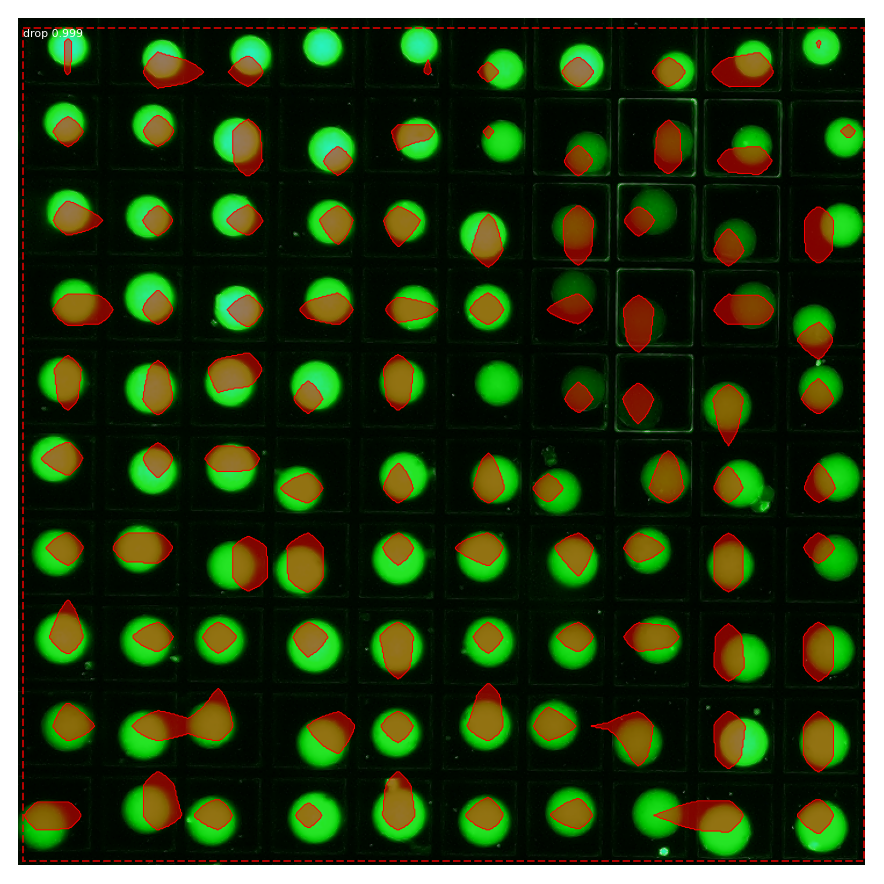

In [10]:
import skimage.io
from mrcnn import visualize

# Create models in training mode
# config = DropConfig()
# config.display()
# class InferenceConfig(DropConfig):
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# inference_config = InferenceConfig()
# model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

class_names = ['BG', 'drop']

# Load a random image from the images folder
file_names = r'E:\XMJ\Courseware\Lab\Mask_RCNN\samples\shapes\test_data10\7.tif' # next(os.walk(IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
image =  skimage.io.imread(file_names)
# face = cv2.imread(r'E:\XMJ\Courseware\Lab\Mask_RCNN\samples\shapes\train_data\pic1\1.tif', 0)  ## you should check..
# face_resize = cv2.resize(face, (256, 256))
# image.append(face_resize)
print(image.shape)
print(len(image))
print(model.config.BATCH_SIZE)
# print([image])

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

train_data11/labelme_json/1_json/img.png
train_data11/labelme_json/10_json/img.png
train_data11/labelme_json/11_json/img.png
train_data11/labelme_json/12_json/img.png
train_data11/labelme_json/13_json/img.png
train_data11/labelme_json/14_json/img.png
train_data11/labelme_json/15_json/img.png
train_data11/labelme_json/16_json/img.png
train_data11/labelme_json/17_json/img.png
train_data11/labelme_json/18_json/img.png
train_data11/labelme_json/19_json/img.png
train_data11/labelme_json/2_json/img.png
train_data11/labelme_json/20_json/img.png
train_data11/labelme_json/3_json/img.png
train_data11/labelme_json/4_json/img.png
train_data11/labelme_json/5_json/img.png
train_data11/labelme_json/6_json/img.png
train_data11/labelme_json/7_json/img.png
image_id:  12
drop
original_image           shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  256.00000  float64
gt_class_id              shape: (1,)      

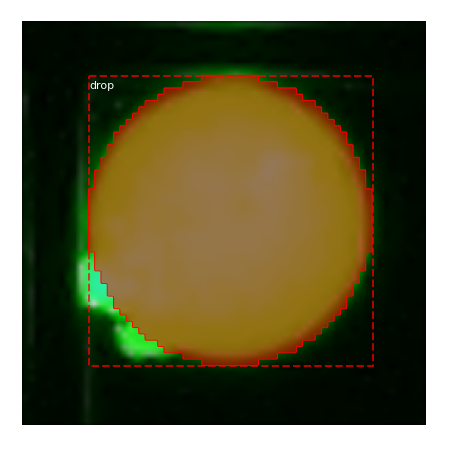

In [15]:
# Validation dataset
dataset_val1 = DropDataset()
# dataset_val.load_shapes(7, width, height, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val1.load_shapes(18, img_floder, mask_floder, imglist, dataset_root_path)
dataset_val1.prepare()
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val1, config, 
                           12, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  243.00000  uint8
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  126.20000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  256.00000  int32
anchors                  shape: (1, 16368, 4)         min:   -0.17747  max:    0.99541  float32


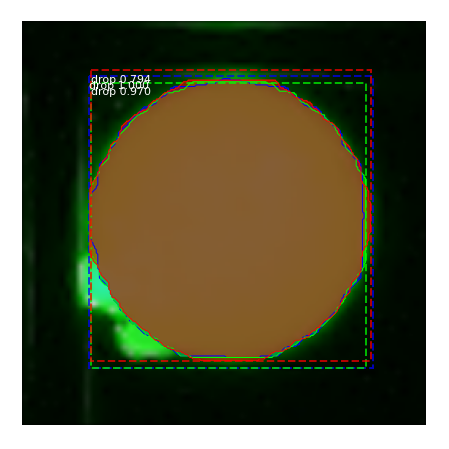

In [16]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [17]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 50)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

image_id:  4
drop
image_id:  5
drop
image_id:  2
drop
image_id:  3
drop
image_id:  5
drop
image_id:  3
drop
image_id:  6
drop
image_id:  4
drop
image_id:  0
drop
image_id:  5
drop
image_id:  5
drop
image_id:  2
drop
image_id:  2
drop
image_id:  0
drop
image_id:  0
drop
image_id:  2
drop
image_id:  0
drop
image_id:  6
drop
image_id:  6
drop
image_id:  3
drop
image_id:  6
drop
image_id:  0
drop
image_id:  5
drop
image_id:  1
drop
image_id:  3
drop
image_id:  5
drop
image_id:  3
drop
image_id:  3
drop
image_id:  3
drop
image_id:  1
drop
image_id:  1
drop
image_id:  0
drop
image_id:  5
drop
image_id:  3
drop
image_id:  3
drop
image_id:  5
drop
image_id:  1
drop
image_id:  4
drop
image_id:  1
drop
image_id:  6
drop
image_id:  4
drop
image_id:  6
drop
image_id:  2
drop
image_id:  0
drop
image_id:  0
drop
image_id:  0
drop
image_id:  5
drop
image_id:  0
drop
image_id:  0
drop
image_id:  4
drop
mAP:  0.9
